# `Process Data`

Import Python libraries

In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import astroML 
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=14, usetex=True)
import astropy

from scipy import stats
import scipy.optimize as op
import scipy.signal as sig
import scipy.constants as const
from scipy.signal import argrelextrema, medfilt

from random import uniform, randrange
import kplr
from kplr.ld import get_quad_coeffs
import time
from collections import Counter, defaultdict, OrderedDict
import glob, os
from multiprocessing import Pool, cpu_count
import itertools
import transit
import emcee
import corner

Confirm that the version of `emcee` is the latest (as of Aug 2018, it's 3.0rcl')

In [2]:
emcee.__version__

'3.0rc1'

Check the number of CPU's available in this computer.

In [3]:
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

8 CPUs


Standarize plots 

In [4]:
rcParams['figure.figsize'] = 16, 7
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

Load $\text{LaTeX}$

In [5]:
pgf_with_latex = {
    "pgf.texsystem": "xelatex",         # use Xelatex which is TTF font aware
    "text.usetex": True,                # use LaTeX to write all text
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "text.latex.unicode": True,
    "pgf.preamble": [
        r'\usepackage{fontspec}',
        r'\setmainfont{Ubuntu}',
        r'\setmonofont{Ubuntu Mono}',
        r'\usepackage{unicode-math}'
        r'\setmathfont{Ubuntu}'
        r'\usepackage{amsmath}' #for \text command
    ]
}

rcParams.update(pgf_with_latex)

# Global Parameters

General parameters from the NASA Kepler Mission

In [6]:
bjd_ref = 2454833
sc = 58.0  #sc = 58 sec
tKep = sc/60/60/24  # sc in days
print(tKep)

0.0006712962962962962


Physical constants

In [7]:
G = 6.6730e-11

Transit detection parameters

In [8]:
poly_order = 3
amplify = 2
snr_limit = 3.0

print("Amplification of transit duration by:", amplify)
print("The SNR limit of each transit has been set to", snr_limit)

Amplification of transit duration by: 2
The SNR limit of each transit has been set to 3.0


MCMC Global Initialization Parameters

In [9]:
period_guess = 100
steps_rho, nwalkers_rho = 10000, 100
steps, nwalkers = 10000, 100

burnin_rho = int(steps_rho/10) 
burnin_global = int(steps/5)

Prepare the headers we will use in the text files containing the results of my code.

In [10]:
id_mcmc = ["Depth:", "Impact parameter (b):", "sigma:", "Stellar Mass (Ms, [Solar mass]):",
           "Stellar Radius (Rs, [Solar Radii]):", "Out-of-transit flux (f0):", "Orbital Period (P, [days]):", 
           "Time of transit (tc, [days]):", "Planetary Radius (Rp, [Rearth]):", "Rs_a:"]

header_mcmc = "This file shows the 50% percentile and the +- 1 sigma error interval of the parameters.\n"

header_rs = "This file shows the 50% percentile for the Stellar Radius (in solar radii), \
its +- 1 sigma error interval, and the MCMC acceptance fraction (in %). Note that these results \
are for the star's *observed* transits with a minimum SNR of {0:f}. \n".format(snr_limit)

Confirm `os.environ=1` for the MCMC parallelization (advice given here: https://emcee.readthedocs.io/en/latest/tutorials/parallel/)

In [11]:
os.environ["OMP_NUM_THREADS"] = "1"

# Introduction

## Load the data

In [12]:
path_file = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/clean_bat_files/LC_p13point5up/'
path_mergedLC = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/merge_light_curves/LC_p13point5up_merged/'

properties_sample = pd.read_csv(path_file+'all_targets_P13point5up.csv', sep=',', comment='#')
targets = pd.read_csv(path_file + 'kepler_id.txt',delimiter=',', dtype=int, header=None, names=['kepid'])

In [13]:
df = pd.merge(targets, properties_sample, on=['kepid'], how='inner') 
sc_data = df.drop_duplicates('kepid') #remove duplicates (some systems have both sc and lc LC)

print("Check files:")

if (len(targets) != len(properties_sample)):
    print("(*) Lengths don't match:", len(targets), len(properties_sample))
    print("\tSome systems have both sc and lc data! Remove duplicates.")

if (len(sc_data) == len(targets)):
    print("(*) Lengths match:", len(sc_data), len(targets))
    print('\tDuplicates have been removed.\n A total of {} systems have *short-cadence* LC with SN > 7.1 for their first transit and only 1 planet'.format(len(sc_data)))
    
sc_data.shape

Check files:
(*) Lengths don't match: 55 984
	Some systems have both sc and lc data! Remove duplicates.
(*) Lengths match: 55 55
	Duplicates have been removed.
 A total of 55 systems have *short-cadence* LC with SN > 7.1 for their first transit and only 1 planet


(55, 141)

## Visualize the Dataset

0.738 1.927
0.74 1.486


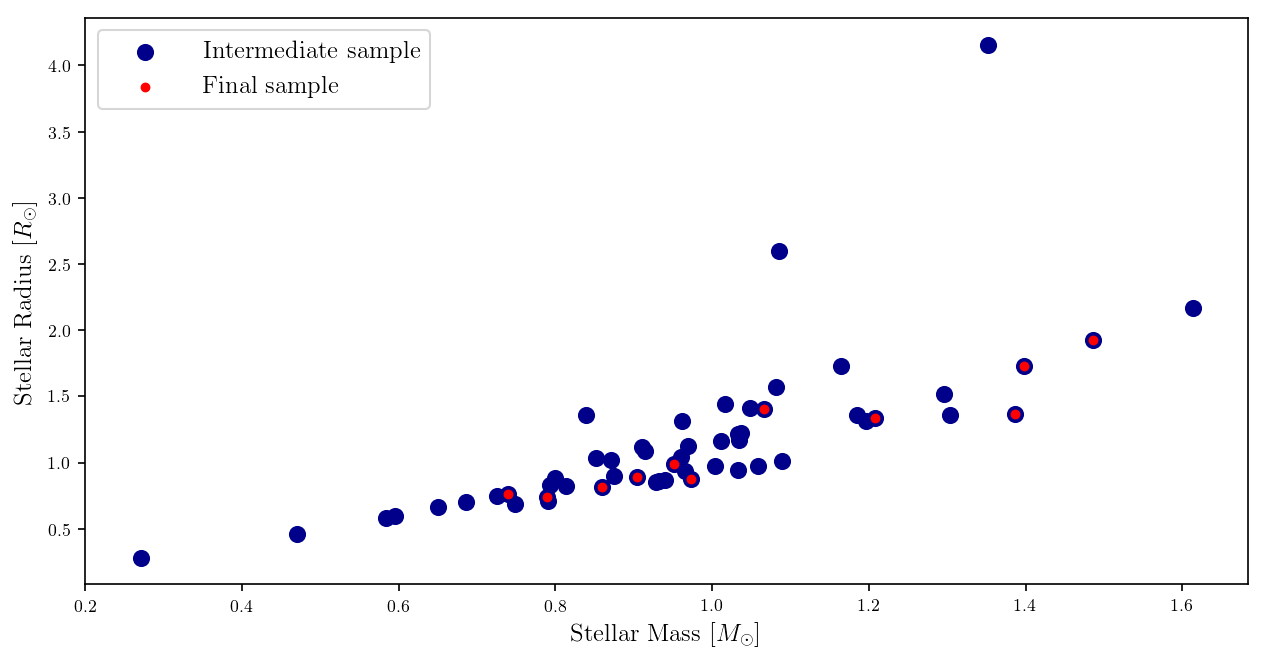

In [14]:
main_info = "/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/"

final_list_stars = {'rad': [0.738, 1.407, 0.993, 0.817, 1.367, 1.927, 1.337, 0.765 , 0.879, 1.731, 0.892], 
                    'mass': [0.79, 1.066, 0.951, 0.860, 1.386, 1.486, 1.208, 0.740, 0.973, 1.398, 0.904],
                   'teff': [4941, 5868, 5683, 5303, 6823, 6273, 6407, 4939, 5510, 6430, 5591],
                   'period': [17.276, 15.458, 16.238, 16.080, 17.855, 38.583, 17.833, 30.360, 38.478, 69.726,76.136],
                   'prad': [7.310, 9.110, 2.760, 4.430, 13.160, 8.560, 2.430, 10.990, 13.260, 11.650, 4.780]}

final_stars = pd.DataFrame(data=final_list_stars)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.scatter(sc_data['koi_smass'].values, sc_data['koi_srad'], marker = 'o', color = 'darkblue', label='Intermediate sample', s = 52);
ax.scatter(final_stars['mass'], final_stars['rad'], marker = '.', color ='r', label = 'Final sample', s = 55)
ax.set_ylabel('Stellar Radius [$R_{\odot}$]',fontsize = 12)
ax.set_xlabel(r'Stellar Mass [$M_{\odot}$]', fontsize = 12)
ax.legend(fontsize = 12)
plt.savefig(main_info+'kepler_sample.png', bbox_inches='tight')

print(min(final_stars['rad'].values), max(final_stars['rad'].values))
print(min(final_stars['mass'].values), max(final_stars['mass'].values))

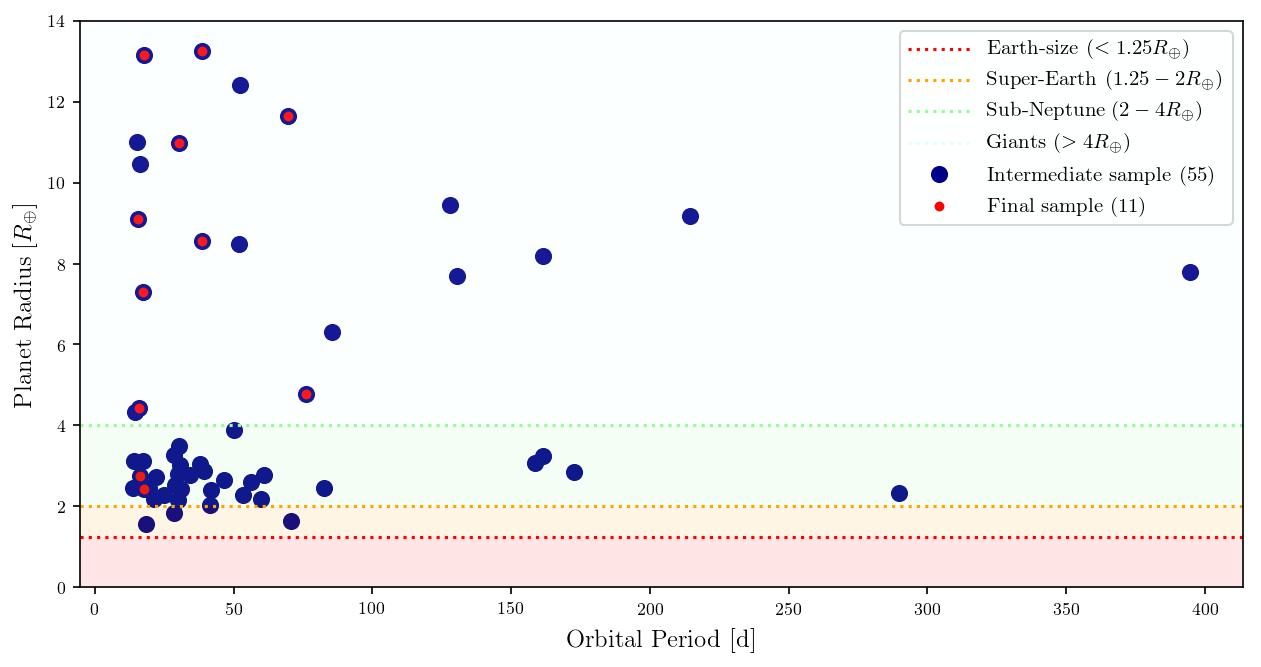

In [15]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.scatter(sc_data['koi_period'].values, sc_data['koi_prad'], marker = 'o', color = 'darkblue', label='Intermediate sample (55)', s = 52)
ax.scatter(final_stars['period'], final_stars['prad'], marker = '.', color ='r', label = 'Final sample (11)', s = 55)
ax.set_ylabel(r'Planet Radius [$R_{\oplus}$]',fontsize = 12)
ax.set_xlabel(r'Orbital Period [d]', fontsize = 12)
ax.axhline(y = 1.25, ls = 'dotted', color = 'red', label = r"Earth-size ($<1.25 R_{\oplus})$")
ax.axhspan(0, 1.25, facecolor='red', alpha=0.1)
ax.axhline(y = 2, ls = 'dotted', color = 'orange', label = r"Super-Earth ($1.25-2R_{\oplus}$)")
ax.axhspan(1.25, 2, facecolor='orange', alpha=0.1)
ax.axhline(y = 4, ls = 'dotted', color = 'palegreen', label = r"Sub-Neptune ($2-4R_{\oplus}$)")
ax.axhspan(2, 4, facecolor='palegreen', alpha=0.1)
ax.axhline(y = max(final_stars['prad'])+1, ls = 'dotted', color = 'lightcyan', label = r"Giants ($>4R_{\oplus}$)")
ax.axhspan(4, max(final_stars['prad'])+1, facecolor='lightcyan', alpha=0.1)
ax.set_ylim([0,14])
ax.legend(fontsize = 10)
plt.savefig(main_info+'kepler_sample_PvsRp.png', bbox_inches='tight')

4939 6823


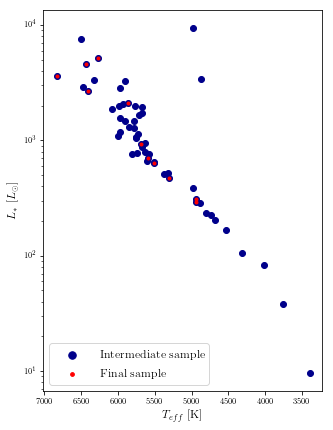

In [16]:
def get_lum(data, R, T):
    luminosity = []
    for i in range(len(data)):
        r_meters = R[i]*(6.957*10e8)
        teff_kelvin = T[i]
        l_watt = 4*np.pi*(const.Stefan_Boltzmann)*(r_meters**2)*(teff_kelvin**4)
        l_solar = l_watt*(2.599*10e-27)
        luminosity.append(l_solar)
    return luminosity 
    

fig = plt.figure(figsize=(5, 7), dpi = 72)
ax = fig.add_subplot(111)
ax.scatter(sc_data['koi_steff'].values, get_lum(sc_data,sc_data['koi_srad'].values, sc_data['koi_steff'].values), marker = 'o', color = 'darkblue', label='Intermediate sample')
ax.scatter(final_stars['teff'].values, get_lum(final_stars, final_stars['rad'].values, final_stars['teff'].values),marker ='.', color ='r', label = 'Final sample')
ax.set_xlabel(r'$T_{eff}$ [K]', fontsize = 12)
ax.set_yscale('log')
ax.set_ylabel(r'$L_{*}$ [$L_{\odot}$]', fontsize = 12)
ax.legend(markerscale=1.25, fancybox=True, fontsize = 12)
ax.invert_xaxis()
plt.savefig(main_info+'kepler_sample_HR.png', bbox_inches='tight')

print(min(final_stars['teff'].values), max(final_stars['teff'].values))

## Define the Systems

In [17]:
class System:    
    def __init__(self, kepid, rs, rs_err, smass, smass_err, teff, logg, feh, srho,
                time_BKJD, flux, flux_err, 
                t0, P, depth, b, duration, u1, u2, diffld, num_planets, incl, eccen, dor, sma,
                 transit_times,ind_missed_transits,
                rp, rp_solarRad, rp_err, teq, mp, 
                 trans_id, ftrans, ftrans_err, ttrans, dt_trans,
                full_P_trans, full_P, best_stats, full_P_trans_stats, full_stats, 
                 min_flux_folded):
        
        """****** Kepler Reported Stellar Parameters ******"""
        self.kepid = kepid
        self.rs = rs # [Solar radii]. 
        self.rs_err = rs_err
        self.smass = smass # [Solar mass]
        self.smass_err = smass_err
        
        self.teff = teff;     
        self.logg = logg; # Stellar Surface Gravity [log10(cm/s**2)]  
        self.feh = feh;   
        self.srho = srho; #g/cm3
        
        """****** LC parameters ******"""
        self.time_BKJD = time_BKJD
        self.flux = flux
        self.flux_err = flux_err
        
        """****** Transit Parameters ******"""
        self.t0 = t0
        self.P = P;            
        self.depth = depth;  
        self.b = b; 
        self.duration = duration; 
        self.u1 = u1; 
        self.u2 = u2
        self.diffld = 0.0
        self.num_planets = num_planets
        self.incl = incl #[º]
        self.eccen = 0.0
        self.dor = dor #Planet-Star Distance over Star Radius
        self.sma = sma #Orbital semi-major axis [AU]
        
        self.transit_times = transit_times
        self.ind_missed_transits = ind_missed_transits
                   
        """****** Planetary Parameters ******"""
        self.rp = rp # [Earth radii]. This is "prad"  in the original file
        self.rp_solarRad = rp*0.009168 # in solar radii
        self.rp_err = rp_err
        self.teq = teq
        self.mp = 2.69*(rp)**(0.93) #Weiss & Marcy rel'n. It requires Rp in Earth radii
        
        """****** Internal Variables ******"""
        self.trans_id = np.empty(0)
        self.ftrans = np.empty(0)
        self.ftrans_err = np.empty(0)
        self.ttrans = np.empty(0)
        self.dt_trans = np.empty(0)
        
        
        self.full_P_trans =  np.empty(0)
        self.full_P =  np.empty(0)
        self.best_stats =  np.empty(0)
        self.full_P_trans_stats = np.empty(0)
        self.full_stats = np.empty(0)
        
        self.min_flux_folded = 0.0
        

## Characterize the Systems

Some initialization functions: `quadraticLD`calculates the quadratic LD coefficients of a star based on the model from Claret & Bloemen (2011). As for `fetchLC`, it simply loads the systems' light curves.

In [18]:
def quadraticLD(T, G, FEH): 
    """Confirm the quadratic LD coefficients with a model from Claret & Bloemen (2011).
    Use the Claret coefficients instead."""
    mu1, mu2 = get_quad_coeffs(T, G, FEH)
    return (mu1, mu2)

def fetchLC(name):
    id_kep = "%.0f" % name
    lc = path_mergedLC+('KID'+id_kep+'.txt')
    df = pd.read_csv(lc, sep="\t", skiprows=1, header=None, names=["Time BKJD", "Flux", "Flux_Err"])
    y = df['Flux']
    yerr = df['Flux_Err']
    x = df['Time BKJD']
    return (y, yerr, x)







Create the planet+star system. In this research, we will only evaluate systems with only 1 planet. 

In [19]:
targets = []

for row in sc_data.itertuples(index = True, name='Pandas'):
    kepid = getattr(row, "kepid")
    fluxLC, fluxLC_err, timeLC_BKJD = fetchLC(kepid)

    ## Store the stellar parameters
    rs = getattr(row, "koi_srad") #solar radii
    smass = getattr(row, "koi_smass")
    
    #Assuming that we have a 5% error on radius and mass (this is sensible thanks to Gaia)
    rs_err = rs*0.05
    smass_err = smass*0.05
    
    teff = getattr(row, "koi_steff")
    logg = getattr(row, "koi_slogg") # Stellar Surface Gravity [log10(cm/s**2)]  
    feh = getattr(row, "koi_smet")
    srho = getattr(row, "koi_srho") #g/cm3
    
    #### Store LC Parameters
    t0 = getattr(row, "koi_time0bk")
    P = getattr(row, "koi_period") # Orbital Period [days]
    depth = getattr(row, "koi_depth")/1e6
    b = getattr(row, "koi_impact")
    
    u1, u2 = quadraticLD(teff,logg,feh)

    num_planets = getattr(row, "koi_count")
    incl =  getattr(row, "koi_incl") #in degrees
    dor = getattr(row, "koi_dor")  #Planet-Star Distance over Star Radius
    
    duration = getattr(row, "koi_duration")/24. #in days. "Duration is measured from first contact between the planet and star until last contact."
    
    #Planetary parameters
    sma = getattr(row, "koi_sma")  #Orbit Semi-Major Axis [AU]
    sma_solarRad = sma*215
    teq = getattr(row, "koi_teq") 
    rp = getattr(row, "koi_prad") # in Earth radii
    rp_errPos = getattr(row, "koi_prad_err1"); rp_errNeg = getattr(row, "koi_prad_err2")
    rp_err = np.sqrt(rp_errPos**2+rp_errNeg**2)
        
    if (num_planets == 1):
        system = System(kepid, rs, rs_err, smass, smass_err, teff, logg, feh, srho,
                    timeLC_BKJD, fluxLC, fluxLC_err, 
                    t0, P, depth, b, duration, u1, u2, u1-u2, num_planets, incl, 0.0, dor, sma,
                        None, None,
                    rp, None, rp_err, teq, None, 
                        None, None, None, None, None,
                       None, None, None, None, None,
                       0.0)

        targets.append(system)
                
    else:
        print('Star {:s} not stored (koi_count > 1)'.format(str(kepid)))

# Transit Detection

In [20]:
def find_transits(star):
    ti = min(star.time_BKJD)
    tf = max(star.time_BKJD)
    
    n_min = int((ti-star.t0)/star.P)
    n_max = int((tf-star.t0)/star.P+1.)
    n = np.arange(n_min, n_max)
    
    t = star.t0+n*star.P
    t = t[t>ti] 
    t = t[t<tf]
    return(t)

In [21]:
def show_folded_lightcurve(star, plot=False):
    if plot==True:
        plt.figure(figsize=(15,6))
        plt.plot(star.dt_trans,star.ftrans,'.', ms = 2)     
        plt.title('Folded LC for KID'+str(star.kepid))
        plt.xlabel('Time from midtransit [d]'); plt.ylabel('Normalized Flux')
        plt.show(block=False)    
        time.sleep(0.1)
        plt.close()

def mark_transits(star, obs_trans, plot=False):
    if plot==True:
        fig = plt.figure(figsize=(13,6))
        plt.plot(star.time_BKJD,star.flux,'.')        
        for j in range(len(star.transit_times)): 
            plt.axvline(star.transit_times[j], color='k', ls='-')
        for k in range(len(obs_trans)): 
            plt.axvline(obs_trans[k], color='r', ls='--')
        plt.title('KID'+str(star.kepid))
        plt.xlabel('Time BKJD [d]'); plt.ylabel('Normalized Flux')
        plt.savefig("results/marked_transits/"+str(star.kepid)+".png", bbox_inches='tight')
        plt.show(block=False)    
        time.sleep(0.1)
        plt.close()
        
def show_transits(star, bad_trans, plot=False):        
    s1 = set(bad_trans)
    if plot==True:   
        for i in range(len(star.transit_times)):
            if (i not in bad_trans):
                fig = plt.figure(figsize=(15,6))
                plt.title('Transit '+str(i+1))
                plt.plot(star.ttrans[star.trans_id==i]-star.transit_times[i],star.ftrans[star.trans_id==i], 'k.', ms = 2)     
                plt.xlabel('Time from midtransit [d]'); plt.ylabel('Normalized Flux')
                plt.show(block=False)    
                time.sleep(0.1)
                plt.close(fig)

In [22]:
def get_data_in_transit(star, factor):
    window = factor*star.duration # In days
    total_points = 0
    
    for i in range(0,len(star.transit_times)):
        residual = star.time_BKJD - star.transit_times[i]
        points_in_transit = np.abs(residual) <= window
        total_points += np.sum(points_in_transit)
  
    time_in_transit = np.empty(total_points)
    flux_in_transit = np.empty(total_points)
    flux_err_in_transit = np.empty(total_points)
    flag_transit = np.empty(total_points)
    mid_trans = np.empty(total_points)

    total_points = 0
 
    for i in range(0, len(star.transit_times)):
        points_in_transit = np.abs(star.time_BKJD - star.transit_times[i]) <= window
        count_points = np.sum(points_in_transit)
        time_in_transit[(0 + total_points):(count_points + total_points)] = star.time_BKJD[points_in_transit]
        flux_in_transit[(0 + total_points):(count_points + total_points)] = star.flux[points_in_transit] #, star.flux_err[points_in_transit])[0]
        flux_err_in_transit[(0 + total_points):(count_points + total_points)] = star.flux_err[points_in_transit] #normalize(star.flux[points_in_transit], 
        flag_transit[(0 + total_points):(count_points + total_points)] = i
        mid_trans[(0 + total_points):(count_points + total_points)] = star.transit_times[i] 
        total_points += count_points
        
    star.trans_id = flag_transit #The counter starts at 0 (in other words, trans_id == 0 is already the first transit)
    star.ttrans = time_in_transit
    star.ftrans = flux_in_transit
    star.ftrans_err = flux_err_in_transit
    star.dt_trans = time_in_transit - mid_trans #if interested in the folded LC, plot target.dt_trans vs target.ftrans

In [23]:
def oot_fit(star, poly):
    transit_range = star.duration/2     
    
    if star.kepid == 8156120:
        poly = 5
    
    if star.kepid == 5812701:
        poly = 7
        
    if star.kepid == 12365184:
        poly = 1
    
    for i in range(len(star.transit_times)):
        dt = star.ttrans[star.trans_id == i] - star.transit_times[i]
        y = star.ftrans[star.trans_id==i]
        yerr = star.ftrans_err[star.trans_id==i]
        
        outside_trans = np.abs(dt) >= transit_range
        inside_trans = np.abs(dt) < transit_range
        num_oot_points = len(dt[outside_trans])
        
        if  (num_oot_points!= 0):
            coeffs = np.polyfit(dt[outside_trans], y[outside_trans], poly)
            baseline_fitted = np.polyval(coeffs, dt)
            
            newY = y/baseline_fitted
            newYerr = yerr/baseline_fitted 
            
            fig = plt.figure()
            plt.plot(dt, y, 'mo', label = 'LC')
            plt.plot(dt[outside_trans], y[outside_trans], '.', label ='OOT')
            plt.plot(dt, baseline_fitted, '.', label ='Baseline')
            plt.plot(dt, newY, 'y-', label ='LC/baseline')
            plt.legend()
            filepath_oot = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/oot_fit/'
            store_oot = "oot"+str(star.kepid)+"_trans"+str(i+1)+"_poly"+str(poly)+".png"
            fig.savefig(filepath_oot+store_oot, bbox_inches='tight')
            #plt.show(block=False)    
            #time.sleep(0.1)
            plt.close(fig)
            
            star.ftrans[star.trans_id==i] = newY
            star.ftrans_err[star.trans_id==i] = newYerr

In [24]:
def find_missed_transits(star):
    gaps = []
    for i in range(len(star.transit_times)):
        if len(star.ttrans[star.trans_id==i])==0: 
            gaps.append(i)
    missing_transits = sorted(gaps, reverse=True)
    return(missing_transits)

In [25]:
def export_folded_lc(system):
    lc = pd.DataFrame(OrderedDict({'Time': system.time_BKJD, 'Flux': system.flux, 'Flux_Err': system.flux_err}))
     
    np.savetxt("/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/folded_LC/"+str(system.kepid)+".txt", 
               lc.values, fmt='%f', delimiter="\t") 

## Observed Transits

The code below performs two functions: 
    1. It identifies the light curves that don't have a visible transit. (With the data being used as of June 30, this amounts to 4 systems).
    2. For the remaining light curves, it calculates all the expected transits and then looks at which transits are actually visible (sometimes, there are gaps in the data and transits are lost). 

In [26]:
stars_wo_transits = []

In [27]:
for target in targets:
    print("\n******************************** KID"+str(target.kepid)+" ********************************\n")
    target.transit_times = find_transits(target)    
    get_data_in_transit(target, amplify)
    if (len(target.transit_times)==0): stars_wo_transits.append(target.kepid)
    target.ind_missed_transits = find_missed_transits(target) # On notation: Imagine target.ind_missed_transits = [18]. This means 
                                                              # that the transit with flag_id = 18 hasn't been observed (and not the transit 
                                                              # with flag_id = 17)
    oot_fit(target, poly_order)
    observed_transits = np.delete(target.transit_times, target.ind_missed_transits)
    mark_transits(target, observed_transits, False)
    show_transits(target, target.ind_missed_transits, False)
                
    if len(observed_transits!=0): 
        show_folded_lightcurve(target, False)
        target.min_flux_folded = min(target.ftrans)

    export_folded_lc(target)

    print("Transit duration: {0:0.5} [d]".format(target.duration))
    print("Period: {0:s} [d]".format(str(target.P)))
    print("Estimated transits at ({0:s}):".format(str(len(target.transit_times))), target.transit_times)
    print("Observed transits at ({0:s}):".format(str(len(observed_transits))), observed_transits)
    print("Index of missed transits:", target.ind_missed_transits)
    print("Min. flux folded LC: {0:0.3f}".format(target.min_flux_folded))


******************************** KID11133306 ********************************

Transit duration: 0.19219 [d]
Period: 41.74598855 [d]
Estimated transits at (26): [ 544.3670594   586.11304795  627.8590365   669.60502505  711.3510136
  753.09700215  794.8429907   836.58897925  878.3349678   920.08095635
  961.8269449  1003.57293345 1045.318922   1087.06491055 1128.8108991
 1170.55688765 1212.3028762  1254.04886475 1295.7948533  1337.54084185
 1379.2868304  1421.03281895 1462.7788075  1504.52479605 1546.2707846
 1588.01677315]
Observed transits at (25): [ 544.3670594   586.11304795  627.8590365   669.60502505  711.3510136
  753.09700215  794.8429907   836.58897925  878.3349678   920.08095635
  961.8269449  1003.57293345 1045.318922   1087.06491055 1128.8108991
 1170.55688765 1212.3028762  1254.04886475 1337.54084185 1379.2868304
 1421.03281895 1462.7788075  1504.52479605 1546.2707846  1588.01677315]
Index of missed transits: [18]
Min. flux folded LC: 0.999

*******************************

Transit duration: 0.36933 [d]
Period: 30.8639476 [d]
Estimated transits at (15): [ 811.0236696  841.8876172  872.7515648  903.6155124  934.47946
  965.3434076  996.2073552 1027.0713028 1057.9352504 1088.799198
 1119.6631456 1150.5270932 1181.3910408 1212.2549884 1243.118936 ]
Observed transits at (15): [ 811.0236696  841.8876172  872.7515648  903.6155124  934.47946
  965.3434076  996.2073552 1027.0713028 1057.9352504 1088.799198
 1119.6631456 1150.5270932 1181.3910408 1212.2549884 1243.118936 ]
Index of missed transits: []
Min. flux folded LC: 0.998

******************************** KID8805348 ********************************

Transit duration: 0.20198 [d]
Period: 29.90721859 [d]
Estimated transits at (1): [773.4377418]
Observed transits at (1): [773.4377418]
Index of missed transits: []
Min. flux folded LC: 0.997

******************************** KID11027624 ********************************

Transit duration: 1.0045 [d]
Period: 394.6249514 [d]
Estimated transits at (0): []
Observed tr

Transit duration: 0.19005 [d]
Period: 29.88487723 [d]
Estimated transits at (35): [ 561.69780799  591.58268522  621.46756245  651.35243968  681.23731691
  711.12219414  741.00707137  770.8919486   800.77682583  830.66170306
  860.54658029  890.43145752  920.31633475  950.20121198  980.08608921
 1009.97096644 1039.85584367 1069.7407209  1099.62559813 1129.51047536
 1159.39535259 1189.28022982 1219.16510705 1249.04998428 1278.93486151
 1308.81973874 1338.70461597 1368.5894932  1398.47437043 1428.35924766
 1458.24412489 1488.12900212 1518.01387935 1547.89875658 1577.78363381]
Observed transits at (5): [ 561.69780799  591.58268522  621.46756245  711.12219414 1577.78363381]
Index of missed transits: [33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 4, 3]
Min. flux folded LC: 0.997

******************************** KID12365184 ********************************

Transit duration: 0.1549 [d]
Period: 69.72646639 [d]
Estimated transits at

Transit duration: 0.18797 [d]
Period: 17.83367834 [d]
Estimated transits at (82): [ 145.56658632  163.40026466  181.233943    199.06762134  216.90129968
  234.73497802  252.56865636  270.4023347   288.23601304  306.06969138
  323.90336972  341.73704806  359.5707264   377.40440474  395.23808308
  413.07176142  430.90543976  448.7391181   466.57279644  484.40647478
  502.24015312  520.07383146  537.9075098   555.74118814  573.57486648
  591.40854482  609.24222316  627.0759015   644.90957984  662.74325818
  680.57693652  698.41061486  716.2442932   734.07797154  751.91164988
  769.74532822  787.57900656  805.4126849   823.24636324  841.08004158
  858.91371992  876.74739826  894.5810766   912.41475494  930.24843328
  948.08211162  965.91578996  983.7494683  1001.58314664 1019.41682498
 1037.25050332 1055.08418166 1072.91786    1090.75153834 1108.58521668
 1126.41889502 1144.25257336 1162.0862517  1179.91993004 1197.75360838
 1215.58728672 1233.42096506 1251.2546434  1269.08832174 1286.9220

In [28]:
print("There are {:s} stars without transits. These targets won't be studied".format(str(len(stars_wo_transits))))
print(stars_wo_transits)

There are 4 stars without transits. These targets won't be studied
[11027624, 11622600, 7761545, 10795103]


In [29]:
print(steps)
print(steps_rho)

10000
10000


## Target 5812701

For the star 5812701, the oot region of 3 individual transits were not fitted properly when applying the 3rd order polynomial. To avoid them destroying the beauty of the folded light curve plotted in the pie chart, I've added these 3 bad transits to the missed_transits list. Originally I was doing this just done for visual purposes under Section 8, but I moved this here so that I could obtain a proper fit of the folded LC.

[76, 72, 58, 38, 21, 20, 19, 18, 3, 2, 1, 65, 49, 23]
0.9895097260695135


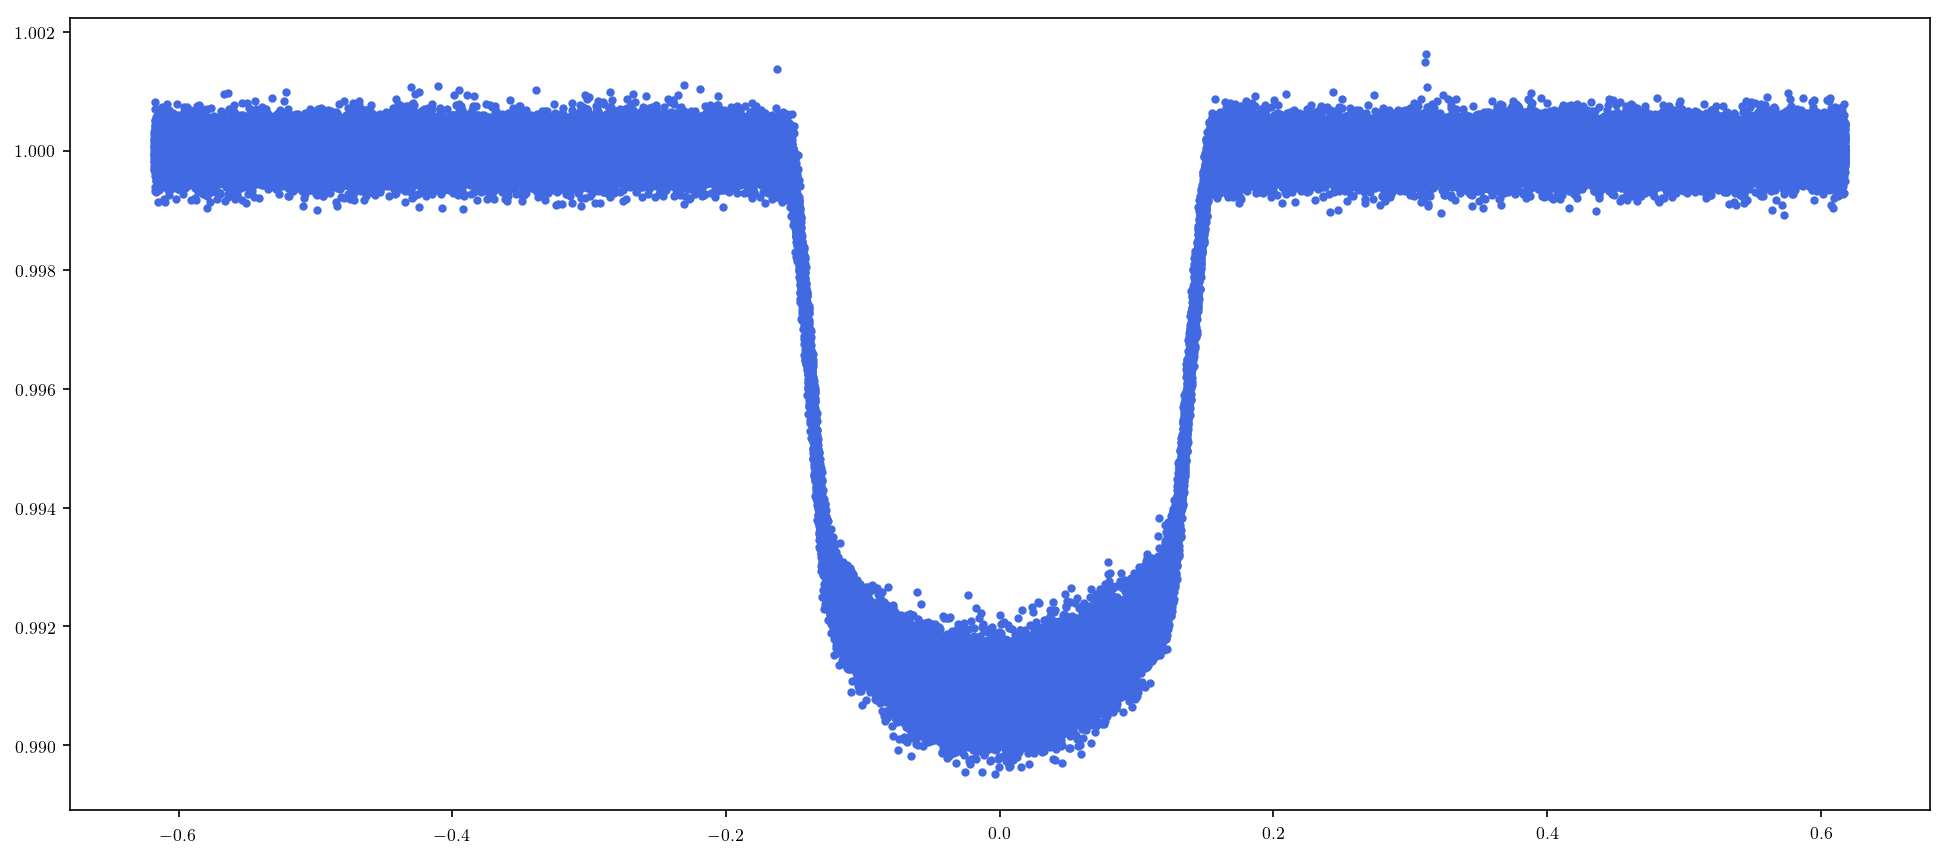

In [30]:
for target in targets:
    if target.kepid == 5812701:
        bad_tr = [65, 49, 23]
        min_flux = []
        target.ind_missed_transits.extend(bad_tr)
        missed_trans = set(target.ind_missed_transits)
        print(target.ind_missed_transits)
        for i in range(len(target.transit_times)): 
            if i not in missed_trans:
                plt.plot(target.ttrans[target.trans_id==i]-target.transit_times[i], target.ftrans[target.trans_id==i],'.', 
                       color = 'royalblue')
                min_flux.append(min(target.ftrans[target.trans_id==i]))
        target.min_flux_folded = min(min_flux)
        print(target.min_flux_folded)

# Fit of the Stellar Density

## Transit Routine

A Python library for generating light curves of transiting planets. See https://github.com/dfm/transit/blob/master/transit/transit.py for original code

In [60]:
def lnprior_rho(theta, maxb):
    pdepth, pb, sigma, pradius, f0, ptc, sumLD = theta 
    if ((0.3 < sumLD < 1.0) and (0 <= pb <= maxb) and (0 <= sigma)\
         and (pradius > 0) and (pdepth > 0) and (ptc**2<0.01)):
        return 0.0
    return -np.inf  

def lnlike_rho(theta, timeLC, fluxLC, errorLC, allfixed):
    ecc,  mass, masserr, tKep, maxb, P, diffLD = allfixed
    pdepth, pb, sigma, pradius, f0, ptc, sumLD = theta 
    u1 = 0.5*(sumLD+diffLD) 
    u2 = sumLD-u1
    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass = mass, radius = pradius))
    body = transit.Body(radius=np.sqrt(pdepth)*pradius, period=P, t0=ptc, b=np.abs(pb), e=ecc)
    s.add_body(body)
    inv_sigma2 = 1.0/(errorLC**2 + sigma**2)
    try: 
        ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=5)
    except ValueError:
        return -np.inf
    ftheo = ftheo-1+f0
    chi2 = -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)))
    return chi2
                 
def lnprob_rho(theta, timeLC, fluxLC, errorLC, allfixed):
    ecc, mass, masserr, tKep, maxb, P, diffLD = allfixed
    lp_rho = lnprior_rho(theta, maxb)
    if not np.isfinite(lp_rho):
        return -np.inf
    return lp_rho + lnlike_rho(theta, timeLC, fluxLC, errorLC, allfixed)

## MCMC

In [61]:
def fit_rho(star, t, f, ferr, num_trans, showLC, showMCMC):
    #**************************************** Optimize LC Parameters ****************************************
    max_b = 1+star.rp_solarRad/star.rs
    print("\nMax b (Rp in Solar Radius): {0:0.3f}".format(max_b))
    allfixed_rho = np.array([star.eccen, star.smass, 0.0, tKep, max_b, star.P, star.diffld])
    first_guess =  np.array([star.depth/1.1, star.b, 0.0, star.rs, 1.0, 0.0, (star.u1+star.u2)])
    
    nll_rho = lambda *args: -lnprob_rho(*args)
    result = op.minimize(nll_rho, first_guess, args=(t, f, ferr, allfixed_rho), 
                       options={'maxiter':1e5,'disp': True},
                       method='Nelder-Mead') 
    depth_ml, b_ml, sigma_ml, radius_ml, f0_ml, tc_ml, sumLD_ml = result["x"]
    # Readjust LD coefficients. 
    u1_ml = 0.5*(sumLD_ml + star.diffld)
    u2_ml = sumLD_ml - u1_ml
   
    #Compute the theoretical light curve integrated over a Kepler short-cadence exposure time.
    s = transit.System(transit.Central(mu1=u1_ml, mu2= u2_ml, mass=star.smass, radius=radius_ml))
    body = transit.Body(radius=np.sqrt(depth_ml)*radius_ml, period = star.P, 
                        t0 = tc_ml, b = np.abs(b_ml), e = star.eccen)
    s.add_body(body)
    t_fit = np.arange(-1, 1, tKep*0.01)
    f_fit = s.light_curve(t_fit, texp=tKep, tol=1e-08, maxdepth=5)
    f_fit = f_fit - 1.0 + f0_ml
    if showLC == True:
        fig = plt.figure(figsize=(16,7))
        plt.title(str(star.kepid)+'. Stellar Density Fit for Transit '+str(num_trans+1), fontsize = 15)
        plt.plot(t, f, '.')
        plt.plot(t_fit, f_fit, color='r', lw = 3)
        plt.xlabel('Time from midtransit [days]')
        plt.ylabel('Normalized flux')
        plt.xlim([min(t),max(t)]) 
        plt.show(block=False)    
        time.sleep(0.2)
        plt.close()
    
    #**************************************** MCMC ****************************************
    ndim_rho = len(result["x"])
    p0 = [result["x"]*(1+1e-8*np.random.randn(ndim_rho)) for i in range(nwalkers_rho)]
    
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers_rho, ndim_rho, lnprob_rho, args=(t, f, ferr, allfixed_rho), pool=pool)
        start = time.time()
        print("Running burn-in")
        pos, prob, state = sampler.run_mcmc(p0, 200, progress = True);
        sampler.reset() # Reset the chain to remove the burn-in samples.
        print("\n------ Run MCMC -------")
        sampler.run_mcmc(p0, steps_rho, rstate0 = state, progress=True);
        end = time.time()
        multi_time = end - start
        print("Multiprocessing took {0:.1f} seconds".format(multi_time))
        
    samples = sampler.chain[:, burnin_rho:, :].reshape((-1, ndim_rho))
    samples[:, 2] = np.exp(samples[:, 2])
    
    #Get the 50% percentile and the +- 1 sigma error of the parameters and 2 derived quantities 
    depth_mcmc, b_mcmc, sigma_mcmc, \
    rs_mcmc, f0_mcmc, tc_mcmc, sumLD_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                               zip(*np.percentile(samples, [15.86, 50, 84.14], axis=0)))
    # Readjust LD coefficients. 
    u1_mcmc = 0.5*(sumLD_mcmc[0] + star.diffld)
    u2_mcmc = sumLD_mcmc[0] - u1_mcmc

    if showMCMC == True:
        print("\n------ Post-MCMC Results ------")
        print("\nDepth:\n\tTrue = {:0.3f}".format(star.depth))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(depth_mcmc[0],depth_mcmc[1],depth_mcmc[2]))
        print("\nImpact parameter:\n\tTrue = {:0.3f}".format(star.b))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(b_mcmc[0],b_mcmc[1],b_mcmc[2]))
        print("\nStellar radius [Rsun]:\n\tREPORTED = {:0.3f}".format(star.rs))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(rs_mcmc[0], rs_mcmc[1],rs_mcmc[2]))
        print("\nSum LD Coefficients:\n\tREPORTED = {:0.3f}".format(star.u1+star.u2))
        print("\tu1 MCMC Fit  = {0:0.3f}".format(u1_mcmc))
        print("\tu2 MCMC Fit  = {0:0.3f}".format(u2_mcmc))
        
    #****************************************  Plot MCMC fit **************************************** 
    s = transit.System(transit.Central(mu1=u1_mcmc, mu2=u2_mcmc, mass=star.smass, radius=rs_mcmc[0]))
    body = transit.Body(radius=np.sqrt(depth_mcmc[0])*rs_mcmc[0], period=star.P, t0=tc_mcmc[0], 
                        b=np.abs(b_mcmc[0]), e = star.eccen)
    s.add_body(body)
    t_fit = np.arange(-1, 1, tKep*0.01)
    f_fit = s.light_curve(t_fit, texp=tKep, tol=1e-08, maxdepth=4)
    f_fit = f_fit - 1.0 + f0_mcmc[0]
    fig_lc = plt.figure(figsize=(15,4))
    plt.title('MCMC Fit for KID'+str(star.kepid))
    plt.plot(t, f, '.')
    plt.plot(t_fit, f_fit, 'r', lw = 3)
    plt.xlabel('Time [d]'); plt.ylabel('Normalized Flux')
    plt.xlim([min(t),max(t)])
    filepath_rho = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/new_rs/'
    store_lcfit = "fit"+str(star.kepid)+"_st"+str(steps_rho)+"_trans"+str(num_trans+1)+".png"
    fig_lc.savefig(filepath_rho+store_lcfit)
    plt.close(fig_lc)
    
    #**************************************** Corner Plot **************************************** 
    true_params = [star.depth, star.b, None, star.rs, 1.0, 0.0, (star.u1+star.u2)]
    res_labels = [r'Depth', r'$b$', r'$\sigma$', r'$R_{s} [R_{\odot}]$', r'$f_{0}$', r'$t_{c}$', r'$u_{1}+u_{2}$']
    
    fig_corner = corner.corner(samples, weights = None, labels = res_labels, quantiles = [0.16, 0.5, 0.84],
                               truths = None, show_titles = True, title_args = {"fontsize": 12}, 
                               plot_contours = True, plot_datapoints = False) 
    
    plt.suptitle("KID"+str(star.kepid)+". Corner Plot for Transit "+str(num_trans+1), fontsize = 20)
    store_corner = "corner"+str(star.kepid)+"_st"+str(steps_rho)+"_trans"+str(num_trans+1)+".png"
    fig_corner.savefig(filepath_rho+store_corner)
    plt.close(fig_corner)
   
    #**************************************** Steps Plot **************************************** 
    fig_steps, axes = plt.subplots(ndim_rho, 1, sharex=True, figsize=(8, 9))
    axes[0].plot(sampler.chain[:, :, 0].T, ls='dotted', color = "xkcd:sky blue") #depth = 0
    axes[0].set_ylabel(r'Depth'); 
    axes[0].axhline(true_params[0], color='red')
    axes[1].plot(sampler.chain[:, :, 1].T, ls='dotted', color="xkcd:sky blue")
    axes[1].set_ylabel(r'$b$'); 
    axes[1].axhline(true_params[1], color='red')
    axes[2].plot((sampler.chain[:, :, 2]).T, ls='dotted', color="xkcd:sky blue")
    axes[2].set_ylabel(r'$\sigma$');
    axes[3].plot((sampler.chain[:, :, 3]).T, ls='dotted', color="xkcd:sky blue")
    axes[3].set_ylabel(r'$R_{s} [R_{\odot}]$'); 
    axes[3].axhline(true_params[3], color='red')
    axes[4].plot((sampler.chain[:, :, 4]).T, ls='dotted', color="xkcd:sky blue")
    axes[4].set_ylabel(r'$f_{0}$'); 
    axes[4].axhline(true_params[4], color='red')
    axes[5].plot((sampler.chain[:, :, 5]).T, ls='dotted',color="xkcd:sky blue")
    axes[5].set_ylabel(r"$t_{c}$"); 
    axes[5].axhline(true_params[5], color='red')
    axes[6].plot((sampler.chain[:, :, 6]).T, ls='dotted',color="xkcd:sky blue")
    axes[6].set_ylabel(r"$u_{1}+u_{2}$"); 
    axes[6].axhline(true_params[6], color='red')
    axes[6].set_xlabel("Step number")
    
    fig_steps.tight_layout(h_pad=0.0)
    store_steps= "steps"+str(star.kepid)+"_st"+str(steps_rho)+"_trans"+str(num_trans+1)+".png"
    fig_steps.savefig(filepath_rho+store_steps)
    plt.close(fig_steps)
    
    #**************************************** Acceptance Fraction **************************************** 
    #As rule of thumb, the acceptance fraction (af) should be between 0.2 and 0.5. If af < 0.2 decrease the 
    #a parameter. If af > 0.5 increase the a parameter. 
    af = sampler.acceptance_fraction  
    af_percentage = 100*np.mean(sampler.acceptance_fraction)
    print("Mean acceptance fraction: {0:0.2f} ({1:0.2f} %)".format(np.mean(af), af_percentage))
    
    #**************************************** Store MCMC results **************************************** 
    results_mcmc = [depth_mcmc, b_mcmc, sigma_mcmc, rs_mcmc, f0_mcmc, tc_mcmc, sumLD_mcmc]
    rs_results = np.array([rs_mcmc[0],rs_mcmc[1],rs_mcmc[2]])
    
    return radius_ml, rs_results, af_percentage

## Fit individual Transits

Fit the stellar radius to obtain a better estimate of the stellar density

In [59]:
for target in targets:
    print("\n******************************** KID"+str(target.kepid)+" ********************************")
    plt.close("all")
    key = target.kepid
    missed_trans = set(target.ind_missed_transits)
    rs_trans_fit = []
    rs_trans_afrac = []
    
    for i in range(len(target.transit_times)): 
        if i not in missed_trans:
            print("\n*TRANSIT "+str(i+1))
            dt_i = target.ttrans[target.trans_id==i]-target.transit_times[i]
            f_trans_i = target.ftrans[target.trans_id==i]
            oot = np.abs(dt_i)>=(target.duration/2)
            iit = np.abs(dt_i)<(target.duration/2)
            d = 1-np.mean(f_trans_i[iit])
            error_trans_oot = np.std(f_trans_i[oot])
            snr = d/error_trans_oot
            print("\tSignal = {0:0.5f}. Noise (rms) = {1:0.5f}. SNR = {2:0.5f}".format(d, error_trans_oot, snr))
            print("\tOut-of-transit error of the transit LC = {0:0.5f}".format(error_trans_oot))
            
            if snr > snr_limit:
                rsFit, rsMCMC, rs_afraction = fit_rho(target, dt_i,  f_trans_i, 0.1*error_trans_oot, i, False, False)
                print("Stellar Radius [Rsun]:\tMCMC = {0:0.5f}.\t1st Fit = {1:0.5f}.\tKepler = {2:0.5f}".format(rsMCMC[0], rsFit, target.rs))
                print("Error Stellar Radius [Rsun]:\tMCMC (up) = {0:0.5f}, (down) = {1:0.5f}.\tOld = {2:0.5f}".format(rsMCMC[1], rsMCMC[2],  target.rs_err))
                rs_trans_fit.append(rsMCMC)
                rs_trans_afrac.append(rs_afraction)
    
    if len(rs_trans_fit) != 0:
        locs_rsNew = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/new_rs/'
        fname_rsNew = str(target.kepid)+"_st"+str(steps_rho)+"_RsMCMC.txt"
        np.savetxt(locs_rsNew+fname_rsNew, np.column_stack((rs_trans_fit, rs_trans_afrac)), 
                               fmt = "%0.3f", header = header_rs)


******************************** KID11133306 ********************************

*TRANSIT 1
	Signal = 0.00038. Noise (rms) = 0.00030. SNR = 1.27823
	Out-of-transit error of the transit LC = 0.00030

*TRANSIT 2
	Signal = 0.00039. Noise (rms) = 0.00029. SNR = 1.34154
	Out-of-transit error of the transit LC = 0.00029

*TRANSIT 3
	Signal = 0.00036. Noise (rms) = 0.00028. SNR = 1.25945
	Out-of-transit error of the transit LC = 0.00028

*TRANSIT 4
	Signal = 0.00034. Noise (rms) = 0.00028. SNR = 1.21716
	Out-of-transit error of the transit LC = 0.00028

*TRANSIT 5
	Signal = 0.00024. Noise (rms) = 0.00028. SNR = 0.85699
	Out-of-transit error of the transit LC = 0.00028

*TRANSIT 6
	Signal = 0.00032. Noise (rms) = 0.00029. SNR = 1.10424
	Out-of-transit error of the transit LC = 0.00029

*TRANSIT 7
	Signal = 0.00036. Noise (rms) = 0.00028. SNR = 1.26480
	Out-of-transit error of the transit LC = 0.00028

*TRANSIT 8
	Signal = 0.00038. Noise (rms) = 0.00029. SNR = 1.28654
	Out-of-transit error of th

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7292.687093
         Iterations: 628
         Function evaluations: 962


  2%|▏         | 4/200 [00:00<00:05, 36.93it/s]

Running burn-in


  0%|          | 4/10000 [00:00<04:17, 38.78it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [04:39<00:00, 35.72it/s]


Multiprocessing took 285.4 seconds
Mean acceptance fraction: 0.23 (23.09 %)
Stellar Radius [Rsun]:	MCMC = 0.99144.	1st Fit = 0.99959.	Kepler = 0.99300
Error Stellar Radius [Rsun]:	MCMC (up) = 0.29411, (down) = 0.17392.	Old = 0.04965

*TRANSIT 2
	Signal = 0.00054. Noise (rms) = 0.00017. SNR = 3.21174
	Out-of-transit error of the transit LC = 0.00017

Max b (Rp in Solar Radius): 1.025


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7639.127393
         Iterations: 649
         Function evaluations: 994


  2%|▏         | 4/200 [00:00<00:05, 32.73it/s]

Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


 50%|████▉     | 4972/10000 [02:40<02:42, 30.91it/s]Process ForkPoolWorker-9:


emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:


Process ForkPoolWorker-10:



emcee: Exception while calling your likelihood function:
  params: [ 7.50513394e-04  9.41513233e-01  1.76555445e-04  2.19122672e+00
  9.99988593e-01 -6.23664357e-03  4.19418107e-01]emcee: Exception while calling your likelihood function:
  params: [ 7.83760135e-04  8.82602297e-01  1.80982277e-04  1.64379864e+00
  1.00002703e+00 -5.20653068e-03  4.51788584e-01]  params: [ 6.69526657e-04  8.43460936e-01  1.68150698e-04  1.43433584e+00
  1.00000271e+00 -3.08845610e-03  4.27286979e-01]


  params: [ 5.82735806e-04  6.36605220e-01  1.69662221e-04  8.14852385e-01
  1.00000097e+00 -3.32184250e-03  4.54706857e-01]


Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/mbadenas/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/mbadenas/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/mbadenas/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/mbadenas/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/mbadenas/anaconda3/lib/python3.6/multiprocessing/pool.py", line 125, in worker
    put((job, i, result))
  File "/Users/mbadenas/anaconda3/lib/python3.6/multiprocessing/pool.py", line 125, in worker
    put((job, i, result))
  File "/Users/mbadenas/anaconda3/lib/python3.6/multiprocessing/queues.py", line 346, in put
    with self._wlock:
  File "/Users/mbadenas/anaconda3/lib/python3.6/multiprocessing/q

emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
  params: [ 6.38139464e-04  7.21416845e-01  1.67426231e-04  1.33982947e+00
  9.99994074e-01 -2.42274319e-03  6.59357130e-01]  params: [ 7.41329649e-04  9.25298143e-01  1.60521597e-04  1.75071981e+00
  1.00000864e+00 -1.11473779e-03  3.88252273e-01]

  args: (array([-0.33026599, -0.32958499, -0.32890399, -0.32822299, -0.32754199,
       -0.32685999, -0.32617899, -0.32549799, -0.32413599, -0.32345499,
       -0.32277399, -0.32209299, -0.32141099, -0.32072999, -0.32004899,
       -0.31936799, -0.31868699, -0.31800599, -0.31732499, -0.31664399,
       -0.31596199, -0.31528099, -0.31459999, -0.31391899, -0.31323799,
       -0.31255699, -0.31187599, -0.31119499, -0.31051299, -0.30983199,
       -0.30915099, -0.30846999, -0.30778899, -0.30710799, -0.30642699,
       -0.30574599, -0.30506399, -0.30438299, -0.30370199, -0.30302099,
       -0.30233999, -0.30165899, -0.30097799, -0.30

       1.02548205e+00, 1.62384773e+01, 0.00000000e+00]))
  args: (array([-0.33026599, -0.32958499, -0.32890399, -0.32822299, -0.32754199,
       -0.32685999, -0.32617899, -0.32549799, -0.32413599, -0.32345499,
       -0.32277399, -0.32209299, -0.32141099, -0.32072999, -0.32004899,
       -0.31936799, -0.31868699, -0.31800599, -0.31732499, -0.31664399,
       -0.31596199, -0.31528099, -0.31459999, -0.31391899, -0.31323799,
       -0.31255699, -0.31187599, -0.31119499, -0.31051299, -0.30983199,
       -0.30915099, -0.30846999, -0.30778899, -0.30710799, -0.30642699,
       -0.30574599, -0.30506399, -0.30438299, -0.30370199, -0.30302099,
       -0.30233999, -0.30165899, -0.30097799, -0.30029699, -0.29961599,
       -0.29893399, -0.29825299, -0.29757199, -0.29689099, -0.29620999,
       -0.29552899, -0.29484799, -0.29416699, -0.29280399, -0.29212299,
       -0.29144199, -0.29076099, -0.29007999, -0.28939899, -0.28871799,
       -0.28803699, -0.28735499, -0.28667399, -0.28599299, -0.28531199

       1.02548205e+00, 1.62384773e+01, 0.00000000e+00]))  kwargs: {}

  exception:
  kwargs: {}
  exception:
  args: (array([-0.33026599, -0.32958499, -0.32890399, -0.32822299, -0.32754199,
       -0.32685999, -0.32617899, -0.32549799, -0.32413599, -0.32345499,
       -0.32277399, -0.32209299, -0.32141099, -0.32072999, -0.32004899,
       -0.31936799, -0.31868699, -0.31800599, -0.31732499, -0.31664399,
       -0.31596199, -0.31528099, -0.31459999, -0.31391899, -0.31323799,
       -0.31255699, -0.31187599, -0.31119499, -0.31051299, -0.30983199,
       -0.30915099, -0.30846999, -0.30778899, -0.30710799, -0.30642699,
       -0.30574599, -0.30506399, -0.30438299, -0.30370199, -0.30302099,
       -0.30233999, -0.30165899, -0.30097799, -0.30029699, -0.29961599,
       -0.29893399, -0.29825299, -0.29757199, -0.29689099, -0.29620999,
       -0.29552899, -0.29484799, -0.29416699, -0.29280399, -0.29212299,
       -0.29144199, -0.29076099, -0.29007999, -0.28939899, -0.28871799,
       -0.28803699

       1.02548205e+00, 1.62384773e+01, 0.00000000e+00]))  args: (array([-0.33026599, -0.32958499, -0.32890399, -0.32822299, -0.32754199,
       -0.32685999, -0.32617899, -0.32549799, -0.32413599, -0.32345499,
       -0.32277399, -0.32209299, -0.32141099, -0.32072999, -0.32004899,
       -0.31936799, -0.31868699, -0.31800599, -0.31732499, -0.31664399,
       -0.31596199, -0.31528099, -0.31459999, -0.31391899, -0.31323799,
       -0.31255699, -0.31187599, -0.31119499, -0.31051299, -0.30983199,
       -0.30915099, -0.30846999, -0.30778899, -0.30710799, -0.30642699,
       -0.30574599, -0.30506399, -0.30438299, -0.30370199, -0.30302099,
       -0.30233999, -0.30165899, -0.30097799, -0.30029699, -0.29961599,
       -0.29893399, -0.29825299, -0.29757199, -0.29689099, -0.29620999,
       -0.29552899, -0.29484799, -0.29416699, -0.29280399, -0.29212299,
       -0.29144199, -0.29076099, -0.29007999, -0.28939899, -0.28871799,
       -0.28803699, -0.28735499, -0.28667399, -0.28599299, -0.28531199,

       1.02548205e+00, 1.62384773e+01, 0.00000000e+00]))


Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/mbadenas/anaconda3/lib/python3.6/site-packages/emcee-3.0rc1-py3.6.egg/emcee/ensemble.py", line 495, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/mbadenas/anaconda3/lib/python3.6/site-packages/emcee-3.0rc1-py3.6.egg/emcee/ensemble.py", line 495, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-57-93caee0e2686>", line 29, in lnprob_rho
    return lp_rho + lnlike_rho(theta, timeLC, fluxLC, errorLC, allfixed)


  kwargs: {}


  File "<ipython-input-57-93caee0e2686>", line 17, in lnlike_rho
    ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=5)


  exception:


  File "<ipython-input-57-93caee0e2686>", line 29, in lnprob_rho
    return lp_rho + lnlike_rho(theta, timeLC, fluxLC, errorLC, allfixed)
  File "/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py", line 449, in light_curve
    t, texp, tol, maxdepth)


  args: (array([-0.33026599, -0.32958499, -0.32890399, -0.32822299, -0.32754199,
       -0.32685999, -0.32617899, -0.32549799, -0.32413599, -0.32345499,
       -0.32277399, -0.32209299, -0.32141099, -0.32072999, -0.32004899,
       -0.31936799, -0.31868699, -0.31800599, -0.31732499, -0.31664399,
       -0.31596199, -0.31528099, -0.31459999, -0.31391899, -0.31323799,
       -0.31255699, -0.31187599, -0.31119499, -0.31051299, -0.30983199,
       -0.30915099, -0.30846999, -0.30778899, -0.30710799, -0.30642699,
       -0.30574599, -0.30506399, -0.30438299, -0.30370199, -0.30302099,
       -0.30233999, -0.30165899, -0.30097799, -0.30029699, -0.29961599,
       -0.29893399, -0.29825299, -0.29757199, -0.29689099, -0.29620999,
       -0.29552899, -0.29484799, -0.29416699, -0.29280399, -0.29212299,
       -0.29144199, -0.29076099, -0.29007999, -0.28939899, -0.28871799,
       -0.28803699, -0.28735499, -0.28667399, -0.28599299, -0.28531199,
       -0.28463099, -0.28394999, -0.28326899, -0.282587

KeyboardInterrupt
  File "<ipython-input-57-93caee0e2686>", line 17, in lnlike_rho
    ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=5)


Process ForkPoolWorker-15:


  kwargs: {}


  File "/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py", line 449, in light_curve
    t, texp, tol, maxdepth)


  exception:


KeyboardInterrupt
Traceback (most recent call last):


  args: (array([-0.33026599, -0.32958499, -0.32890399, -0.32822299, -0.32754199,
       -0.32685999, -0.32617899, -0.32549799, -0.32413599, -0.32345499,
       -0.32277399, -0.32209299, -0.32141099, -0.32072999, -0.32004899,
       -0.31936799, -0.31868699, -0.31800599, -0.31732499, -0.31664399,
       -0.31596199, -0.31528099, -0.31459999, -0.31391899, -0.31323799,
       -0.31255699, -0.31187599, -0.31119499, -0.31051299, -0.30983199,
       -0.30915099, -0.30846999, -0.30778899, -0.30710799, -0.30642699,
       -0.30574599, -0.30506399, -0.30438299, -0.30370199, -0.30302099,
       -0.30233999, -0.30165899, -0.30097799, -0.30029699, -0.29961599,
       -0.29893399, -0.29825299, -0.29757199, -0.29689099, -0.29620999,
       -0.29552899, -0.29484799, -0.29416699, -0.29280399, -0.29212299,
       -0.29144199, -0.29076099, -0.29007999, -0.28939899, -0.28871799,
       -0.28803699, -0.28735499, -0.28667399, -0.28599299, -0.28531199,
       -0.28463099, -0.28394999, -0.28326899, -0.282587

Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/mbadenas/anaconda3/lib/python3.6/site-packages/emcee-3.0rc1-py3.6.egg/emcee/ensemble.py", line 495, in __call__
    return self.f(x, *self.args, **self.kwargs)


  File "/Users/mbadenas/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/mbadenas/anaconda3/lib/python3.6/site-packages/emcee-3.0rc1-py3.6.egg/emcee/ensemble.py", line 495, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-57-93caee0e2686>", line 29, in lnprob_rho
    return lp_rho + lnlike_rho(theta, timeLC, fluxLC, errorLC, allfixed)


  kwargs: {}


Process ForkPoolWorker-16:
  File "<ipython-input-57-93caee0e2686>", line 29, in lnprob_rho
    return lp_rho + lnlike_rho(theta, timeLC, fluxLC, errorLC, allfixed)


  exception:


  File "/Users/mbadenas/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-57-93caee0e2686>", line 17, in lnlike_rho
    ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=5)
  File "<ipython-input-57-93caee0e2686>", line 17, in lnlike_rho
    ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=5)
  File "/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py", line 449, in light_curve
    t, texp, tol, maxdepth)
  File "/Users/mbadenas/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
KeyboardInterrupt
  File "/Users/mbadenas/anaconda3/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/Users/mbadenas/anaconda3/lib/python3.6/site-packages/emcee-3.0rc1-py3.6.egg/emcee/ensemble.py", line 495, in __call__
    return self.f(x, *self.args, **self.kwargs)
Process F

  File "/Users/mbadenas/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/mbadenas/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


  kwargs: {}


  File "/Users/mbadenas/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/Users/mbadenas/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
KeyboardInterrupt
  File "/Users/mbadenas/anaconda3/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))


  exception:


  File "/Users/mbadenas/anaconda3/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/Users/mbadenas/anaconda3/lib/python3.6/site-packages/emcee-3.0rc1-py3.6.egg/emcee/ensemble.py", line 495, in __call__
    return self.f(x, *self.args, **self.kwargs)
Process ForkPoolWorker-12:
  File "/Users/mbadenas/anaconda3/lib/python3.6/site-packages/emcee-3.0rc1-py3.6.egg/emcee/ensemble.py", line 495, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-57-93caee0e2686>", line 29, in lnprob_rho
    return lp_rho + lnlike_rho(theta, timeLC, fluxLC, errorLC, allfixed)
  File "<ipython-input-57-93caee0e2686>", line 29, in lnprob_rho
    return lp_rho + lnlike_rho(theta, timeLC, fluxLC, errorLC, allfixed)
Traceback (most recent call last):
  File "<ipython-input-57-93caee0e2686>", line 17, in lnlike_rho
    ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=5)
  File "<ipython-input-57-93caee0e2686>", line 17, in lnl

KeyboardInterrupt: 

## Update Rs

Update stellar radius.

In [31]:
path_newRs = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/new_rs'
os.chdir(path_newRs)

modified_rs = 0
for target in targets:
    for file in glob.glob(str(target.kepid)+"*[!\BAD].txt"):
        print("------------------------KID{0:d}------------------------".format(target.kepid))
        
        data = pd.read_csv(file, delimiter=" ", names = ['Rs', '+err', '-err', 'afrac'],
                           header = 1, na_values = '#N/A')
        
        data_mean = data.mean()
        rs_new = data_mean['Rs']
        rs_err_new = np.sqrt(data_mean['+err']**2+data_mean['-err']**2)
        
        print("\tOld R*: {0:0.3f} ({1:0.3f}) [Rsun]\
        \n\tNew R*: {2:0.3f} ({3:0.3f}) [Rsun]\n".format(target.rs, target.rs_err, 
                                                       rs_new, rs_err_new))
        
        modified_rs += 1 
        target.rs = rs_new
        target.rs_err = rs_err_new  
           
print("The stellar radius has been modified for {0:d} systems.".format(modified_rs))

------------------------KID5383248------------------------
	Old R*: 0.993 (0.050) [Rsun]        
	New R*: 1.193 (0.276) [Rsun]

------------------------KID8156120------------------------
	Old R*: 1.927 (0.096) [Rsun]        
	New R*: 2.167 (0.297) [Rsun]

------------------------KID12365184------------------------
	Old R*: 1.731 (0.087) [Rsun]        
	New R*: 0.552 (0.060) [Rsun]

------------------------KID11449844------------------------
	Old R*: 0.879 (0.044) [Rsun]        
	New R*: 0.722 (0.008) [Rsun]

------------------------KID4742414------------------------
	Old R*: 1.407 (0.070) [Rsun]        
	New R*: 1.968 (0.167) [Rsun]

------------------------KID12403119------------------------
	Old R*: 0.892 (0.045) [Rsun]        
	New R*: 0.975 (0.029) [Rsun]

------------------------KID5812701------------------------
	Old R*: 1.367 (0.068) [Rsun]        
	New R*: 1.683 (0.045) [Rsun]

------------------------KID8866102------------------------
	Old R*: 1.337 (0.067) [Rsun]        
	New

# Global Fit

## Transit Routine

A Python library for generating light curves of transiting planets. See https://github.com/dfm/transit/blob/master/transit/transit.py for original code

In [ ]:
def ln_probtrans(P, rstar, mstar):
    alog = (1/3)*np.log(mstar)+(2/3)*np.log(P)  
    prob = np.log(rstar)-alog
    return(prob)

#prob = (-2/3)*np.log(P) #see eq'n 4 in https://arxiv.org/pdf/1805.00956.pdf

In [ ]:
def lnlike_MCMC(theta, timeLC, fluxLC, errorLC, allfixed):
    """
    Calculates the log of the likelihood of the transit model being the right model given the following parameters:
    theta[0] = pdepth = (Rp/Rs)^2 #b=0 centre of stellar disk & b=1 at the cusp of the disc
    theta[1] = pb = the mean impact parameter, measured in stellar radii (not Solar radii). See documentation.
    theta[2] = sigma = an additional white noise term
    theta[3] = pmass = the mass of the star (controlled via gaussian prior)
    theta[4] = pradius = the radius of the star (controlled via gaussian prior)
    theta[5] = f0 = the out of eclipse flux
    theta[6] = pperiod = Orbital period 
    theta[7] = ptc = Transit time (time of conjunction) 
    
    Note: pmass and prad (stellar mass and radius) controlled via gaussian prior. 
    By letting M* and R* be free parameters in the model, we allow the stellar density to fluctuate. 
    """
    ecc, mass, masserr, radius, radiuserr, tKep, u1, u2, maxb = allfixed
    pdepth, pb, sigma, pmass, pradius, f0, pperiod, ptc = theta 
    
    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass = pmass, radius = pradius))
    body = transit.Body(radius=np.sqrt(pdepth)*pradius, period=pperiod, t0=ptc, b=np.abs(pb), e=ecc)
    s.add_body(body)
    inv_sigma2 = 1.0/(errorLC**2 + sigma**2)
    
    try: 
        ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=4)
    except ValueError:
        return -np.inf
    
    ftheo = ftheo-1+f0
    
    return -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)) + ((pmass-mass)/masserr)**2
            + ((pradius-radius)/radiuserr)**2)

In [ ]:
def lnprior_MCMC(theta, maxb): ##https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations
    pdepth, pb, sigma, pmass, pradius, f0, pperiod, ptc = theta
    if ((0 <= pb <= maxb) and (0 <= sigma) and (pradius > 0) 
        and (pdepth > 0) and (pmass > 0.0) and (13.5 <= pperiod)  and (ptc**2<0.01)):
        return ln_probtrans(pperiod, pradius, pmass) 
    return -np.inf    

def lnprob_MCMC(theta, timeLC, fluxLC, errorLC, allfixed_MCMC):
    ecc, mass, masserr, radius, radiuserr, tKep, u1, u2, maxb = allfixed_MCMC
    lp_MCMC = lnprior_MCMC(theta, maxb)
    if not np.isfinite(lp_MCMC):
        return -np.inf
    return lp_MCMC + lnlike_MCMC(theta, timeLC, fluxLC, errorLC, allfixed_MCMC)

In [ ]:
def run_transit_routine(star, t, f, ferr, transit_num, showLC):
    #depth_guess = 1-min(f)
    depth_guess = 1-target.min_flux_folded
    rp_guess = np.sqrt(depth_guess)*star.rs
    max_b = 1+rp_guess/star.rs
   
    print("\nMin flux Folded LC = {0:0.6f}".format(target.min_flux_folded))
    print("Min flux individual transit = {0:0.6f}".format(min(f)))
    print("Max. allowed b (1+rp_guess/rs) = {0:0.6f}".format(max_b))
    print("Depth guess = {0:0.6f}. True depth = {1:0.6f}".format(depth_guess, star.depth))
    
    allfixed_MCMC = np.array([star.eccen, star.smass, star.smass_err, star.rs, star.rs_err, tKep, star.u1, star.u2, max_b])
    
    nll_MCMC = lambda *args: -lnprob_MCMC(*args)
    
    res0 = op.minimize(nll_MCMC, [depth_guess/1.2, 0.4, 0.0, star.smass, star.rs, 1.0, period_guess, 0.0], 
                       args=(t, f, 0.0, allfixed_MCMC), 
                       options={'maxiter': 1e5, 'disp': True},
                       method='Nelder-Mead') #options={'maxiter': 1e3, 'disp': True}
    
    res1 = op.minimize(nll_MCMC, res0["x"], args=(t, f, ferr, allfixed_MCMC), 
                       options={'maxiter': 1e5, 'disp': True},
                       method='Nelder-Mead')
    
    depth_ml, b_ml, sigma_ml, mass_ml, radius_ml, f0_ml, period_ml, tc_ml = res1["x"]
        
    # Compute the theoretical light curve integrated over a Kepler short-cadence exposure time.
    s = transit.System(transit.Central(mu1=star.u1, mu2=star.u2, mass=mass_ml, radius=radius_ml))
    body = transit.Body(radius=np.sqrt(depth_ml)*radius_ml, period=period_ml, t0=tc_ml, b=np.abs(b_ml), e=star.eccen)
    s.add_body(body)
    t_fit = np.arange(-1, 1, tKep*0.01)
    f_fit = s.light_curve(t_fit, texp=tKep, tol=1e-08, maxdepth=4)
    f_fit = f_fit-1.0+f0_ml
    
    if showLC == True:
        fig = plt.figure(figsize=(16,5))
        plt.title("KID"+str(star.kepid)+". Preliminary Fit for Transit "+str(transit_num+1), fontsize = 15)
        plt.plot(t, f, '.', label = 'Kepler data')
        plt.plot(t_fit, f_fit, color='r', lw = 3, label = 'Fit')
        plt.xlabel('Time from midtransit [days]')
        plt.ylabel('Normalized flux')
        plt.xlim([min(t),max(t)]) 
        plt.show(block=False)    
        time.sleep(0.1)
        plt.close()

    #star.duration = body.duration #from eq'n 14 in Winn (2010)
    print("------ Pre-MCMC Results ------")
    print("\tTransit duration [d]:\t Fit={0:0.3f}\tTrue={1:0.3f}".format(body.duration, star.duration))
    print("\tPeriod [days]:\t Fit={0:0.8f}\tTrue={1:0.8f}".format(period_ml,star.P))
    print("\tImpact Parameter:\t Fit={0:0.6f}\tTrue={1:0.6f}".format(b_ml,star.b))
    print("\tDepth:\t Fit={0:0.6f}\tTrue={1:0.6f}".format(depth_ml,star.depth))
    print("\tStellar mass:\t Fit={0:0.3f}\tTrue={1:0.3f}".format(mass_ml,star.smass))
    print("\tStellar radius:\t Fit={0:0.3f}\tTrue={1:0.3f}".format(radius_ml,star.rs))
    print("\tSigma (white noise):\t Fit={0:0.5f}".format(sigma_ml))
    print("\tOut-of-transit flux:\t Fit={0:0.3f}".format(f0_ml))
    
    return(res1["x"])

## MCMC 

In [ ]:
def run_mcmc(star, t, f, ferr, num_trans, fit_results, show_mcmc_res):
    
    depth_ml, b_ml, sigma_ml, mass_ml, radius_ml, f0_ml, period_ml, tc_ml = fit_results
    
    fit_results[0] = fit_results[0]/1.1
   
    rp_guess = np.sqrt(fit_results[0])*radius_ml
    maxb = 1+rp_guess/radius_ml
        
    print("\n------------------ Prepare MCMC ------------------")
    print("Guess impact parameter: {0:0.5f}".format(fit_results[1]))
    print("Guess of Rp [in Rsun]: {0:0.5f}".format(rp_guess))
    print("Max. allowed b (1+rp_guess/rs): {0:0.5f}".format(maxb))

    allfixed_MCMC = [star.eccen, star.smass, star.smass_err, star.rs, star.rs_err, tKep, star.u1, star.u2, maxb]
    
    #**************************************** MCMC ****************************************
    ndim = len(fit_results)
    p0 = [fit_results*(1+1e-8*np.random.randn(ndim)) for i in range(nwalkers)]
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_MCMC, args=(t, f, ferr, allfixed_MCMC), pool=pool)
        start = time.time()
        print("\nRunning burn-in")
        pos, prob, state = sampler.run_mcmc(p0, 200, progress=True);
        sampler.reset() # Reset the chain to remove the burn-in samples.
        print("\n------ Run MCMC -------")
        sampler.run_mcmc(p0, steps, rstate0 = state, progress=True);
        end = time.time()
        multi_time = end - start
        print("Multiprocessing took {0:.1f} seconds".format(multi_time))
   
    samples = sampler.chain[:, burnin_global:, :].reshape((-1, ndim)) 
    
    #Clipping extreme values (top.bottom 0.1 percentiles)
    #toclip=np.array([(np.percentile(samples[:,t],99.9)>samples[:,t]) // (samples[:,t]>np.percentile(samples[:,t],0.1)) for t in range(ndim)]).all(axis=0)
    #samples=samples[toclip]
    
    """
    !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #************ BE CAREFUL WITH THE INDEXES OF THE FOLLOWING FOUR LINES!!!!! ************
    !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    """
    
    #This is bc the indexes depend on the list of parameters being fitted.
    period_distribution = samples[:,6]
    samples[:, 2] = np.exp(samples[:, 2])
    planetradsamp = 109.045*np.sqrt(samples[:,0])*samples[:, 4] #in EARTH RAD rad( rp = sqrt(depth)*rs)
    P1 = period_ml*24.0*3600.0 #in sec
    r_asamp = ((3.0*np.pi/(G*P1**2))*((samples[:,4]**3/samples[:, 3])/1408.0))**0.3333

    #Get the 50% percentile and the +- 1 sigma error of the parameters and 2 derived quantities 
    depth_mcmc, b_mcmc, sigma_mcmc, smass_mcmc, rs_mcmc, \
    f0_mcmc, period_mcmc, tc_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                               zip(*np.percentile(samples, [15.86, 50, 84.14], axis=0)))
    
    v = np.percentile(planetradsamp, [15.86, 50, 84.14], axis=0)
    planetrad_mcmc =(v[1], v[2]-v[1], v[1]-v[0])
    v = np.percentile(r_asamp, [15.86, 50, 84.14], axis=0)
    r_a_mcmc =(v[1], v[2]-v[1], v[1]-v[0])
    
    results_mcmc = [depth_mcmc, b_mcmc, sigma_mcmc, smass_mcmc, rs_mcmc, f0_mcmc, 
                    period_mcmc, tc_mcmc, planetrad_mcmc, r_a_mcmc]
    
    if show_mcmc_res == True:
        print("\n------------------ Post-MCMC Results ------------------")
        print("\nDepth:\n\tTrue = {:0.3f}".format(star.depth))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(depth_mcmc[0],depth_mcmc[1],depth_mcmc[2]))
        print("\nImpact parameter:\n\tTrue = {:0.3f}".format(star.b))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(b_mcmc[0],b_mcmc[1],b_mcmc[2]))
        print("\nPlanet radius [REarth]:\n\tTrue = {:0.3f}".format(star.rp)) #In earth radii due to the conversion done above 
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(planetrad_mcmc[0],planetrad_mcmc[1],planetrad_mcmc[2]))
        print("\nPeriod [d]:\n\tTrue = {:0.3f}".format(star.P))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(period_mcmc[0],period_mcmc[1],period_mcmc[2]))
        print("\nInverse of scaled semi-major axis:\n\tTrue = {:0.4f}".format(1/star.dor))
        print("\tMCMC Fit = {0:0.4f} (+{1:0.4f},-{2:0.4f})".format(r_a_mcmc[0],r_a_mcmc[1],r_a_mcmc[2]))
        print("\nStellar radius [Rsun]:\n\tTrue = {:0.3f}".format(star.rs))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(rs_mcmc[0],rs_mcmc[1],rs_mcmc[2]))
        print("\nStellar Mass [Msun]:\n\tTrue = {:0.3f}".format(star.smass))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(smass_mcmc[0],smass_mcmc[1],smass_mcmc[2]))

    #****************************************  Plot MCMC fit **************************************** 
    s = transit.System(transit.Central(mu1=star.u1, mu2=star.u2, mass=smass_mcmc[0], radius=rs_mcmc[0]))
    body = transit.Body(radius=np.sqrt(depth_mcmc[0])*rs_mcmc[0], period=period_mcmc[0],
                        t0=tc_mcmc[0], b=np.abs(b_mcmc[0]), e=star.eccen)
    s.add_body(body)
    t_fit = np.arange(-1.5, 1.5, tKep*0.01)
    f_fit = s.light_curve(t_fit, texp=tKep, tol=1e-08, maxdepth=4)
    f_fit = f_fit - 1.0 + f0_mcmc[0]
    fig_lc = plt.figure(figsize=(15,4))
    plt.title('MCMC Fit for KID'+str(star.kepid))
    plt.plot(t, f, '.', label = 'kepler')
    plt.plot(t_fit, f_fit, 'r', lw = 3, label = 'fit')
    plt.xlabel('Time [d]'); plt.ylabel('Normalized Flux')
    plt.xlim([min(t),max(t)]); 
    file_path_fit = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/MCMC_fits/'
    store_mcmc_fit = "fit"+str(star.kepid)+"_st"+str(steps)+"_trans"+str(num_trans+1)+"_"+str(period_guess)+"d.png"
    fig_lc.savefig(file_path_fit+store_mcmc_fit)
    plt.close(fig_lc)
        
    #**************************************** Corner Plot **************************************** 
    true_params = [star.depth, star.b, None, star.smass, star.rs, 1.0, star.P, 0.0]
    res_labels = ['Depth', 'b', r'$\sigma$', r'$M_{*} [M_{\odot}]$', r'$R_{*} [R_{\odot}]$', 
              r'$f_{0}$', 'P [d]', r'$t_c$']
    fig_corner = corner.corner(samples, weights = None, labels = res_labels, quantiles=[0.16, 0.5, 0.84],
                               truths = true_params, show_titles = True, title_args={"fontsize": 12}, 
                               plot_contours=True, truth_color='r', plot_datapoints=False)
    
    plt.suptitle('Corner Plot for KID'+str(star.kepid), fontsize = 20)
    file_path = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/corner/'
    store_corner = "corner"+str(star.kepid)+"_st"+str(steps)+"_trans"+str(num_trans+1)+"_"+str(period_guess)+"d.png"
    fig_corner.savefig(file_path+store_corner)
    plt.close(fig_corner)
   
    #**************************************** Acceptance Fraction **************************************** 
    #As rule of thumb, the acceptance fraction (af) should be between 0.2 and 0.5. If af < 0.2 decrease the 
    #a parameter. If af > 0.5 increase the a parameter. 
    af = sampler.acceptance_fraction  
    af_percentage = 100*np.mean(sampler.acceptance_fraction)
    print("\nMean acceptance fraction: {0:0.2f} ({1:0.2f} %) ".format(np.mean(af), af_percentage))
    
    #**************************************** Steps Plot **************************************** 
    fig_b, axes = plt.subplots(8, 1, sharex=True, figsize=(8, 9))
    axes[0].plot(sampler.chain[:, :, 0].T, ls='dotted', color = "xkcd:sky blue") 
    axes[0].set_ylabel(r'Depth'); 
    axes[0].axhline(true_params[0], color='red')
    axes[1].plot(sampler.chain[:, :, 1].T, ls='dotted', color="xkcd:sky blue")
    axes[1].set_ylabel(r'$b$'); 
    axes[1].axhline(true_params[1], color='red')
    axes[2].plot((sampler.chain[:, :, 2]).T, ls='dotted', color="xkcd:sky blue")
    axes[2].set_ylabel(r'$\sigma$');
    axes[3].plot((sampler.chain[:, :, 3]).T, ls='dotted', color="xkcd:sky blue")
    axes[3].set_ylabel(r'$M_{*} [M_{\odot}]$'); 
    axes[3].axhline(true_params[3], color='red')
    axes[4].plot((sampler.chain[:, :, 4]).T, ls='dotted', color="xkcd:sky blue")
    axes[4].set_ylabel(r'$R_{*} [R_{\odot}]$'); 
    axes[4].axhline(true_params[4], color='red')
    axes[5].plot((sampler.chain[:, :, 5]).T, ls='dotted', color="xkcd:sky blue")
    axes[5].set_ylabel('$f_{0}$'); 
    axes[5].axhline(true_params[5], color='red')
    axes[6].plot((sampler.chain[:, :, 6]).T, ls='dotted',color="xkcd:sky blue")
    axes[6].set_ylabel("$P [d]$"); 
    axes[6].axhline(true_params[6], color='red')
    axes[7].plot((sampler.chain[:, :, 7]).T, ls='dotted',color="xkcd:sky blue")
    axes[7].set_ylabel("$t_{c}$");
    axes[7].set_xlabel("Step number")
    fig_b.tight_layout(h_pad=0.0)
    filepath = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/burnin/'
    store_steps= "steps"+str(star.kepid)+"_st"+str(steps)+"_trans"+str(num_trans+1)+".png"
    fig_b.savefig(filepath+store_steps)
    plt.close(fig_b)
    
    return (period_distribution, results_mcmc)

## Transit Analysis

As a reminder, your MCMC parameters are set to: 

In [ ]:
steps, nwalkers, burnin_global

You've also chosen that:

In [ ]:
print("SNR limit per transit: {0:0.2f} [d]".format(snr_limit))
print("LC baseline amplification: {0:0.1f}".format(amplify))
print("Period guess: {0:0.2f} [d]".format(period_guess))

Fit each transit with the new stellar density


******************************** KID5812701 ********************************

*TRANSIT 1
	Signal = 0.00752. Noise (rms) = 0.00025. SNR = 30.24123
	Out-of-transit error of the transit LC = 0.00025

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990429
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13122.698546
         Iterations: 2289
         Function evaluations: 3351
Optimization terminated successfully.
         Current function value: -13124.790474
         Iterations: 1875
         Function evaluations: 2796


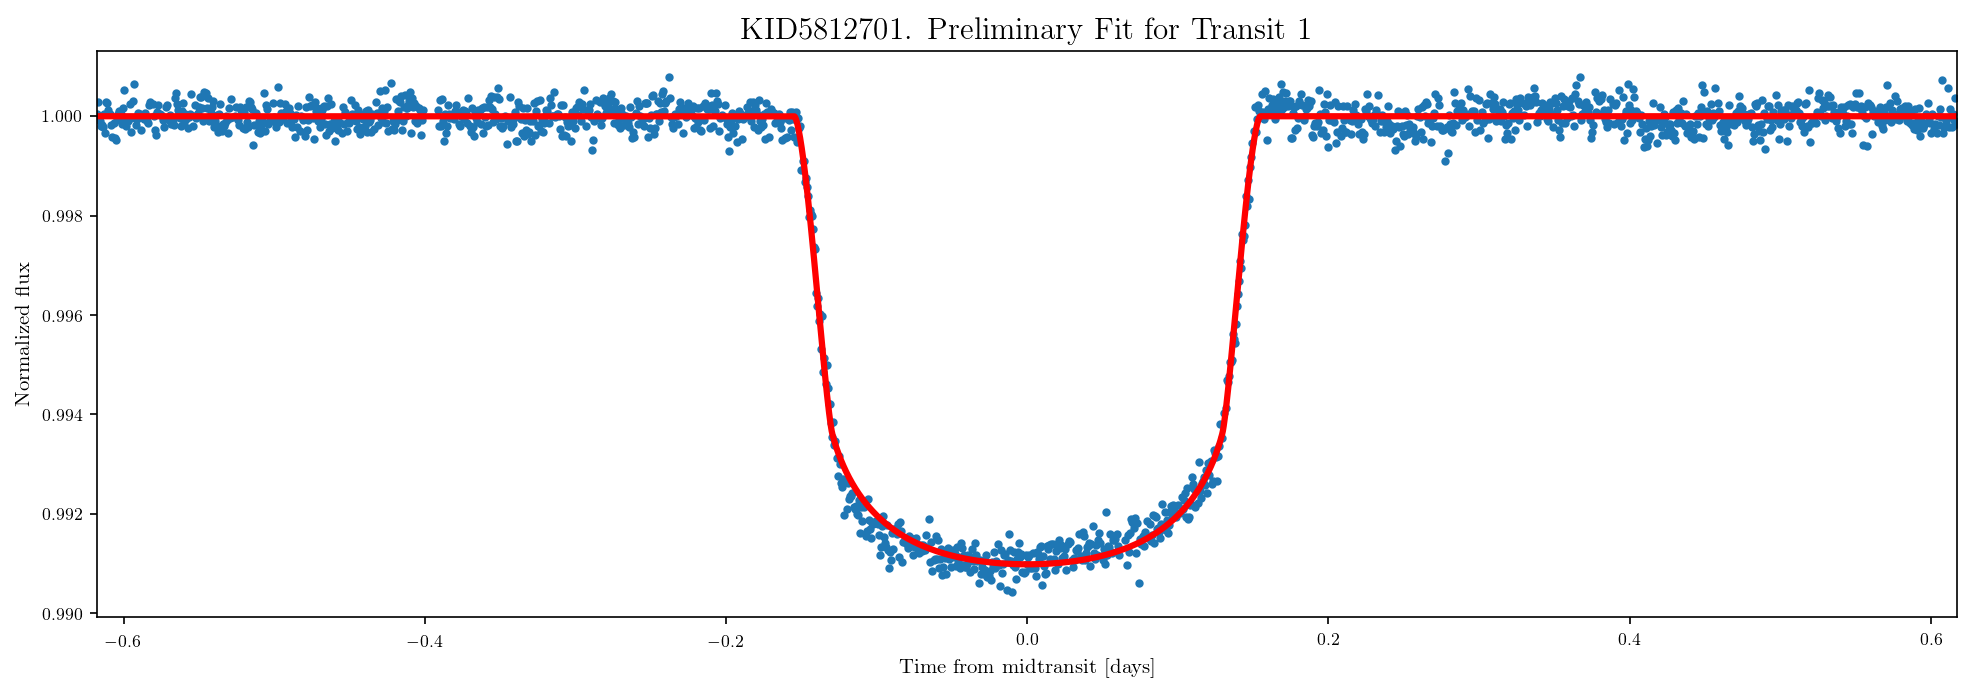

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.309	True=0.309
	Period [days]:	 Fit=15.20896102	True=17.85522168
	Impact Parameter:	 Fit=0.000000	True=0.075000
	Depth:	 Fit=0.007704	True=0.009065
	Stellar mass:	 Fit=1.392	True=1.386
	Stellar radius:	 Fit=1.693	True=1.683
	Sigma (white noise):	 Fit=0.00026
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.00000
Guess of Rp [in Rsun]: 0.14172
Max. allowed b (1+rp_guess/rs): 1.08369


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [09:31<00:00, 17.50it/s]


Multiprocessing took 583.8 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.058 (+0.056,-0.040)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.087 (+0.382,-0.403)

Period [d]:
	True = 17.855
	MCMC Fit = 15.664 (+1.496,-1.221)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0584 (+0.0016,-0.0017)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.680 (+0.040,-0.042)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.391 (+0.067,-0.066)

Mean acceptance fraction: 0.35 (34.74 %) 

*TRANSIT 5
	Signal = 0.00811. Noise (rms) = 0.00026. SNR = 31.47269
	Out-of-transit error of the transit LC = 0.00026

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990635
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12440.245959
         Iterations: 1778
         Function evaluations: 2645
Optimization terminated successfully.
         Current function value: -12501.046187
         Iterations: 1442
         Function evaluations: 2157


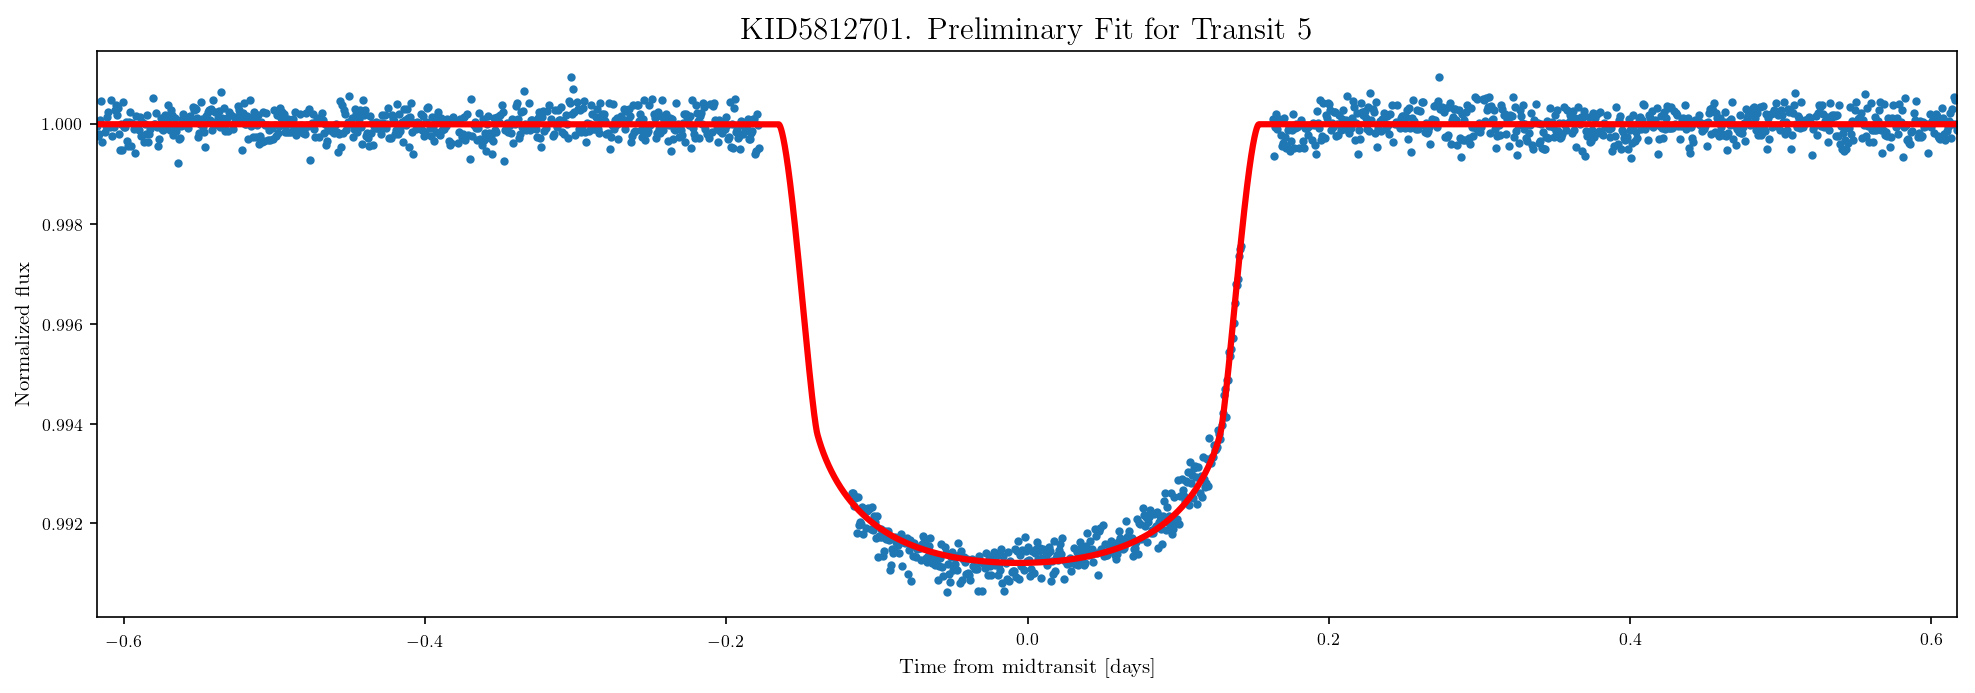

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.319	True=0.309
	Period [days]:	 Fit=13.50014394	True=17.85522168
	Impact Parameter:	 Fit=0.000000	True=0.075000
	Depth:	 Fit=0.007506	True=0.009065
	Stellar mass:	 Fit=1.371	True=1.386
	Stellar radius:	 Fit=1.808	True=1.683
	Sigma (white noise):	 Fit=0.00026
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.00000
Guess of Rp [in Rsun]: 0.14935
Max. allowed b (1+rp_guess/rs): 1.08261


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [07:48<00:00, 21.36it/s]


Multiprocessing took 476.8 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.247 (+0.091,-0.137)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.984 (+0.427,-0.430)

Period [d]:
	True = 17.855
	MCMC Fit = 20.730 (+2.961,-2.444)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0634 (+0.0020,-0.0019)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.685 (+0.044,-0.045)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.385 (+0.069,-0.070)

Mean acceptance fraction: 0.29 (29.20 %) 

*TRANSIT 6
	Signal = 0.00794. Noise (rms) = 0.00026. SNR = 31.15093
	Out-of-transit error of the transit LC = 0.00026

Min flux Folded LC = 0.989510
Min flux individual transit = 0.989993
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13263.229760
         Iterations: 2004
         Function evaluations: 2941
Optimization terminated successfully.
         Current function value: -13292.386006
         Iterations: 1105
         Function evaluations: 1608


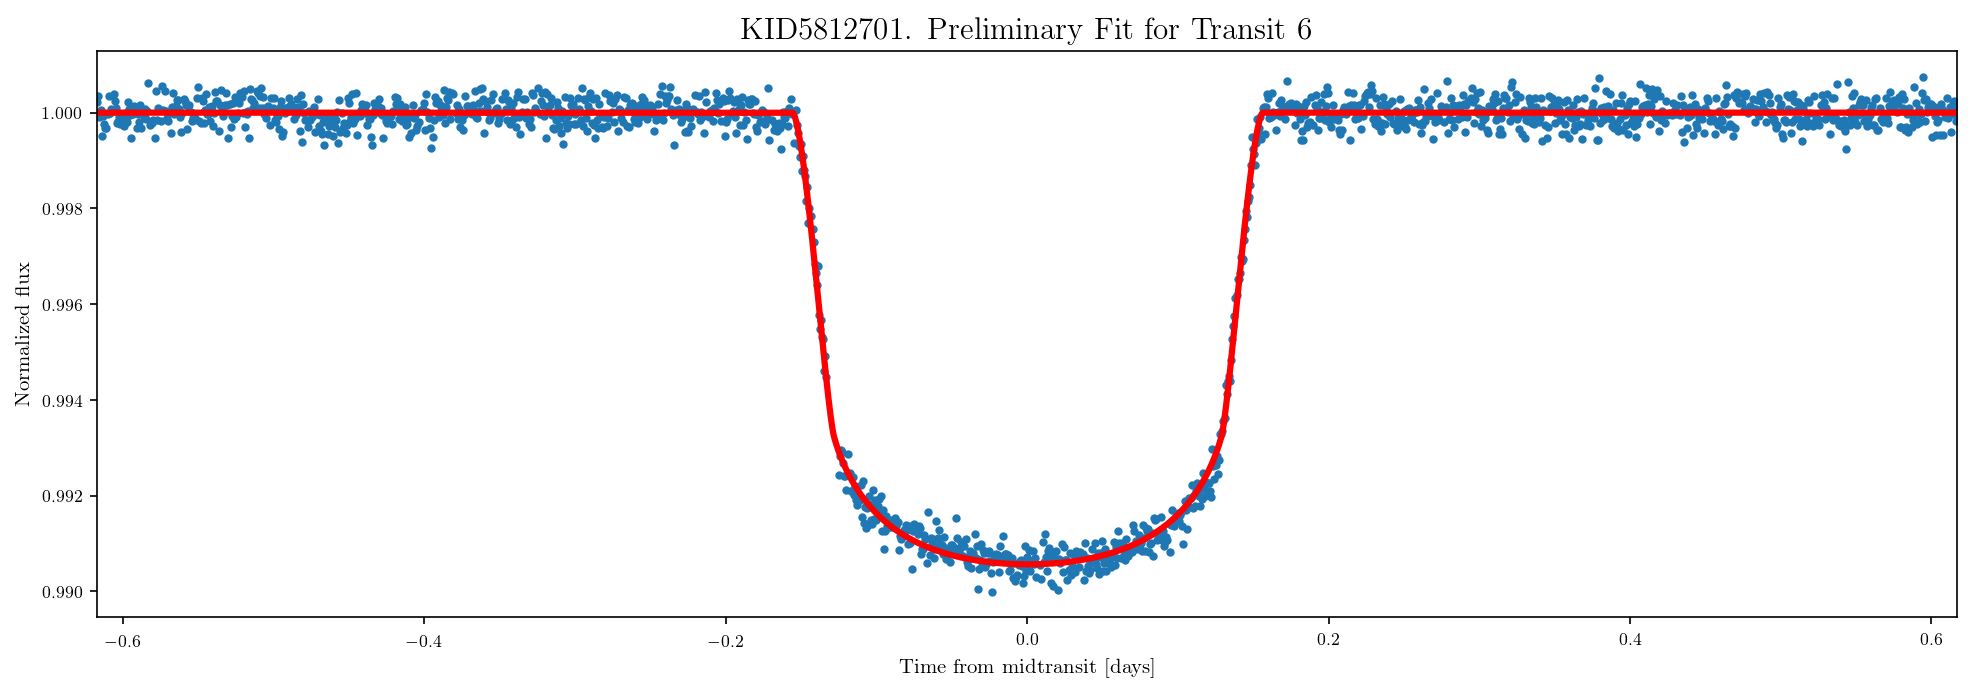

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.312	True=0.309
	Period [days]:	 Fit=16.76650619	True=17.85522168
	Impact Parameter:	 Fit=0.237630	True=0.075000
	Depth:	 Fit=0.008127	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00025
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.23763
Guess of Rp [in Rsun]: 0.14497
Max. allowed b (1+rp_guess/rs): 1.08595


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [10:28<00:00, 15.53it/s]


Multiprocessing took 641.1 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.229 (+0.043,-0.060)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.516 (+0.436,-0.441)

Period [d]:
	True = 17.855
	MCMC Fit = 16.834 (+1.797,-1.553)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0547 (+0.0017,-0.0017)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.681 (+0.044,-0.045)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.388 (+0.068,-0.069)

Mean acceptance fraction: 0.32 (31.72 %) 

*TRANSIT 7
	Signal = 0.00776. Noise (rms) = 0.00025. SNR = 30.46407
	Out-of-transit error of the transit LC = 0.00025

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990199
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13271.466147
         Iterations: 3724
         Function evaluations: 5468
Optimization terminated successfully.
         Current function value: -13340.290099
         Iterations: 618
         Function evaluations: 971


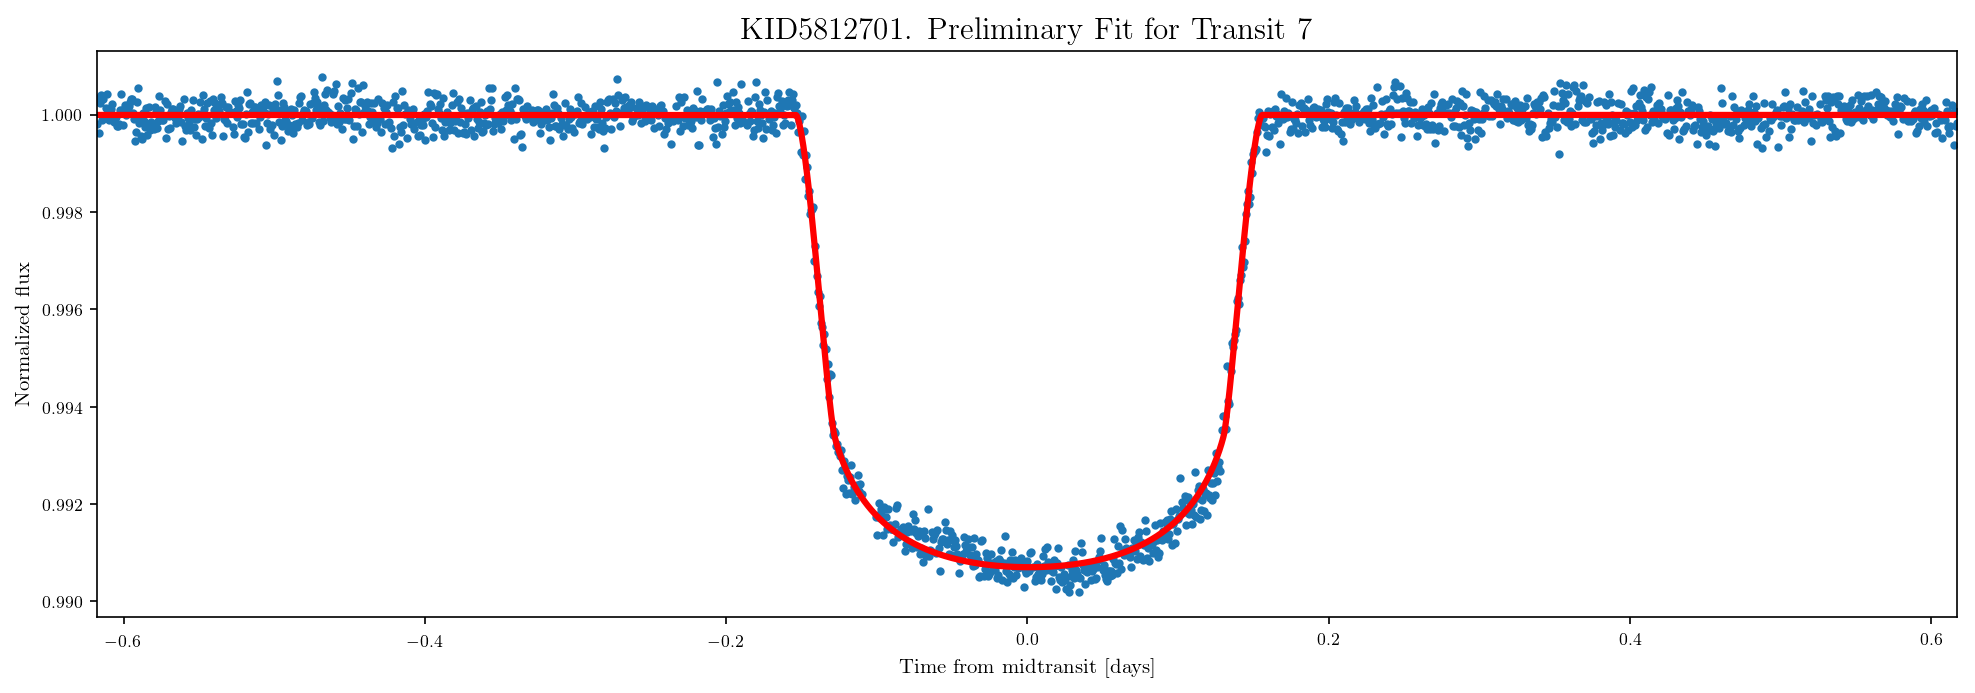

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.309	True=0.309
	Period [days]:	 Fit=13.50000065	True=17.85522168
	Impact Parameter:	 Fit=0.000000	True=0.075000
	Depth:	 Fit=0.007941	True=0.009065
	Stellar mass:	 Fit=1.072	True=1.386
	Stellar radius:	 Fit=1.614	True=1.683
	Sigma (white noise):	 Fit=0.00026
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.00000
Guess of Rp [in Rsun]: 0.13710
Max. allowed b (1+rp_guess/rs): 1.08497


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [11:53<00:00, 14.57it/s]


Multiprocessing took 728.1 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.166 (+0.070,-0.166)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.368 (+0.398,-0.415)

Period [d]:
	True = 17.855
	MCMC Fit = 16.110 (+1.672,-1.391)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0632 (+0.0018,-0.0019)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.681 (+0.041,-0.042)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.389 (+0.069,-0.067)

Mean acceptance fraction: 0.34 (34.13 %) 

*TRANSIT 8
	Signal = 0.00748. Noise (rms) = 0.00029. SNR = 25.59455
	Out-of-transit error of the transit LC = 0.00029

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990379
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13169.314141
         Iterations: 1865
         Function evaluations: 2765
Optimization terminated successfully.
         Current function value: -13229.069638
         Iterations: 1103
         Function evaluations: 1618


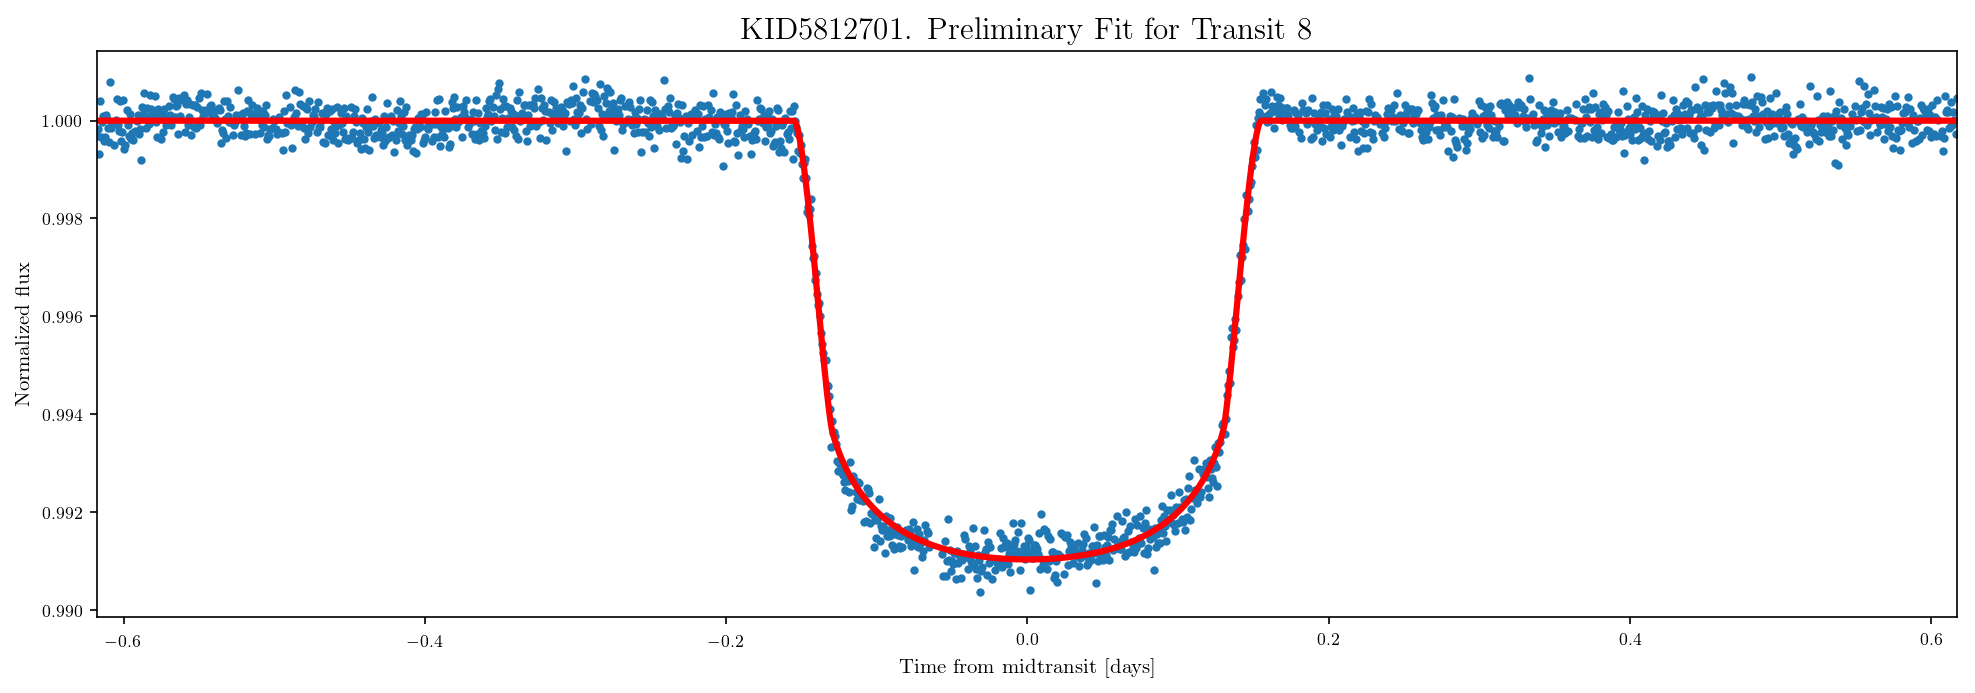

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.310	True=0.309
	Period [days]:	 Fit=15.41855492	True=17.85522168
	Impact Parameter:	 Fit=0.000000	True=0.075000
	Depth:	 Fit=0.007654	True=0.009065
	Stellar mass:	 Fit=1.384	True=1.386
	Stellar radius:	 Fit=1.685	True=1.683
	Sigma (white noise):	 Fit=0.00029
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.00000
Guess of Rp [in Rsun]: 0.14057
Max. allowed b (1+rp_guess/rs): 1.08342


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [11:25<00:00, 14.35it/s]


Multiprocessing took 699.5 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.128 (+0.071,-0.081)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.067 (+0.392,-0.417)

Period [d]:
	True = 17.855
	MCMC Fit = 16.050 (+1.623,-1.387)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0579 (+0.0017,-0.0018)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.681 (+0.041,-0.044)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.388 (+0.069,-0.067)

Mean acceptance fraction: 0.32 (31.59 %) 

*TRANSIT 9
	Signal = 0.00530. Noise (rms) = 0.00026. SNR = 20.78418
	Out-of-transit error of the transit LC = 0.00026

Min flux Folded LC = 0.989510
Min flux individual transit = 0.991080
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -10659.338225
         Iterations: 1431
         Function evaluations: 2133
Optimization terminated successfully.
         Current function value: -10679.554472
         Iterations: 2414
         Function evaluations: 3522


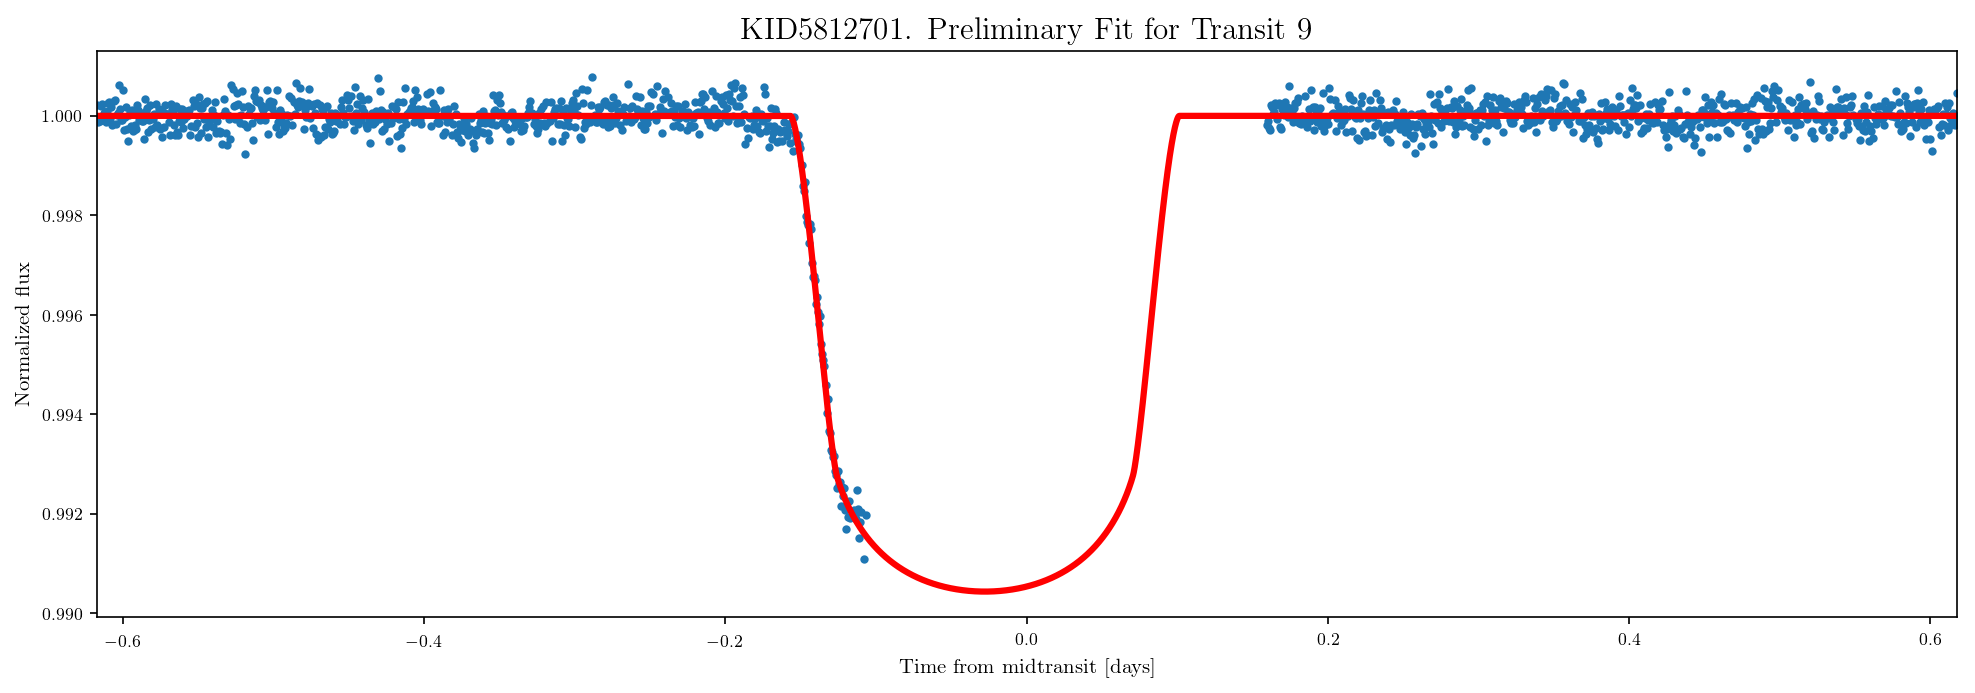

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.258	True=0.309
	Period [days]:	 Fit=13.50008274	True=17.85522168
	Impact Parameter:	 Fit=0.549426	True=0.075000
	Depth:	 Fit=0.008652	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00025
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.54943
Guess of Rp [in Rsun]: 0.14961
Max. allowed b (1+rp_guess/rs): 1.08869


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [07:29<00:00, 23.03it/s]


Multiprocessing took 457.7 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.009 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.430 (+0.087,-0.078)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.991 (+0.446,-0.446)

Period [d]:
	True = 17.855
	MCMC Fit = 17.026 (+2.619,-2.295)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0630 (+0.0020,-0.0019)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.678 (+0.044,-0.043)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.392 (+0.069,-0.071)

Mean acceptance fraction: 0.29 (29.18 %) 

*TRANSIT 10
	Signal = 0.00738. Noise (rms) = 0.00025. SNR = 29.41161
	Out-of-transit error of the transit LC = 0.00025

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990769
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13355.188308
         Iterations: 2697
         Function evaluations: 3979
Optimization terminated successfully.
         Current function value: -13368.632932
         Iterations: 1104
         Function evaluations: 1652


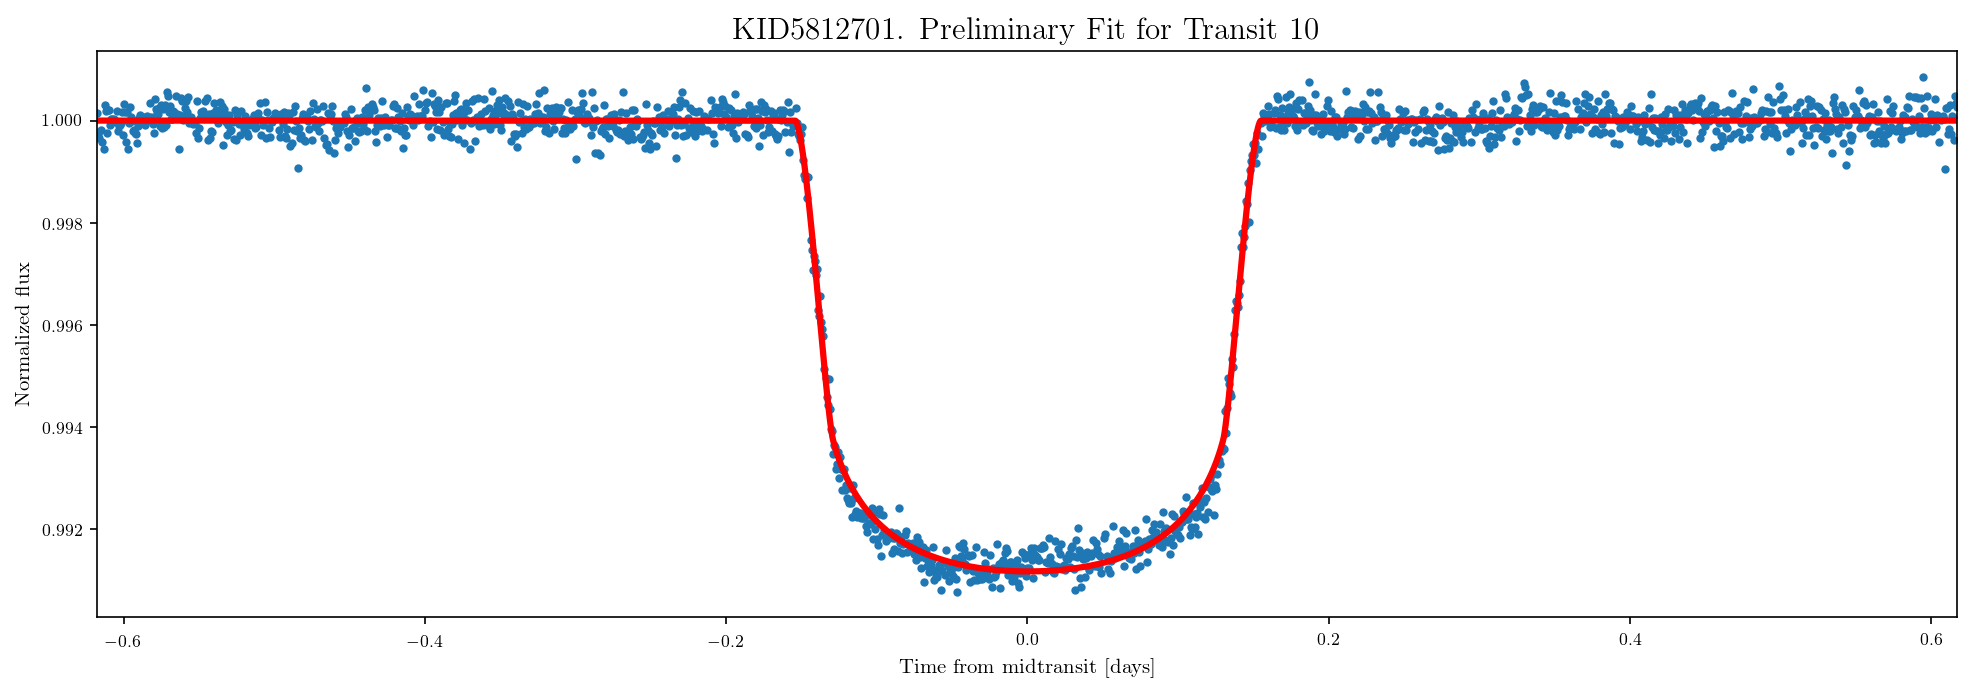

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.309	True=0.309
	Period [days]:	 Fit=25.31069856	True=17.85522168
	Impact Parameter:	 Fit=0.000000	True=0.075000
	Depth:	 Fit=0.007544	True=0.009065
	Stellar mass:	 Fit=1.505	True=1.386
	Stellar radius:	 Fit=1.467	True=1.683
	Sigma (white noise):	 Fit=0.00025
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.00000
Guess of Rp [in Rsun]: 0.12149
Max. allowed b (1+rp_guess/rs): 1.08282


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [11:05<00:00, 14.99it/s]


Multiprocessing took 680.7 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.057 (+0.056,-0.040)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.900 (+0.381,-0.402)

Period [d]:
	True = 17.855
	MCMC Fit = 15.711 (+1.466,-1.236)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0415 (+0.0011,-0.0012)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.678 (+0.040,-0.042)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.391 (+0.067,-0.065)

Mean acceptance fraction: 0.35 (34.92 %) 

*TRANSIT 11
	Signal = 0.00748. Noise (rms) = 0.00027. SNR = 28.14515
	Out-of-transit error of the transit LC = 0.00027

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990467
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13380.465530
         Iterations: 2085
         Function evaluations: 3103
Optimization terminated successfully.
         Current function value: -13404.245642
         Iterations: 1206
         Function evaluations: 1771


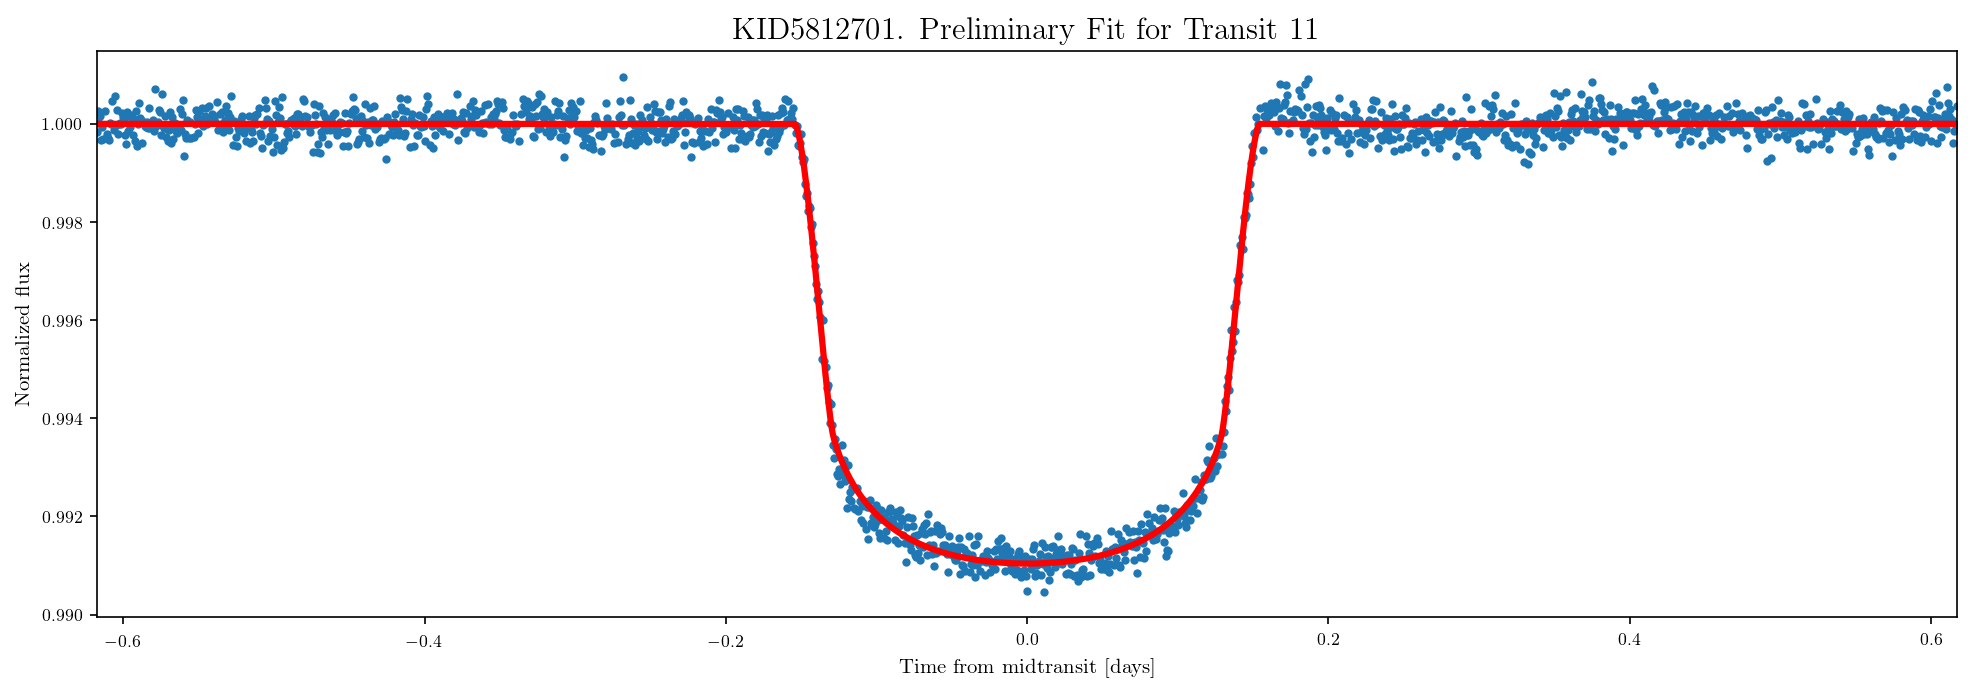

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.309	True=0.309
	Period [days]:	 Fit=15.54259420	True=17.85522168
	Impact Parameter:	 Fit=0.130766	True=0.075000
	Depth:	 Fit=0.007671	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.686	True=1.683
	Sigma (white noise):	 Fit=0.00026
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.13077
Guess of Rp [in Rsun]: 0.14084
Max. allowed b (1+rp_guess/rs): 1.08351


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [11:19<00:00, 13.66it/s]


Multiprocessing took 693.4 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.117 (+0.067,-0.075)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.024 (+0.404,-0.418)

Period [d]:
	True = 17.855
	MCMC Fit = 15.810 (+1.635,-1.320)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0575 (+0.0016,-0.0018)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.678 (+0.042,-0.044)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.391 (+0.068,-0.067)

Mean acceptance fraction: 0.30 (30.18 %) 

*TRANSIT 12
	Signal = 0.00770. Noise (rms) = 0.00025. SNR = 31.22290
	Out-of-transit error of the transit LC = 0.00025

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990287
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13255.762420
         Iterations: 1455
         Function evaluations: 2157
Optimization terminated successfully.
         Current function value: -13283.126397
         Iterations: 857
         Function evaluations: 1267


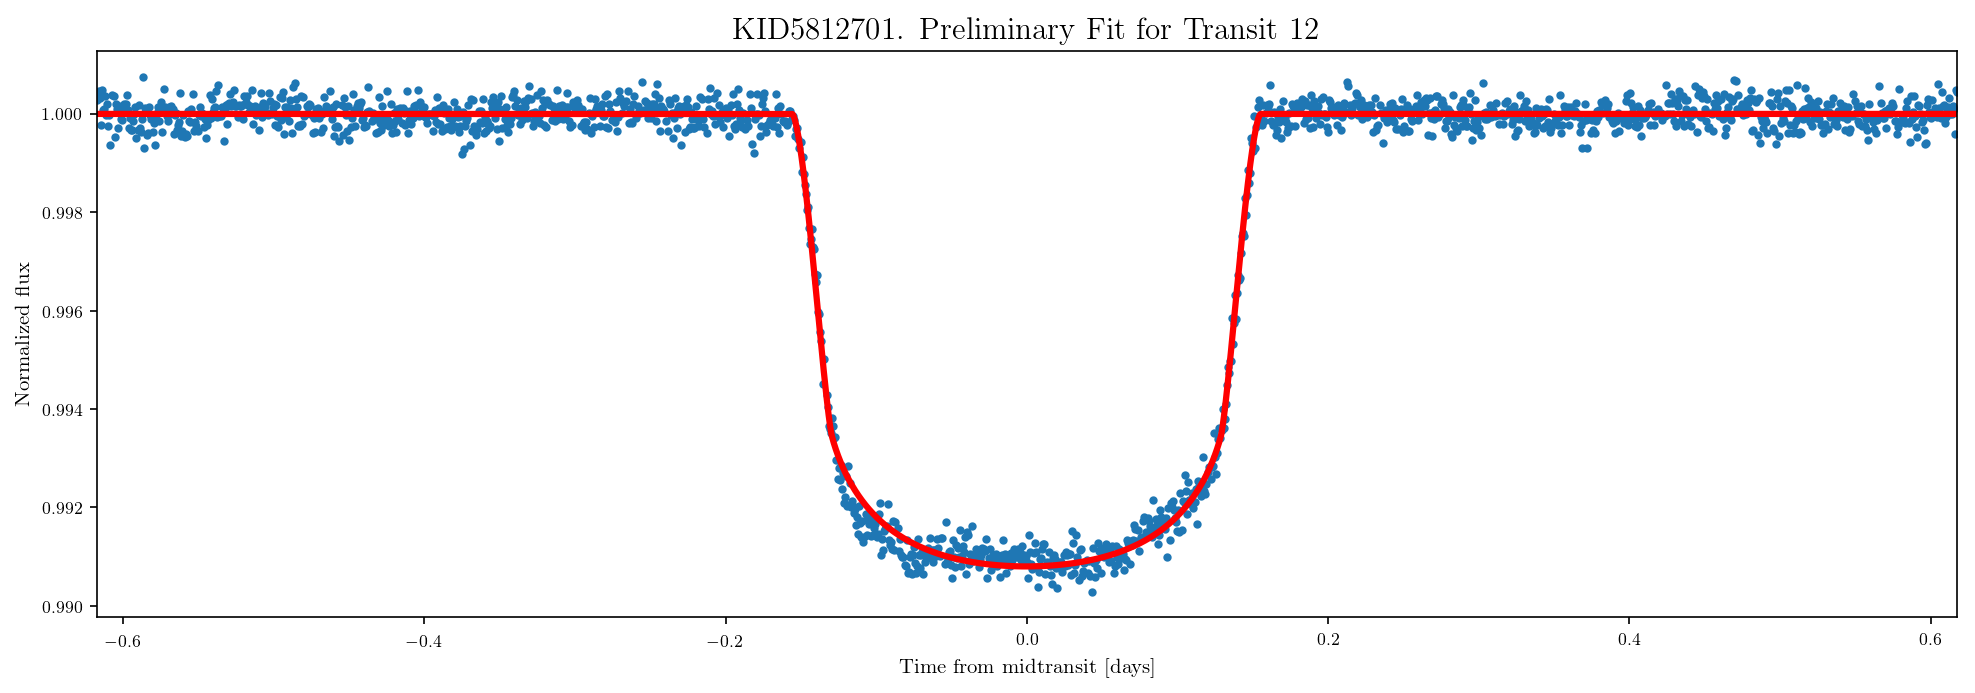

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.311	True=0.309
	Period [days]:	 Fit=13.50000227	True=17.85522168
	Impact Parameter:	 Fit=0.183408	True=0.075000
	Depth:	 Fit=0.007895	True=0.009065
	Stellar mass:	 Fit=1.364	True=1.386
	Stellar radius:	 Fit=1.782	True=1.683
	Sigma (white noise):	 Fit=0.00026
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.18341
Guess of Rp [in Rsun]: 0.15099
Max. allowed b (1+rp_guess/rs): 1.08472


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [10:56<00:00, 15.73it/s]


Multiprocessing took 668.9 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.089 (+0.067,-0.060)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.246 (+0.398,-0.413)

Period [d]:
	True = 17.855
	MCMC Fit = 15.895 (+1.555,-1.337)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0632 (+0.0018,-0.0019)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.680 (+0.041,-0.043)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.392 (+0.067,-0.068)

Mean acceptance fraction: 0.32 (31.71 %) 

*TRANSIT 13
	Signal = 0.00789. Noise (rms) = 0.00026. SNR = 30.32407
	Out-of-transit error of the transit LC = 0.00026

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990120
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -9565.745664
         Iterations: 2230
         Function evaluations: 3257
Optimization terminated successfully.
         Current function value: -9581.121572
         Iterations: 1167
         Function evaluations: 1738


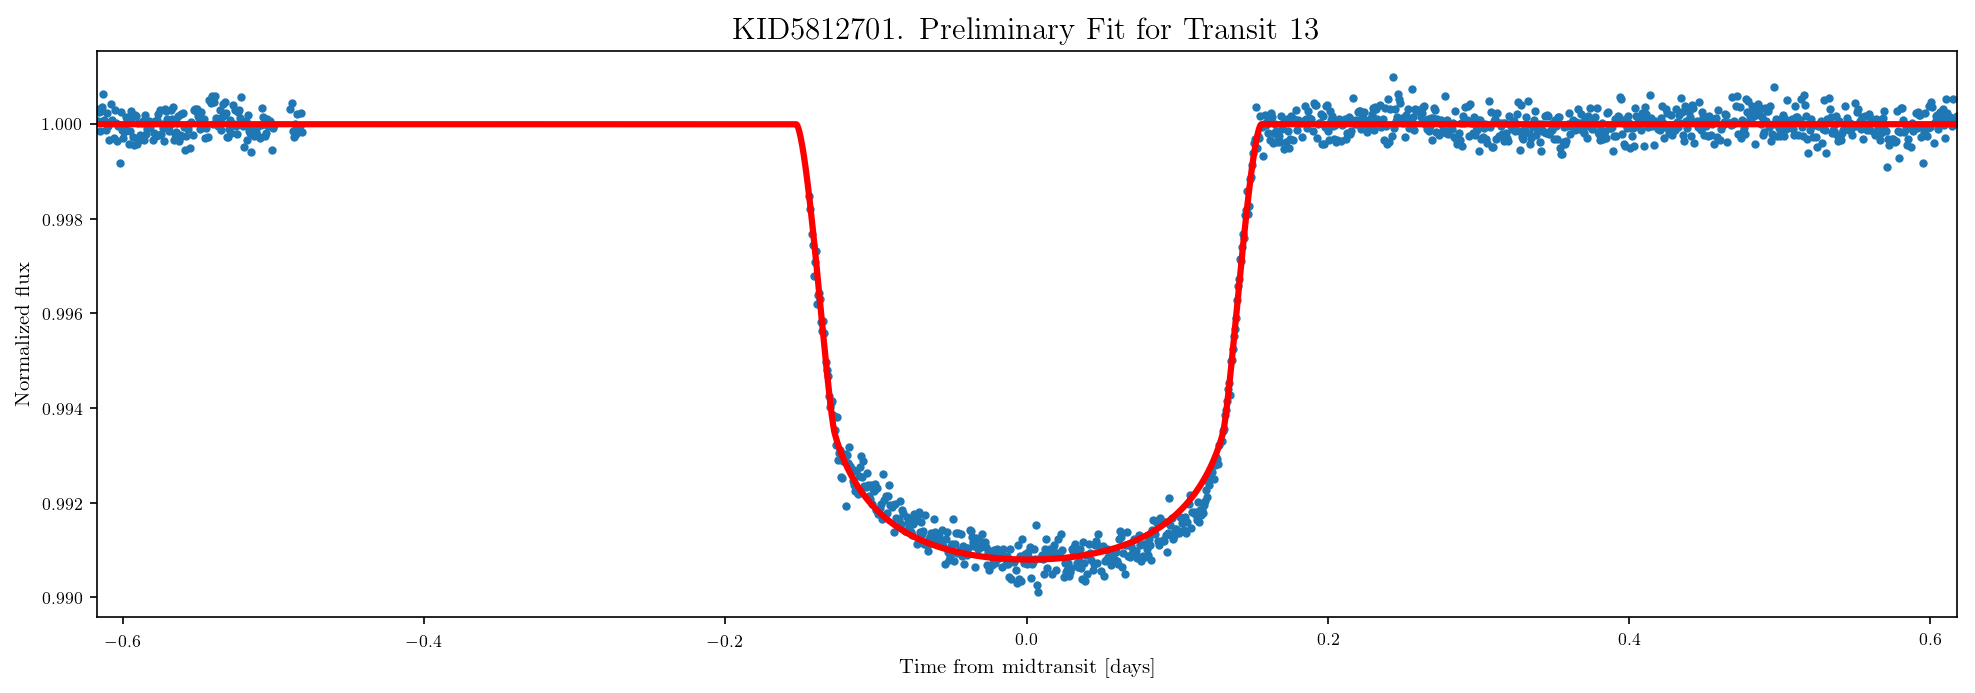

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.309	True=0.309
	Period [days]:	 Fit=15.27788183	True=17.85522168
	Impact Parameter:	 Fit=0.078769	True=0.075000
	Depth:	 Fit=0.007867	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00027
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.07877
Guess of Rp [in Rsun]: 0.14264
Max. allowed b (1+rp_guess/rs): 1.08457


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [09:31<00:00, 17.50it/s]


Multiprocessing took 583.1 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.100 (+0.075,-0.068)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.259 (+0.394,-0.415)

Period [d]:
	True = 17.855
	MCMC Fit = 15.744 (+1.519,-1.273)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0582 (+0.0016,-0.0017)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.680 (+0.041,-0.043)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.393 (+0.067,-0.066)

Mean acceptance fraction: 0.31 (31.16 %) 

*TRANSIT 14
	Signal = 0.00764. Noise (rms) = 0.00025. SNR = 31.03215
	Out-of-transit error of the transit LC = 0.00025

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990215
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13349.486757
         Iterations: 2427
         Function evaluations: 3593
Optimization terminated successfully.
         Current function value: -13426.344267
         Iterations: 1017
         Function evaluations: 1503


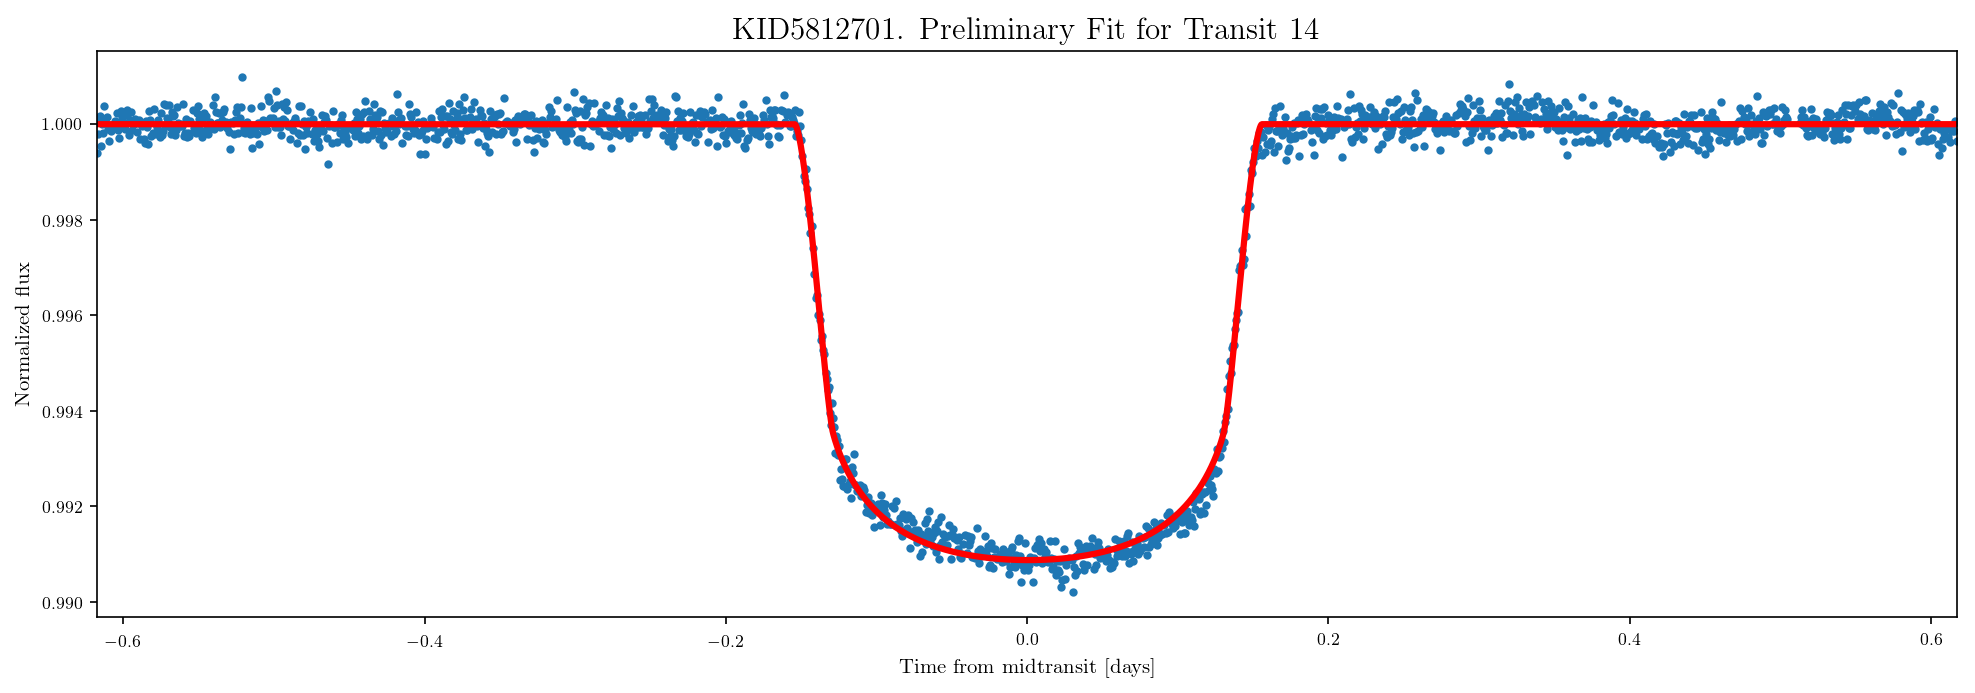

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.310	True=0.309
	Period [days]:	 Fit=15.36458866	True=17.85522168
	Impact Parameter:	 Fit=0.000000	True=0.075000
	Depth:	 Fit=0.007792	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00025
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.00000
Guess of Rp [in Rsun]: 0.14196
Max. allowed b (1+rp_guess/rs): 1.08416


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [11:17<00:00, 11.95it/s]


Multiprocessing took 691.7 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.126 (+0.066,-0.083)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.205 (+0.394,-0.418)

Period [d]:
	True = 17.855
	MCMC Fit = 16.023 (+1.563,-1.339)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0580 (+0.0017,-0.0017)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.681 (+0.040,-0.043)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.388 (+0.068,-0.067)

Mean acceptance fraction: 0.31 (31.45 %) 

*TRANSIT 15
	Signal = 0.00752. Noise (rms) = 0.00024. SNR = 31.69498
	Out-of-transit error of the transit LC = 0.00024

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990117
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12630.317314
         Iterations: 1654
         Function evaluations: 2493
Optimization terminated successfully.
         Current function value: -12745.906508
         Iterations: 1686
         Function evaluations: 2489


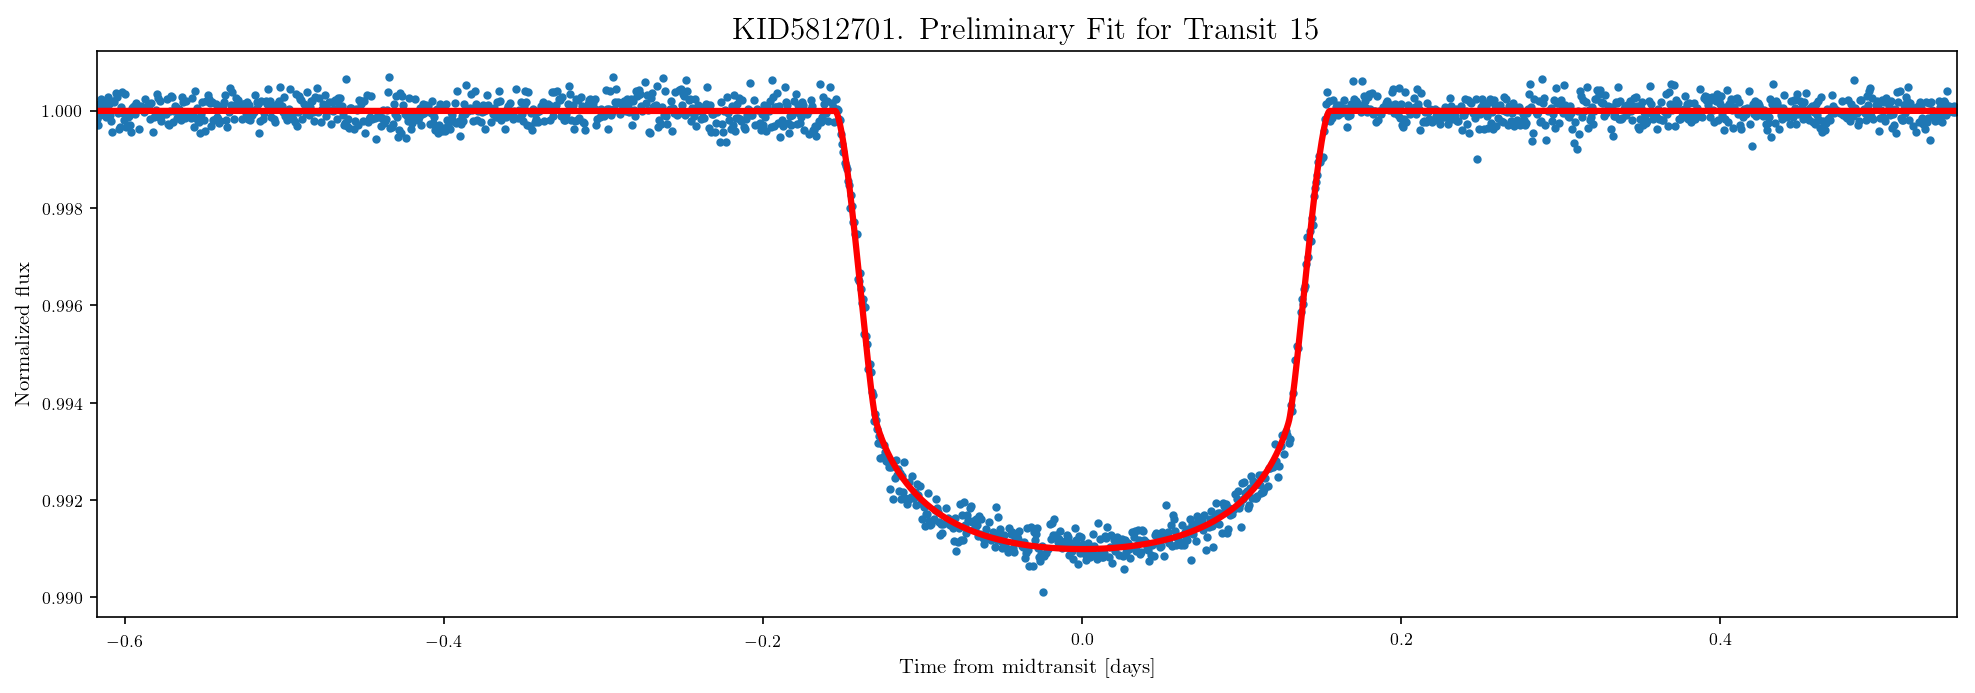

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.310	True=0.309
	Period [days]:	 Fit=15.66818721	True=17.85522168
	Impact Parameter:	 Fit=0.125258	True=0.075000
	Depth:	 Fit=0.007710	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00024
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.12526
Guess of Rp [in Rsun]: 0.14123
Max. allowed b (1+rp_guess/rs): 1.08372


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [10:32<00:00, 14.73it/s]


Multiprocessing took 645.7 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.114 (+0.063,-0.070)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.086 (+0.399,-0.414)

Period [d]:
	True = 17.855
	MCMC Fit = 15.919 (+1.582,-1.327)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0572 (+0.0016,-0.0017)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.680 (+0.042,-0.043)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.390 (+0.068,-0.066)

Mean acceptance fraction: 0.30 (30.41 %) 

*TRANSIT 16
	Signal = 0.00784. Noise (rms) = 0.00023. SNR = 33.47744
	Out-of-transit error of the transit LC = 0.00023

Min flux Folded LC = 0.989510
Min flux individual transit = 0.989870
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065
Optimization terminated successfully.
         Current function value: -9743.839376
         Ite

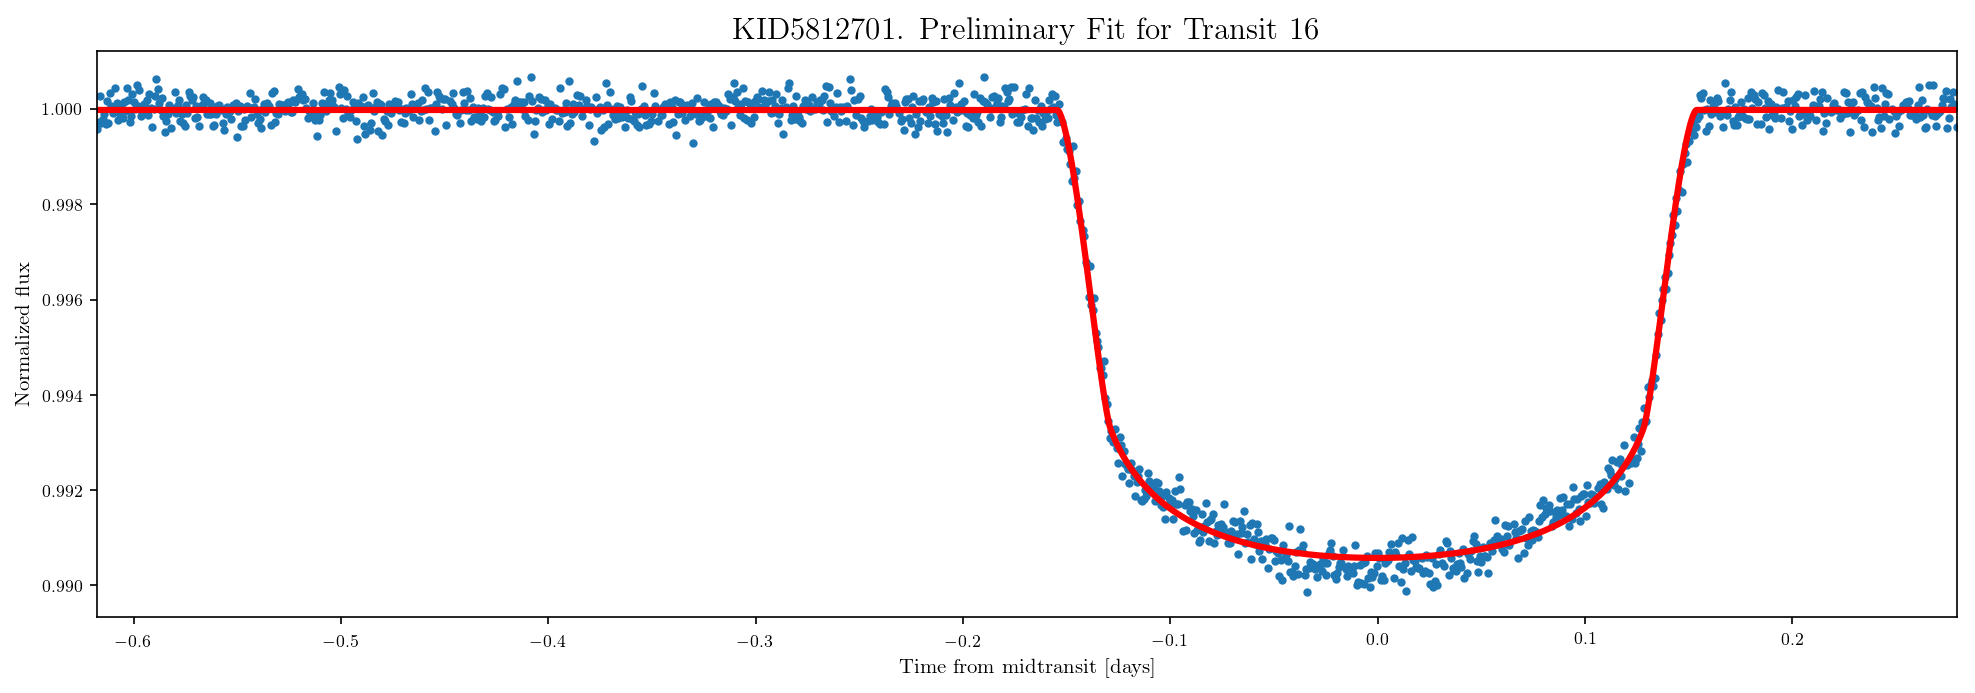

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.308	True=0.309
	Period [days]:	 Fit=40.99841950	True=17.85522168
	Impact Parameter:	 Fit=0.000000	True=0.075000
	Depth:	 Fit=0.008031	True=0.009065
	Stellar mass:	 Fit=1.671	True=1.386
	Stellar radius:	 Fit=1.287	True=1.683
	Sigma (white noise):	 Fit=0.00026
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.00000
Guess of Rp [in Rsun]: 0.10998
Max. allowed b (1+rp_guess/rs): 1.08545


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [10:40<00:00, 15.59it/s]


Multiprocessing took 653.6 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.307 (+0.028,-0.047)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.610 (+0.441,-0.478)

Period [d]:
	True = 17.855
	MCMC Fit = 17.554 (+2.024,-1.825)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0302 (+0.0009,-0.0010)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.683 (+0.045,-0.048)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.388 (+0.072,-0.068)

Mean acceptance fraction: 0.31 (31.26 %) 

*TRANSIT 17
	Signal = 0.00760. Noise (rms) = 0.00025. SNR = 30.13805
	Out-of-transit error of the transit LC = 0.00025

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990431
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13526.315648
         Iterations: 1705
         Function evaluations: 2519
Optimization terminated successfully.
         Current function value: -13528.675564
         Iterations: 867
         Function evaluations: 1285


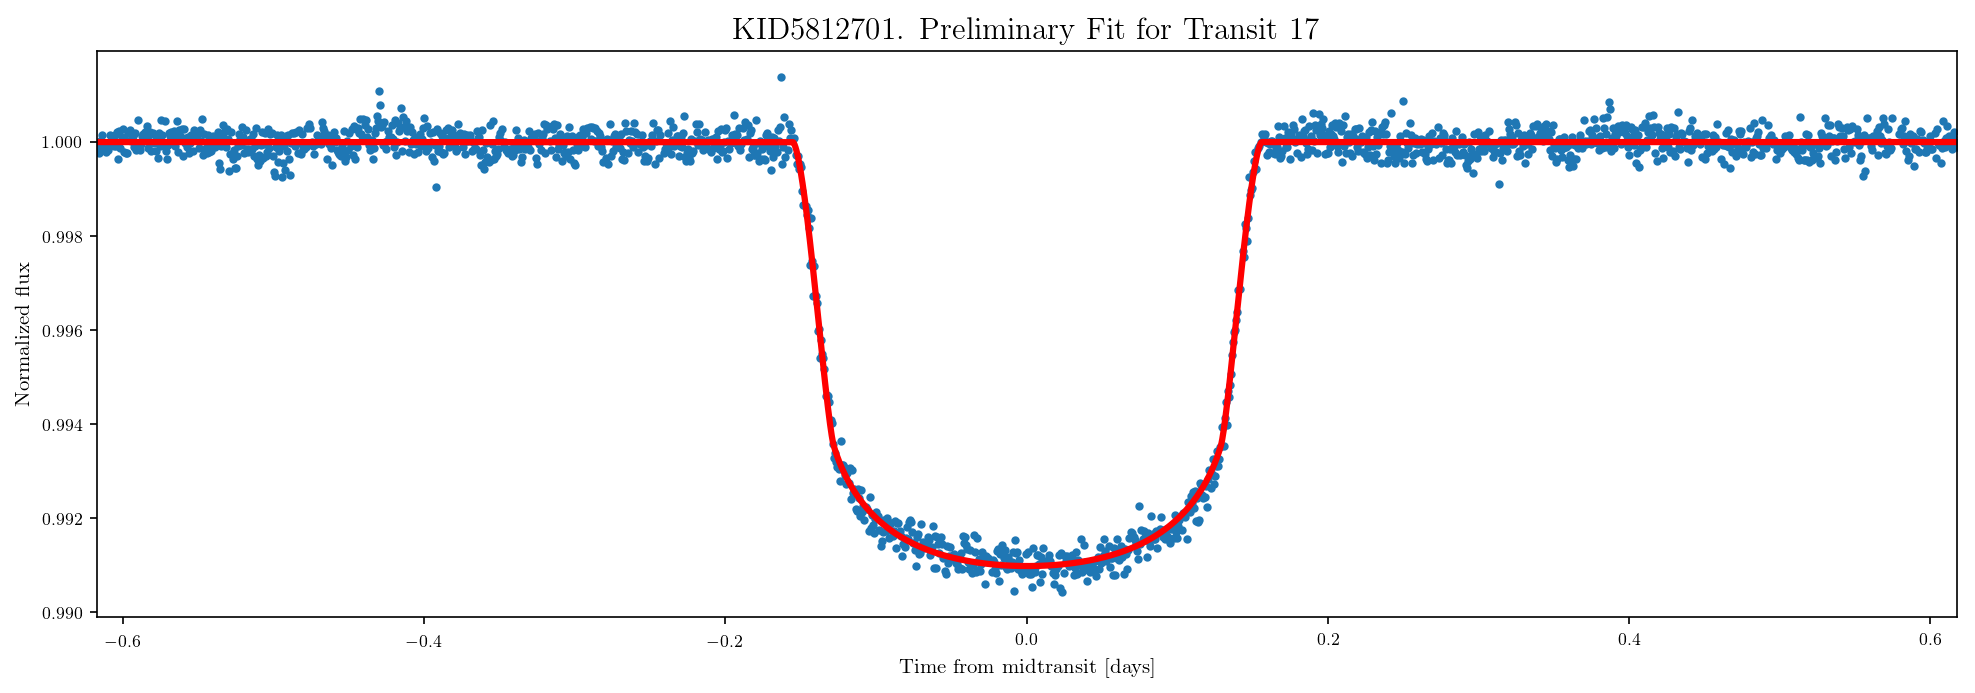

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.311	True=0.309
	Period [days]:	 Fit=16.91248923	True=17.85522168
	Impact Parameter:	 Fit=0.253576	True=0.075000
	Depth:	 Fit=0.007781	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00025
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.25358
Guess of Rp [in Rsun]: 0.14186
Max. allowed b (1+rp_guess/rs): 1.08411


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [11:54<00:00, 14.65it/s]


Multiprocessing took 728.3 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.248 (+0.038,-0.048)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.196 (+0.428,-0.447)

Period [d]:
	True = 17.855
	MCMC Fit = 16.928 (+1.857,-1.628)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0545 (+0.0017,-0.0018)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.684 (+0.045,-0.047)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.387 (+0.068,-0.068)

Mean acceptance fraction: 0.33 (33.16 %) 

*TRANSIT 18
	Signal = 0.00802. Noise (rms) = 0.00024. SNR = 32.82708
	Out-of-transit error of the transit LC = 0.00024

Min flux Folded LC = 0.989510
Min flux individual transit = 0.989767
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13490.902173
         Iterations: 1433
         Function evaluations: 2130
Optimization terminated successfully.
         Current function value: -13564.848020
         Iterations: 1499
         Function evaluations: 2252


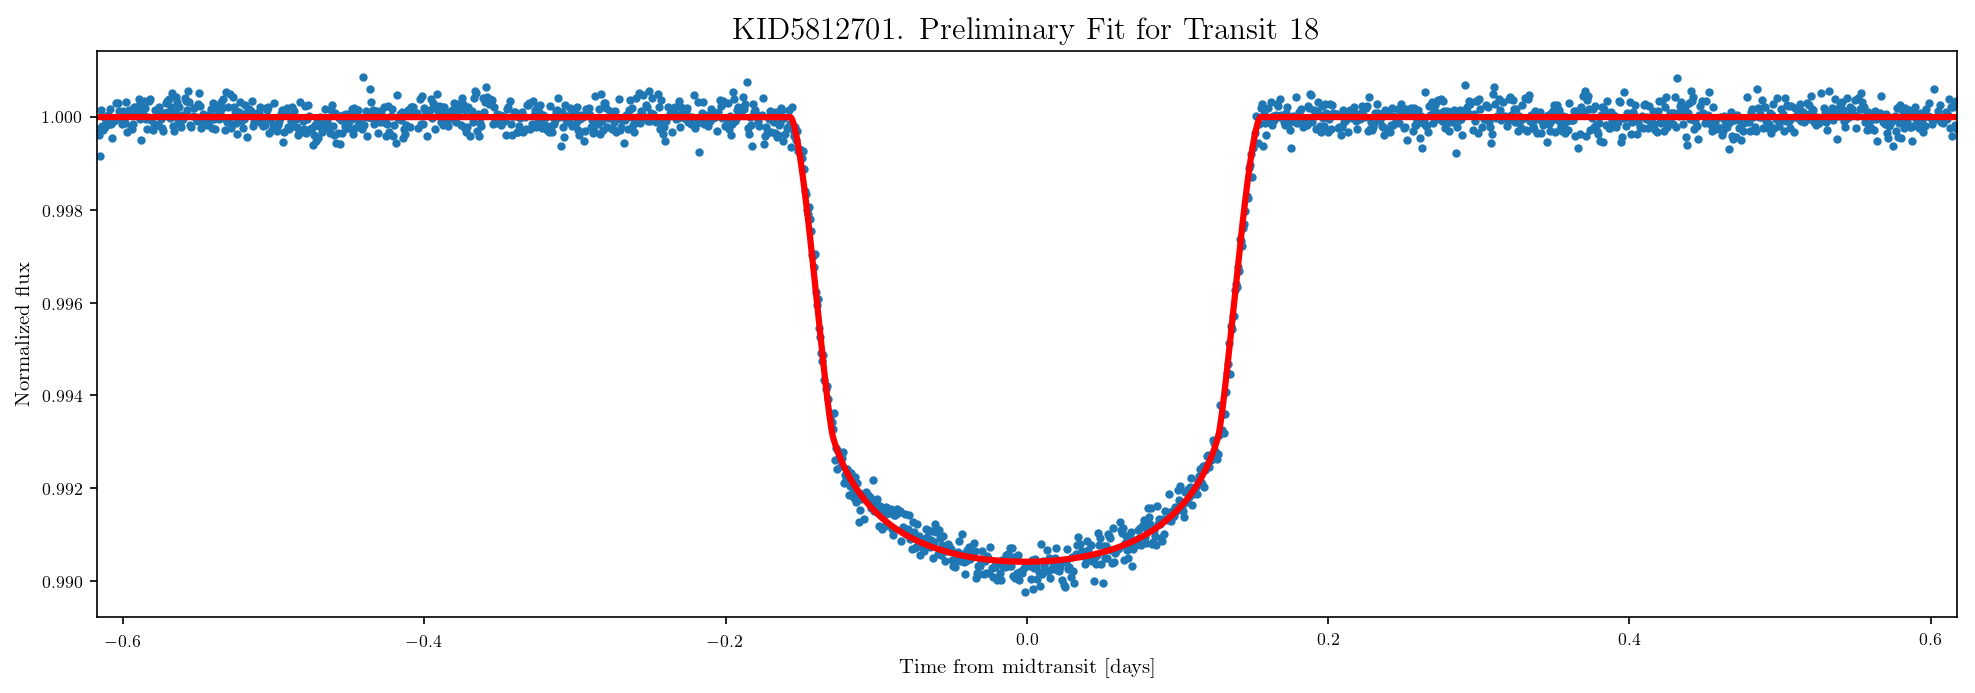

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.312	True=0.309
	Period [days]:	 Fit=47.61331145	True=17.85522168
	Impact Parameter:	 Fit=0.282318	True=0.075000
	Depth:	 Fit=0.008290	True=0.009065
	Stellar mass:	 Fit=1.727	True=1.386
	Stellar radius:	 Fit=1.296	True=1.683
	Sigma (white noise):	 Fit=0.00025
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.28232
Guess of Rp [in Rsun]: 0.11250
Max. allowed b (1+rp_guess/rs): 1.08681


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [11:37<00:00, 14.54it/s]


Multiprocessing took 711.4 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.287 (+0.029,-0.033)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.717 (+0.440,-0.454)

Period [d]:
	True = 17.855
	MCMC Fit = 17.503 (+1.858,-1.662)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0273 (+0.0009,-0.0009)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.683 (+0.044,-0.046)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.389 (+0.070,-0.070)

Mean acceptance fraction: 0.35 (35.41 %) 

*TRANSIT 23
	Signal = 0.00771. Noise (rms) = 0.00025. SNR = 30.43880
	Out-of-transit error of the transit LC = 0.00025

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990128
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13280.427289
         Iterations: 1470
         Function evaluations: 2172
Optimization terminated successfully.
         Current function value: -13298.096230
         Iterations: 1024
         Function evaluations: 1490


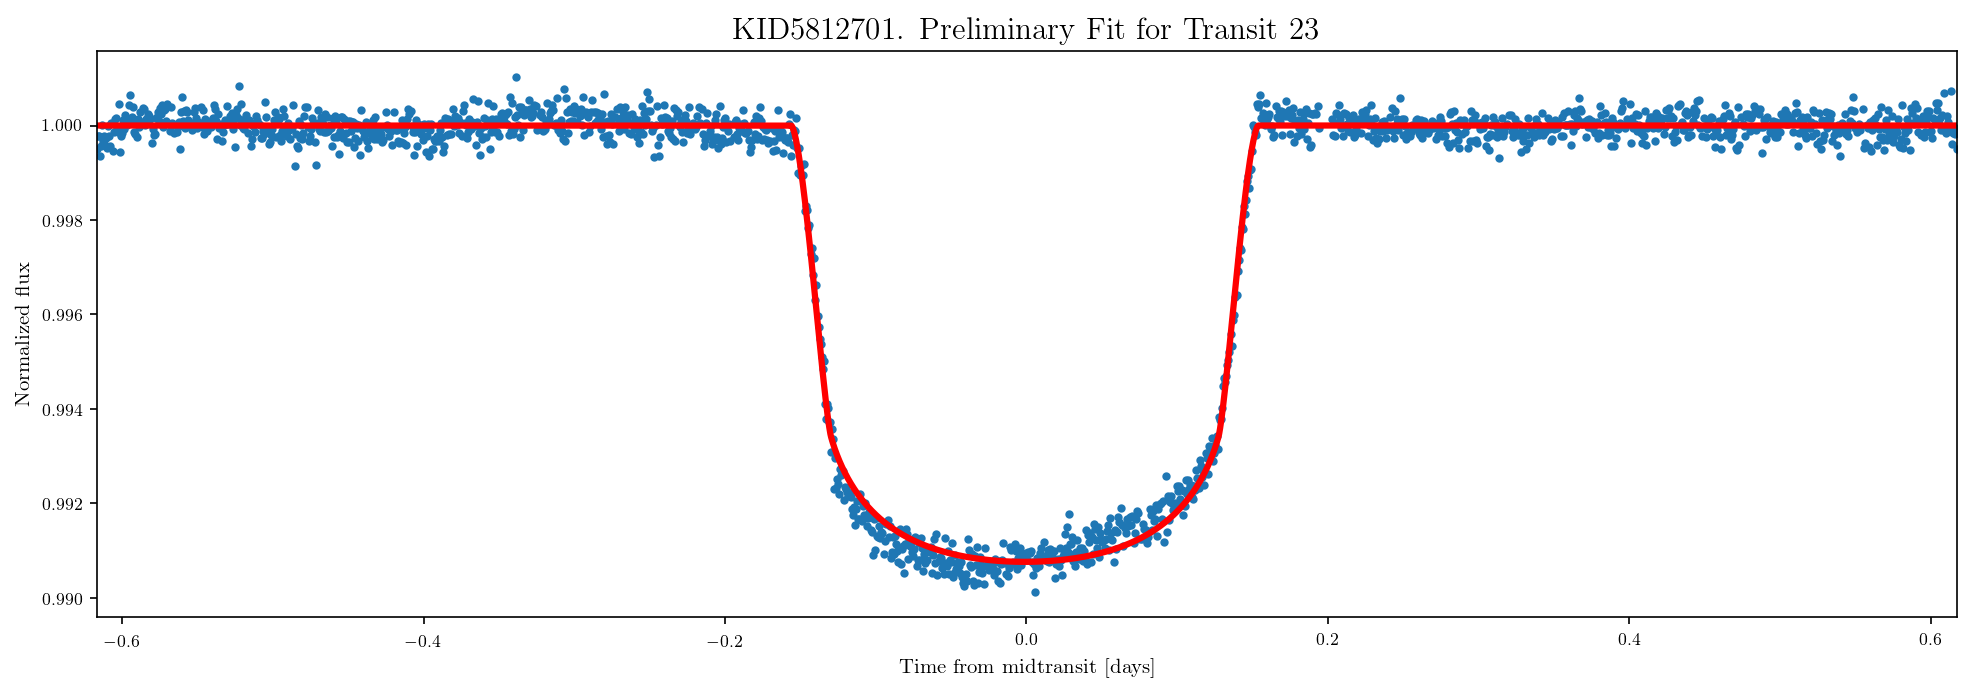

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.310	True=0.309
	Period [days]:	 Fit=16.03202216	True=17.85522168
	Impact Parameter:	 Fit=0.187554	True=0.075000
	Depth:	 Fit=0.007933	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00027
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.18755
Guess of Rp [in Rsun]: 0.14323
Max. allowed b (1+rp_guess/rs): 1.08492


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [10:47<00:00, 15.87it/s]


Multiprocessing took 660.8 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.167 (+0.059,-0.083)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.323 (+0.401,-0.439)

Period [d]:
	True = 17.855
	MCMC Fit = 16.088 (+1.700,-1.421)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0564 (+0.0016,-0.0017)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.682 (+0.041,-0.045)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.389 (+0.069,-0.068)

Mean acceptance fraction: 0.30 (30.18 %) 

*TRANSIT 25
	Signal = 0.00747. Noise (rms) = 0.00025. SNR = 29.38513
	Out-of-transit error of the transit LC = 0.00025

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990518
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13405.447575
         Iterations: 1542
         Function evaluations: 2290
Optimization terminated successfully.
         Current function value: -13481.324482
         Iterations: 2034
         Function evaluations: 2963


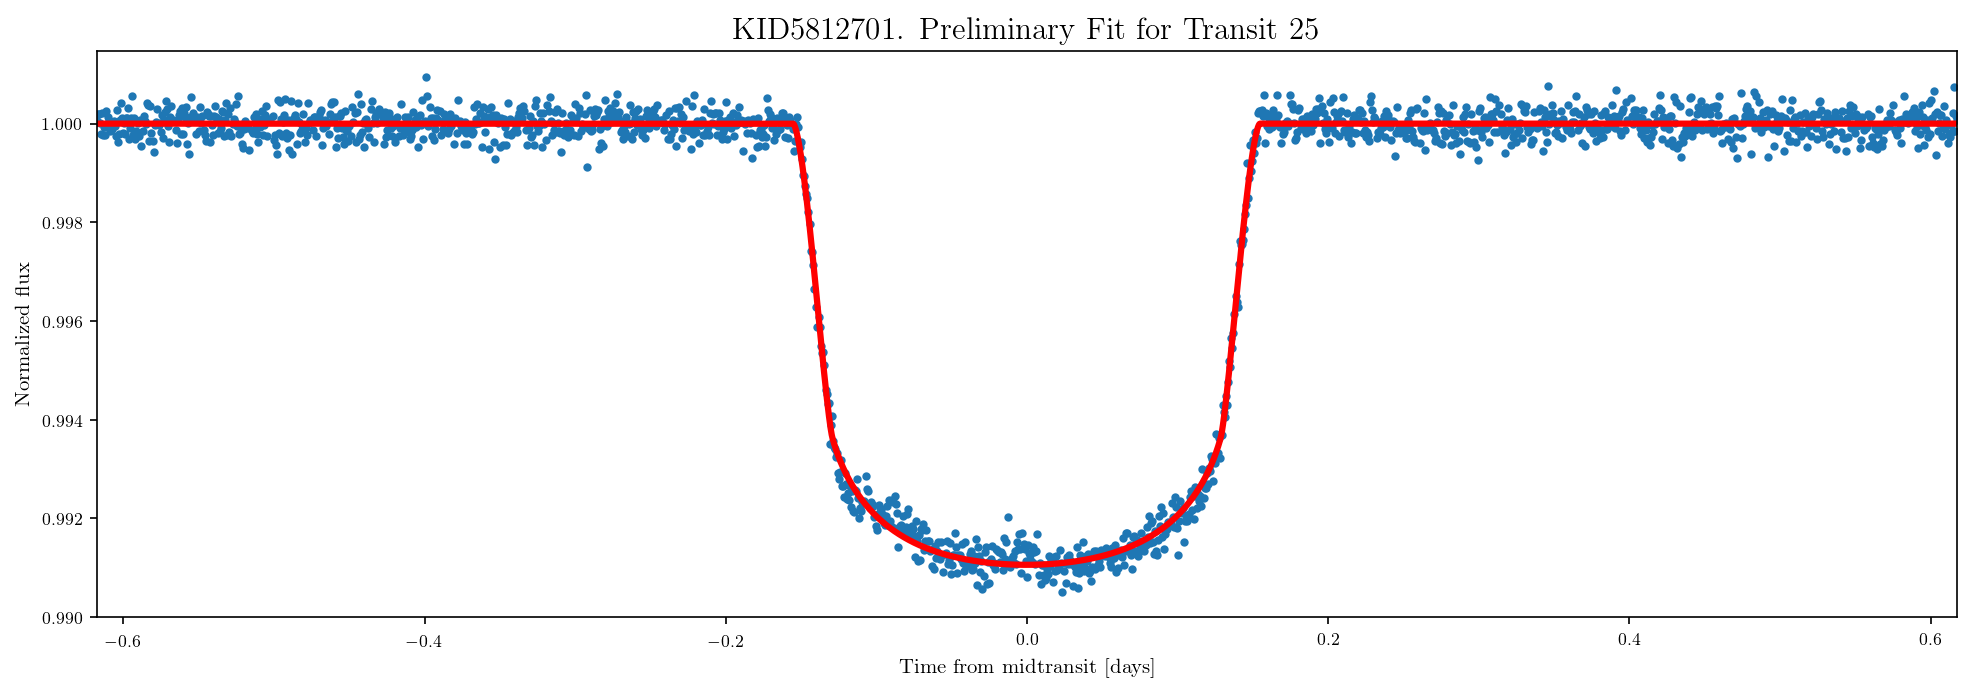

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.310	True=0.309
	Period [days]:	 Fit=40.74612700	True=17.85522168
	Impact Parameter:	 Fit=0.186006	True=0.075000
	Depth:	 Fit=0.007672	True=0.009065
	Stellar mass:	 Fit=1.642	True=1.386
	Stellar radius:	 Fit=1.311	True=1.683
	Sigma (white noise):	 Fit=0.00026
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.18601
Guess of Rp [in Rsun]: 0.10946
Max. allowed b (1+rp_guess/rs): 1.08352


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [10:28<00:00, 16.35it/s]


Multiprocessing took 642.4 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.121 (+0.068,-0.077)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.016 (+0.393,-0.434)

Period [d]:
	True = 17.855
	MCMC Fit = 15.925 (+1.701,-1.340)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0303 (+0.0009,-0.0010)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.680 (+0.041,-0.045)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.392 (+0.068,-0.068)

Mean acceptance fraction: 0.30 (29.88 %) 

*TRANSIT 26
	Signal = 0.00763. Noise (rms) = 0.00026. SNR = 29.72497
	Out-of-transit error of the transit LC = 0.00026

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990148
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13240.453124
         Iterations: 1804
         Function evaluations: 2663
Optimization terminated successfully.
         Current function value: -13246.386761
         Iterations: 905
         Function evaluations: 1327


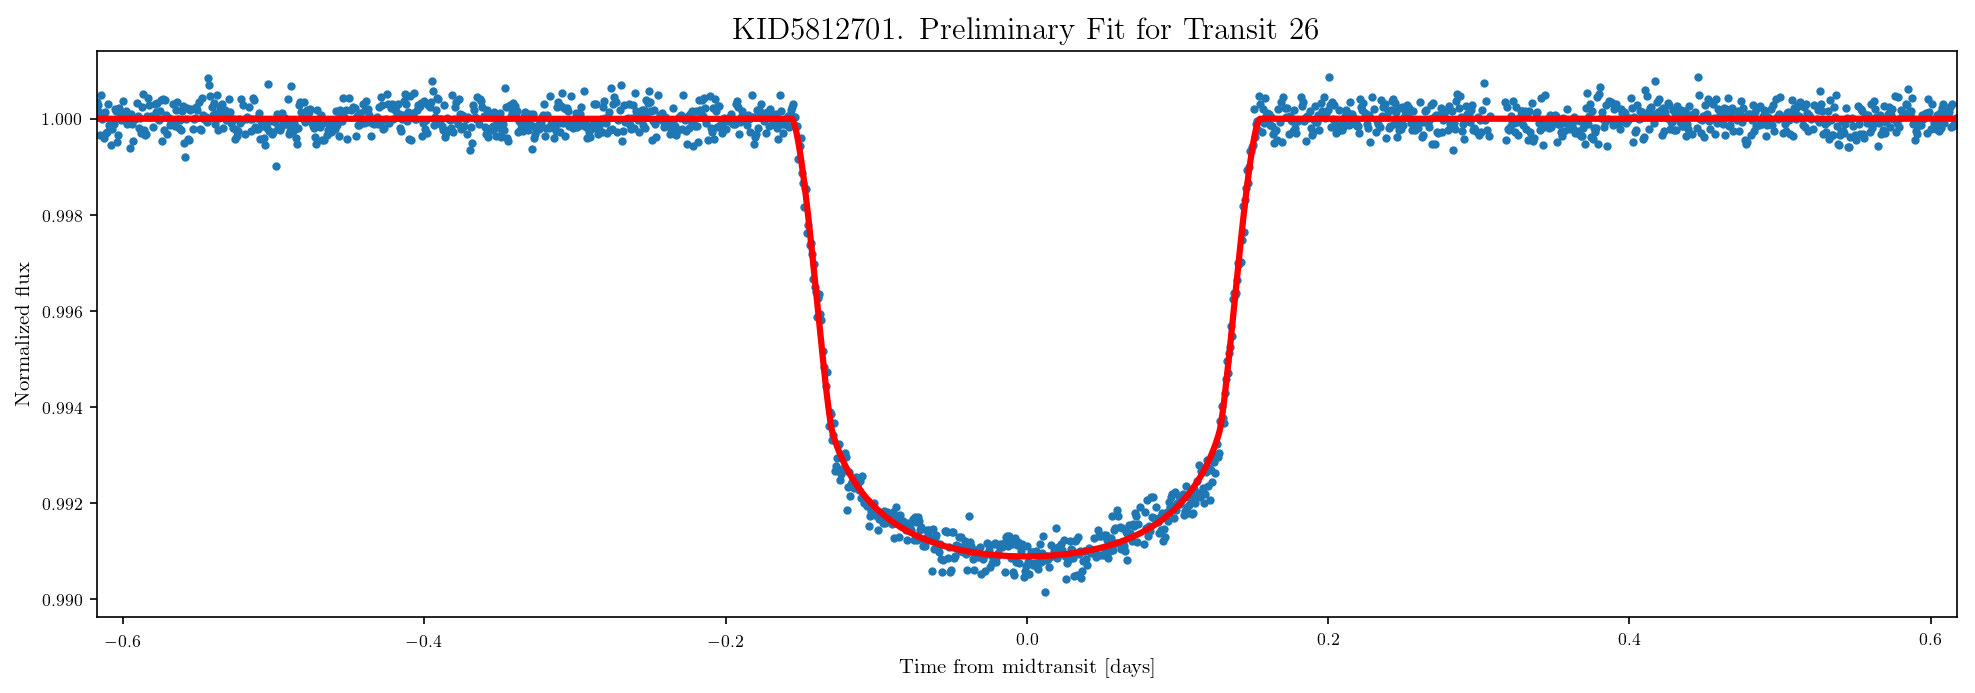

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.311	True=0.309
	Period [days]:	 Fit=16.63507966	True=17.85522168
	Impact Parameter:	 Fit=0.235370	True=0.075000
	Depth:	 Fit=0.007852	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.686	True=1.683
	Sigma (white noise):	 Fit=0.00026
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.23537
Guess of Rp [in Rsun]: 0.14248
Max. allowed b (1+rp_guess/rs): 1.08449


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [10:13<00:00, 16.30it/s]


Multiprocessing took 627.4 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.228 (+0.039,-0.050)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.225 (+0.427,-0.429)

Period [d]:
	True = 17.855
	MCMC Fit = 16.751 (+1.751,-1.515)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0550 (+0.0017,-0.0017)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.680 (+0.044,-0.044)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.388 (+0.069,-0.069)

Mean acceptance fraction: 0.34 (34.13 %) 

*TRANSIT 27
	Signal = 0.00810. Noise (rms) = 0.00025. SNR = 31.84615
	Out-of-transit error of the transit LC = 0.00025

Min flux Folded LC = 0.989510
Min flux individual transit = 0.989764
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13307.606457
         Iterations: 1408
         Function evaluations: 2108
Optimization terminated successfully.
         Current function value: -13412.536804
         Iterations: 1768
         Function evaluations: 2571


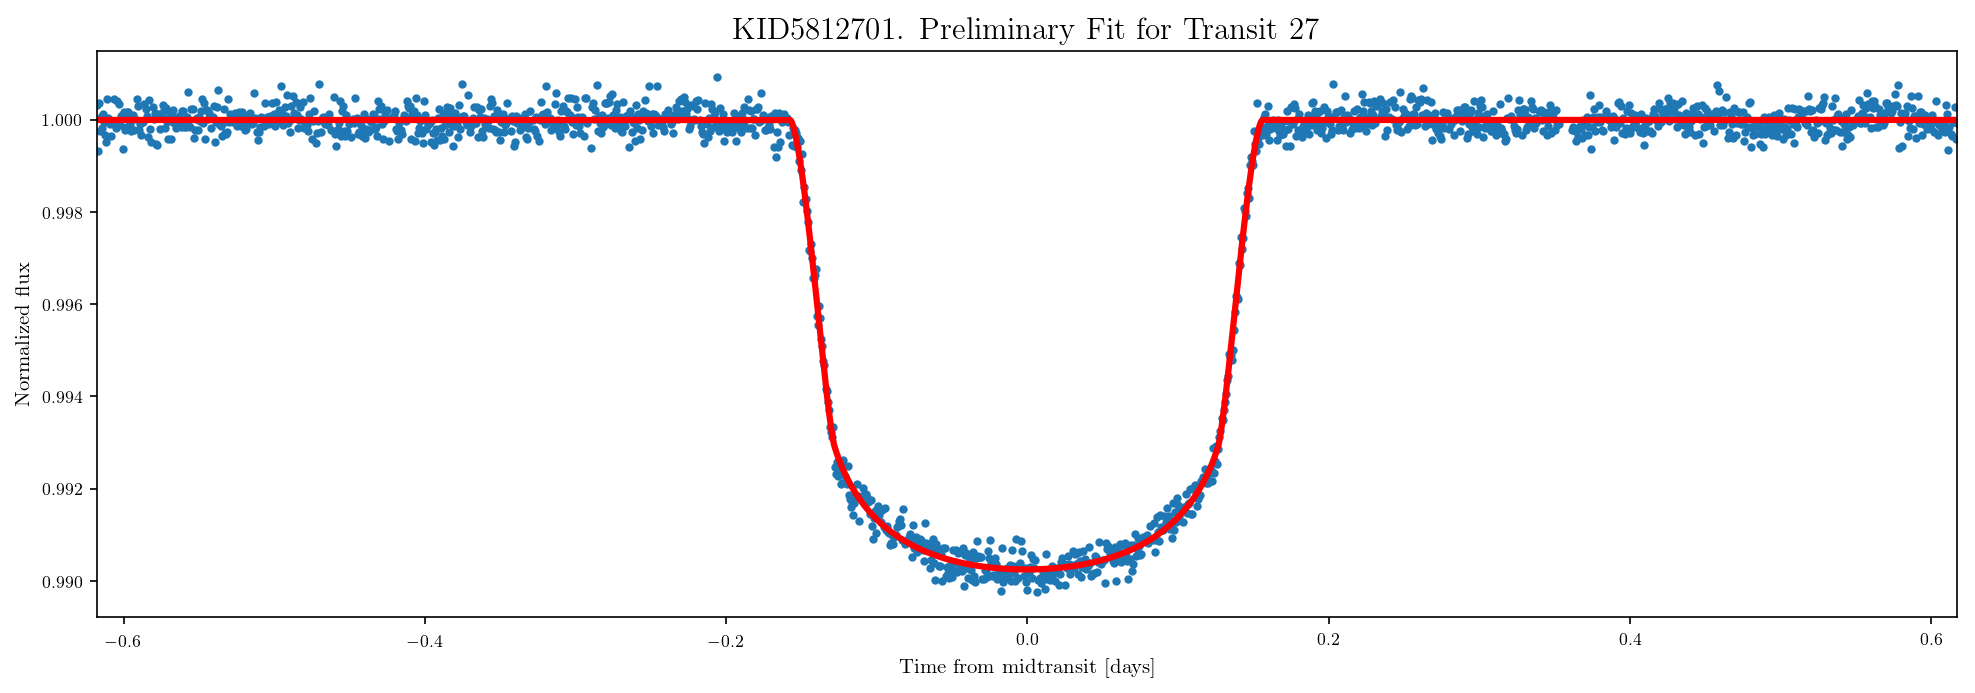

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.313	True=0.309
	Period [days]:	 Fit=17.93925287	True=17.85522168
	Impact Parameter:	 Fit=0.316091	True=0.075000
	Depth:	 Fit=0.008461	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00025
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.31609
Guess of Rp [in Rsun]: 0.14795
Max. allowed b (1+rp_guess/rs): 1.08770


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [10:46<00:00, 15.26it/s]


Multiprocessing took 659.2 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.314 (+0.025,-0.029)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.889 (+0.447,-0.445)

Period [d]:
	True = 17.855
	MCMC Fit = 18.003 (+1.887,-1.696)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0525 (+0.0016,-0.0016)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.684 (+0.045,-0.044)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.384 (+0.069,-0.068)

Mean acceptance fraction: 0.36 (36.06 %) 

*TRANSIT 28
	Signal = 0.00817. Noise (rms) = 0.00025. SNR = 32.89739
	Out-of-transit error of the transit LC = 0.00025

Min flux Folded LC = 0.989510
Min flux individual transit = 0.989544
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13389.357968
         Iterations: 2450
         Function evaluations: 3584
Optimization terminated successfully.
         Current function value: -13390.021710
         Iterations: 604
         Function evaluations: 925


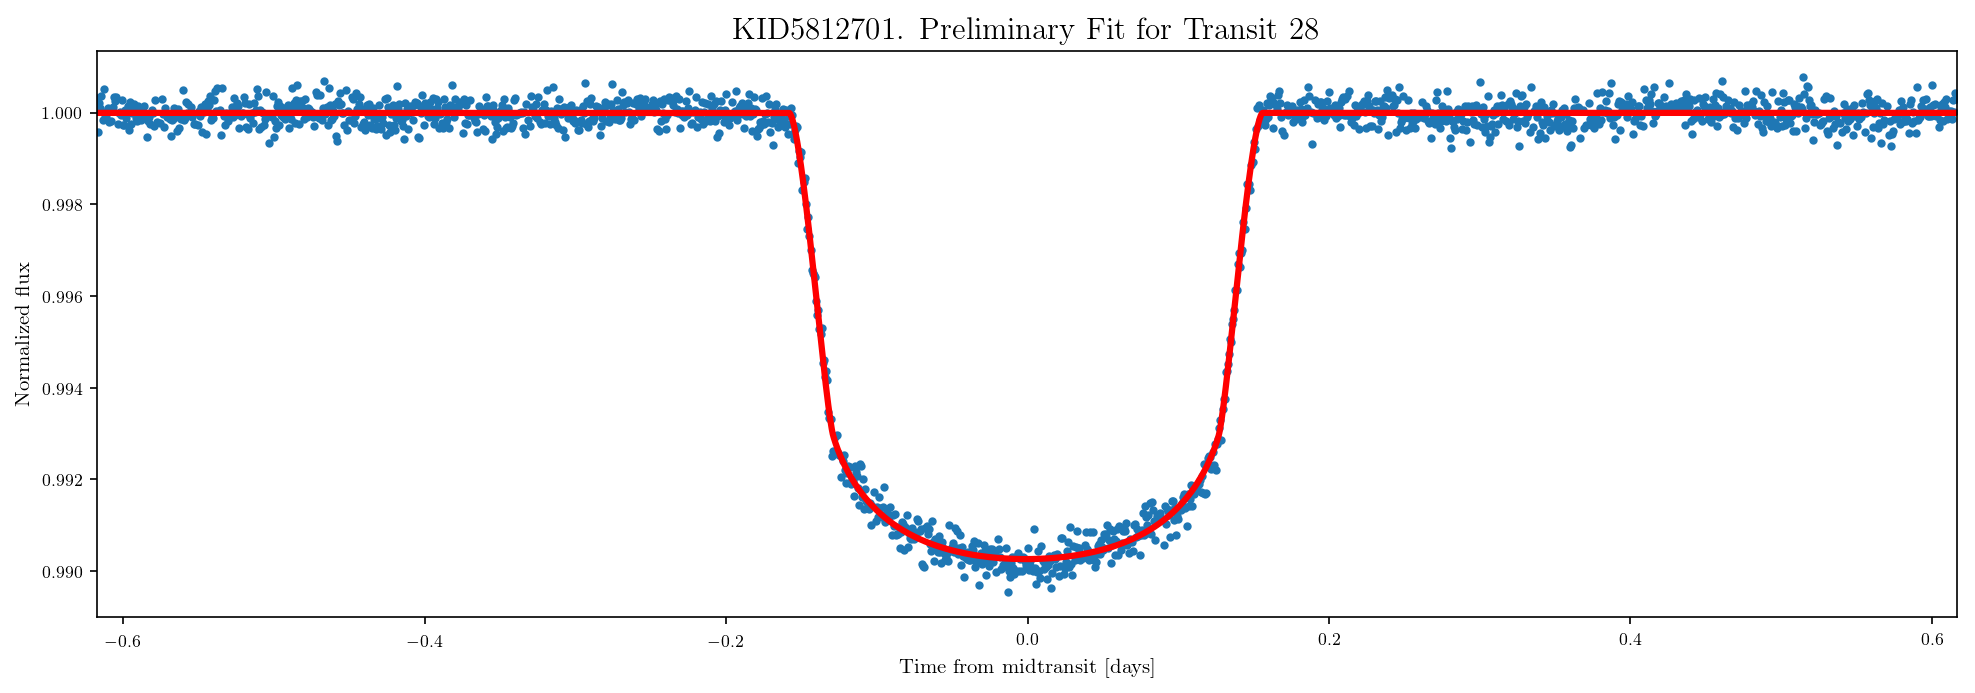

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.314	True=0.309
	Period [days]:	 Fit=17.88962775	True=17.85522168
	Impact Parameter:	 Fit=0.306996	True=0.075000
	Depth:	 Fit=0.008445	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00025
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.30700
Guess of Rp [in Rsun]: 0.14781
Max. allowed b (1+rp_guess/rs): 1.08762


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [10:25<00:00, 15.64it/s]


Multiprocessing took 637.7 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.305 (+0.026,-0.028)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.879 (+0.439,-0.453)

Period [d]:
	True = 17.855
	MCMC Fit = 17.944 (+1.835,-1.638)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0526 (+0.0016,-0.0016)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.685 (+0.044,-0.045)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.384 (+0.069,-0.069)

Mean acceptance fraction: 0.36 (36.33 %) 

*TRANSIT 29
	Signal = 0.00753. Noise (rms) = 0.00025. SNR = 29.70060
	Out-of-transit error of the transit LC = 0.00025

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990433
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12852.451403
         Iterations: 4614
         Function evaluations: 6750
Optimization terminated successfully.
         Current function value: -12852.451400
         Iterations: 422
         Function evaluations: 651


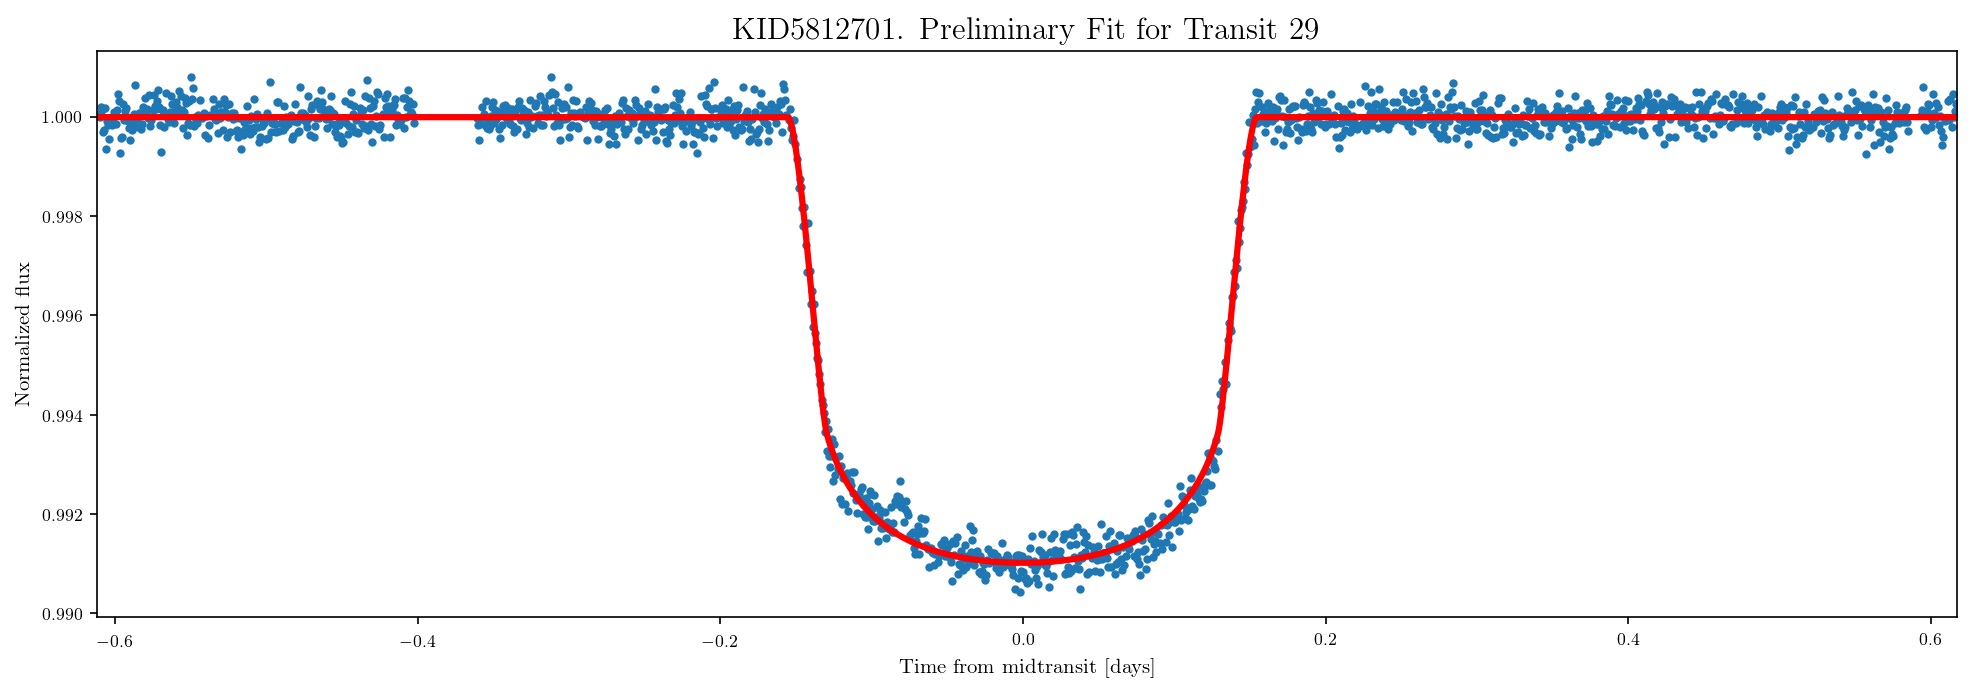

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.309	True=0.309
	Period [days]:	 Fit=15.44510388	True=17.85522168
	Impact Parameter:	 Fit=0.083326	True=0.075000
	Depth:	 Fit=0.007681	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00026
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.08333
Guess of Rp [in Rsun]: 0.14094
Max. allowed b (1+rp_guess/rs): 1.08357


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [08:57<00:00, 18.78it/s]


Multiprocessing took 549.2 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.093 (+0.066,-0.062)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.066 (+0.382,-0.411)

Period [d]:
	True = 17.855
	MCMC Fit = 15.782 (+1.521,-1.274)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0578 (+0.0016,-0.0017)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.680 (+0.040,-0.043)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.389 (+0.069,-0.067)

Mean acceptance fraction: 0.32 (31.95 %) 

*TRANSIT 30
	Signal = 0.00736. Noise (rms) = 0.00026. SNR = 28.05353
	Out-of-transit error of the transit LC = 0.00026

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990479
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065
Optimization terminated successfully.
         Current function value: -13209.965314
         It

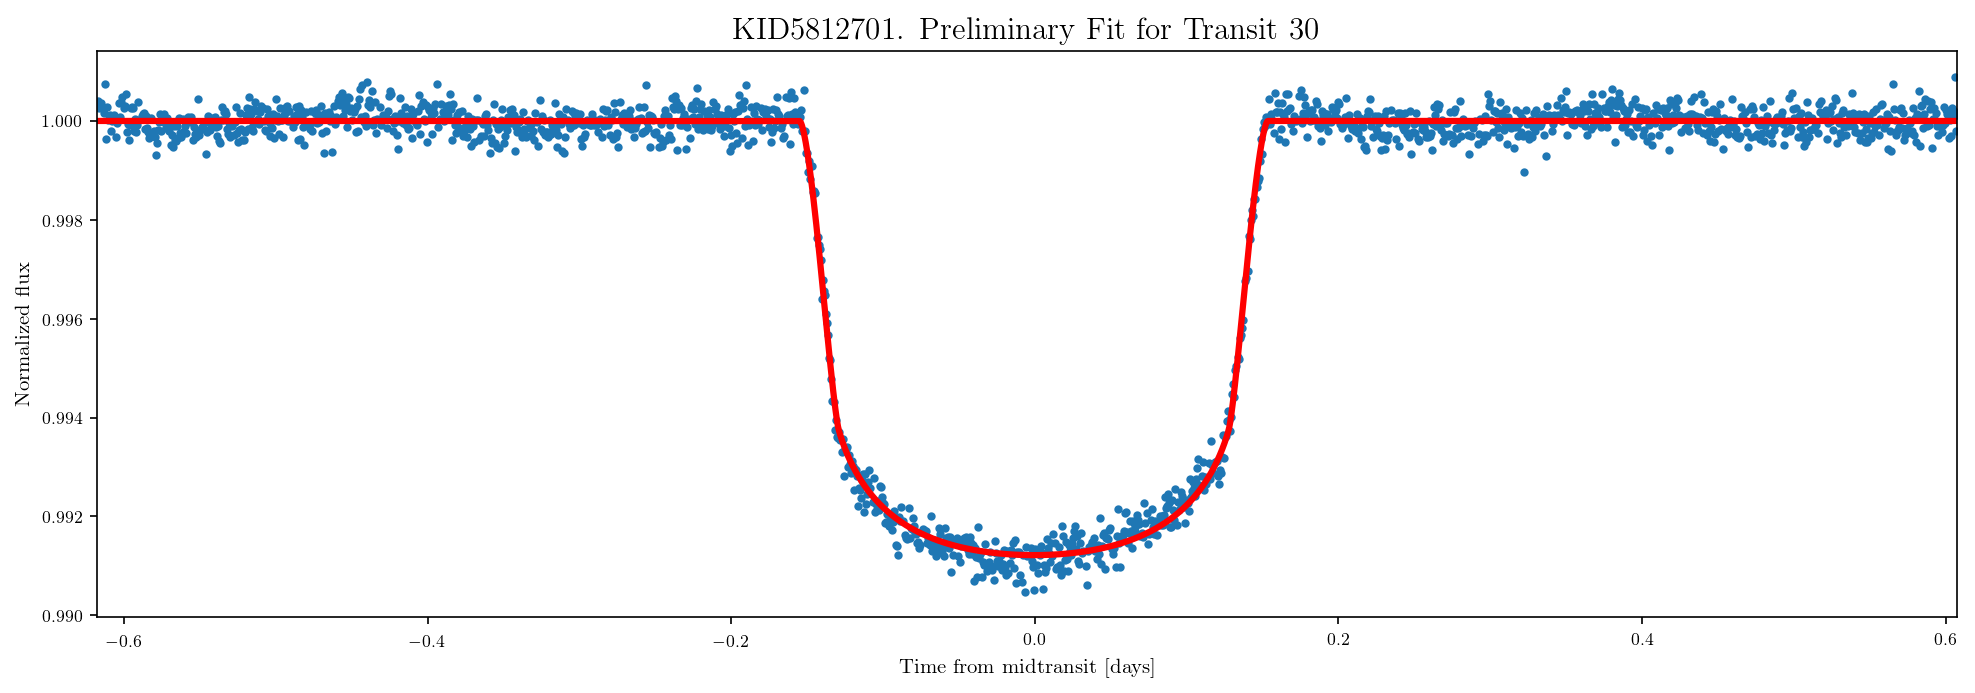

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.308	True=0.309
	Period [days]:	 Fit=15.84753840	True=17.85522168
	Impact Parameter:	 Fit=0.184886	True=0.075000
	Depth:	 Fit=0.007539	True=0.009065
	Stellar mass:	 Fit=1.382	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00026
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.18489
Guess of Rp [in Rsun]: 0.13967
Max. allowed b (1+rp_guess/rs): 1.08278


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [09:22<00:00, 17.77it/s]


Multiprocessing took 574.5 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.168 (+0.056,-0.082)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.918 (+0.390,-0.394)

Period [d]:
	True = 17.855
	MCMC Fit = 15.916 (+1.532,-1.354)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0569 (+0.0016,-0.0016)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.682 (+0.041,-0.041)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.388 (+0.069,-0.067)

Mean acceptance fraction: 0.31 (31.26 %) 

*TRANSIT 31
	Signal = 0.00755. Noise (rms) = 0.00026. SNR = 28.77367
	Out-of-transit error of the transit LC = 0.00026

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990398
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13353.718743
         Iterations: 2021
         Function evaluations: 2981
Optimization terminated successfully.
         Current function value: -13422.541608
         Iterations: 1436
         Function evaluations: 2144


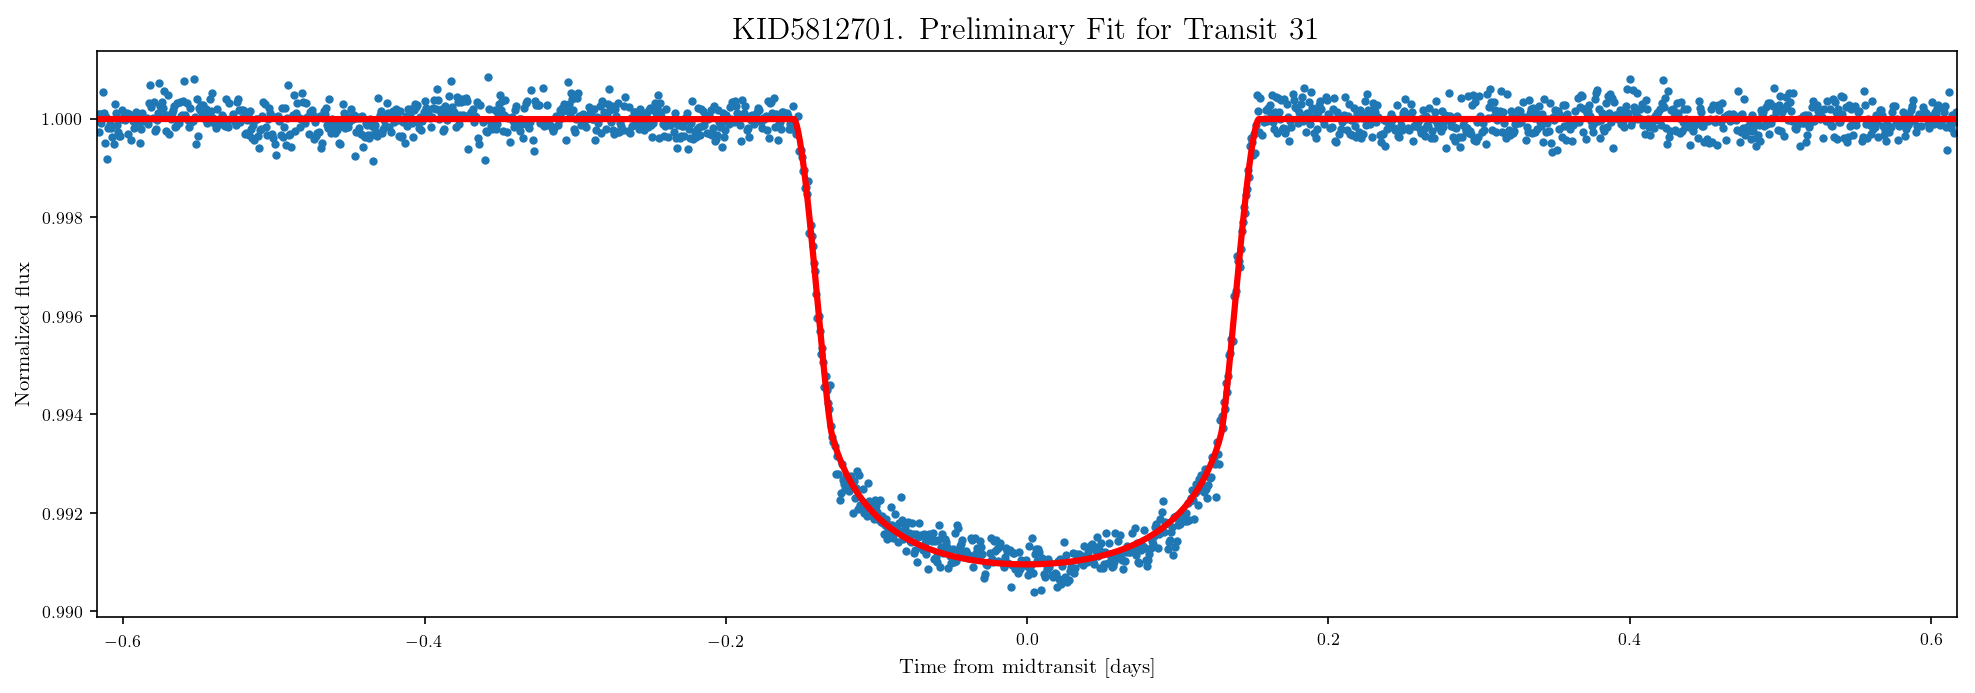

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.308	True=0.309
	Period [days]:	 Fit=62.37693636	True=17.85522168
	Impact Parameter:	 Fit=0.000000	True=0.075000
	Depth:	 Fit=0.007727	True=0.009065
	Stellar mass:	 Fit=1.479	True=1.386
	Stellar radius:	 Fit=1.077	True=1.683
	Sigma (white noise):	 Fit=0.00026
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.00000
Guess of Rp [in Rsun]: 0.09030
Max. allowed b (1+rp_guess/rs): 1.08381


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [09:08<00:00, 18.27it/s]


Multiprocessing took 560.7 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.082 (+0.075,-0.066)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.088 (+0.382,-0.418)

Period [d]:
	True = 17.855
	MCMC Fit = 15.788 (+1.563,-1.304)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0227 (+0.0006,-0.0007)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.677 (+0.040,-0.044)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.393 (+0.068,-0.065)

Mean acceptance fraction: 0.33 (32.83 %) 

*TRANSIT 32
	Signal = 0.00791. Noise (rms) = 0.00027. SNR = 29.67620
	Out-of-transit error of the transit LC = 0.00027

Min flux Folded LC = 0.989510
Min flux individual transit = 0.989901
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12994.563921
         Iterations: 1925
         Function evaluations: 2815
Optimization terminated successfully.
         Current function value: -13108.025739
         Iterations: 1647
         Function evaluations: 2426


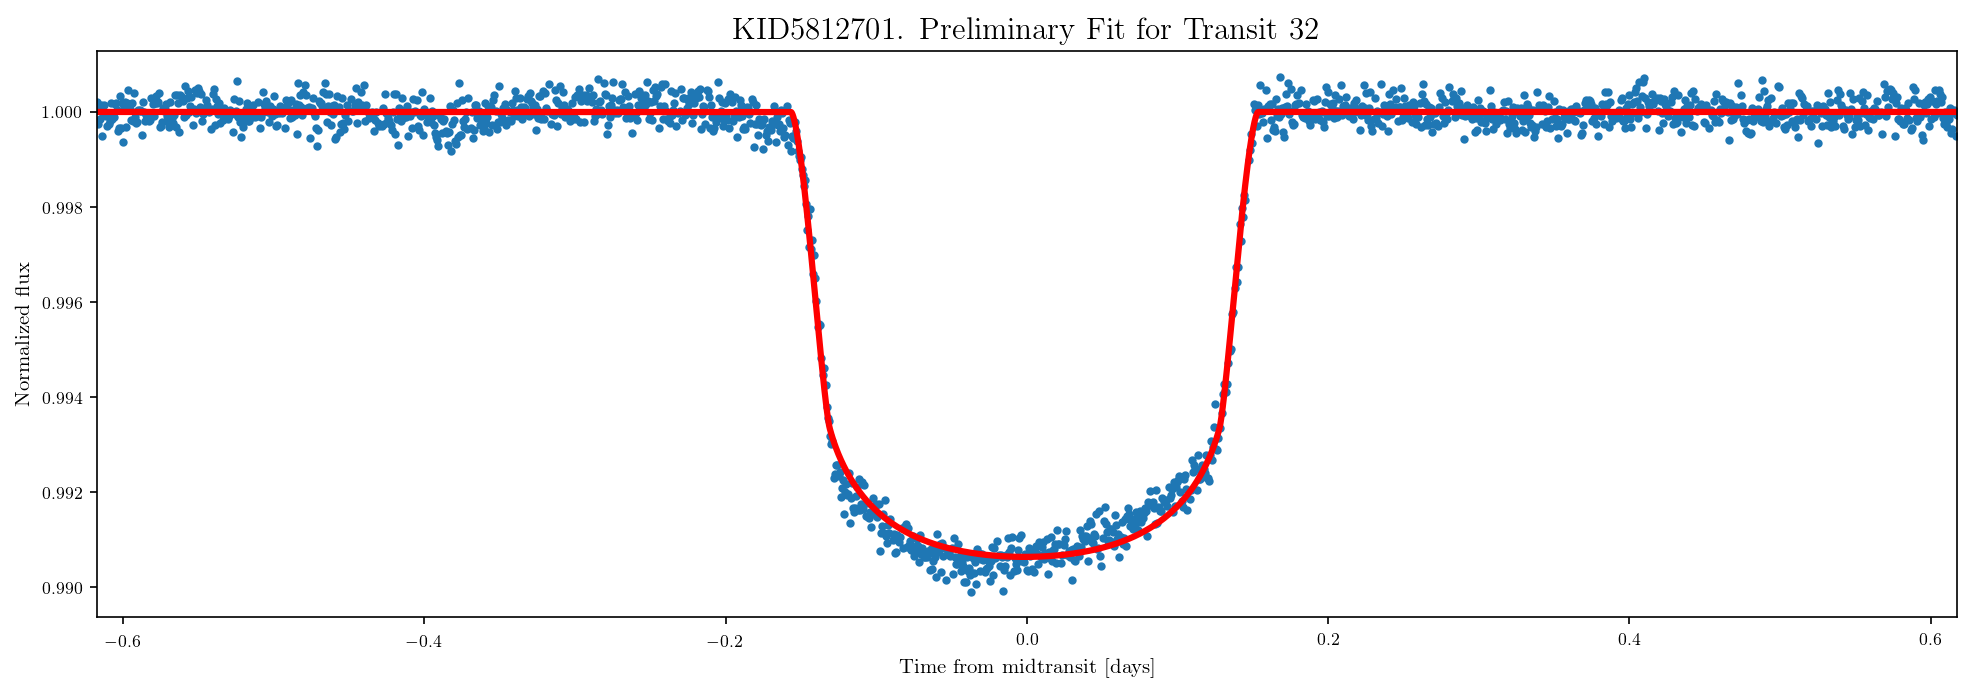

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.310	True=0.309
	Period [days]:	 Fit=36.30042699	True=17.85522168
	Impact Parameter:	 Fit=0.000000	True=0.075000
	Depth:	 Fit=0.007998	True=0.009065
	Stellar mass:	 Fit=1.509	True=1.386
	Stellar radius:	 Fit=1.304	True=1.683
	Sigma (white noise):	 Fit=0.00028
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.00000
Guess of Rp [in Rsun]: 0.11117
Max. allowed b (1+rp_guess/rs): 1.08527


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [08:58<00:00, 18.56it/s]


Multiprocessing took 550.8 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.144 (+0.070,-0.105)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.426 (+0.419,-0.440)

Period [d]:
	True = 17.855
	MCMC Fit = 16.148 (+1.754,-1.430)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0327 (+0.0010,-0.0010)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.680 (+0.043,-0.045)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.392 (+0.072,-0.069)

Mean acceptance fraction: 0.31 (30.62 %) 

*TRANSIT 33
	Signal = 0.00724. Noise (rms) = 0.00026. SNR = 28.34241
	Out-of-transit error of the transit LC = 0.00026

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990836
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13401.051758
         Iterations: 1356
         Function evaluations: 2015
Optimization terminated successfully.
         Current function value: -13440.939330
         Iterations: 1451
         Function evaluations: 2165


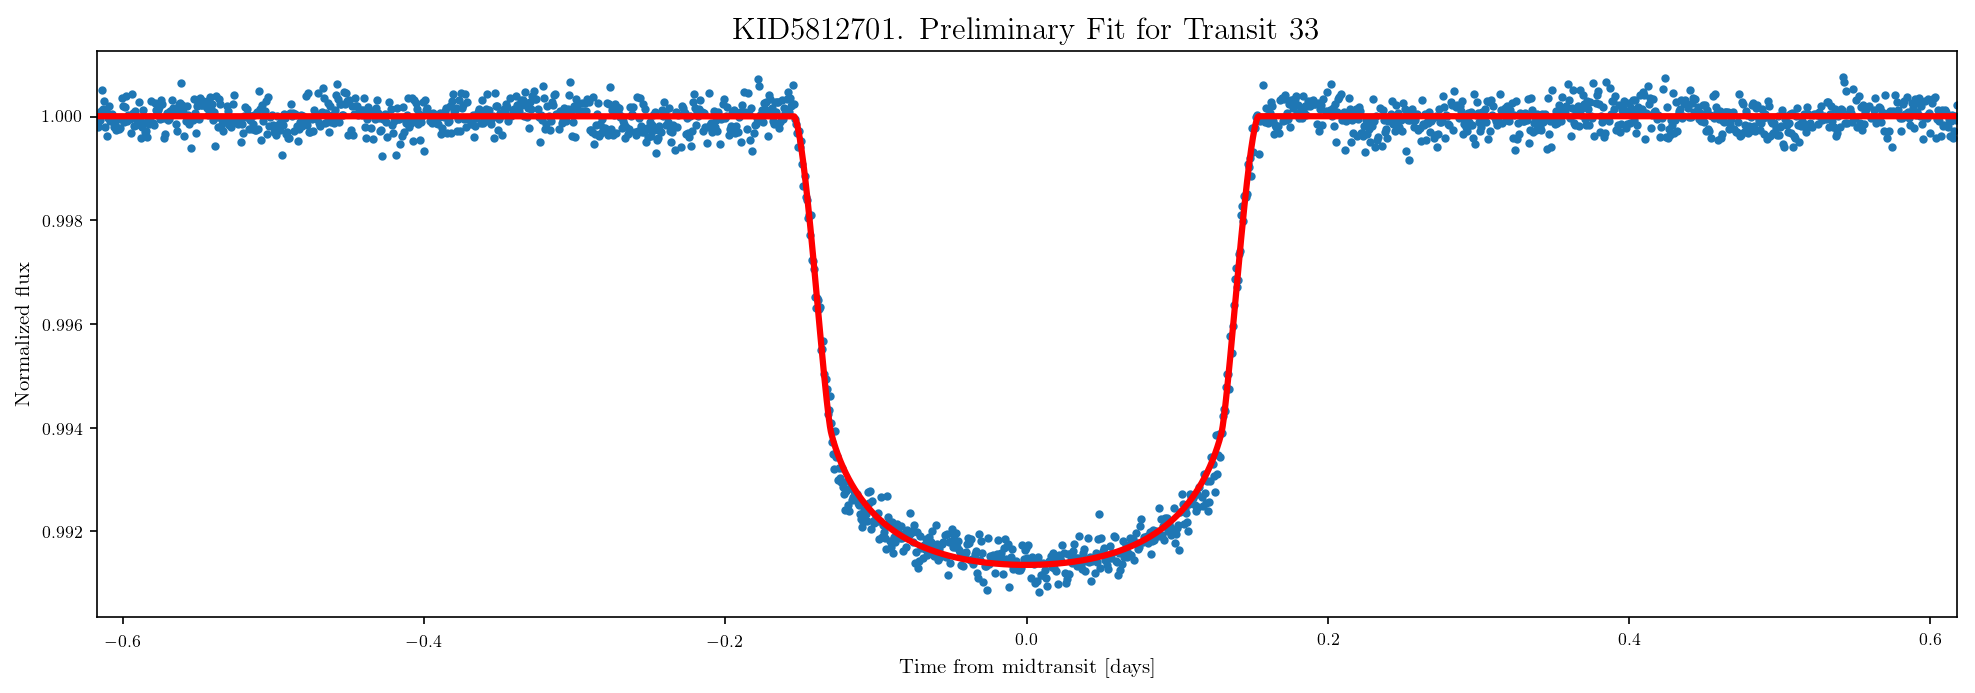

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.308	True=0.309
	Period [days]:	 Fit=14.98003328	True=17.85522168
	Impact Parameter:	 Fit=0.008965	True=0.075000
	Depth:	 Fit=0.007392	True=0.009065
	Stellar mass:	 Fit=1.333	True=1.386
	Stellar radius:	 Fit=1.675	True=1.683
	Sigma (white noise):	 Fit=0.00026
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.00897
Guess of Rp [in Rsun]: 0.13733
Max. allowed b (1+rp_guess/rs): 1.08198


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [09:13<00:00, 18.50it/s]


Multiprocessing took 565.0 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.007 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.137 (+0.065,-0.083)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.771 (+0.397,-0.407)

Period [d]:
	True = 17.855
	MCMC Fit = 15.973 (+1.629,-1.371)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0589 (+0.0017,-0.0018)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.679 (+0.042,-0.043)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.390 (+0.067,-0.066)

Mean acceptance fraction: 0.30 (30.04 %) 

*TRANSIT 34
	Signal = 0.00744. Noise (rms) = 0.00027. SNR = 27.81036
	Out-of-transit error of the transit LC = 0.00027

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990584
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13447.673199
         Iterations: 3967
         Function evaluations: 5749
Optimization terminated successfully.
         Current function value: -13447.673199
         Iterations: 381
         Function evaluations: 593


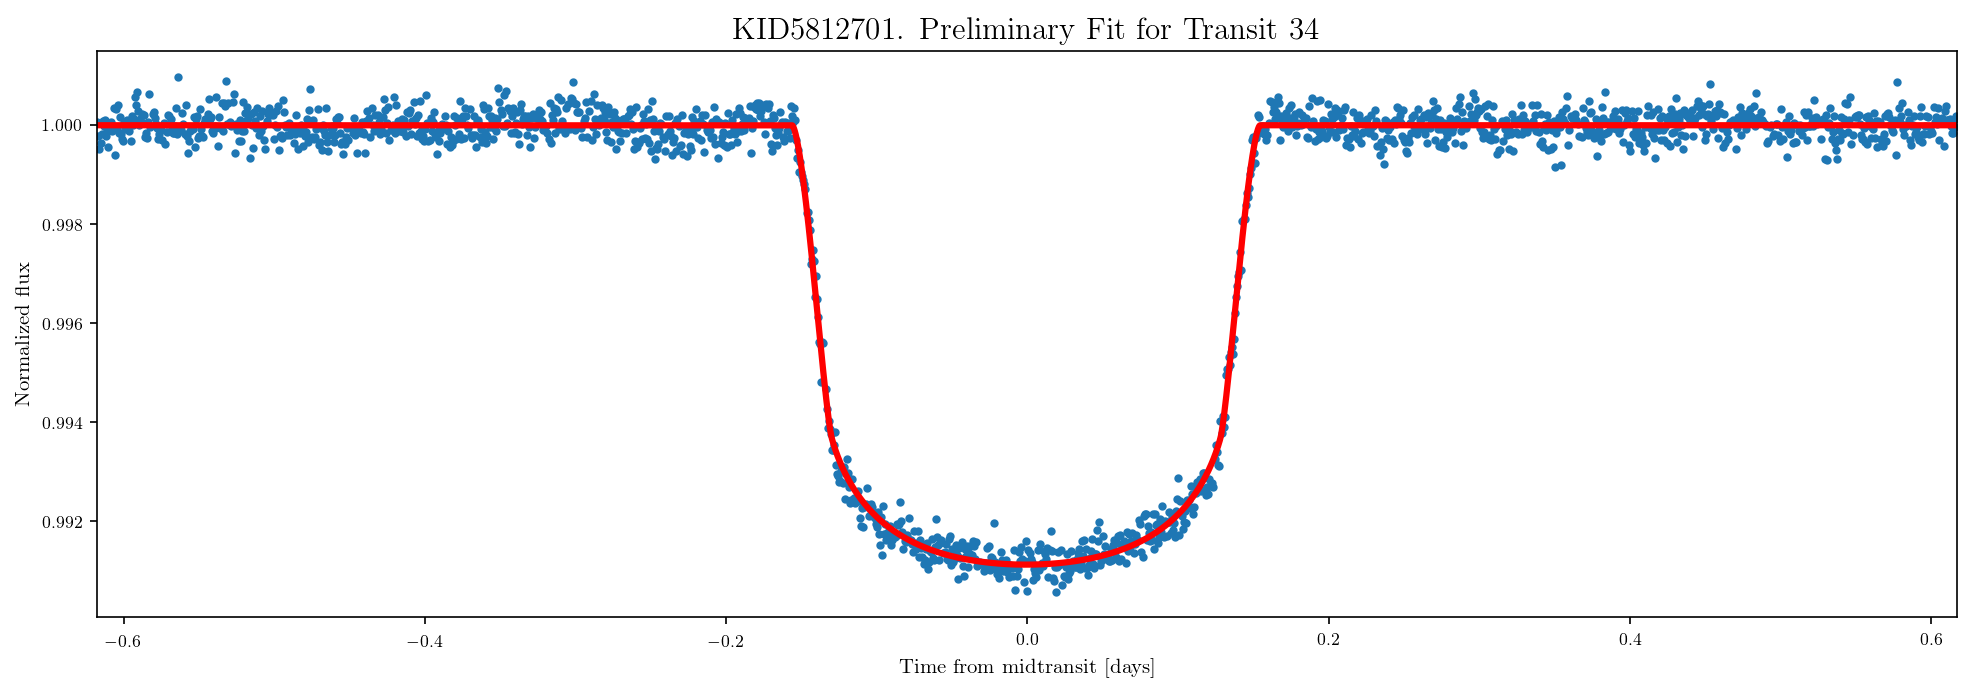

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.311	True=0.309
	Period [days]:	 Fit=16.50040194	True=17.85522168
	Impact Parameter:	 Fit=0.219523	True=0.075000
	Depth:	 Fit=0.007629	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00026
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.21952
Guess of Rp [in Rsun]: 0.14046
Max. allowed b (1+rp_guess/rs): 1.08328


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [09:51<00:00, 16.52it/s]


Multiprocessing took 603.5 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.208 (+0.048,-0.070)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.994 (+0.417,-0.423)

Period [d]:
	True = 17.855
	MCMC Fit = 16.580 (+1.805,-1.526)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0553 (+0.0017,-0.0017)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.680 (+0.044,-0.044)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.389 (+0.069,-0.069)

Mean acceptance fraction: 0.31 (31.12 %) 

*TRANSIT 35
	Signal = 0.00766. Noise (rms) = 0.00024. SNR = 31.45687
	Out-of-transit error of the transit LC = 0.00024

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990467
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -11894.028508
         Iterations: 2599
         Function evaluations: 3831
Optimization terminated successfully.
         Current function value: -11899.708175
         Iterations: 645
         Function evaluations: 974


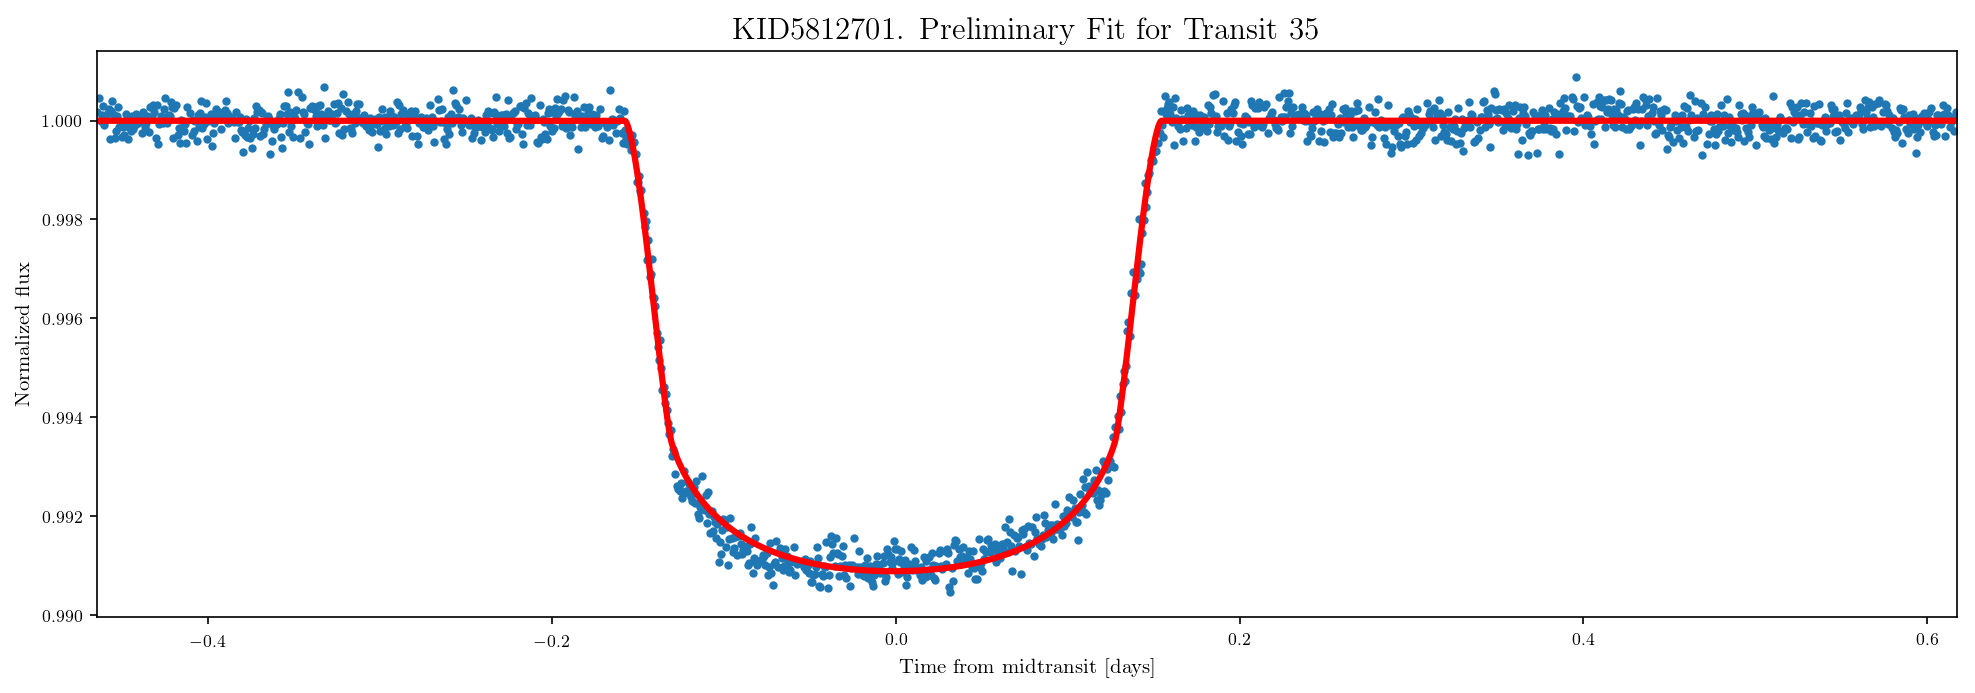

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.312	True=0.309
	Period [days]:	 Fit=17.11115282	True=17.85522168
	Impact Parameter:	 Fit=0.257702	True=0.075000
	Depth:	 Fit=0.007866	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.686	True=1.683
	Sigma (white noise):	 Fit=0.00025
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.25770
Guess of Rp [in Rsun]: 0.14261
Max. allowed b (1+rp_guess/rs): 1.08456


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [09:44<00:00, 17.50it/s]


Multiprocessing took 596.7 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.249 (+0.038,-0.049)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.261 (+0.421,-0.427)

Period [d]:
	True = 17.855
	MCMC Fit = 17.118 (+1.817,-1.582)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0540 (+0.0017,-0.0017)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.682 (+0.043,-0.044)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.387 (+0.069,-0.069)

Mean acceptance fraction: 0.33 (33.08 %) 

*TRANSIT 36
	Signal = 0.00752. Noise (rms) = 0.00025. SNR = 30.24254
	Out-of-transit error of the transit LC = 0.00025

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990405
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12974.969086
         Iterations: 2176
         Function evaluations: 3240
Optimization terminated successfully.
         Current function value: -13016.571314
         Iterations: 598
         Function evaluations: 904


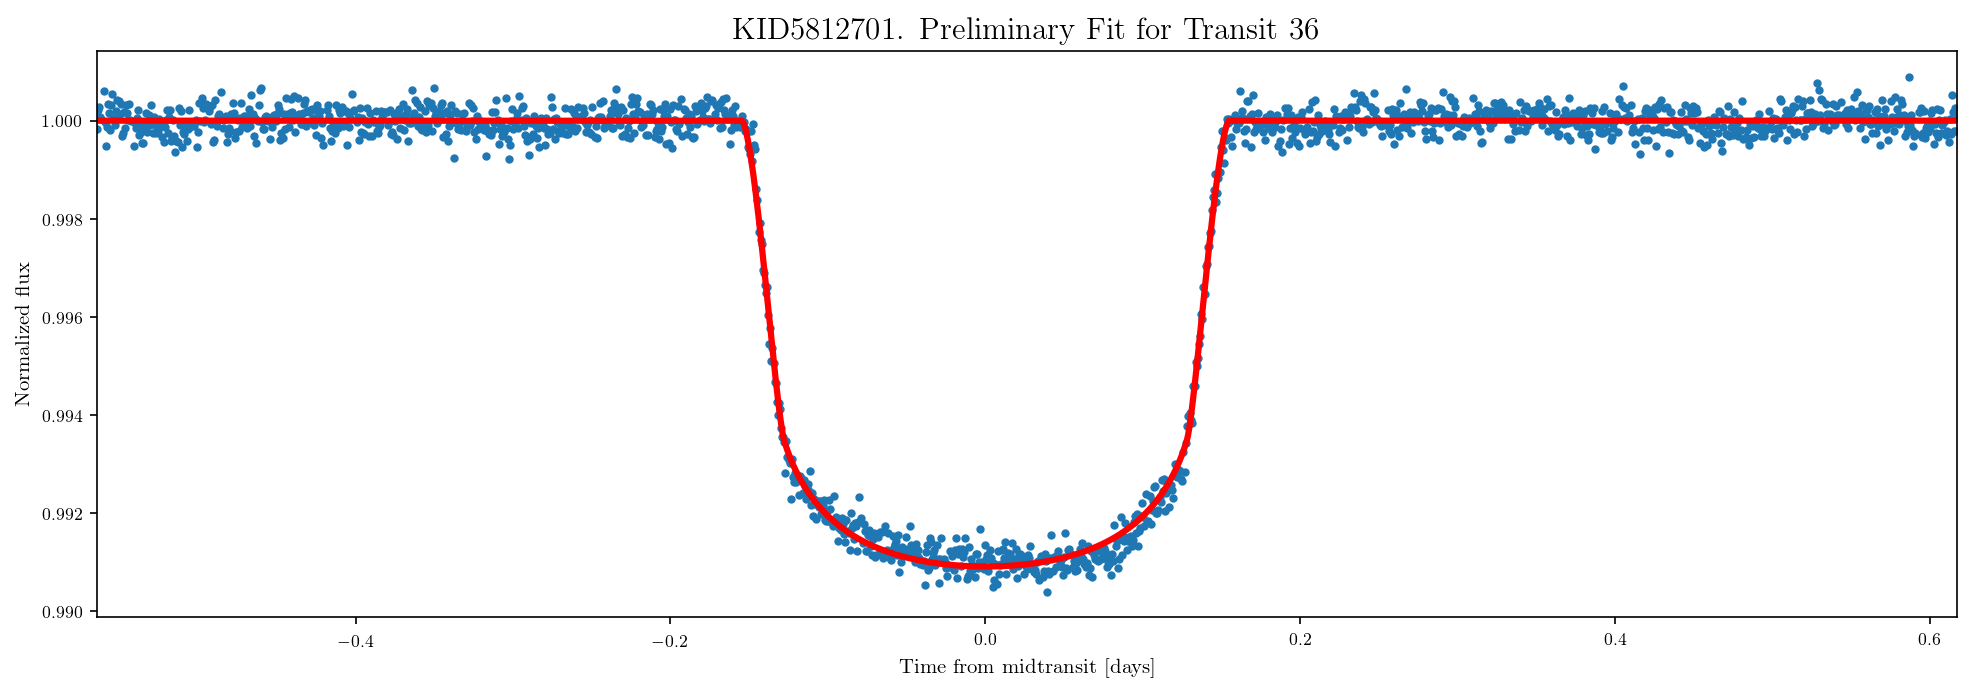

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.309	True=0.309
	Period [days]:	 Fit=13.50000335	True=17.85522168
	Impact Parameter:	 Fit=0.226199	True=0.075000
	Depth:	 Fit=0.007817	True=0.009065
	Stellar mass:	 Fit=1.312	True=1.386
	Stellar radius:	 Fit=1.766	True=1.683
	Sigma (white noise):	 Fit=0.00025
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.22620
Guess of Rp [in Rsun]: 0.14885
Max. allowed b (1+rp_guess/rs): 1.08430


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [09:04<00:00, 18.38it/s]


Multiprocessing took 555.5 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.055 (+0.057,-0.038)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.112 (+0.373,-0.406)

Period [d]:
	True = 17.855
	MCMC Fit = 15.525 (+1.456,-1.210)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0631 (+0.0017,-0.0018)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.678 (+0.039,-0.042)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.392 (+0.068,-0.066)

Mean acceptance fraction: 0.34 (33.98 %) 

*TRANSIT 37
	Signal = 0.00695. Noise (rms) = 0.00025. SNR = 27.40852
	Out-of-transit error of the transit LC = 0.00025

Min flux Folded LC = 0.989510
Min flux individual transit = 0.991180
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13081.500942
         Iterations: 1144
         Function evaluations: 1767
Optimization terminated successfully.
         Current function value: -13289.549026
         Iterations: 3031
         Function evaluations: 4396


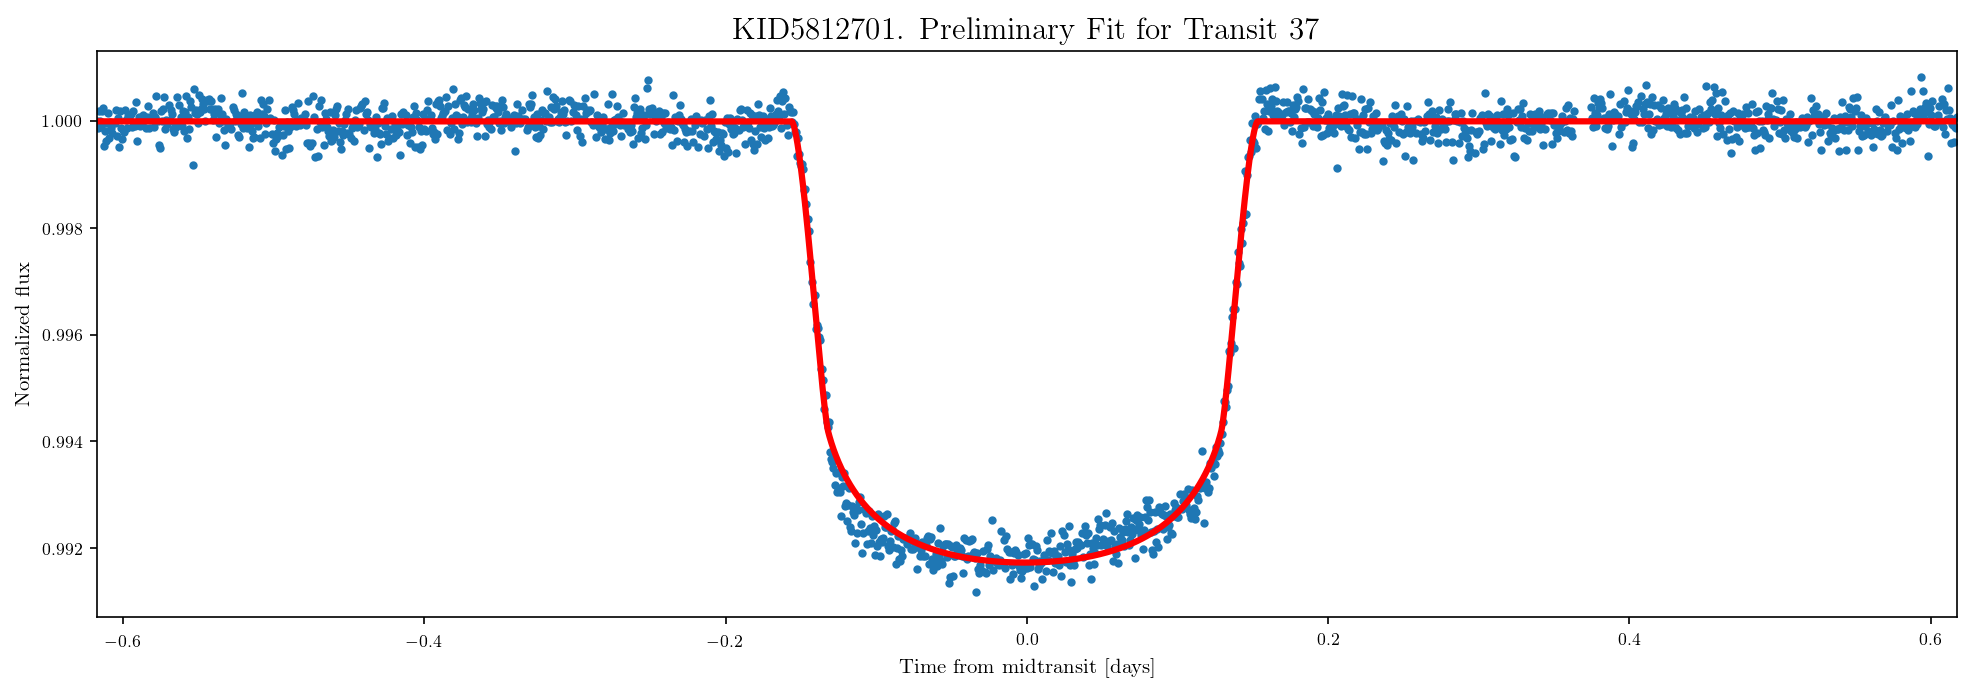

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.309	True=0.309
	Period [days]:	 Fit=15.50482335	True=17.85522168
	Impact Parameter:	 Fit=0.000002	True=0.075000
	Depth:	 Fit=0.007066	True=0.009065
	Stellar mass:	 Fit=1.384	True=1.386
	Stellar radius:	 Fit=1.685	True=1.683
	Sigma (white noise):	 Fit=0.00027
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.00000
Guess of Rp [in Rsun]: 0.13507
Max. allowed b (1+rp_guess/rs): 1.08015


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [08:56<00:00, 18.63it/s]


Multiprocessing took 548.6 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.007 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.048 (+0.049,-0.034)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.397 (+0.373,-0.400)

Period [d]:
	True = 17.855
	MCMC Fit = 15.837 (+1.513,-1.293)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0576 (+0.0016,-0.0017)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.679 (+0.041,-0.043)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.390 (+0.069,-0.066)

Mean acceptance fraction: 0.36 (36.12 %) 

*TRANSIT 38
	Signal = 0.00754. Noise (rms) = 0.00024. SNR = 31.59862
	Out-of-transit error of the transit LC = 0.00024

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990093
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13597.657406
         Iterations: 2482
         Function evaluations: 3648
Optimization terminated successfully.
         Current function value: -13601.508244
         Iterations: 735
         Function evaluations: 1092


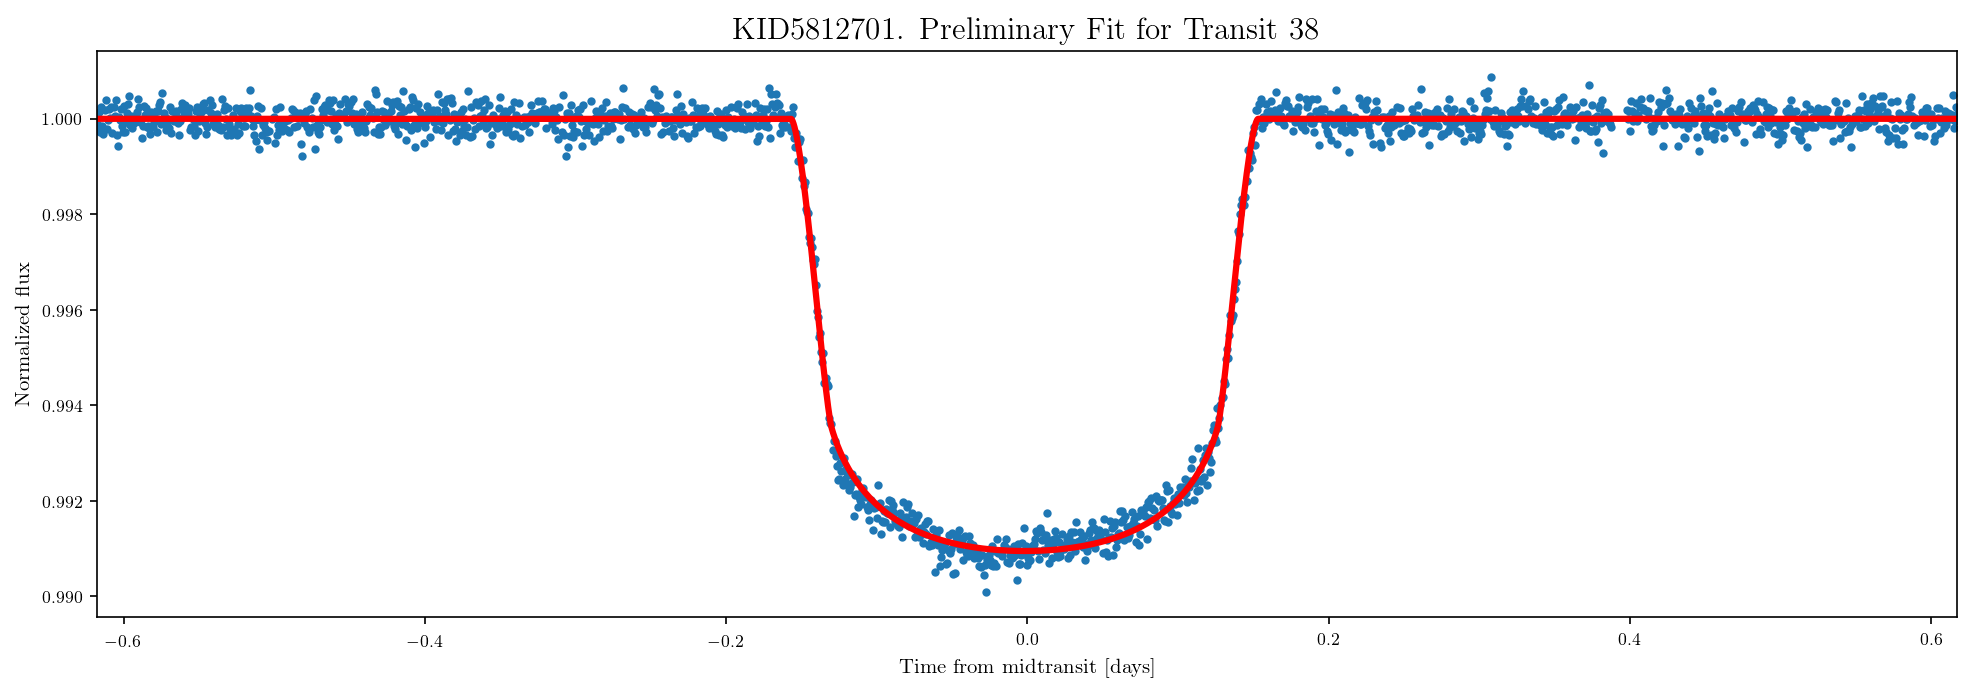

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.310	True=0.309
	Period [days]:	 Fit=16.67338321	True=17.85522168
	Impact Parameter:	 Fit=0.250023	True=0.075000
	Depth:	 Fit=0.007806	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00024
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.25002
Guess of Rp [in Rsun]: 0.14208
Max. allowed b (1+rp_guess/rs): 1.08424


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [10:07<00:00, 16.51it/s]


Multiprocessing took 620.3 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.243 (+0.037,-0.047)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.202 (+0.417,-0.421)

Period [d]:
	True = 17.855
	MCMC Fit = 16.713 (+1.710,-1.514)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0550 (+0.0017,-0.0016)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.682 (+0.043,-0.043)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.386 (+0.068,-0.068)

Mean acceptance fraction: 0.34 (33.59 %) 

*TRANSIT 40
	Signal = 0.00776. Noise (rms) = 0.00024. SNR = 32.21986
	Out-of-transit error of the transit LC = 0.00024

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990180
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13256.044166
         Iterations: 1415
         Function evaluations: 2124
Optimization terminated successfully.
         Current function value: -13299.306203
         Iterations: 1199
         Function evaluations: 1791


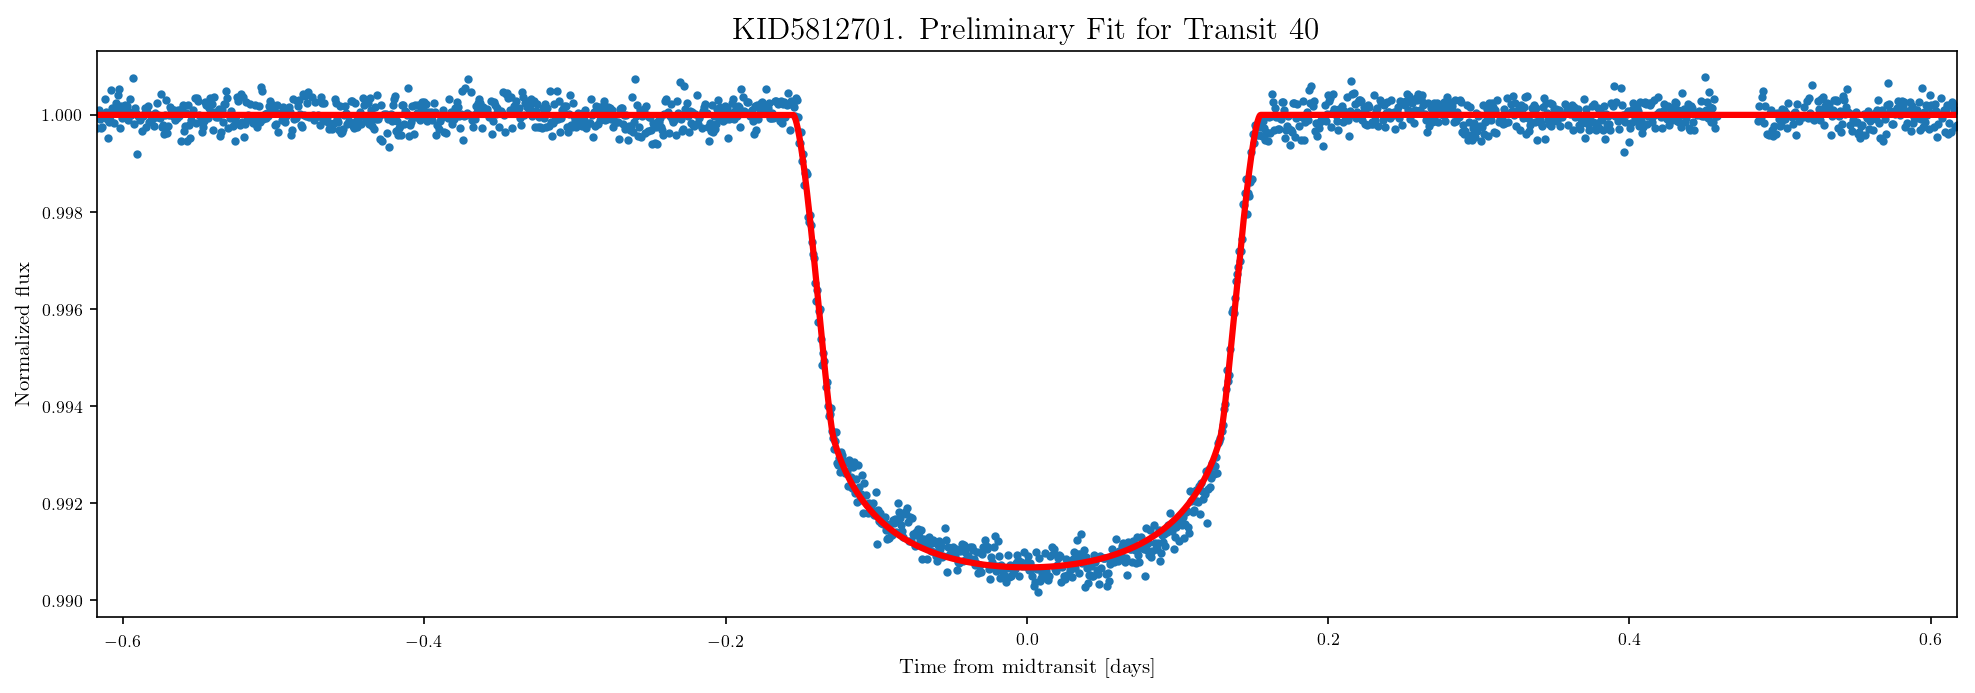

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.310	True=0.309
	Period [days]:	 Fit=16.25053353	True=17.85522168
	Impact Parameter:	 Fit=0.211045	True=0.075000
	Depth:	 Fit=0.008012	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00024
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.21104
Guess of Rp [in Rsun]: 0.14396
Max. allowed b (1+rp_guess/rs): 1.08535


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [10:02<00:00, 15.88it/s]


Multiprocessing took 615.1 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.199 (+0.043,-0.063)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.410 (+0.433,-0.445)

Period [d]:
	True = 17.855
	MCMC Fit = 16.283 (+1.754,-1.451)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0559 (+0.0017,-0.0018)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.682 (+0.044,-0.046)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.391 (+0.068,-0.067)

Mean acceptance fraction: 0.31 (31.01 %) 

*TRANSIT 41
	Signal = 0.00732. Noise (rms) = 0.00025. SNR = 29.75740
	Out-of-transit error of the transit LC = 0.00025

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990505
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12838.900909
         Iterations: 3246
         Function evaluations: 4725
Optimization terminated successfully.
         Current function value: -12886.393726
         Iterations: 1806
         Function evaluations: 2644


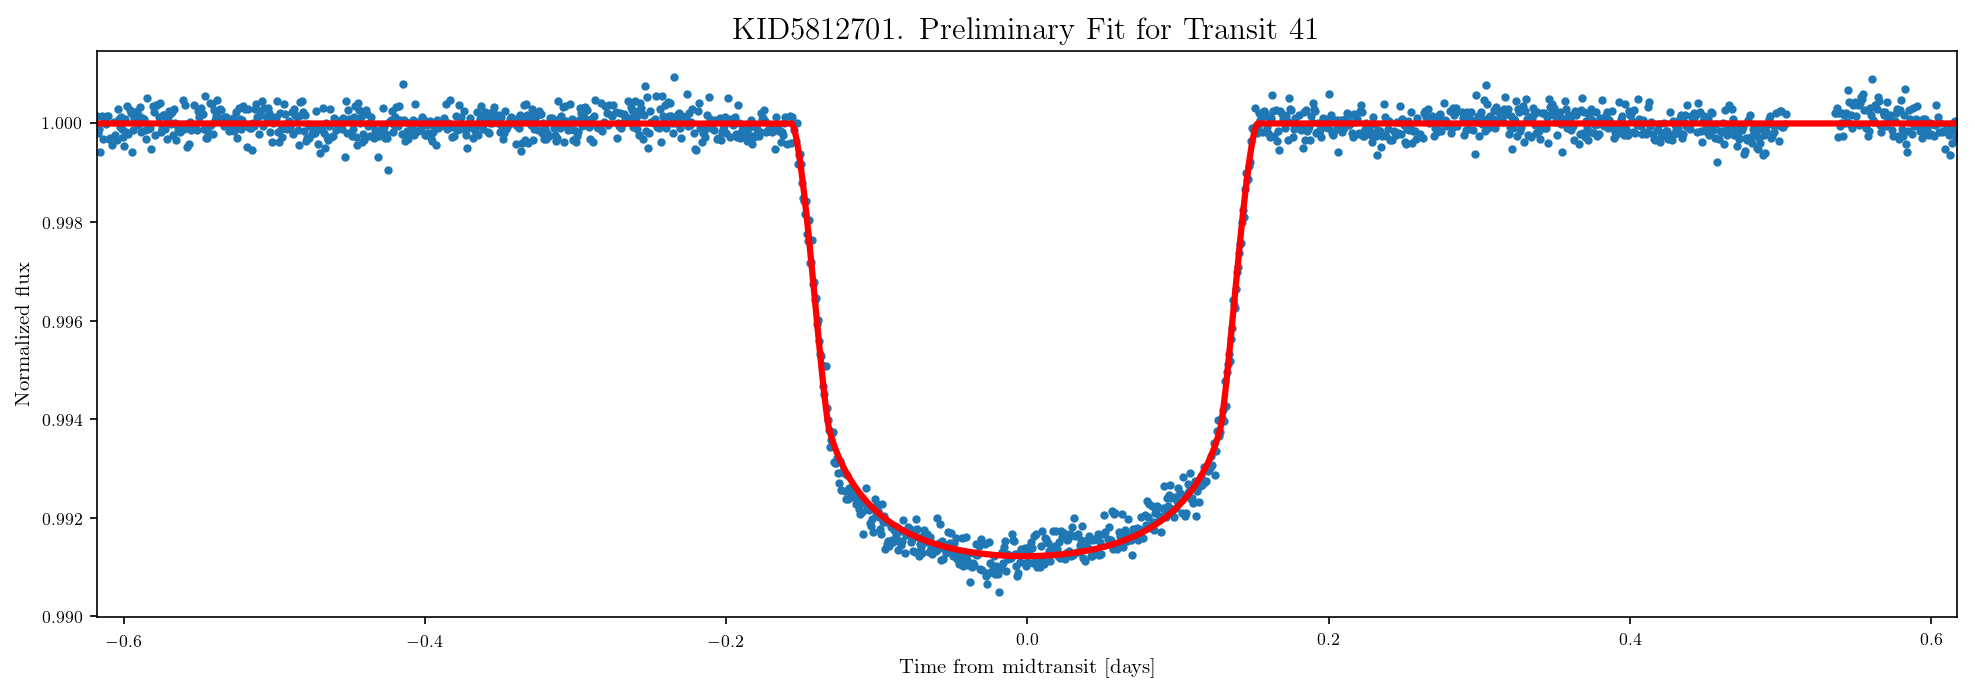

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.309	True=0.309
	Period [days]:	 Fit=15.35593589	True=17.85522168
	Impact Parameter:	 Fit=0.000001	True=0.075000
	Depth:	 Fit=0.007494	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.686	True=1.683
	Sigma (white noise):	 Fit=0.00025
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.00000
Guess of Rp [in Rsun]: 0.13919
Max. allowed b (1+rp_guess/rs): 1.08254


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [09:17<00:00, 17.98it/s]


Multiprocessing took 569.7 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.075 (+0.063,-0.052)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.865 (+0.384,-0.405)

Period [d]:
	True = 17.855
	MCMC Fit = 15.819 (+1.546,-1.314)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0580 (+0.0017,-0.0017)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.679 (+0.040,-0.043)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.390 (+0.069,-0.067)

Mean acceptance fraction: 0.33 (33.07 %) 

*TRANSIT 42
	Signal = 0.00773. Noise (rms) = 0.00027. SNR = 28.30558
	Out-of-transit error of the transit LC = 0.00027

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990164
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13283.758298
         Iterations: 2818
         Function evaluations: 4120
Optimization terminated successfully.
         Current function value: -13283.758284
         Iterations: 323
         Function evaluations: 519


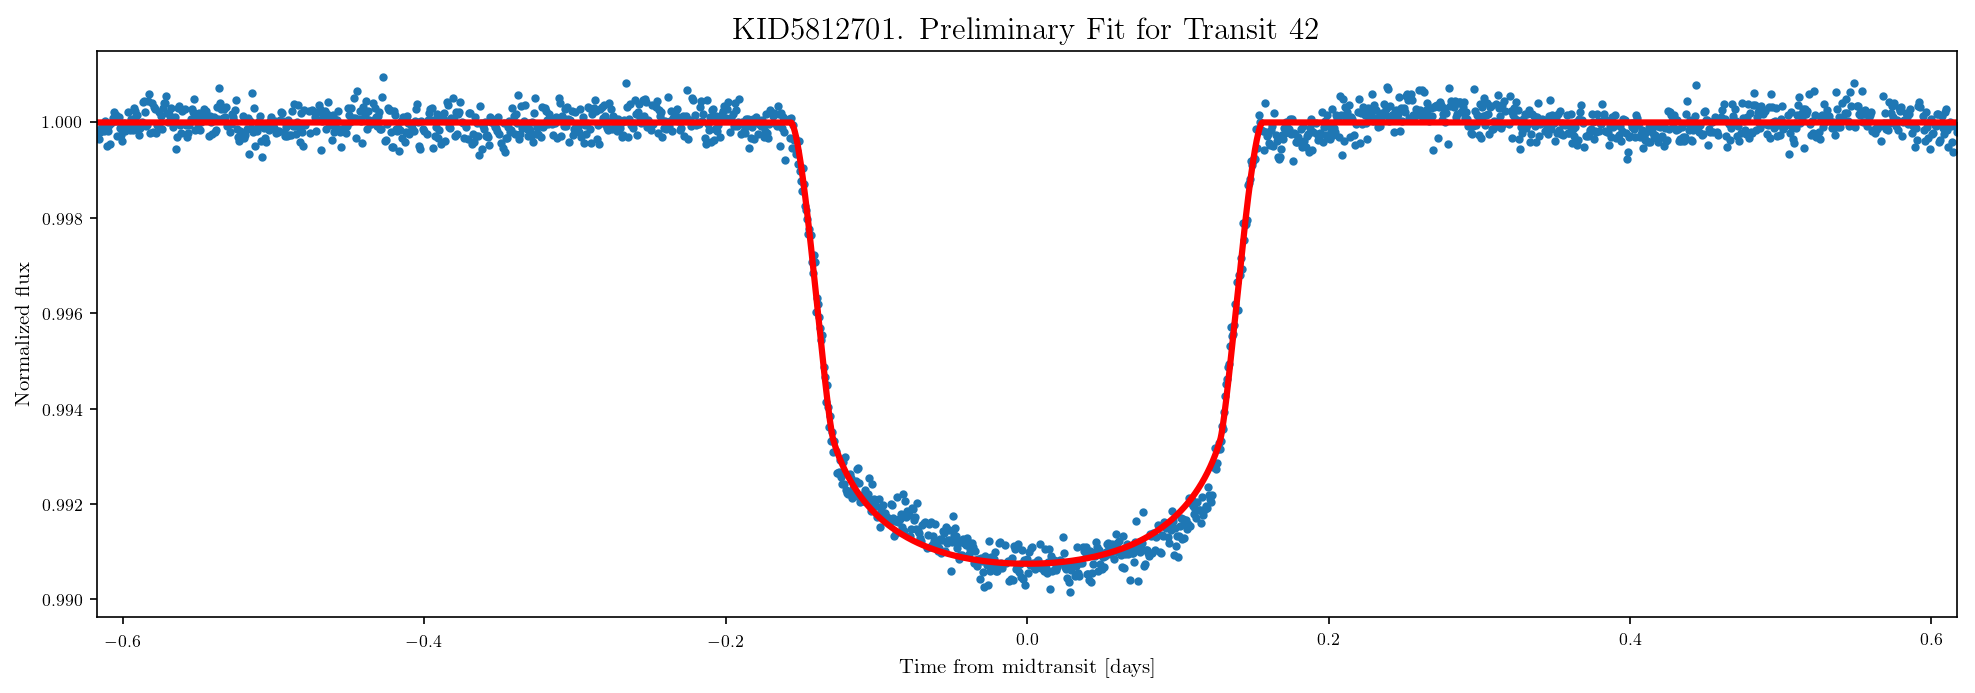

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.313	True=0.309
	Period [days]:	 Fit=17.49927451	True=17.85522168
	Impact Parameter:	 Fit=0.284174	True=0.075000
	Depth:	 Fit=0.007998	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.686	True=1.683
	Sigma (white noise):	 Fit=0.00028
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.28417
Guess of Rp [in Rsun]: 0.14379
Max. allowed b (1+rp_guess/rs): 1.08527


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [10:53<00:00, 15.67it/s]


Multiprocessing took 666.8 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.279 (+0.034,-0.042)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.413 (+0.437,-0.437)

Period [d]:
	True = 17.855
	MCMC Fit = 17.539 (+1.802,-1.641)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0533 (+0.0017,-0.0016)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.683 (+0.045,-0.045)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.387 (+0.068,-0.068)

Mean acceptance fraction: 0.36 (35.54 %) 

*TRANSIT 43
	Signal = 0.00778. Noise (rms) = 0.00024. SNR = 32.30195
	Out-of-transit error of the transit LC = 0.00024

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990123
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13667.852386
         Iterations: 2884
         Function evaluations: 4231
Optimization terminated successfully.
         Current function value: -13669.253516
         Iterations: 818
         Function evaluations: 1240


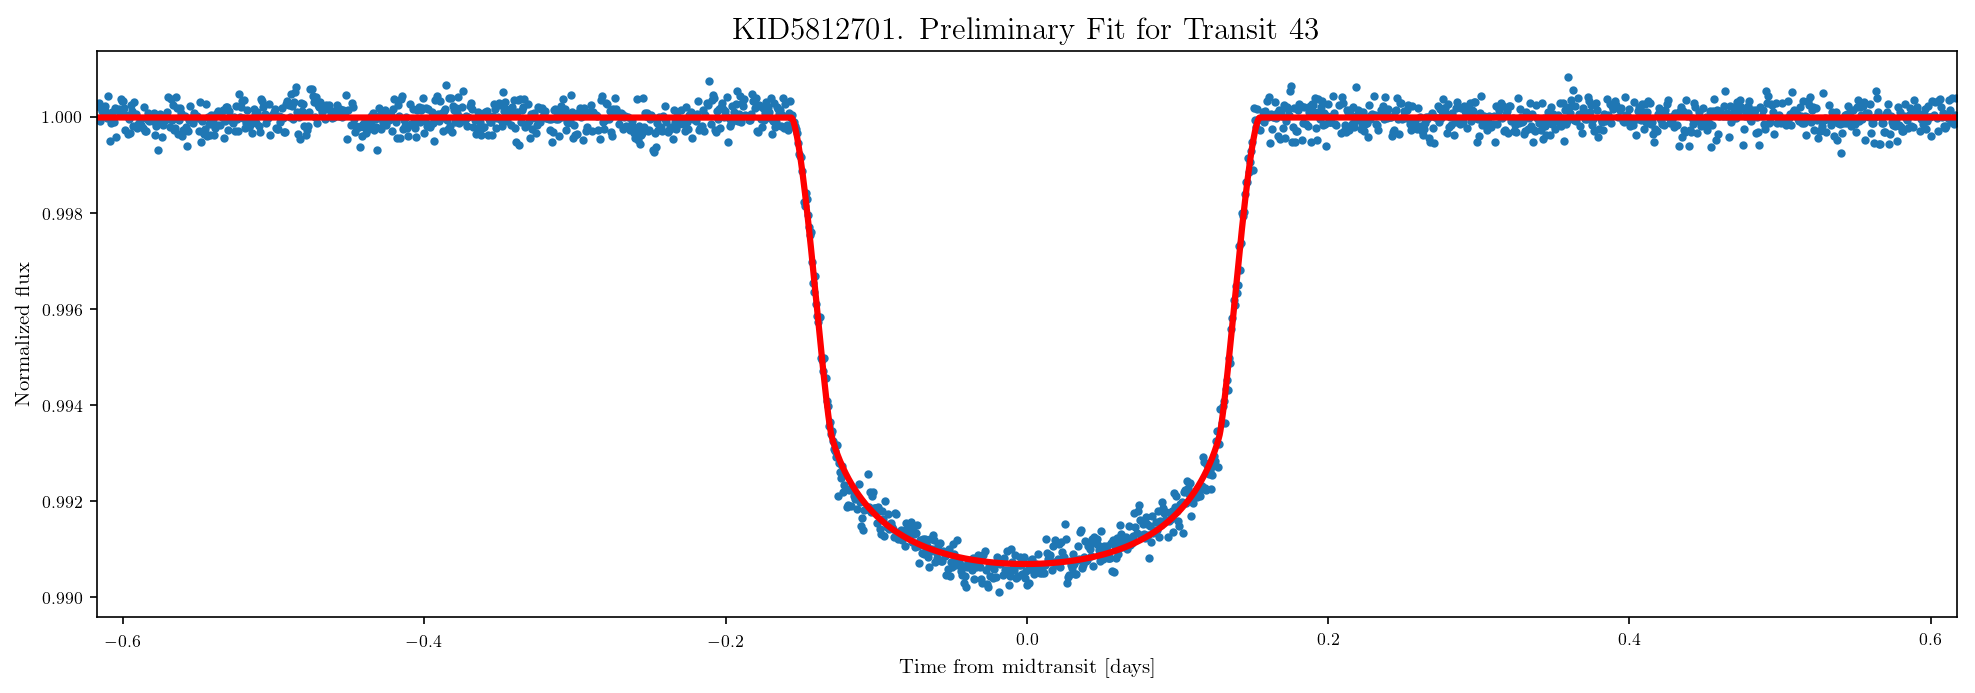

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.311	True=0.309
	Period [days]:	 Fit=16.37531606	True=17.85522168
	Impact Parameter:	 Fit=0.211652	True=0.075000
	Depth:	 Fit=0.007996	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00024
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.21165
Guess of Rp [in Rsun]: 0.14382
Max. allowed b (1+rp_guess/rs): 1.08526


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [10:58<00:00, 14.59it/s]


Multiprocessing took 671.4 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.198 (+0.043,-0.061)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.397 (+0.411,-0.432)

Period [d]:
	True = 17.855
	MCMC Fit = 16.372 (+1.647,-1.433)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0557 (+0.0017,-0.0017)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.682 (+0.042,-0.044)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.387 (+0.067,-0.067)

Mean acceptance fraction: 0.32 (31.88 %) 

*TRANSIT 44
	Signal = 0.00771. Noise (rms) = 0.00024. SNR = 31.84787
	Out-of-transit error of the transit LC = 0.00024

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990400
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13286.117914
         Iterations: 2662
         Function evaluations: 3866
Optimization terminated successfully.
         Current function value: -13286.739807
         Iterations: 507
         Function evaluations: 786


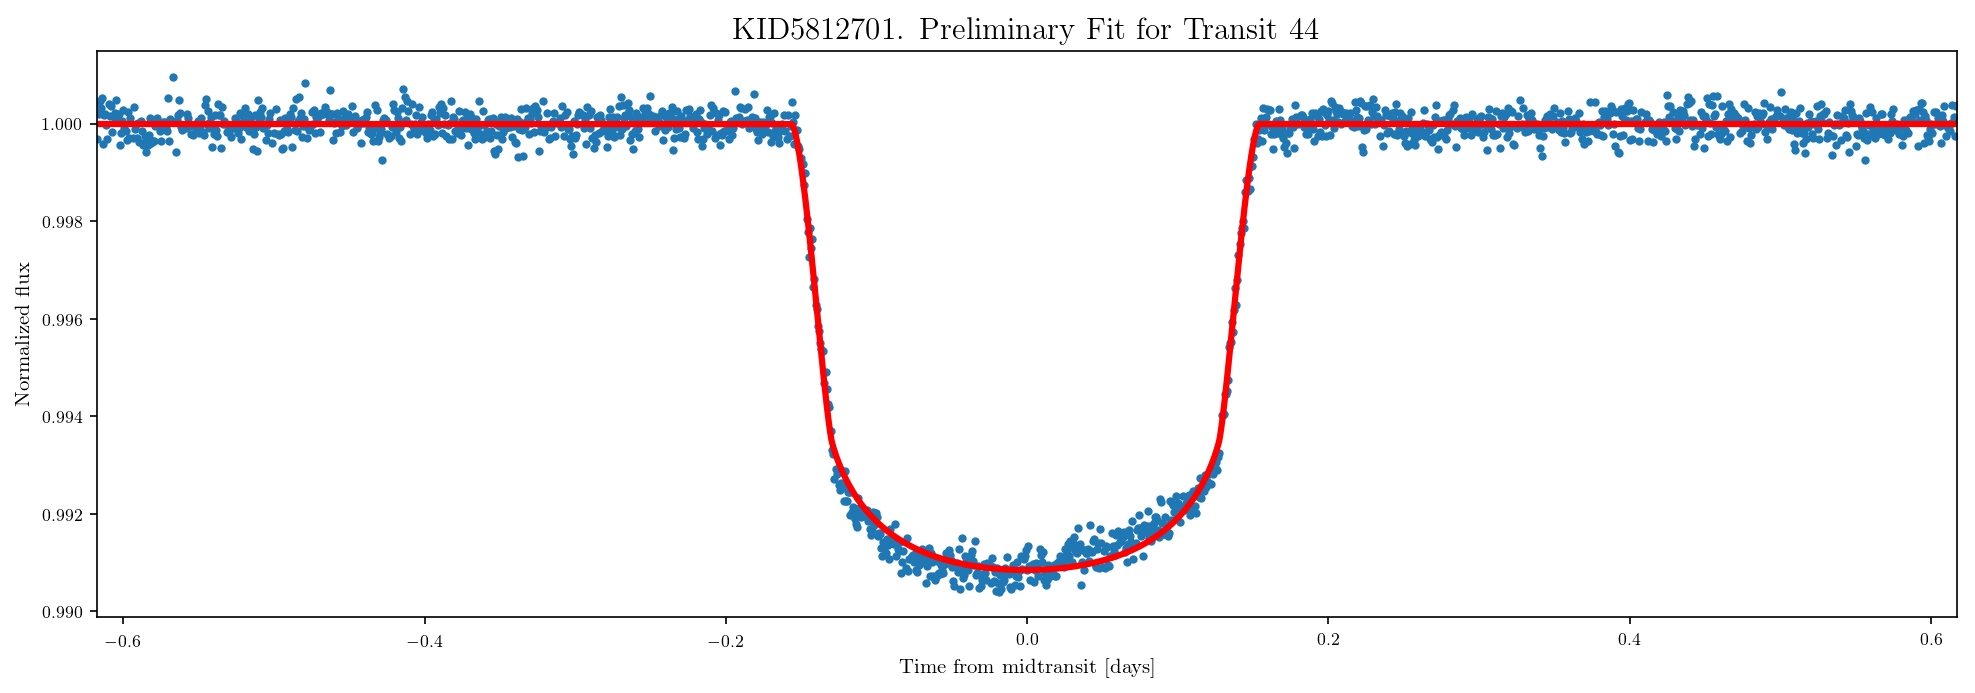

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.310	True=0.309
	Period [days]:	 Fit=16.50128080	True=17.85522168
	Impact Parameter:	 Fit=0.230323	True=0.075000
	Depth:	 Fit=0.007880	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.686	True=1.683
	Sigma (white noise):	 Fit=0.00025
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.23032
Guess of Rp [in Rsun]: 0.14274
Max. allowed b (1+rp_guess/rs): 1.08464


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [10:41<00:00, 15.58it/s]


Multiprocessing took 654.4 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.219 (+0.043,-0.063)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.276 (+0.427,-0.445)

Period [d]:
	True = 17.855
	MCMC Fit = 16.505 (+1.759,-1.493)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0554 (+0.0017,-0.0018)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.682 (+0.044,-0.046)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.389 (+0.068,-0.068)

Mean acceptance fraction: 0.32 (32.18 %) 

*TRANSIT 45
	Signal = nan. Noise (rms) = 0.00022. SNR = nan
	Out-of-transit error of the transit LC = 0.00022

*TRANSIT 46
	Signal = 0.00771. Noise (rms) = 0.00026. SNR = 29.62141
	Out-of-transit error of the transit LC = 0.00026

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990062
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True de

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12942.150053
         Iterations: 3675
         Function evaluations: 5349
Optimization terminated successfully.
         Current function value: -12942.150053
         Iterations: 351
         Function evaluations: 559


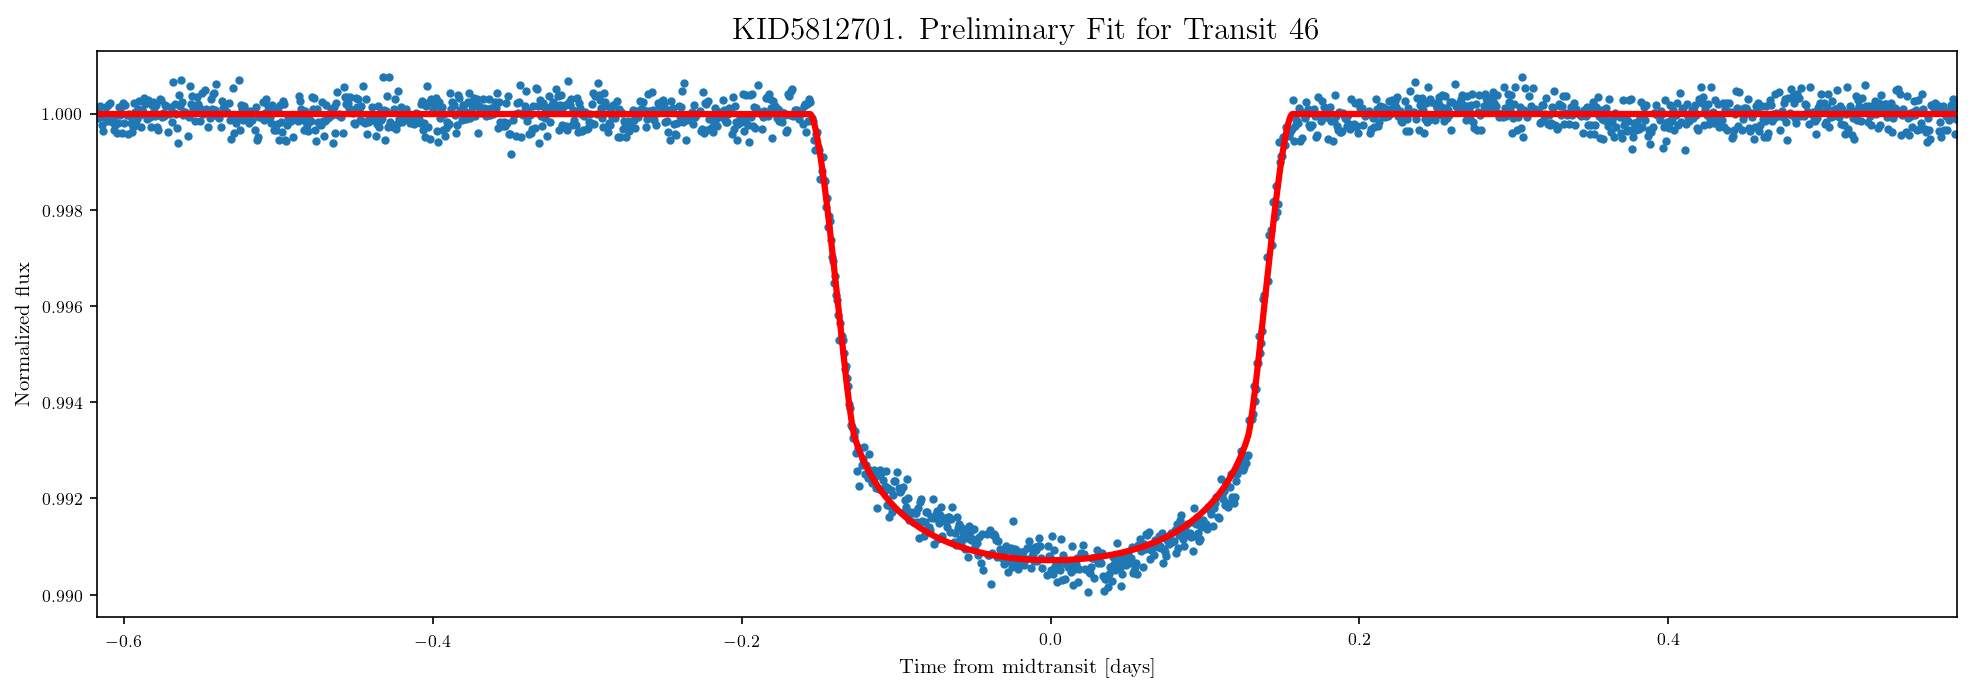

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.312	True=0.309
	Period [days]:	 Fit=17.86052535	True=17.85522168
	Impact Parameter:	 Fit=0.317805	True=0.075000
	Depth:	 Fit=0.008053	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00027
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.31781
Guess of Rp [in Rsun]: 0.14433
Max. allowed b (1+rp_guess/rs): 1.08556


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [11:13<00:00, 15.32it/s]


Multiprocessing took 686.4 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.314 (+0.028,-0.032)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.456 (+0.450,-0.445)

Period [d]:
	True = 17.855
	MCMC Fit = 17.962 (+1.925,-1.709)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0525 (+0.0017,-0.0017)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.682 (+0.046,-0.045)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.386 (+0.069,-0.068)

Mean acceptance fraction: 0.36 (36.32 %) 

*TRANSIT 47
	Signal = 0.00834. Noise (rms) = 0.00025. SNR = 32.95294
	Out-of-transit error of the transit LC = 0.00025

Min flux Folded LC = 0.989510
Min flux individual transit = 0.989766
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13265.357026
         Iterations: 1887
         Function evaluations: 2773
Optimization terminated successfully.
         Current function value: -13316.375683
         Iterations: 897
         Function evaluations: 1320


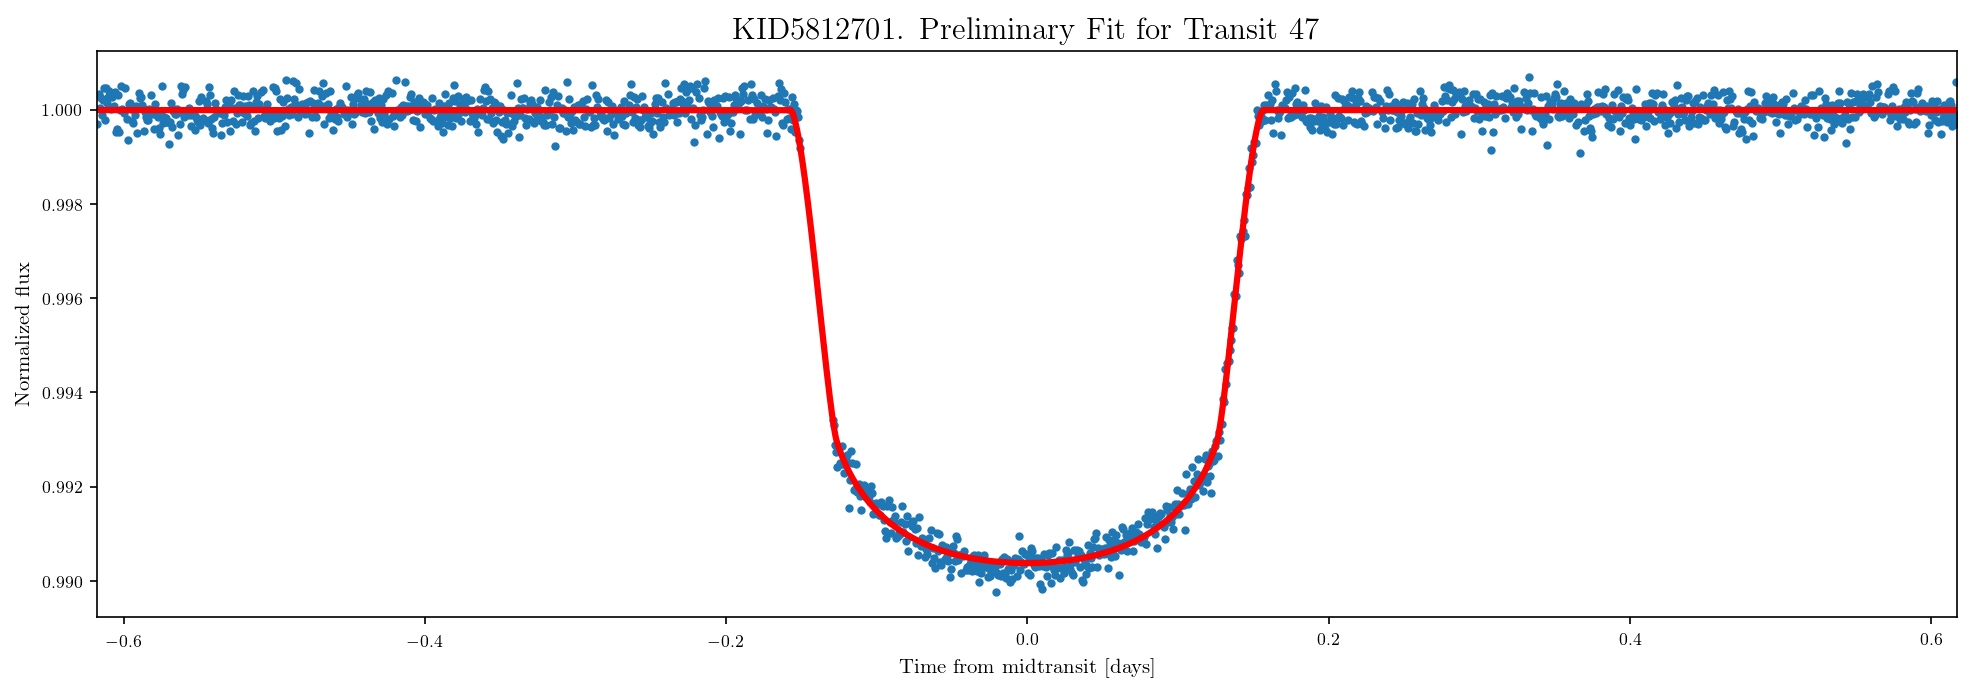

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.314	True=0.309
	Period [days]:	 Fit=18.94195900	True=17.85522168
	Impact Parameter:	 Fit=0.371588	True=0.075000
	Depth:	 Fit=0.008406	True=0.009065
	Stellar mass:	 Fit=1.382	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00025
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.37159
Guess of Rp [in Rsun]: 0.14749
Max. allowed b (1+rp_guess/rs): 1.08742


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [10:39<00:00, 15.92it/s]


Multiprocessing took 651.6 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.370 (+0.023,-0.025)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.829 (+0.448,-0.431)

Period [d]:
	True = 17.855
	MCMC Fit = 19.039 (+1.994,-1.792)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0506 (+0.0016,-0.0015)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.684 (+0.045,-0.043)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.386 (+0.069,-0.069)

Mean acceptance fraction: 0.39 (38.75 %) 

*TRANSIT 48
	Signal = 0.00781. Noise (rms) = 0.00025. SNR = 31.44943
	Out-of-transit error of the transit LC = 0.00025

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990433
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12969.645370
         Iterations: 1674
         Function evaluations: 2524
Optimization terminated successfully.
         Current function value: -12980.055202
         Iterations: 1037
         Function evaluations: 1555


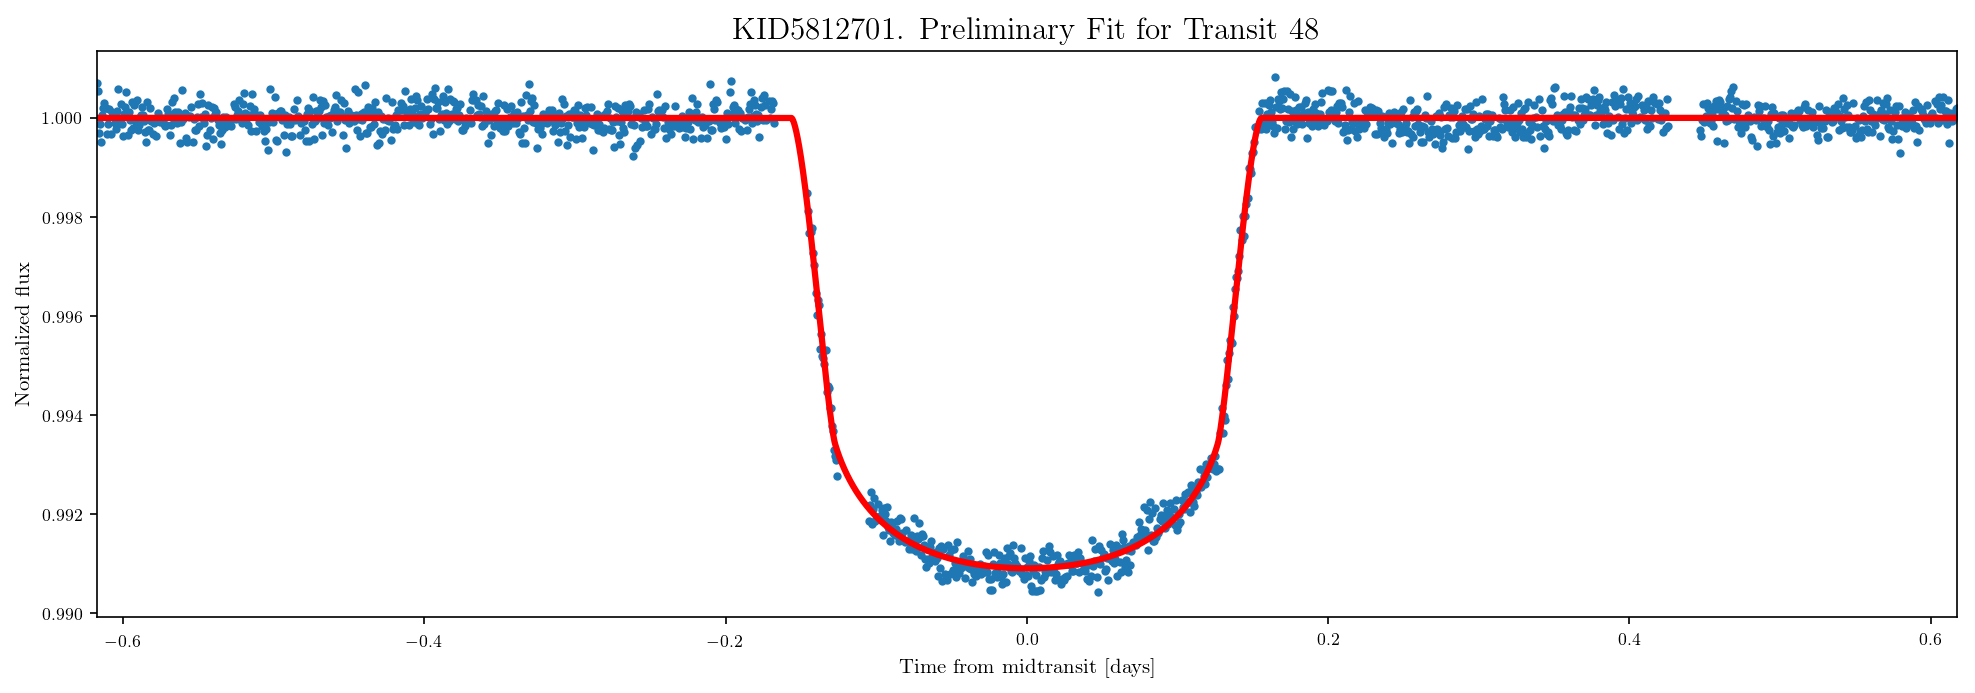

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.312	True=0.309
	Period [days]:	 Fit=18.37030191	True=17.85522168
	Impact Parameter:	 Fit=0.348497	True=0.075000
	Depth:	 Fit=0.007918	True=0.009065
	Stellar mass:	 Fit=1.382	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00024
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.34850
Guess of Rp [in Rsun]: 0.14315
Max. allowed b (1+rp_guess/rs): 1.08484


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [10:13<00:00, 15.42it/s]


Multiprocessing took 625.0 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.347 (+0.025,-0.027)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.312 (+0.431,-0.430)

Period [d]:
	True = 17.855
	MCMC Fit = 18.572 (+1.929,-1.723)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0515 (+0.0016,-0.0016)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.681 (+0.044,-0.044)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.387 (+0.069,-0.069)

Mean acceptance fraction: 0.37 (37.17 %) 

*TRANSIT 49
	Signal = 0.00754. Noise (rms) = 0.00027. SNR = 28.20325
	Out-of-transit error of the transit LC = 0.00027

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990156
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13434.340133
         Iterations: 2745
         Function evaluations: 4023
Optimization terminated successfully.
         Current function value: -13434.497613
         Iterations: 385
         Function evaluations: 598


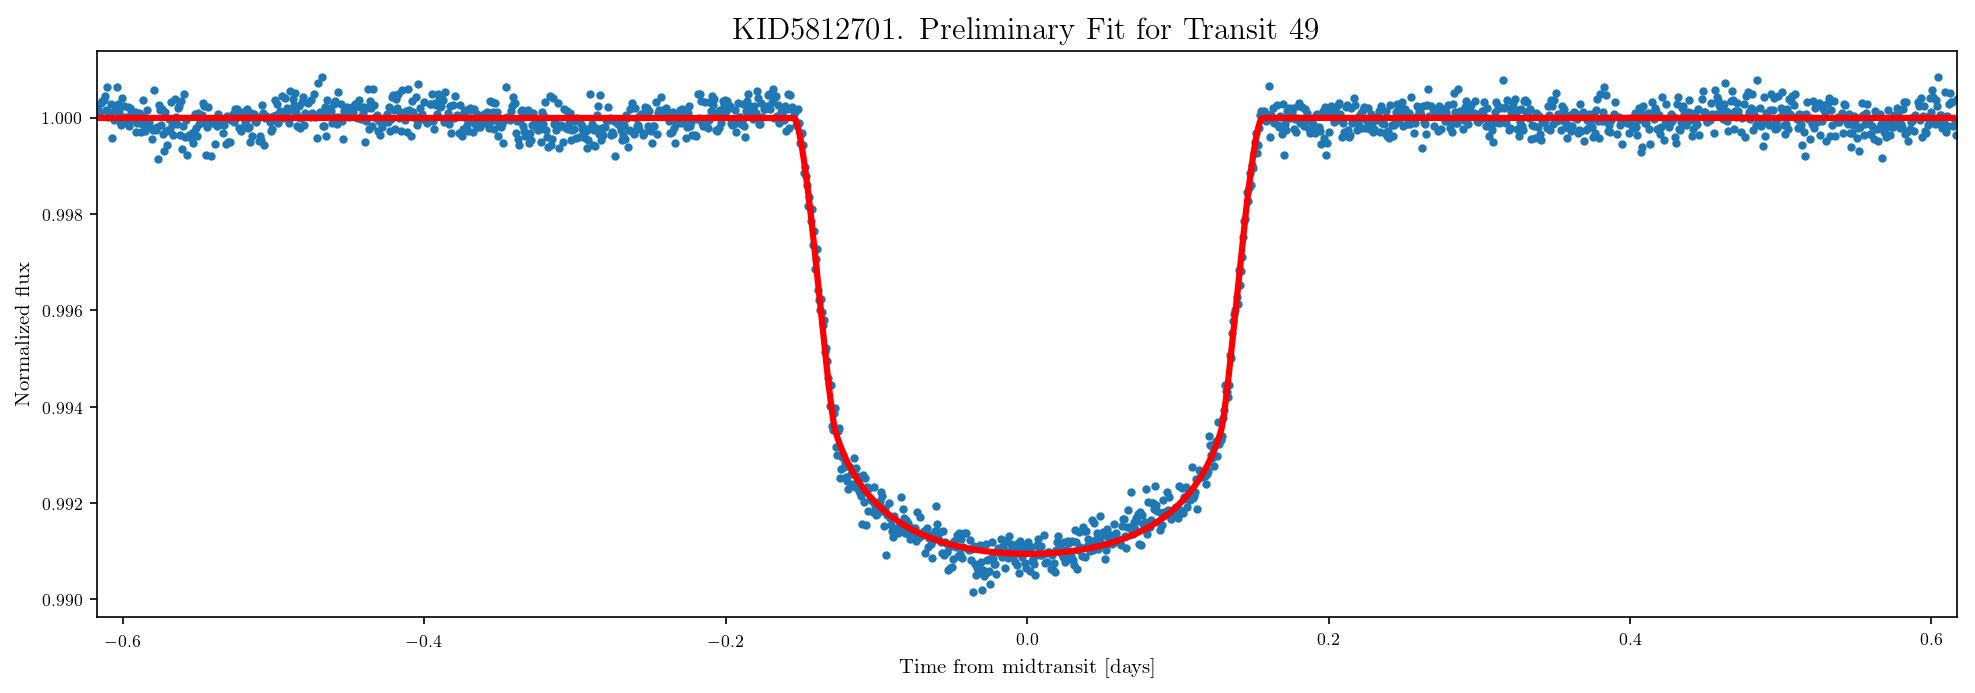

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.310	True=0.309
	Period [days]:	 Fit=16.94149577	True=17.85522168
	Impact Parameter:	 Fit=0.261899	True=0.075000
	Depth:	 Fit=0.007816	True=0.009065
	Stellar mass:	 Fit=1.384	True=1.386
	Stellar radius:	 Fit=1.685	True=1.683
	Sigma (white noise):	 Fit=0.00026
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.26190
Guess of Rp [in Rsun]: 0.14202
Max. allowed b (1+rp_guess/rs): 1.08429


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [11:49<00:00, 15.46it/s]


Multiprocessing took 723.0 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.257 (+0.036,-0.044)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.204 (+0.427,-0.429)

Period [d]:
	True = 17.855
	MCMC Fit = 16.987 (+1.813,-1.591)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0544 (+0.0017,-0.0017)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.681 (+0.044,-0.045)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.388 (+0.069,-0.069)

Mean acceptance fraction: 0.34 (34.42 %) 

*TRANSIT 51
	Signal = 0.00800. Noise (rms) = 0.00025. SNR = 31.45396
	Out-of-transit error of the transit LC = 0.00025

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990195
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -10049.214163
         Iterations: 1109
         Function evaluations: 1670
Optimization terminated successfully.
         Current function value: -10107.400697
         Iterations: 1056
         Function evaluations: 1556


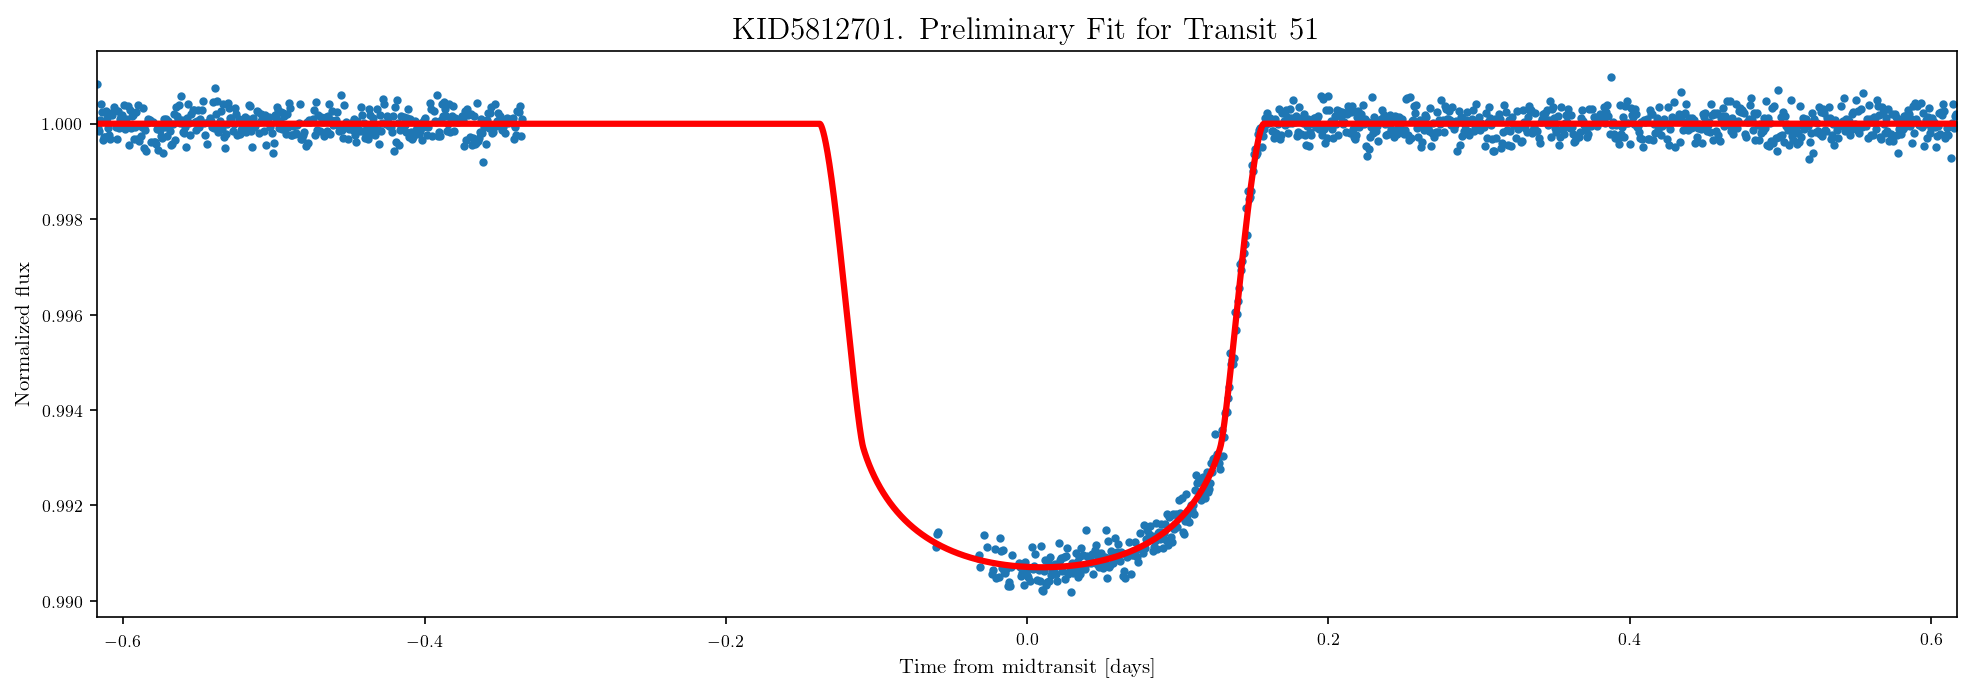

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.295	True=0.309
	Period [days]:	 Fit=16.28131706	True=17.85522168
	Impact Parameter:	 Fit=0.399408	True=0.075000
	Depth:	 Fit=0.008147	True=0.009065
	Stellar mass:	 Fit=1.382	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00025
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.39941
Guess of Rp [in Rsun]: 0.14520
Max. allowed b (1+rp_guess/rs): 1.08606


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [07:56<00:00, 22.02it/s]


Multiprocessing took 485.0 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.388 (+0.040,-0.050)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.546 (+0.419,-0.427)

Period [d]:
	True = 17.855
	MCMC Fit = 16.524 (+1.812,-1.598)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0559 (+0.0017,-0.0017)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.683 (+0.042,-0.043)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.387 (+0.069,-0.068)

Mean acceptance fraction: 0.36 (35.95 %) 

*TRANSIT 52
	Signal = 0.00760. Noise (rms) = 0.00025. SNR = 29.83905
	Out-of-transit error of the transit LC = 0.00025

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990469
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13479.494574
         Iterations: 2242
         Function evaluations: 3309
Optimization terminated successfully.
         Current function value: -13508.979848
         Iterations: 1038
         Function evaluations: 1526


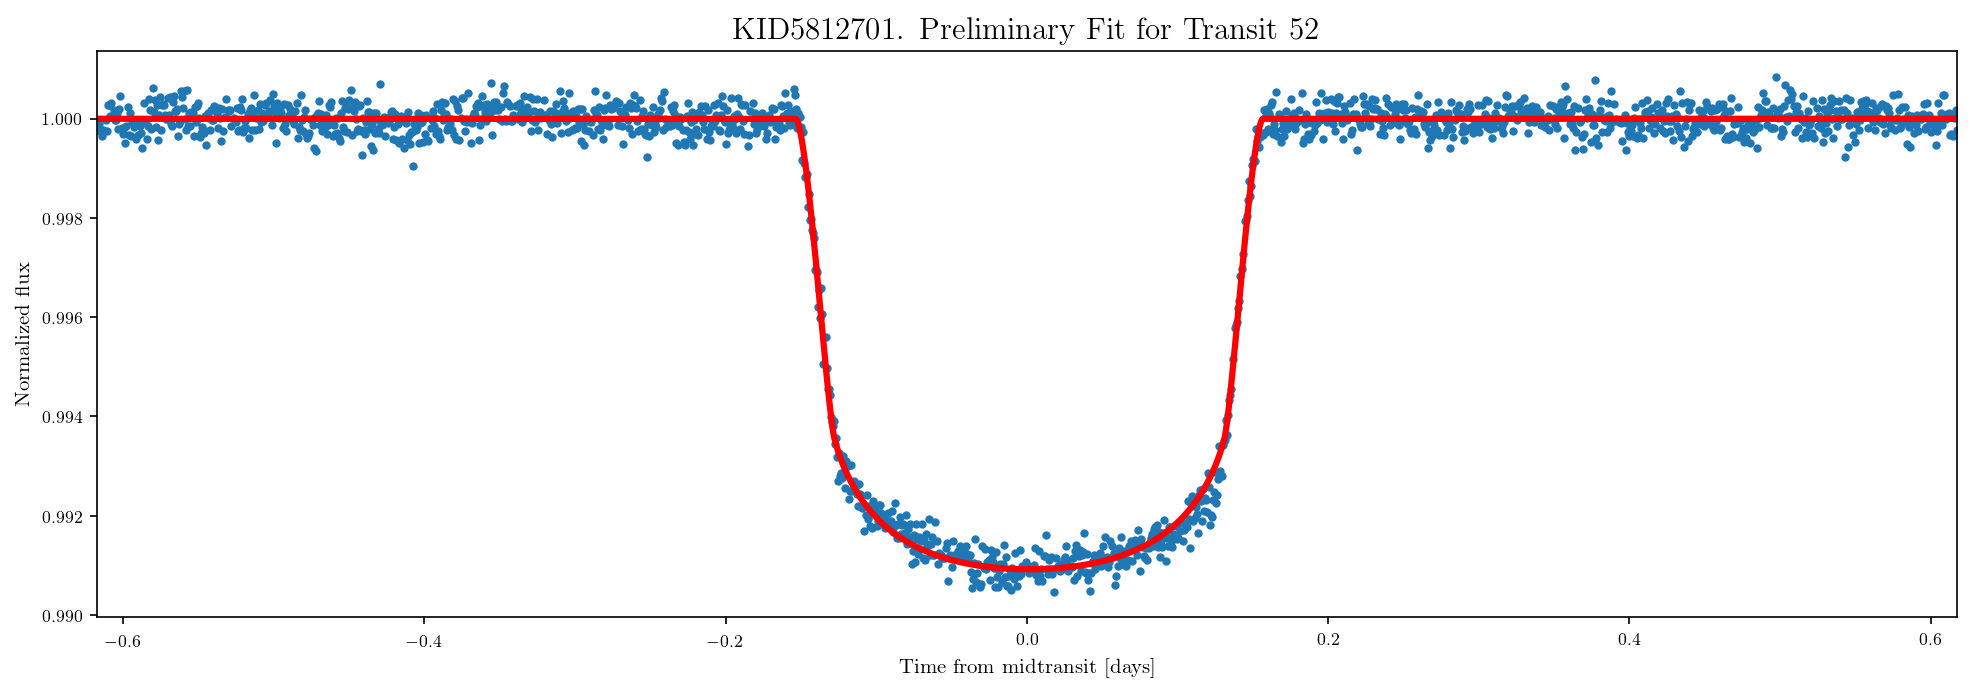

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.310	True=0.309
	Period [days]:	 Fit=15.45861142	True=17.85522168
	Impact Parameter:	 Fit=0.069999	True=0.075000
	Depth:	 Fit=0.007760	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.686	True=1.683
	Sigma (white noise):	 Fit=0.00026
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.07000
Guess of Rp [in Rsun]: 0.14164
Max. allowed b (1+rp_guess/rs): 1.08399


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [10:55<00:00, 15.14it/s]


Multiprocessing took 669.2 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.092 (+0.070,-0.062)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.146 (+0.392,-0.420)

Period [d]:
	True = 17.855
	MCMC Fit = 15.855 (+1.555,-1.313)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0577 (+0.0016,-0.0017)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.680 (+0.041,-0.044)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.389 (+0.068,-0.066)

Mean acceptance fraction: 0.31 (31.19 %) 

*TRANSIT 53
	Signal = 0.00749. Noise (rms) = 0.00025. SNR = 29.45808
	Out-of-transit error of the transit LC = 0.00025

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990232
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13425.312790
         Iterations: 2069
         Function evaluations: 3019
Optimization terminated successfully.
         Current function value: -13522.405836
         Iterations: 1227
         Function evaluations: 1795


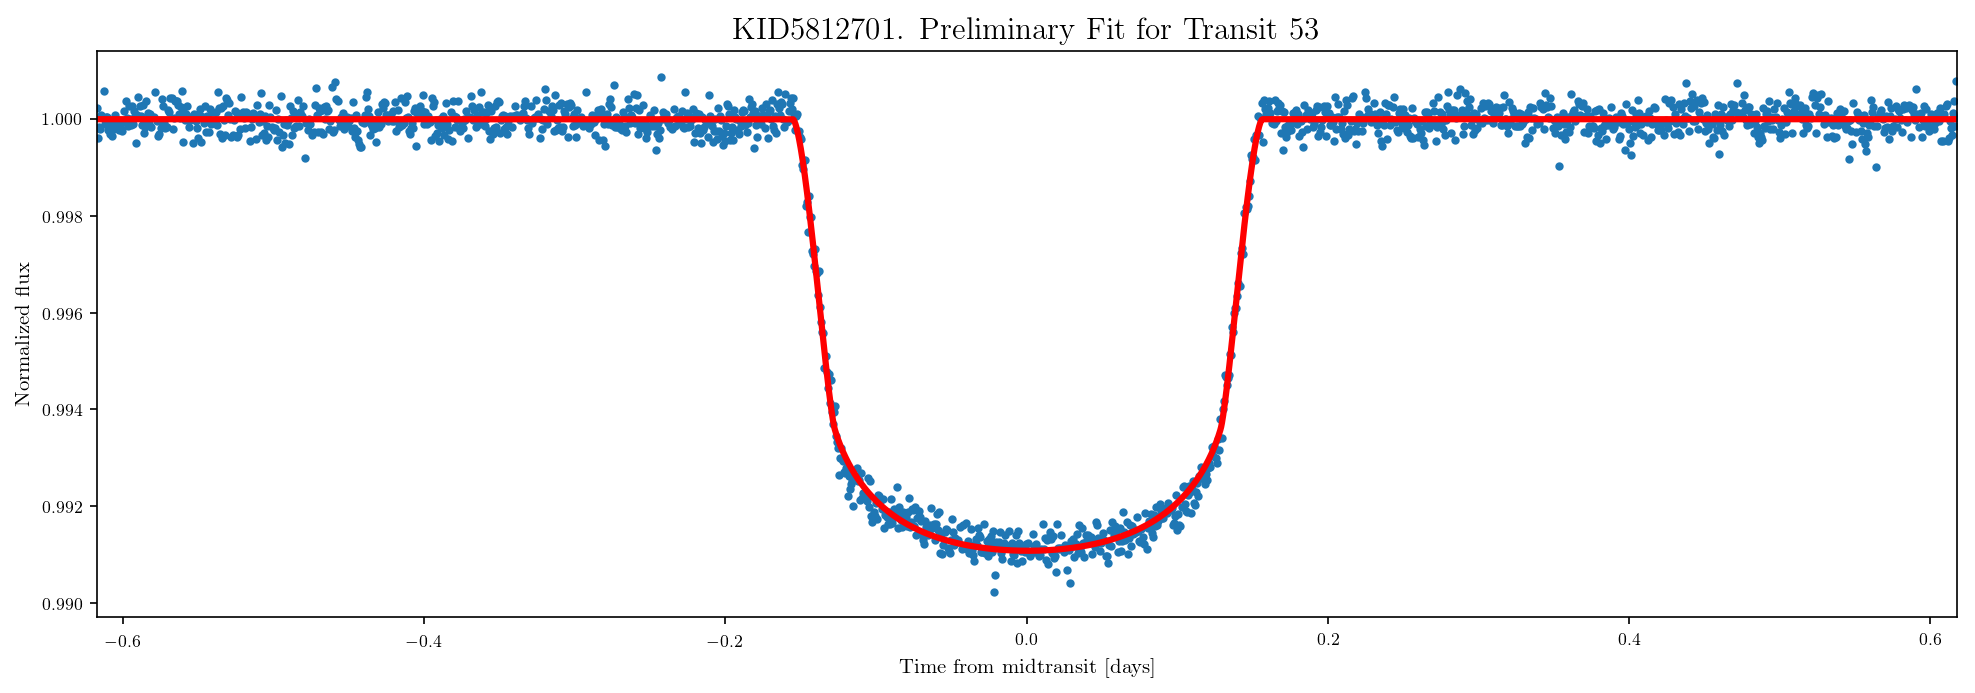

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.312	True=0.309
	Period [days]:	 Fit=17.64394938	True=17.85522168
	Impact Parameter:	 Fit=0.302330	True=0.075000
	Depth:	 Fit=0.007727	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.686	True=1.683
	Sigma (white noise):	 Fit=0.00025
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.30233
Guess of Rp [in Rsun]: 0.14134
Max. allowed b (1+rp_guess/rs): 1.08381


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [11:57<00:00, 13.62it/s]


Multiprocessing took 731.1 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.300 (+0.031,-0.036)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.123 (+0.417,-0.424)

Period [d]:
	True = 17.855
	MCMC Fit = 17.758 (+1.851,-1.652)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0529 (+0.0016,-0.0016)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.682 (+0.043,-0.044)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.387 (+0.070,-0.068)

Mean acceptance fraction: 0.36 (35.75 %) 

*TRANSIT 54
	Signal = 0.00737. Noise (rms) = 0.00025. SNR = 29.14954
	Out-of-transit error of the transit LC = 0.00025

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990522
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13247.869871
         Iterations: 2929
         Function evaluations: 4303
Optimization terminated successfully.
         Current function value: -13249.567992
         Iterations: 391
         Function evaluations: 610


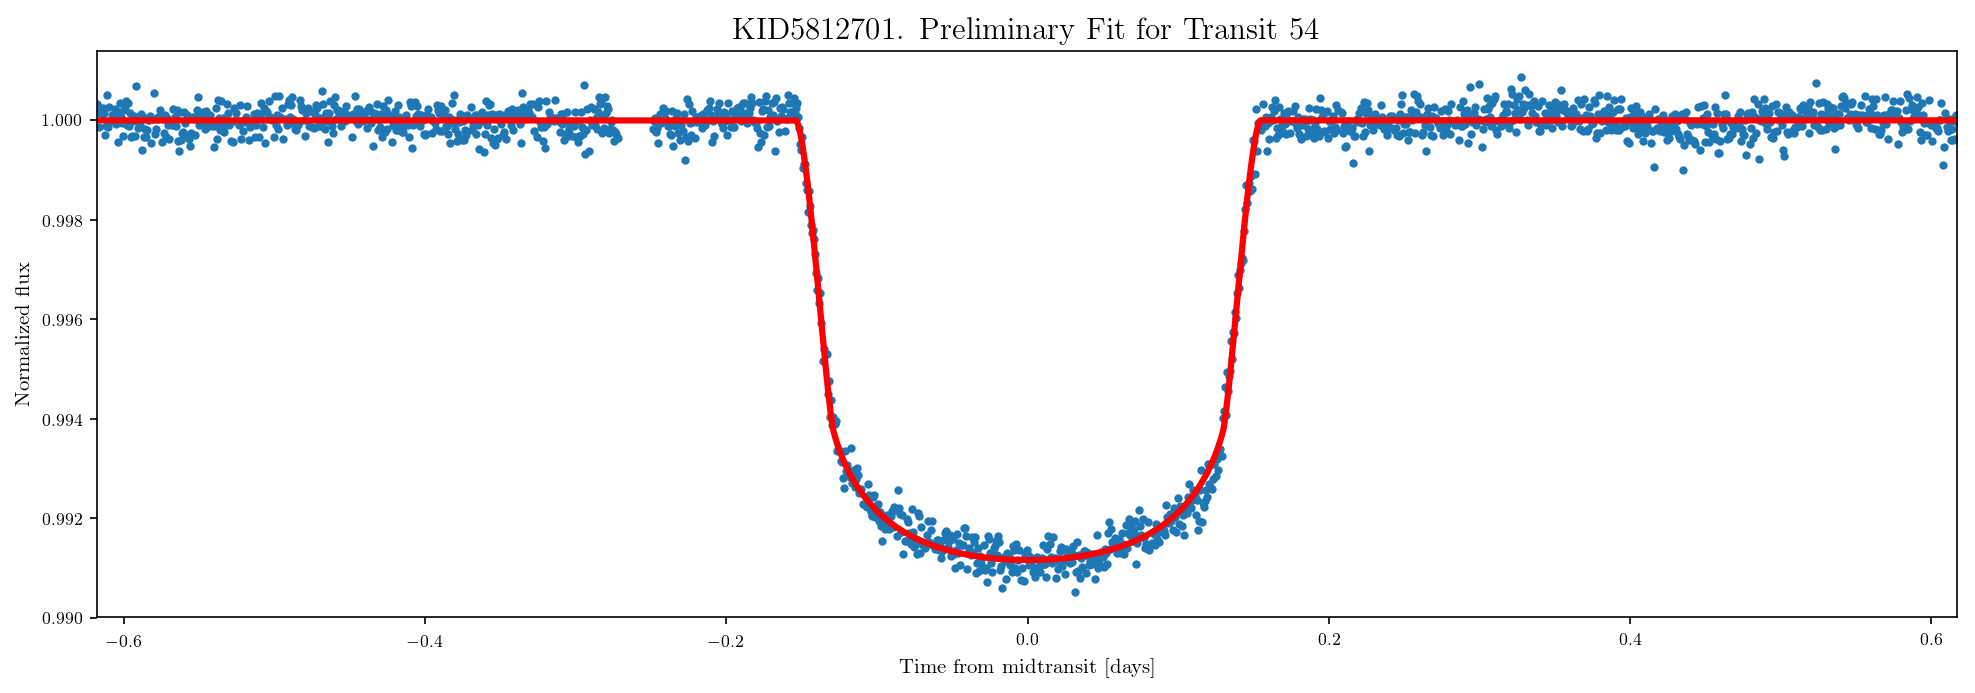

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.308	True=0.309
	Period [days]:	 Fit=15.12627357	True=17.85522168
	Impact Parameter:	 Fit=0.000000	True=0.075000
	Depth:	 Fit=0.007552	True=0.009065
	Stellar mass:	 Fit=1.382	True=1.386
	Stellar radius:	 Fit=1.688	True=1.683
	Sigma (white noise):	 Fit=0.00025
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.00000
Guess of Rp [in Rsun]: 0.13985
Max. allowed b (1+rp_guess/rs): 1.08286


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [11:08<00:00, 14.83it/s]


Multiprocessing took 681.8 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.243 (+0.042,-0.080)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.028 (+0.416,-0.422)

Period [d]:
	True = 17.855
	MCMC Fit = 16.692 (+1.748,-1.579)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0587 (+0.0018,-0.0018)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.683 (+0.043,-0.044)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.387 (+0.069,-0.068)

Mean acceptance fraction: 0.34 (33.52 %) 

*TRANSIT 55
	Signal = 0.00833. Noise (rms) = 0.00028. SNR = 30.02052
	Out-of-transit error of the transit LC = 0.00028

Min flux Folded LC = 0.989510
Min flux individual transit = 0.989510
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13180.397554
         Iterations: 2746
         Function evaluations: 4042
Optimization terminated successfully.
         Current function value: -13194.554263
         Iterations: 729
         Function evaluations: 1078


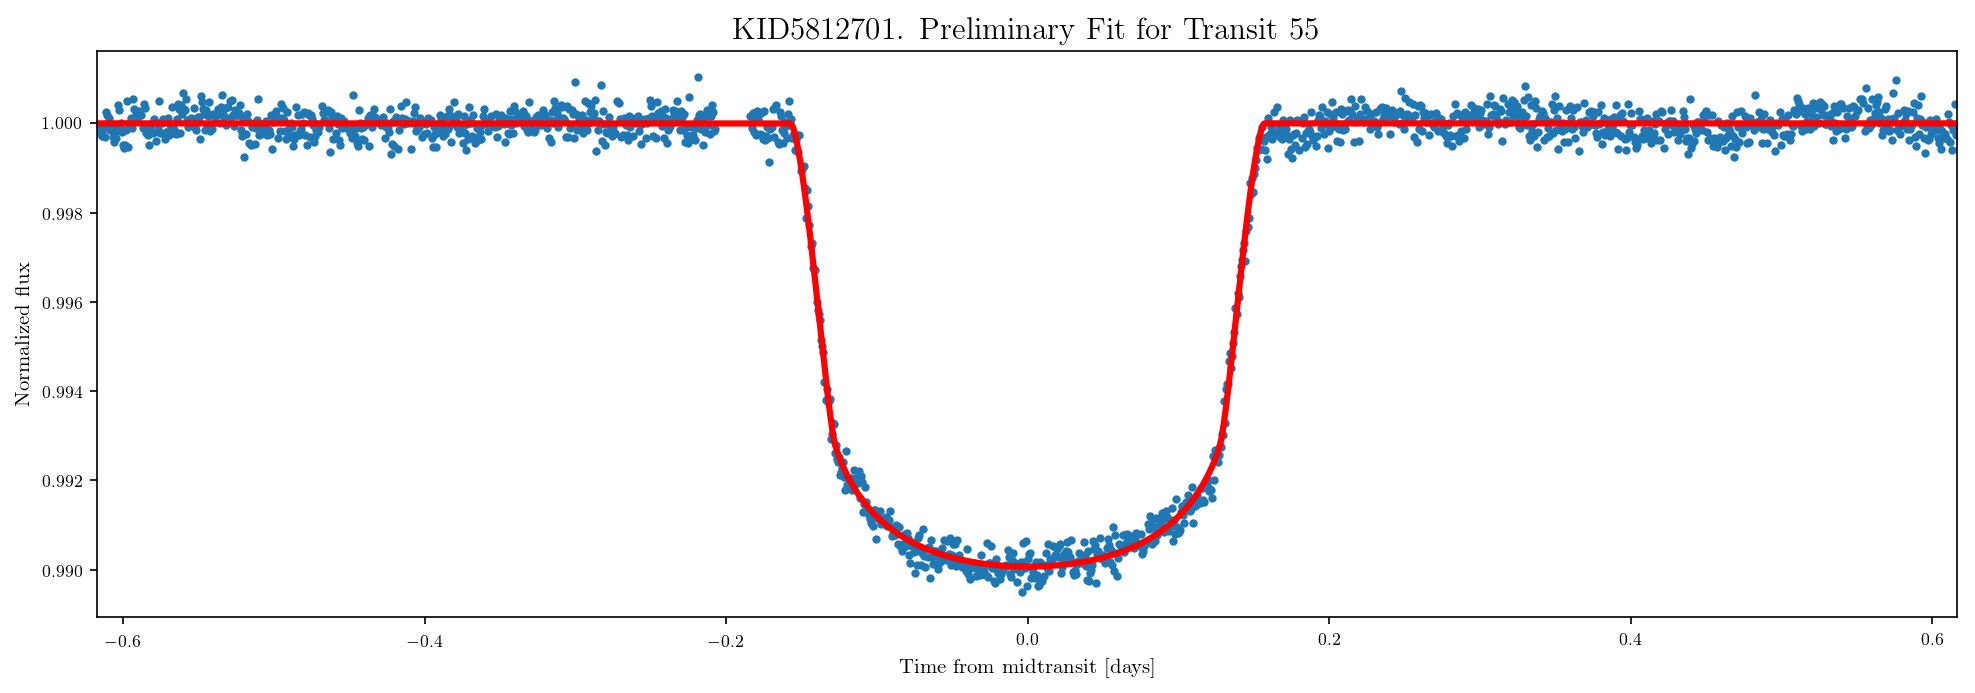

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.314	True=0.309
	Period [days]:	 Fit=17.92662787	True=17.85522168
	Impact Parameter:	 Fit=0.308606	True=0.075000
	Depth:	 Fit=0.008606	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00027
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.30861
Guess of Rp [in Rsun]: 0.14920
Max. allowed b (1+rp_guess/rs): 1.08845


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [12:22<00:00, 13.47it/s]


Multiprocessing took 756.9 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.009 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.305 (+0.029,-0.033)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 17.028 (+0.448,-0.449)

Period [d]:
	True = 17.855
	MCMC Fit = 18.023 (+1.835,-1.667)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0524 (+0.0016,-0.0016)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.684 (+0.044,-0.044)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.388 (+0.069,-0.069)

Mean acceptance fraction: 0.36 (35.98 %) 

*TRANSIT 56
	Signal = 0.00740. Noise (rms) = 0.00025. SNR = 29.63851
	Out-of-transit error of the transit LC = 0.00025

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990600
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -11102.873937
         Iterations: 1509
         Function evaluations: 2250
Optimization terminated successfully.
         Current function value: -11150.740902
         Iterations: 1186
         Function evaluations: 1749


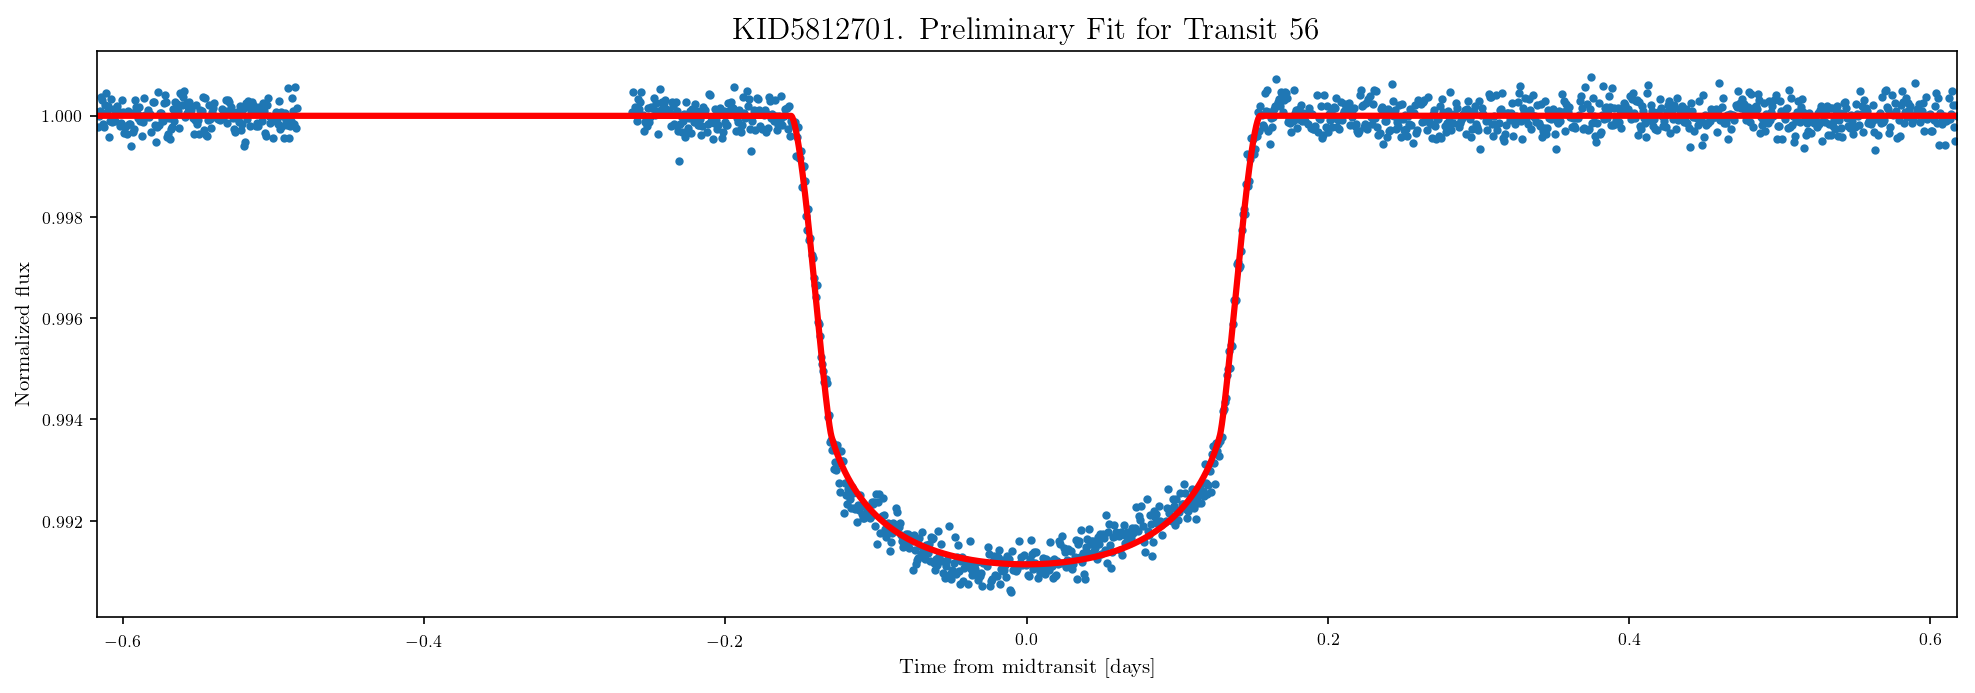

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.311	True=0.309
	Period [days]:	 Fit=16.86932232	True=17.85522168
	Impact Parameter:	 Fit=0.245276	True=0.075000
	Depth:	 Fit=0.007634	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00026
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.24528
Guess of Rp [in Rsun]: 0.14050
Max. allowed b (1+rp_guess/rs): 1.08330


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [11:09<00:00, 15.25it/s]


Multiprocessing took 683.8 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.235 (+0.040,-0.053)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.028 (+0.421,-0.419)

Period [d]:
	True = 17.855
	MCMC Fit = 16.875 (+1.695,-1.577)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0546 (+0.0017,-0.0017)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.683 (+0.044,-0.044)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.387 (+0.070,-0.068)

Mean acceptance fraction: 0.33 (33.31 %) 

*TRANSIT 57
	Signal = 0.00764. Noise (rms) = 0.00025. SNR = 30.88122
	Out-of-transit error of the transit LC = 0.00025

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990254
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13445.932208
         Iterations: 2294
         Function evaluations: 3361
Optimization terminated successfully.
         Current function value: -13453.698027
         Iterations: 688
         Function evaluations: 1032


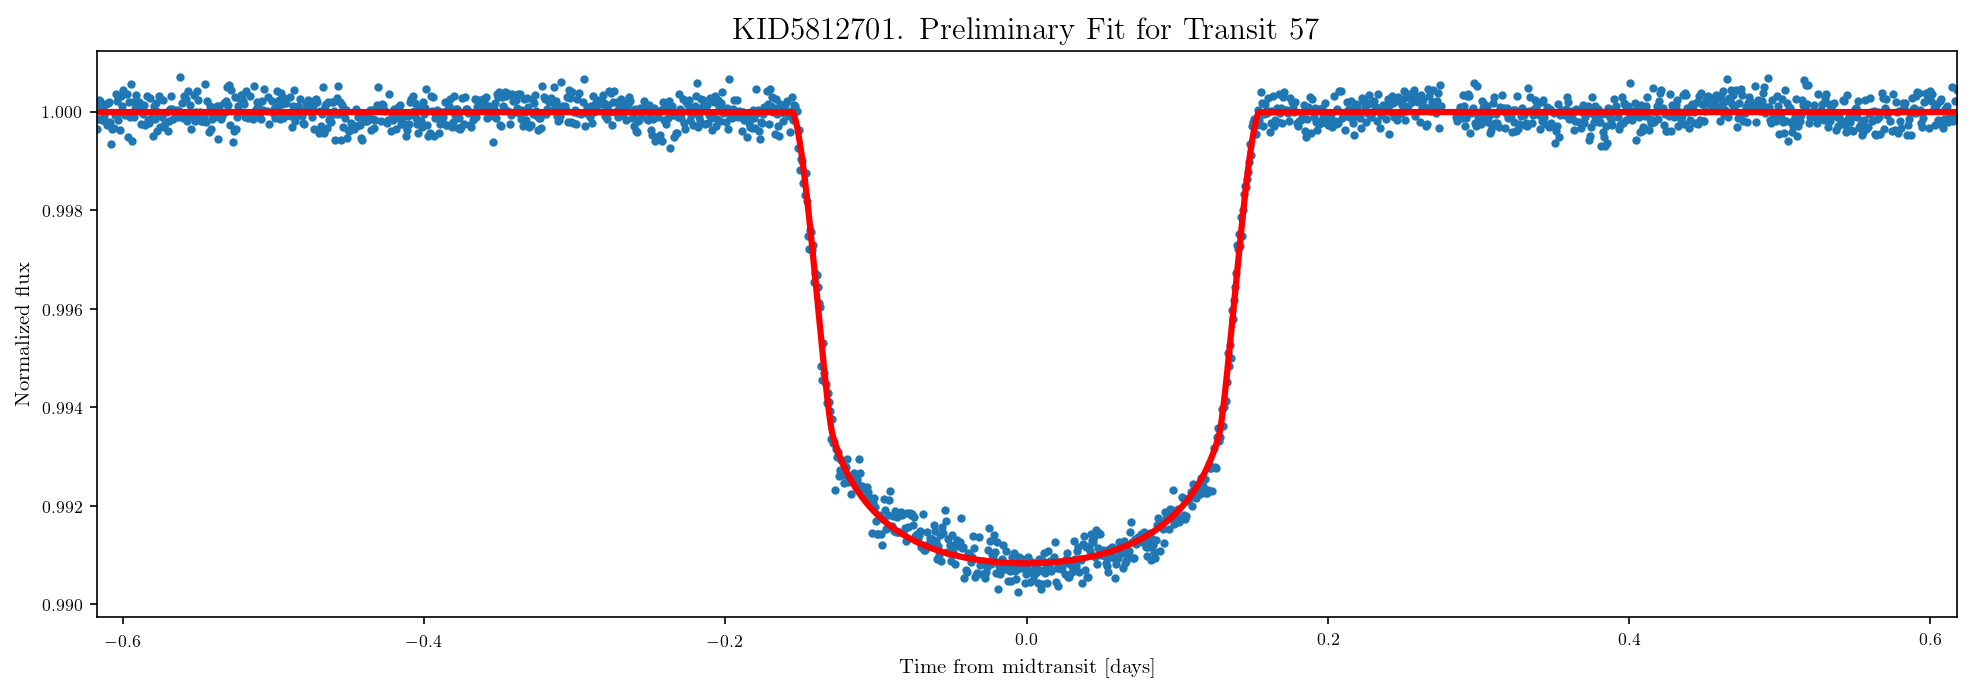

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.310	True=0.309
	Period [days]:	 Fit=16.32470959	True=17.85522168
	Impact Parameter:	 Fit=0.218007	True=0.075000
	Depth:	 Fit=0.007885	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00025
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.21801
Guess of Rp [in Rsun]: 0.14282
Max. allowed b (1+rp_guess/rs): 1.08467


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [11:32<00:00, 16.16it/s]


Multiprocessing took 707.0 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.206 (+0.043,-0.061)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.289 (+0.412,-0.409)

Period [d]:
	True = 17.855
	MCMC Fit = 16.328 (+1.617,-1.452)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0558 (+0.0016,-0.0016)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.683 (+0.043,-0.042)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.388 (+0.068,-0.068)

Mean acceptance fraction: 0.32 (32.28 %) 

*TRANSIT 58
	Signal = 0.00761. Noise (rms) = 0.00025. SNR = 31.02121
	Out-of-transit error of the transit LC = 0.00025

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990119
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13259.604753
         Iterations: 2431
         Function evaluations: 3604
Optimization terminated successfully.
         Current function value: -13265.010476
         Iterations: 1823
         Function evaluations: 2660


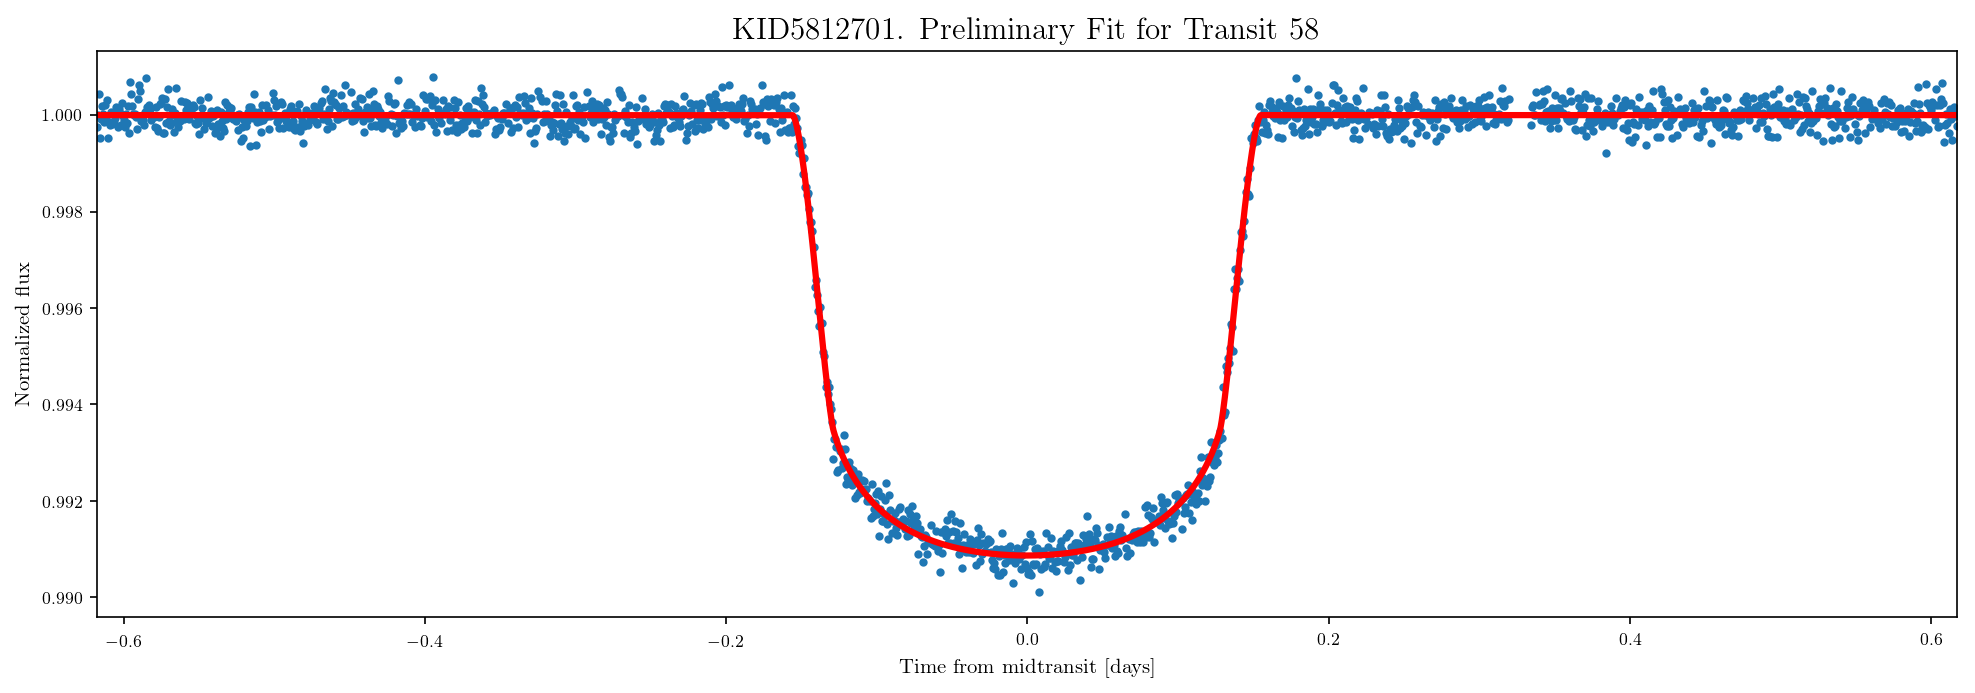

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.311	True=0.309
	Period [days]:	 Fit=16.80546869	True=17.85522168
	Impact Parameter:	 Fit=0.252291	True=0.075000
	Depth:	 Fit=0.007873	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00025
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.25229
Guess of Rp [in Rsun]: 0.14269
Max. allowed b (1+rp_guess/rs): 1.08460


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [12:40<00:00, 14.36it/s]


Multiprocessing took 773.1 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.247 (+0.035,-0.043)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.261 (+0.433,-0.437)

Period [d]:
	True = 17.855
	MCMC Fit = 16.953 (+1.816,-1.593)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0546 (+0.0017,-0.0017)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.681 (+0.044,-0.045)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.391 (+0.067,-0.069)

Mean acceptance fraction: 0.34 (34.34 %) 

*TRANSIT 60
	Signal = nan. Noise (rms) = 0.00023. SNR = nan
	Out-of-transit error of the transit LC = 0.00023

*TRANSIT 61
	Signal = 0.00774. Noise (rms) = 0.00025. SNR = 31.55442
	Out-of-transit error of the transit LC = 0.00025

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990194
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True de

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12441.237739
         Iterations: 1559
         Function evaluations: 2319
Optimization terminated successfully.
         Current function value: -12493.529610
         Iterations: 962
         Function evaluations: 1413


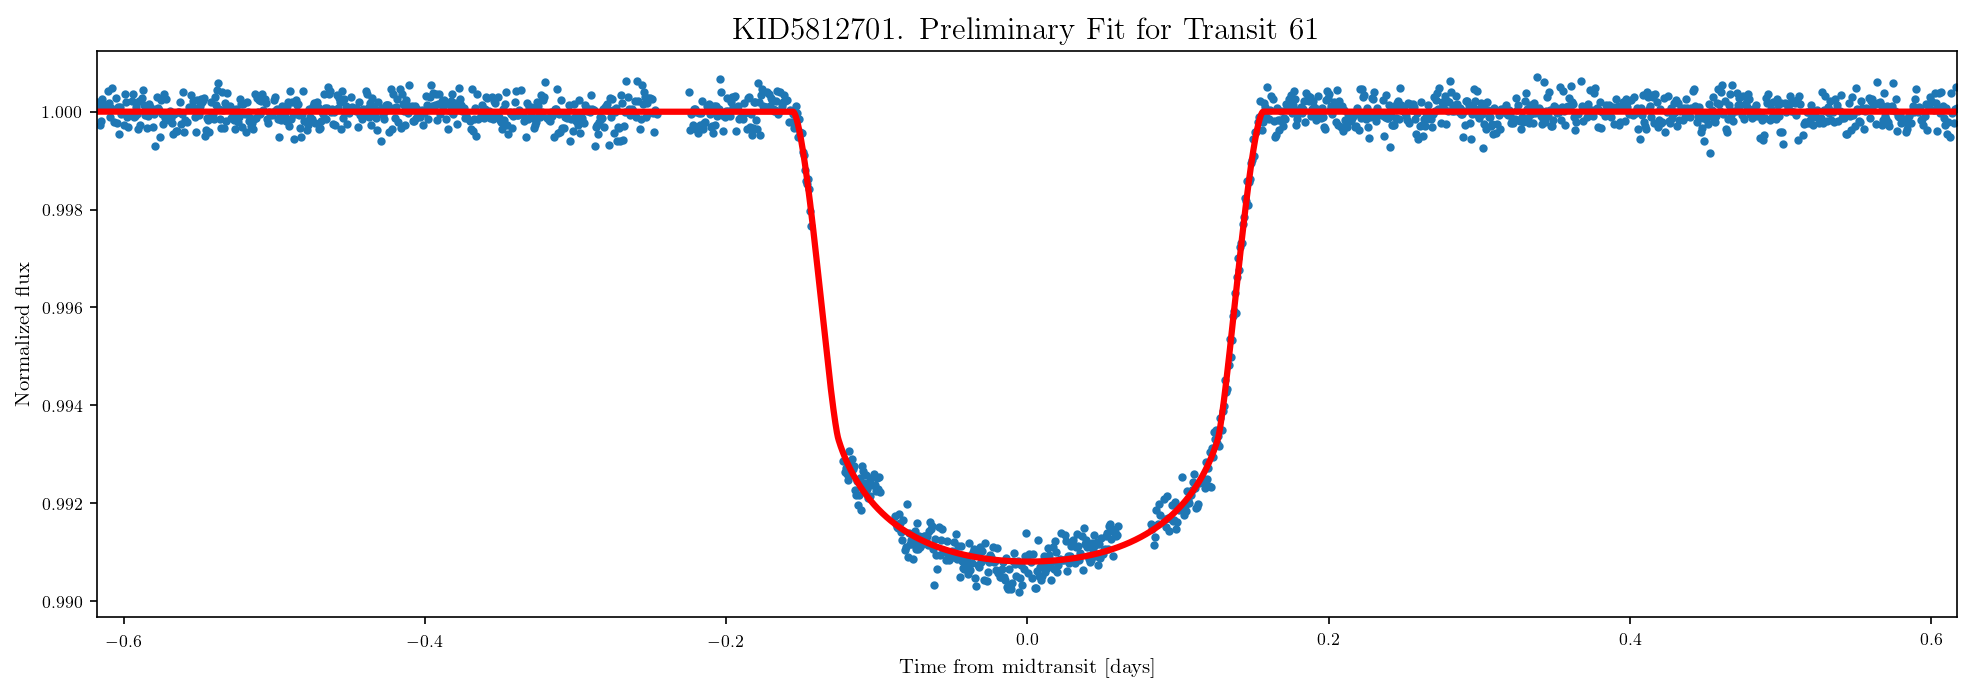

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.312	True=0.309
	Period [days]:	 Fit=19.06484747	True=17.85522168
	Impact Parameter:	 Fit=0.386363	True=0.075000
	Depth:	 Fit=0.008042	True=0.009065
	Stellar mass:	 Fit=1.382	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00025
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.38636
Guess of Rp [in Rsun]: 0.14426
Max. allowed b (1+rp_guess/rs): 1.08550


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [10:16<00:00, 16.19it/s]


Multiprocessing took 628.7 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.385 (+0.027,-0.031)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.472 (+0.436,-0.441)

Period [d]:
	True = 17.855
	MCMC Fit = 19.171 (+2.047,-1.835)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0504 (+0.0016,-0.0016)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.684 (+0.045,-0.045)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.387 (+0.069,-0.069)

Mean acceptance fraction: 0.38 (37.62 %) 

*TRANSIT 62
	Signal = 0.00741. Noise (rms) = 0.00025. SNR = 30.18641
	Out-of-transit error of the transit LC = 0.00025

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990516
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12426.457216
         Iterations: 1606
         Function evaluations: 2395
Optimization terminated successfully.
         Current function value: -12502.778583
         Iterations: 1654
         Function evaluations: 2399


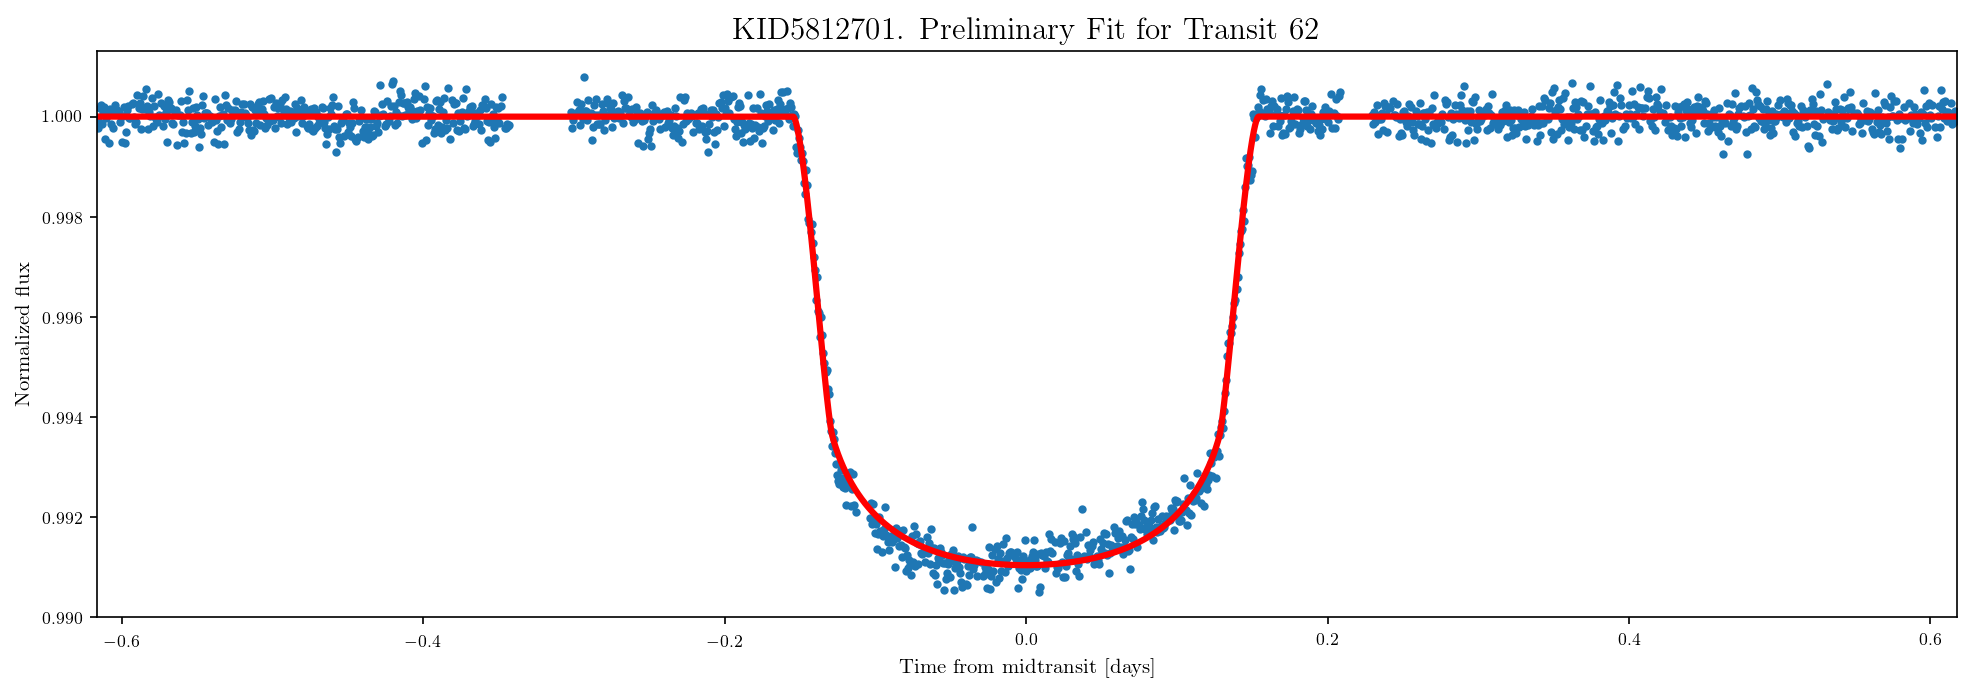

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.309	True=0.309
	Period [days]:	 Fit=15.82249072	True=17.85522168
	Impact Parameter:	 Fit=0.176331	True=0.075000
	Depth:	 Fit=0.007683	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.686	True=1.683
	Sigma (white noise):	 Fit=0.00026
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.17633
Guess of Rp [in Rsun]: 0.14094
Max. allowed b (1+rp_guess/rs): 1.08357


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [10:52<00:00, 15.33it/s]


Multiprocessing took 665.3 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.161 (+0.058,-0.088)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.039 (+0.409,-0.417)

Period [d]:
	True = 17.855
	MCMC Fit = 15.949 (+1.694,-1.379)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0568 (+0.0016,-0.0018)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.679 (+0.043,-0.044)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.389 (+0.069,-0.066)

Mean acceptance fraction: 0.30 (29.80 %) 

*TRANSIT 63
	Signal = 0.00709. Noise (rms) = 0.00024. SNR = 29.03521
	Out-of-transit error of the transit LC = 0.00024

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990888
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12464.826819
         Iterations: 3859
         Function evaluations: 5635
Optimization terminated successfully.
         Current function value: -12464.826792
         Iterations: 294
         Function evaluations: 464


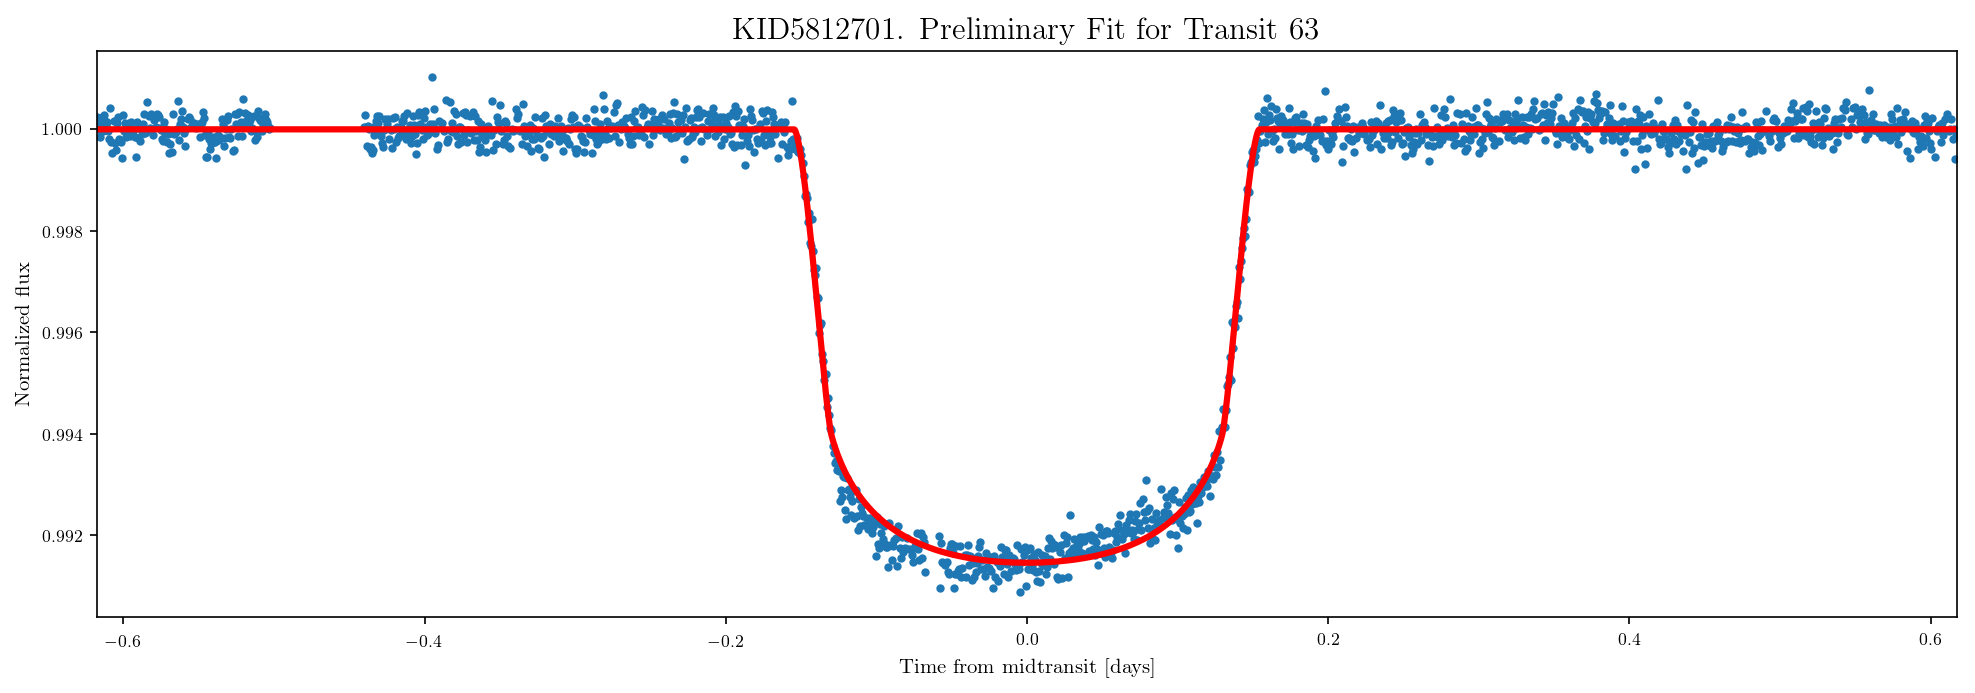

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.309	True=0.309
	Period [days]:	 Fit=15.49185148	True=17.85522168
	Impact Parameter:	 Fit=0.093284	True=0.075000
	Depth:	 Fit=0.007303	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.686	True=1.683
	Sigma (white noise):	 Fit=0.00026
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.09328
Guess of Rp [in Rsun]: 0.13740
Max. allowed b (1+rp_guess/rs): 1.08148


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [10:39<00:00, 15.64it/s]


Multiprocessing took 653.0 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.007 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.101 (+0.077,-0.069)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.661 (+0.380,-0.406)

Period [d]:
	True = 17.855
	MCMC Fit = 15.903 (+1.611,-1.317)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0576 (+0.0016,-0.0017)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.680 (+0.041,-0.044)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.393 (+0.068,-0.067)

Mean acceptance fraction: 0.31 (30.61 %) 

*TRANSIT 64
	Signal = 0.00731. Noise (rms) = 0.00025. SNR = 29.41859
	Out-of-transit error of the transit LC = 0.00025

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990728
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13402.847274
         Iterations: 1823
         Function evaluations: 2730
Optimization terminated successfully.
         Current function value: -13430.172111
         Iterations: 1443
         Function evaluations: 2120


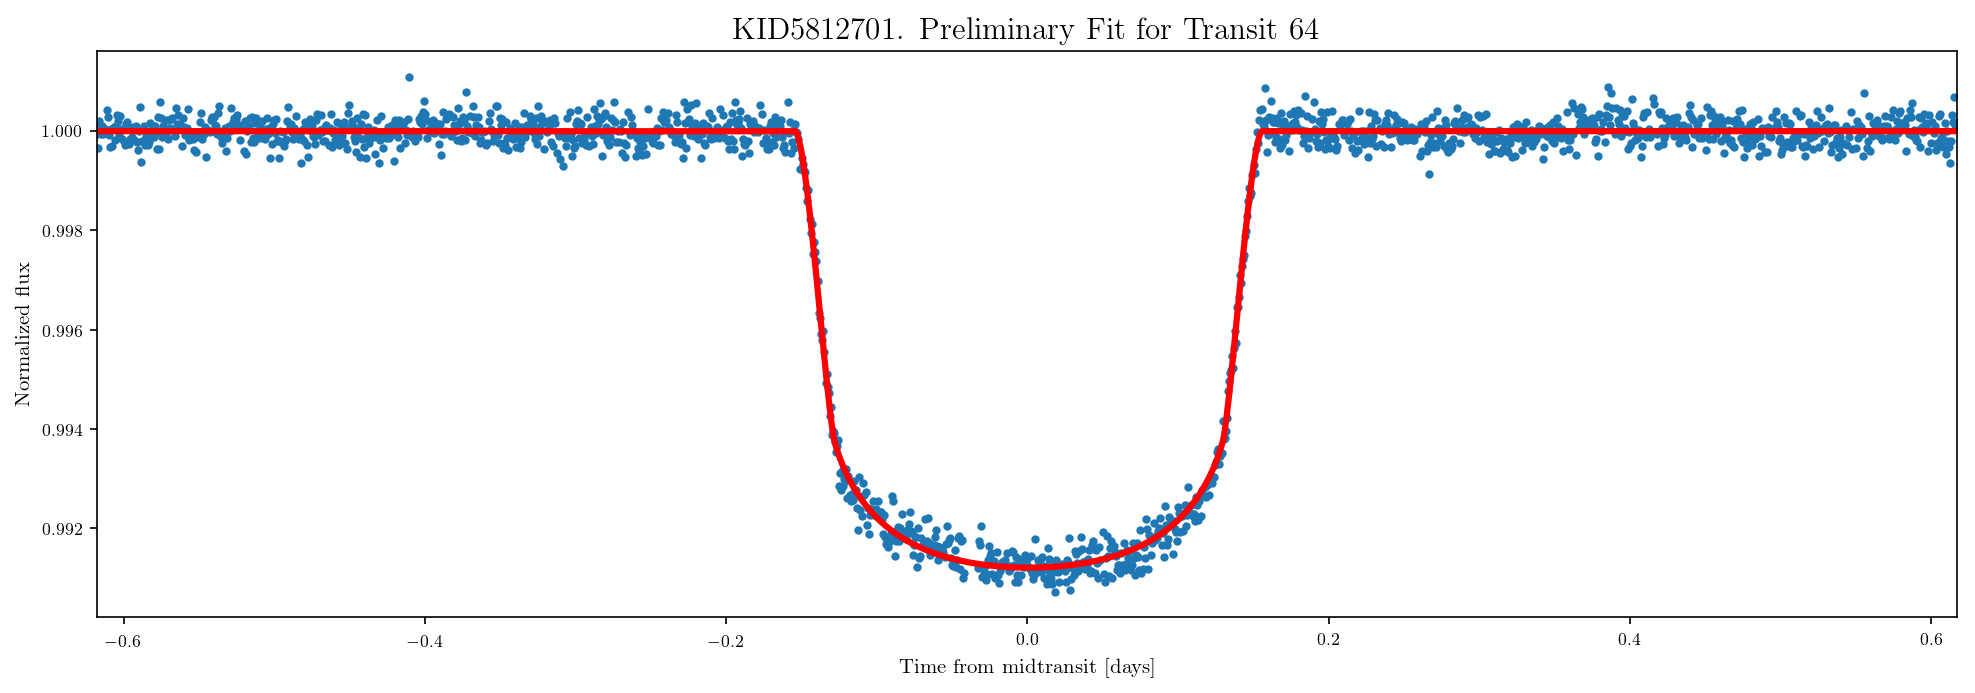

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.309	True=0.309
	Period [days]:	 Fit=16.12705903	True=17.85522168
	Impact Parameter:	 Fit=0.194668	True=0.075000
	Depth:	 Fit=0.007546	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00025
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.19467
Guess of Rp [in Rsun]: 0.13970
Max. allowed b (1+rp_guess/rs): 1.08283


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [11:16<00:00, 15.46it/s]


Multiprocessing took 689.7 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.180 (+0.052,-0.079)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.916 (+0.407,-0.420)

Period [d]:
	True = 17.855
	MCMC Fit = 16.213 (+1.653,-1.437)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0561 (+0.0017,-0.0017)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.681 (+0.043,-0.044)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.389 (+0.067,-0.066)

Mean acceptance fraction: 0.31 (30.74 %) 

*TRANSIT 65
	Signal = 0.00738. Noise (rms) = 0.00025. SNR = 29.26801
	Out-of-transit error of the transit LC = 0.00025

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990650
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13056.710608
         Iterations: 1997
         Function evaluations: 2961
Optimization terminated successfully.
         Current function value: -13139.592520
         Iterations: 1217
         Function evaluations: 1780


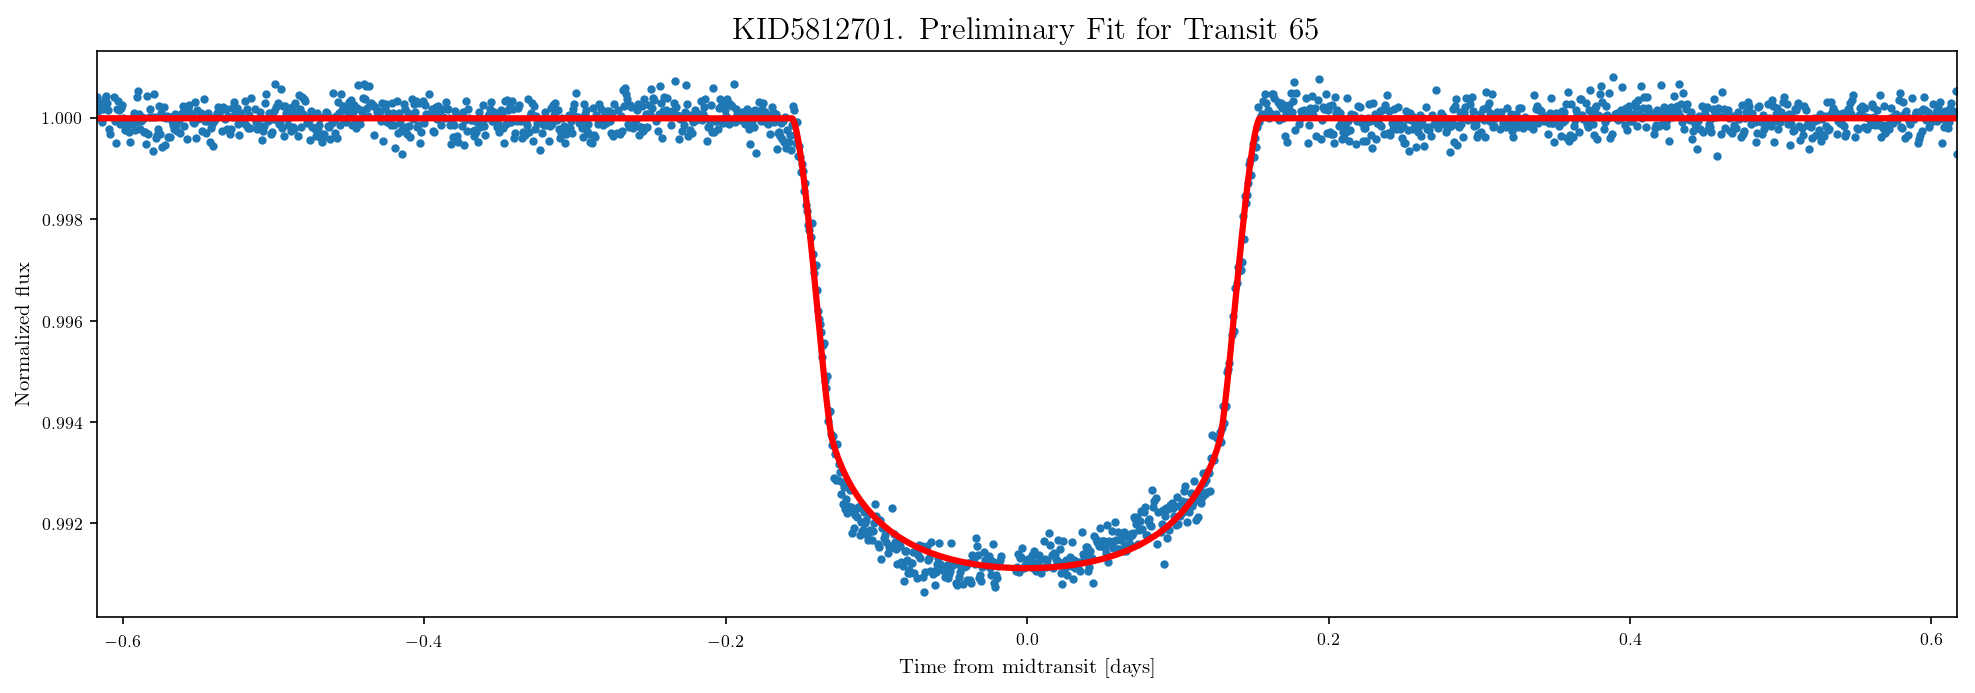

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.310	True=0.309
	Period [days]:	 Fit=16.57991299	True=17.85522168
	Impact Parameter:	 Fit=0.231009	True=0.075000
	Depth:	 Fit=0.007649	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.686	True=1.683
	Sigma (white noise):	 Fit=0.00027
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.23101
Guess of Rp [in Rsun]: 0.14062
Max. allowed b (1+rp_guess/rs): 1.08339


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [11:37<00:00, 14.27it/s]


Multiprocessing took 711.5 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.220 (+0.047,-0.064)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.030 (+0.402,-0.419)

Period [d]:
	True = 17.855
	MCMC Fit = 16.644 (+1.760,-1.530)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0552 (+0.0016,-0.0017)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.682 (+0.042,-0.044)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.388 (+0.070,-0.068)

Mean acceptance fraction: 0.32 (32.23 %) 

*TRANSIT 67
	Signal = 0.00726. Noise (rms) = 0.00028. SNR = 26.33576
	Out-of-transit error of the transit LC = 0.00028

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990671
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13165.485601
         Iterations: 2062
         Function evaluations: 3068
Optimization terminated successfully.
         Current function value: -13250.569706
         Iterations: 1019
         Function evaluations: 1508


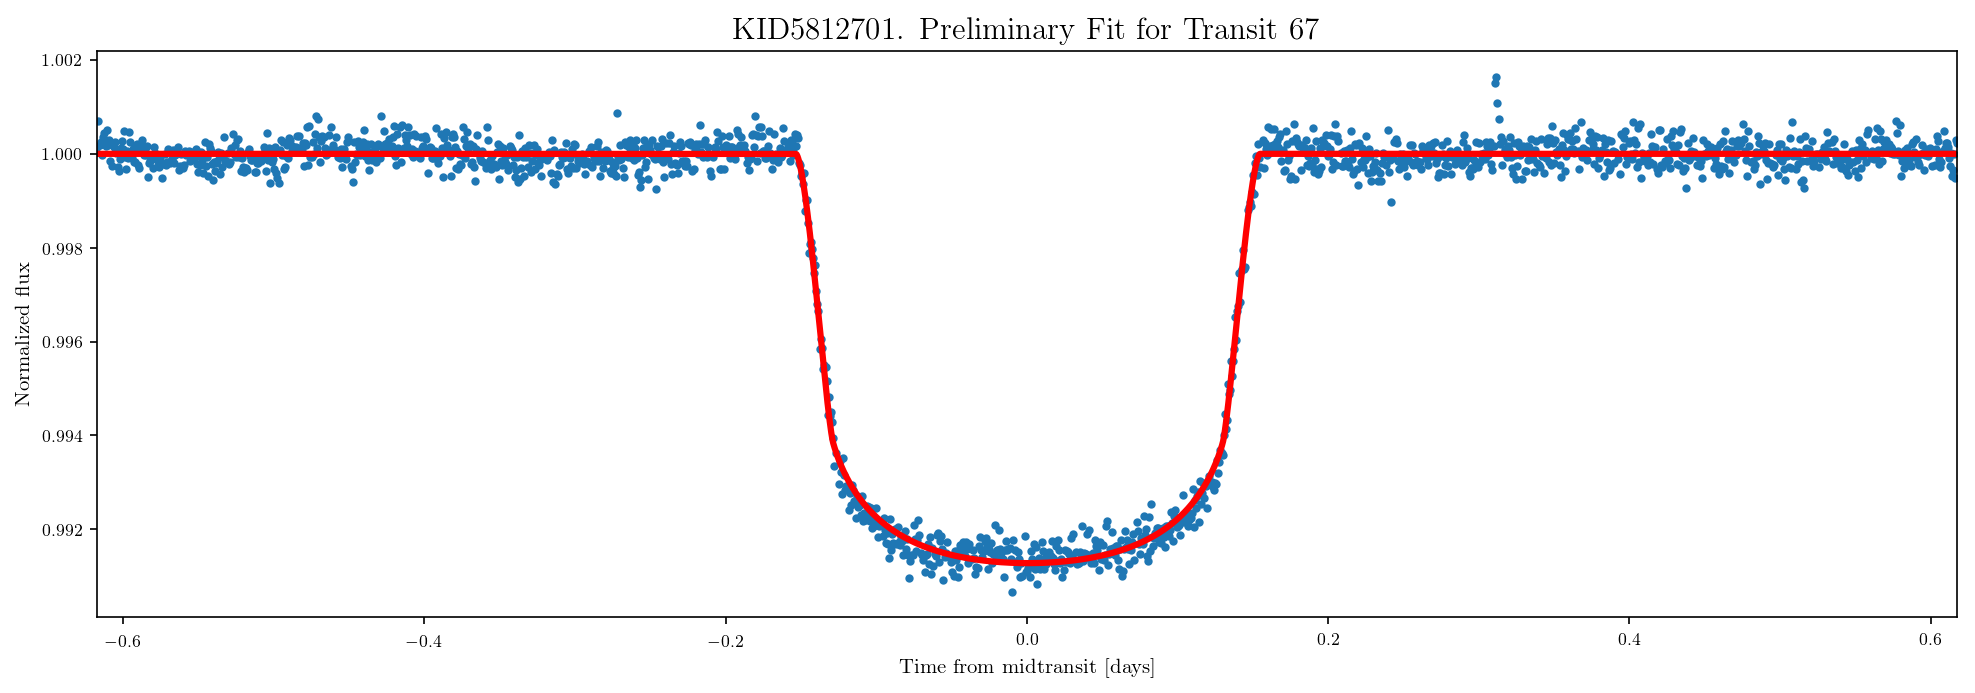

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.308	True=0.309
	Period [days]:	 Fit=15.17387425	True=17.85522168
	Impact Parameter:	 Fit=0.000000	True=0.075000
	Depth:	 Fit=0.007448	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.686	True=1.683
	Sigma (white noise):	 Fit=0.00027
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.00000
Guess of Rp [in Rsun]: 0.13875
Max. allowed b (1+rp_guess/rs): 1.08229


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [11:05<00:00, 13.62it/s]


Multiprocessing took 679.0 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.007 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.073 (+0.073,-0.057)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.807 (+0.376,-0.402)

Period [d]:
	True = 17.855
	MCMC Fit = 15.699 (+1.508,-1.269)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0584 (+0.0016,-0.0017)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.678 (+0.040,-0.043)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.393 (+0.067,-0.066)

Mean acceptance fraction: 0.34 (34.21 %) 

*TRANSIT 68
	Signal = 0.00761. Noise (rms) = 0.00027. SNR = 28.22688
	Out-of-transit error of the transit LC = 0.00027

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990253
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13384.983592
         Iterations: 3655
         Function evaluations: 5296
Optimization terminated successfully.
         Current function value: -13384.983591
         Iterations: 423
         Function evaluations: 661


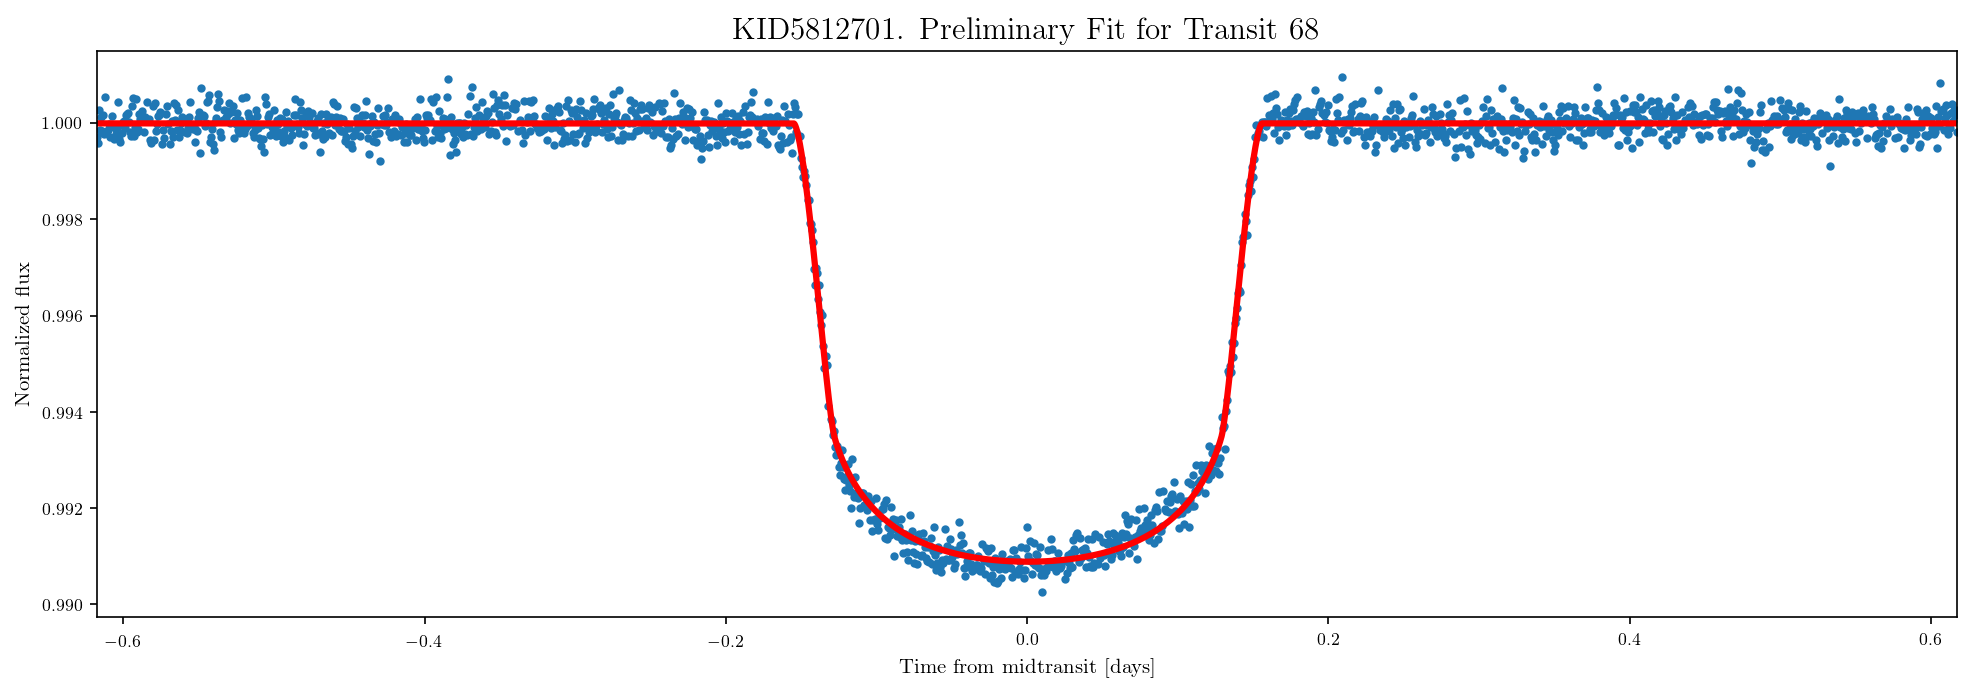

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.311	True=0.309
	Period [days]:	 Fit=16.63782658	True=17.85522168
	Impact Parameter:	 Fit=0.237566	True=0.075000
	Depth:	 Fit=0.007858	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00027
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.23757
Guess of Rp [in Rsun]: 0.14258
Max. allowed b (1+rp_guess/rs): 1.08452


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [11:14<00:00, 15.37it/s]


Multiprocessing took 689.9 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.227 (+0.042,-0.056)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.252 (+0.428,-0.439)

Period [d]:
	True = 17.855
	MCMC Fit = 16.666 (+1.769,-1.533)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0551 (+0.0017,-0.0017)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.682 (+0.044,-0.045)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.387 (+0.068,-0.067)

Mean acceptance fraction: 0.33 (32.61 %) 

*TRANSIT 69
	Signal = 0.00768. Noise (rms) = 0.00031. SNR = 24.71843
	Out-of-transit error of the transit LC = 0.00031

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990279
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13090.646183
         Iterations: 1880
         Function evaluations: 2765
Optimization terminated successfully.
         Current function value: -13161.615001
         Iterations: 1246
         Function evaluations: 1817


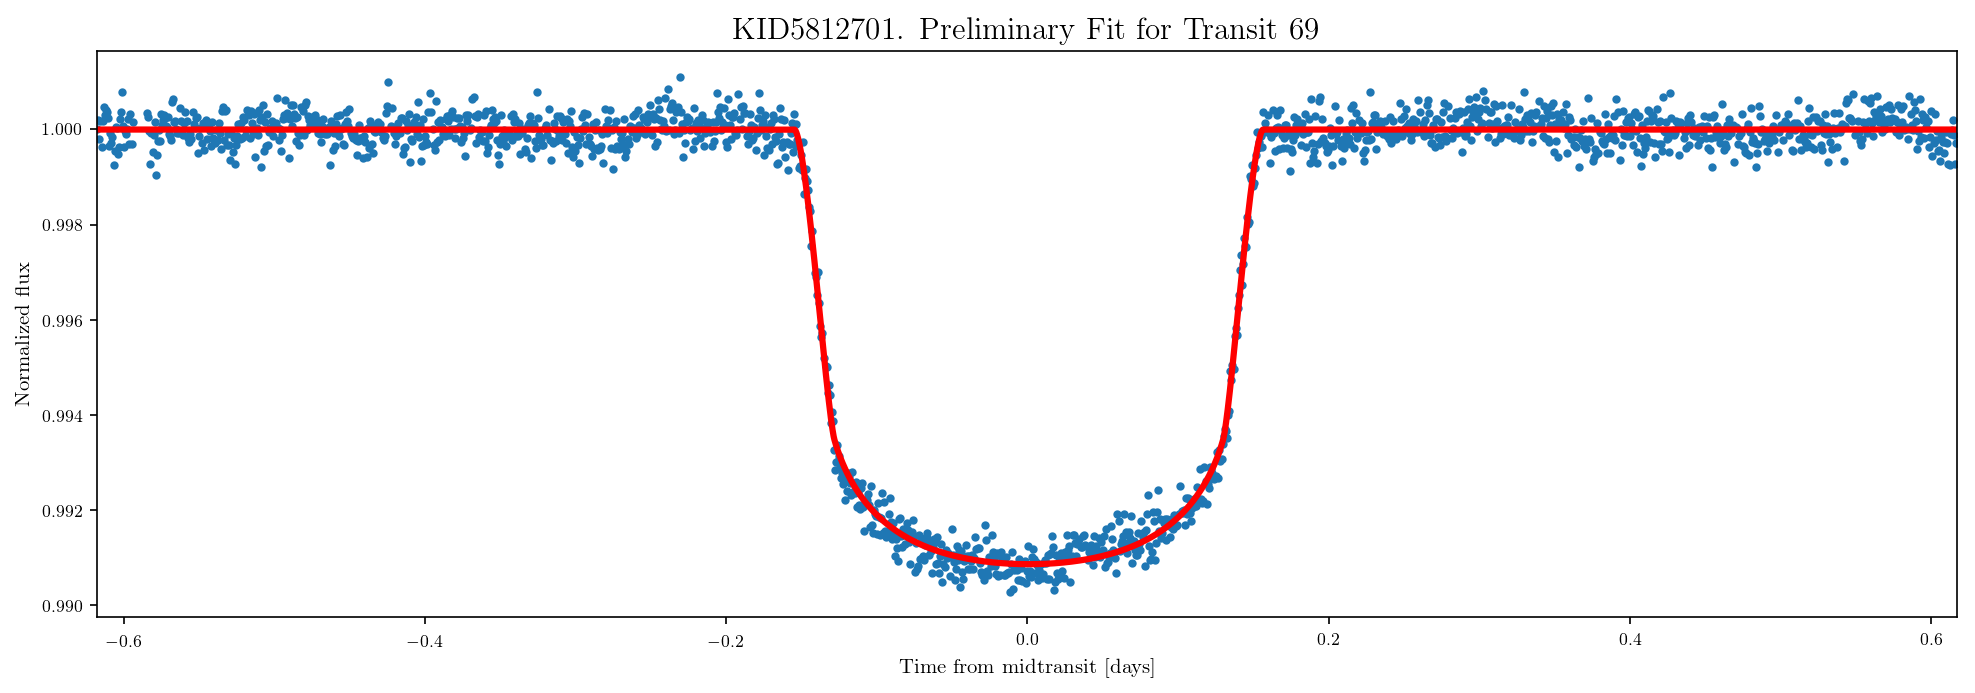

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.311	True=0.309
	Period [days]:	 Fit=16.19662768	True=17.85522168
	Impact Parameter:	 Fit=0.186677	True=0.075000
	Depth:	 Fit=0.007848	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00030
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.18668
Guess of Rp [in Rsun]: 0.14248
Max. allowed b (1+rp_guess/rs): 1.08447


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [10:57<00:00, 15.55it/s]


Multiprocessing took 671.3 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.167 (+0.062,-0.089)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.243 (+0.413,-0.429)

Period [d]:
	True = 17.855
	MCMC Fit = 16.223 (+1.688,-1.445)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0561 (+0.0017,-0.0017)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.682 (+0.043,-0.044)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.387 (+0.068,-0.067)

Mean acceptance fraction: 0.31 (30.85 %) 

*TRANSIT 70
	Signal = 0.00758. Noise (rms) = 0.00027. SNR = 27.80553
	Out-of-transit error of the transit LC = 0.00027

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990229
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13146.163286
         Iterations: 3987
         Function evaluations: 5869
Optimization terminated successfully.
         Current function value: -13151.890085
         Iterations: 615
         Function evaluations: 937


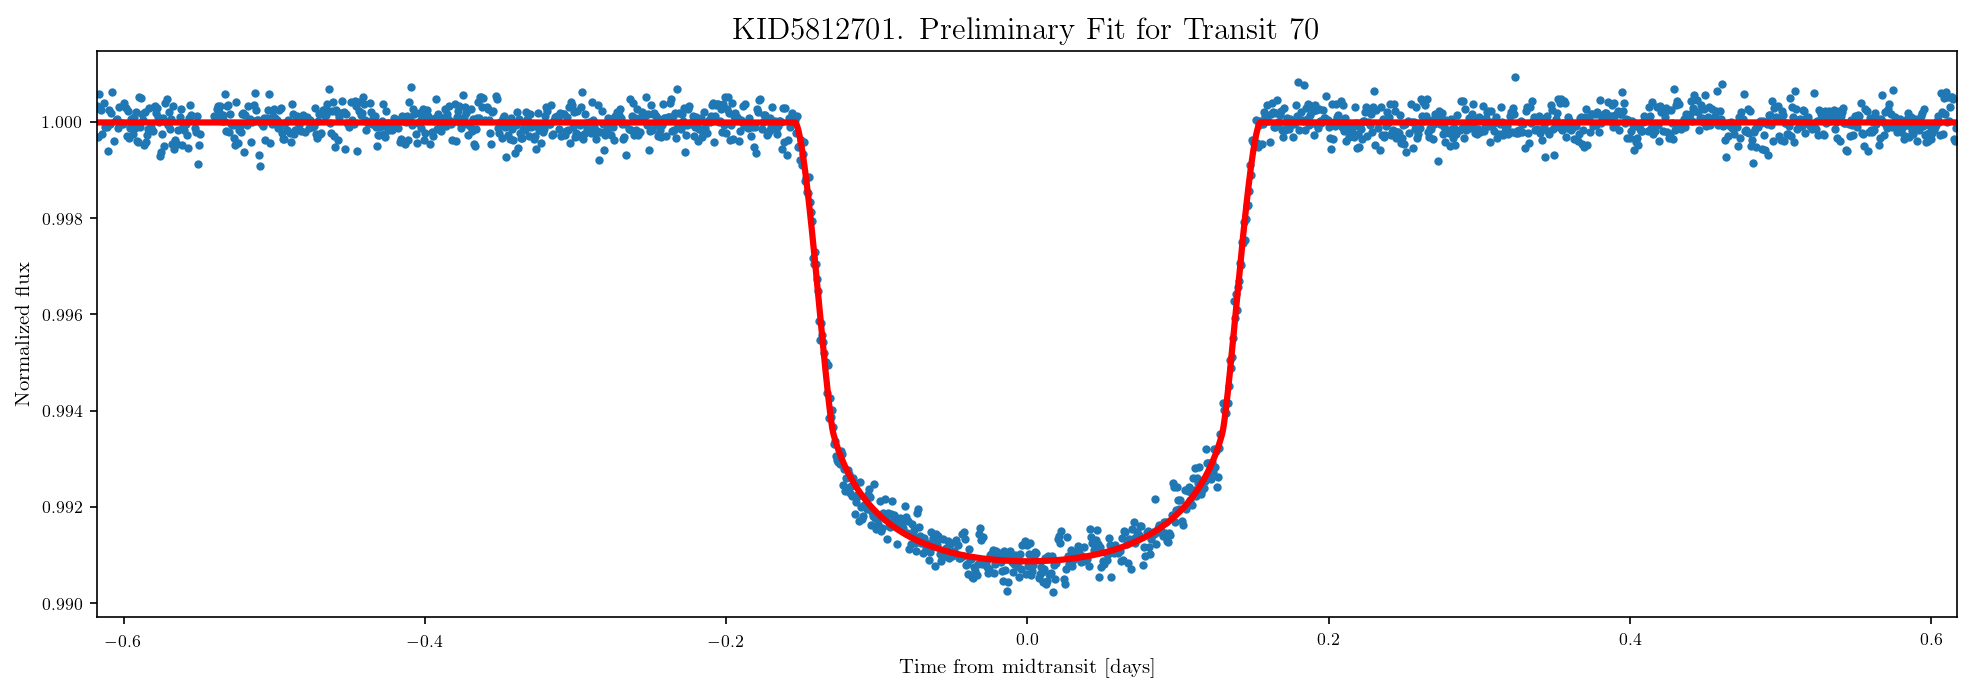

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.309	True=0.309
	Period [days]:	 Fit=15.15200446	True=17.85522168
	Impact Parameter:	 Fit=0.000000	True=0.075000
	Depth:	 Fit=0.007804	True=0.009065
	Stellar mass:	 Fit=1.382	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00027
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.00000
Guess of Rp [in Rsun]: 0.14213
Max. allowed b (1+rp_guess/rs): 1.08423


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [09:55<00:00, 17.18it/s]


Multiprocessing took 608.1 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.135 (+0.072,-0.106)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.224 (+0.401,-0.418)

Period [d]:
	True = 17.855
	MCMC Fit = 15.856 (+1.616,-1.326)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0586 (+0.0016,-0.0018)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.681 (+0.041,-0.043)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.389 (+0.068,-0.067)

Mean acceptance fraction: 0.32 (32.14 %) 

*TRANSIT 71
	Signal = 0.00788. Noise (rms) = 0.00027. SNR = 28.75671
	Out-of-transit error of the transit LC = 0.00027

Min flux Folded LC = 0.989510
Min flux individual transit = 0.989940
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13414.107738
         Iterations: 4315
         Function evaluations: 6327
Optimization terminated successfully.
         Current function value: -13436.196323
         Iterations: 1287
         Function evaluations: 1920


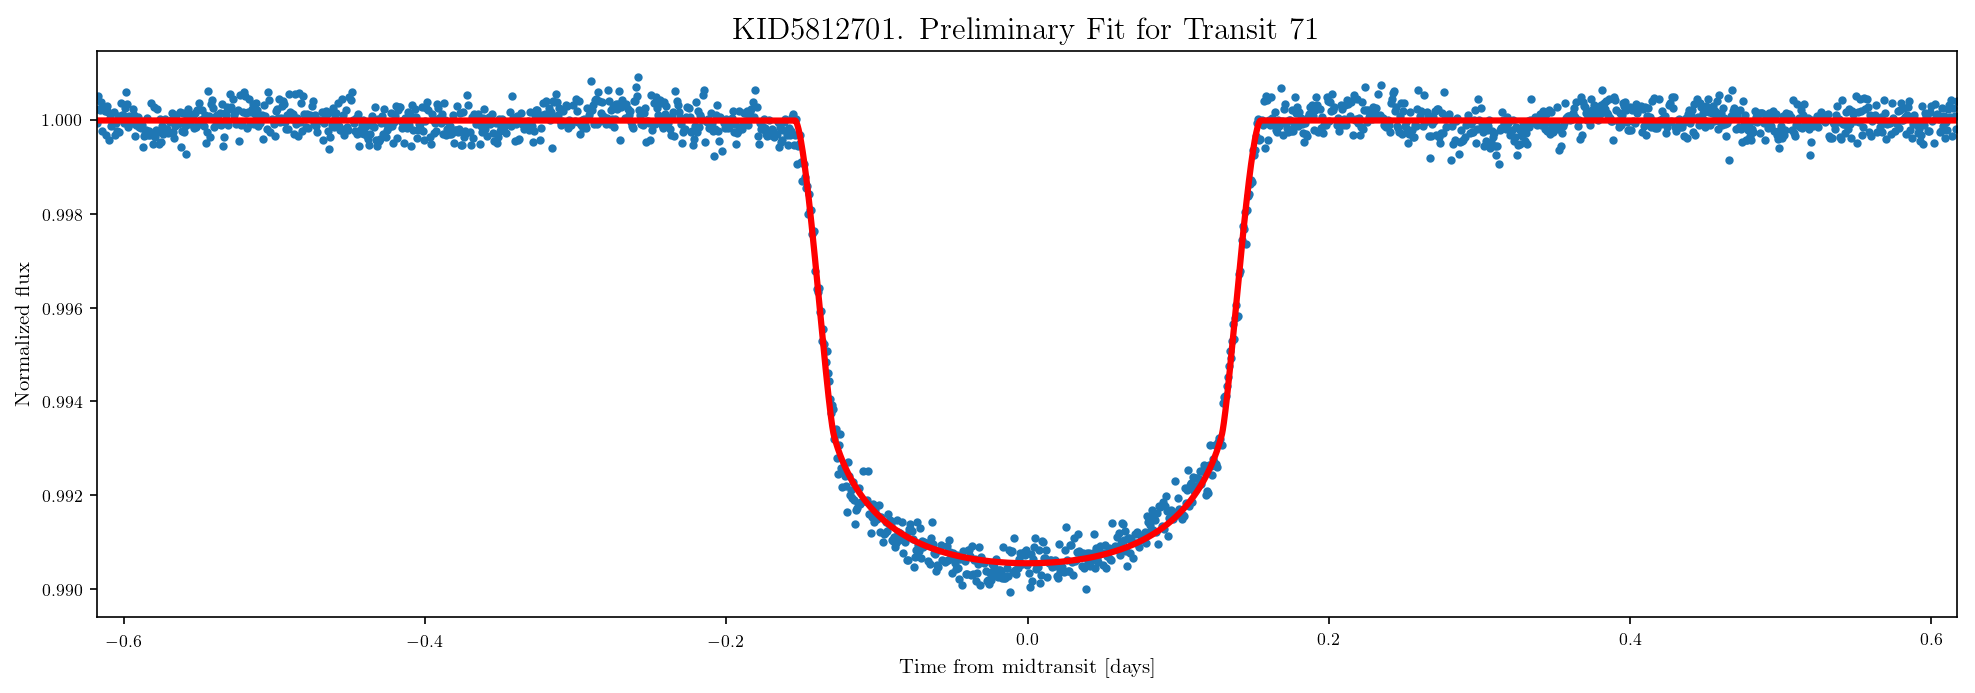

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.309	True=0.309
	Period [days]:	 Fit=15.36852352	True=17.85522168
	Impact Parameter:	 Fit=0.000000	True=0.075000
	Depth:	 Fit=0.008073	True=0.009065
	Stellar mass:	 Fit=1.368	True=1.386
	Stellar radius:	 Fit=1.672	True=1.683
	Sigma (white noise):	 Fit=0.00028
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.00000
Guess of Rp [in Rsun]: 0.14323
Max. allowed b (1+rp_guess/rs): 1.08567


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [10:23<00:00, 15.19it/s]


Multiprocessing took 636.3 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.355 (+0.027,-0.204)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.669 (+0.437,-0.465)

Period [d]:
	True = 17.855
	MCMC Fit = 18.309 (+2.216,-2.256)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0581 (+0.0018,-0.0019)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.684 (+0.043,-0.047)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.386 (+0.069,-0.071)

Mean acceptance fraction: 0.35 (35.49 %) 

*TRANSIT 72
	Signal = 0.00753. Noise (rms) = 0.00027. SNR = 27.89121
	Out-of-transit error of the transit LC = 0.00027

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990260
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12998.672999
         Iterations: 1719
         Function evaluations: 2520
Optimization terminated successfully.
         Current function value: -13039.324046
         Iterations: 1135
         Function evaluations: 1659


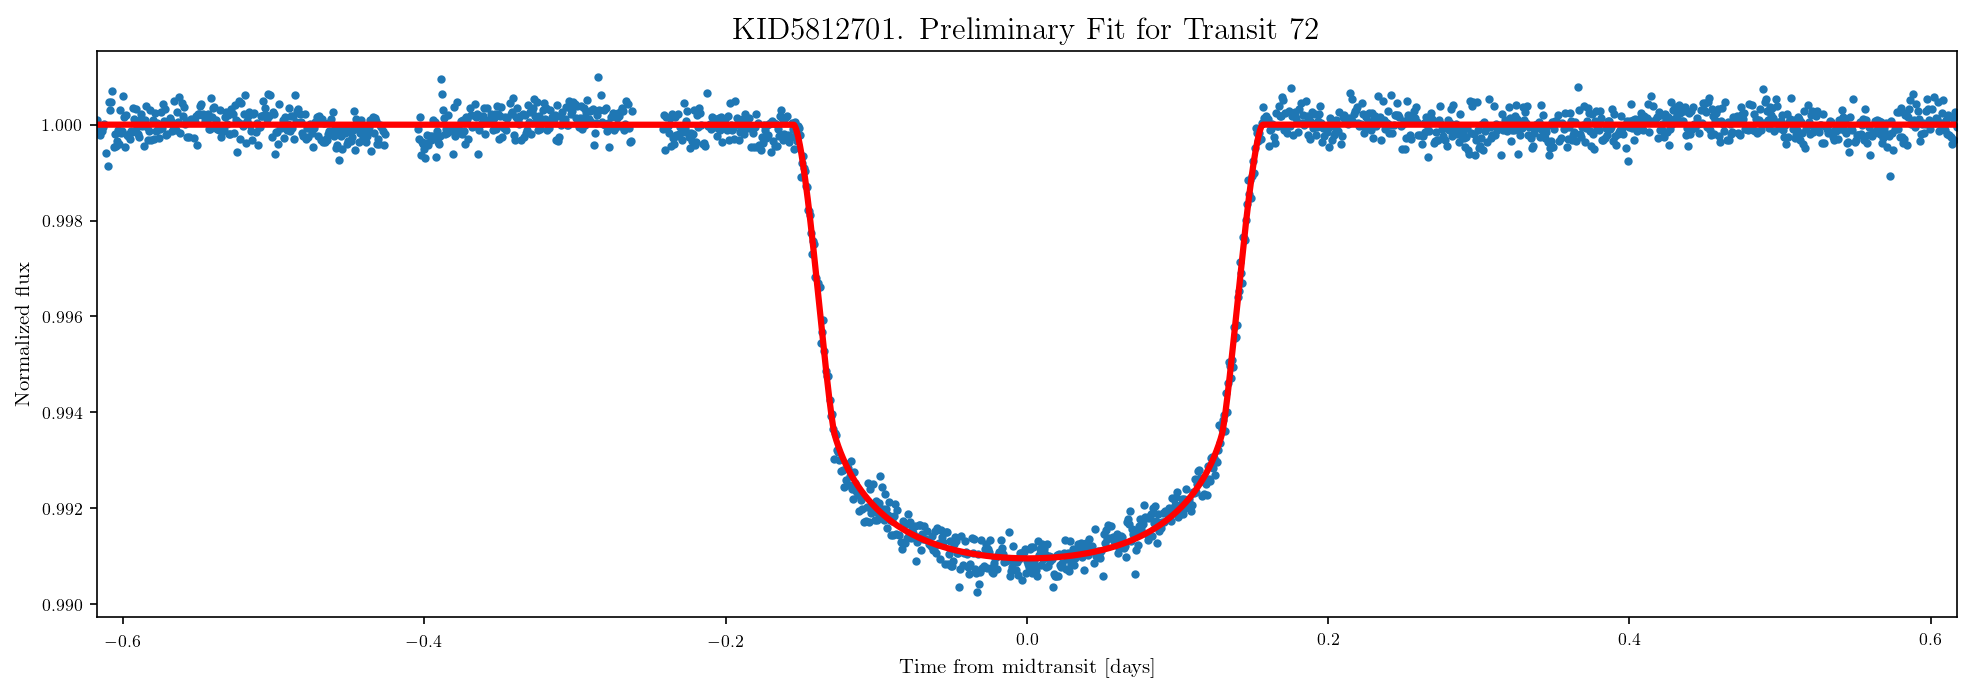

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.311	True=0.309
	Period [days]:	 Fit=17.06296042	True=17.85522168
	Impact Parameter:	 Fit=0.266007	True=0.075000
	Depth:	 Fit=0.007808	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00027
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.26601
Guess of Rp [in Rsun]: 0.14213
Max. allowed b (1+rp_guess/rs): 1.08425


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [10:16<00:00, 17.05it/s]


Multiprocessing took 629.2 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.261 (+0.037,-0.045)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.206 (+0.437,-0.431)

Period [d]:
	True = 17.855
	MCMC Fit = 17.115 (+1.805,-1.613)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0542 (+0.0017,-0.0017)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.682 (+0.045,-0.044)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.386 (+0.069,-0.069)

Mean acceptance fraction: 0.34 (34.04 %) 

*TRANSIT 74
	Signal = 0.00732. Noise (rms) = 0.00026. SNR = 28.19812
	Out-of-transit error of the transit LC = 0.00026

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990629
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13484.123321
         Iterations: 2061
         Function evaluations: 3073
Optimization terminated successfully.
         Current function value: -13568.526796
         Iterations: 868
         Function evaluations: 1301


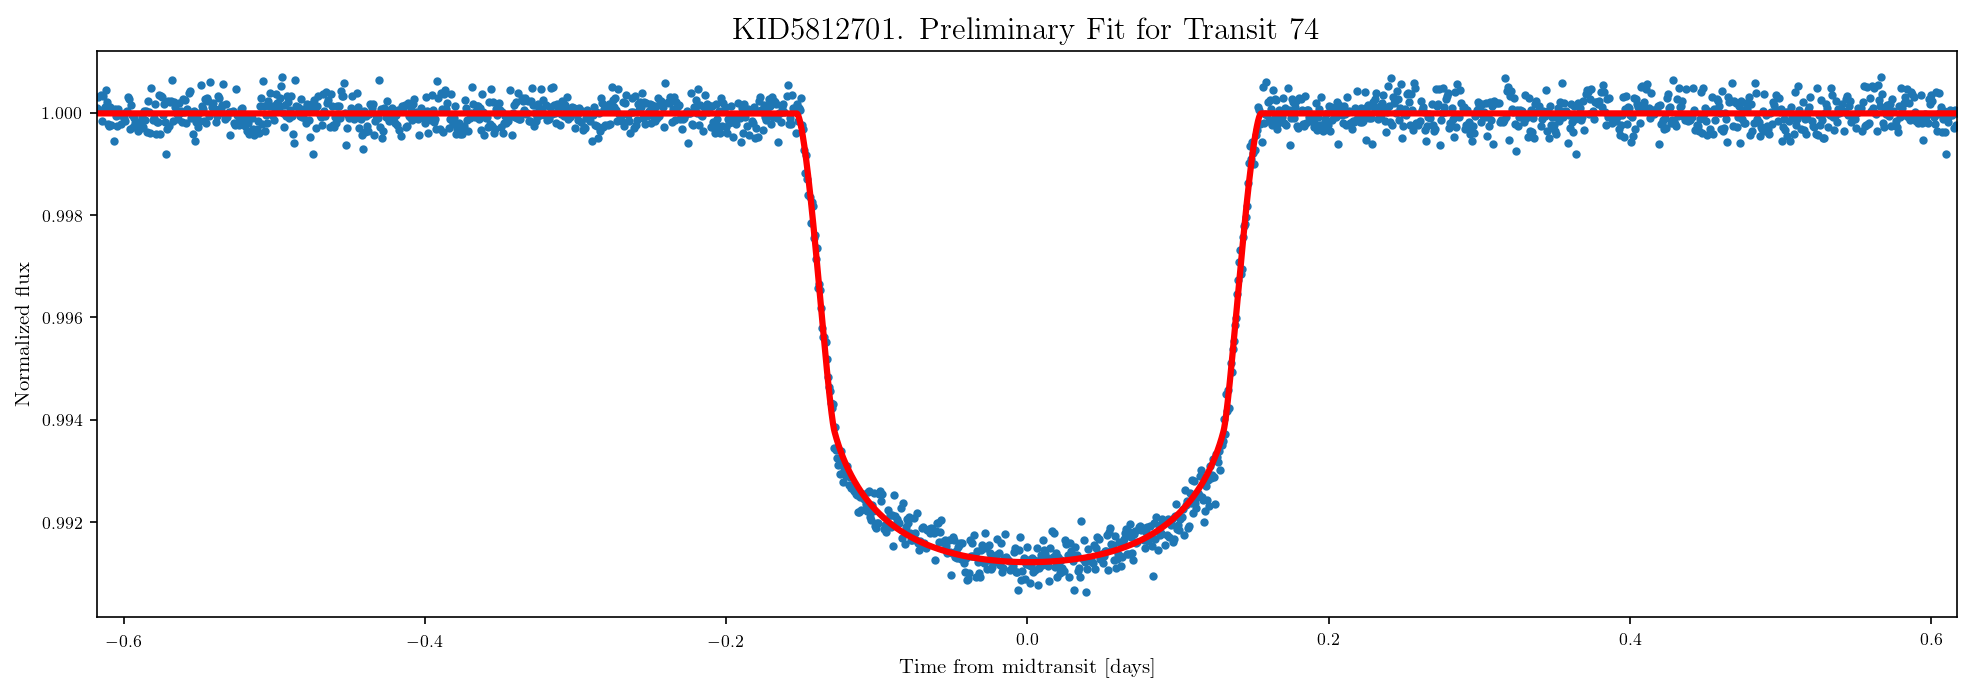

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.308	True=0.309
	Period [days]:	 Fit=15.17900775	True=17.85522168
	Impact Parameter:	 Fit=0.000000	True=0.075000
	Depth:	 Fit=0.007509	True=0.009065
	Stellar mass:	 Fit=1.384	True=1.386
	Stellar radius:	 Fit=1.686	True=1.683
	Sigma (white noise):	 Fit=0.00026
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.00000
Guess of Rp [in Rsun]: 0.13930
Max. allowed b (1+rp_guess/rs): 1.08262


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [09:20<00:00, 16.62it/s]


Multiprocessing took 572.3 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.059 (+0.060,-0.042)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.855 (+0.376,-0.405)

Period [d]:
	True = 17.855
	MCMC Fit = 15.645 (+1.495,-1.235)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0583 (+0.0016,-0.0017)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.677 (+0.040,-0.043)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.393 (+0.066,-0.066)

Mean acceptance fraction: 0.35 (34.85 %) 

*TRANSIT 75
	Signal = 0.00770. Noise (rms) = 0.00026. SNR = 29.95848
	Out-of-transit error of the transit LC = 0.00026

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990032
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13155.187993
         Iterations: 2016
         Function evaluations: 2983
Optimization terminated successfully.
         Current function value: -13222.999079
         Iterations: 1085
         Function evaluations: 1624


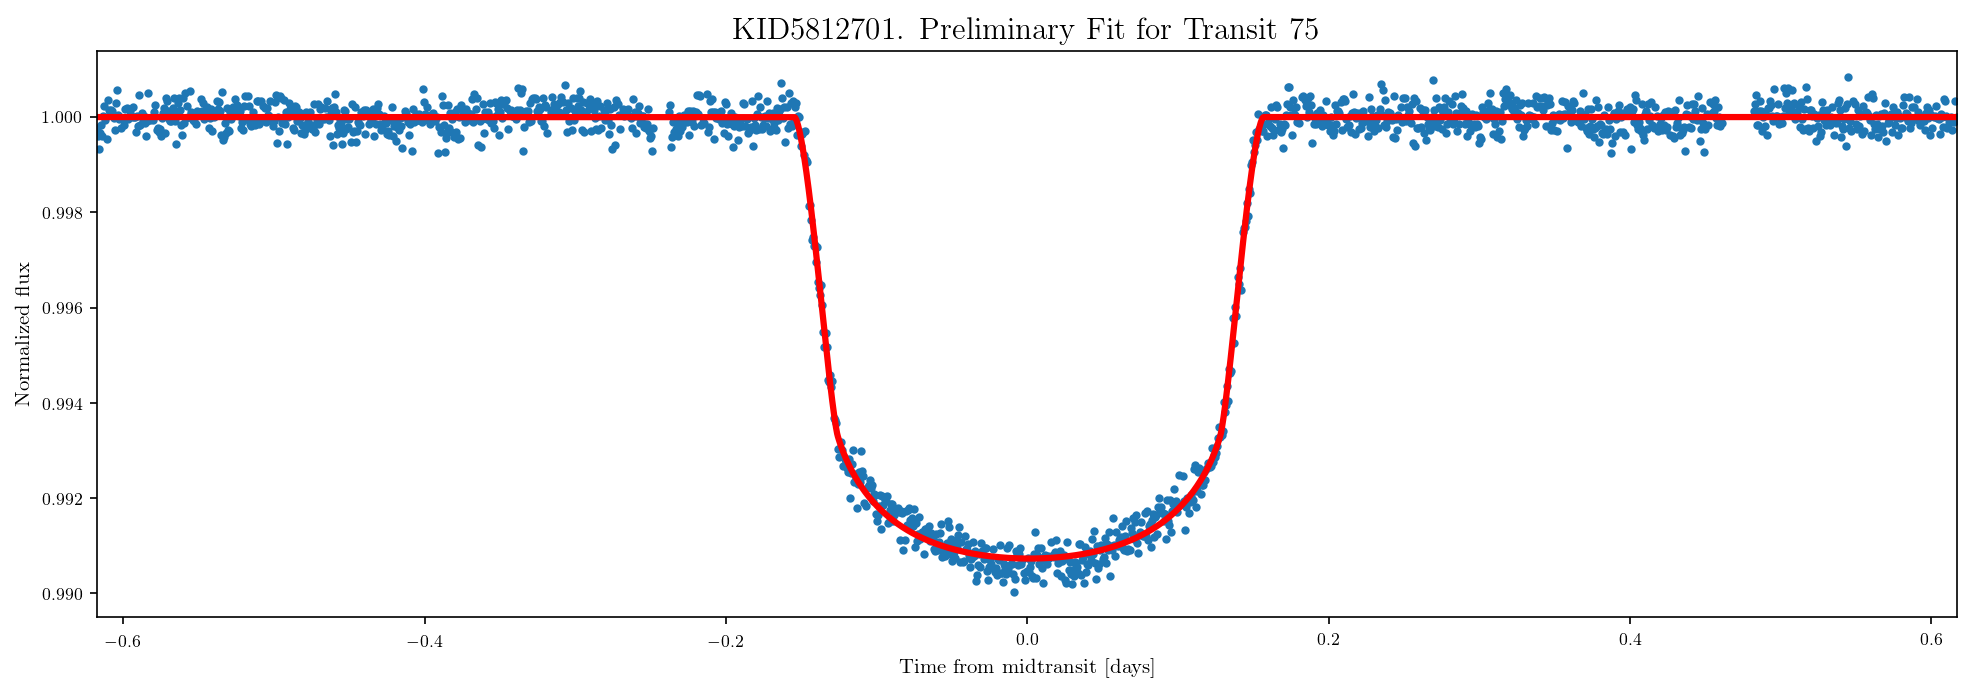

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.311	True=0.309
	Period [days]:	 Fit=17.87242930	True=17.85522168
	Impact Parameter:	 Fit=0.329197	True=0.075000
	Depth:	 Fit=0.008055	True=0.009065
	Stellar mass:	 Fit=1.382	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00026
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.32920
Guess of Rp [in Rsun]: 0.14439
Max. allowed b (1+rp_guess/rs): 1.08557


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [11:14<00:00, 14.62it/s]


Multiprocessing took 687.7 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.328 (+0.026,-0.029)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.479 (+0.443,-0.436)

Period [d]:
	True = 17.855
	MCMC Fit = 17.982 (+1.906,-1.704)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0526 (+0.0017,-0.0016)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.684 (+0.045,-0.045)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.387 (+0.068,-0.069)

Mean acceptance fraction: 0.37 (36.65 %) 

*TRANSIT 76
	Signal = 0.00783. Noise (rms) = 0.00026. SNR = 30.26042
	Out-of-transit error of the transit LC = 0.00026

Min flux Folded LC = 0.989510
Min flux individual transit = 0.989927
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13251.300198
         Iterations: 4135
         Function evaluations: 5985
Optimization terminated successfully.
         Current function value: -13251.300179
         Iterations: 298
         Function evaluations: 476


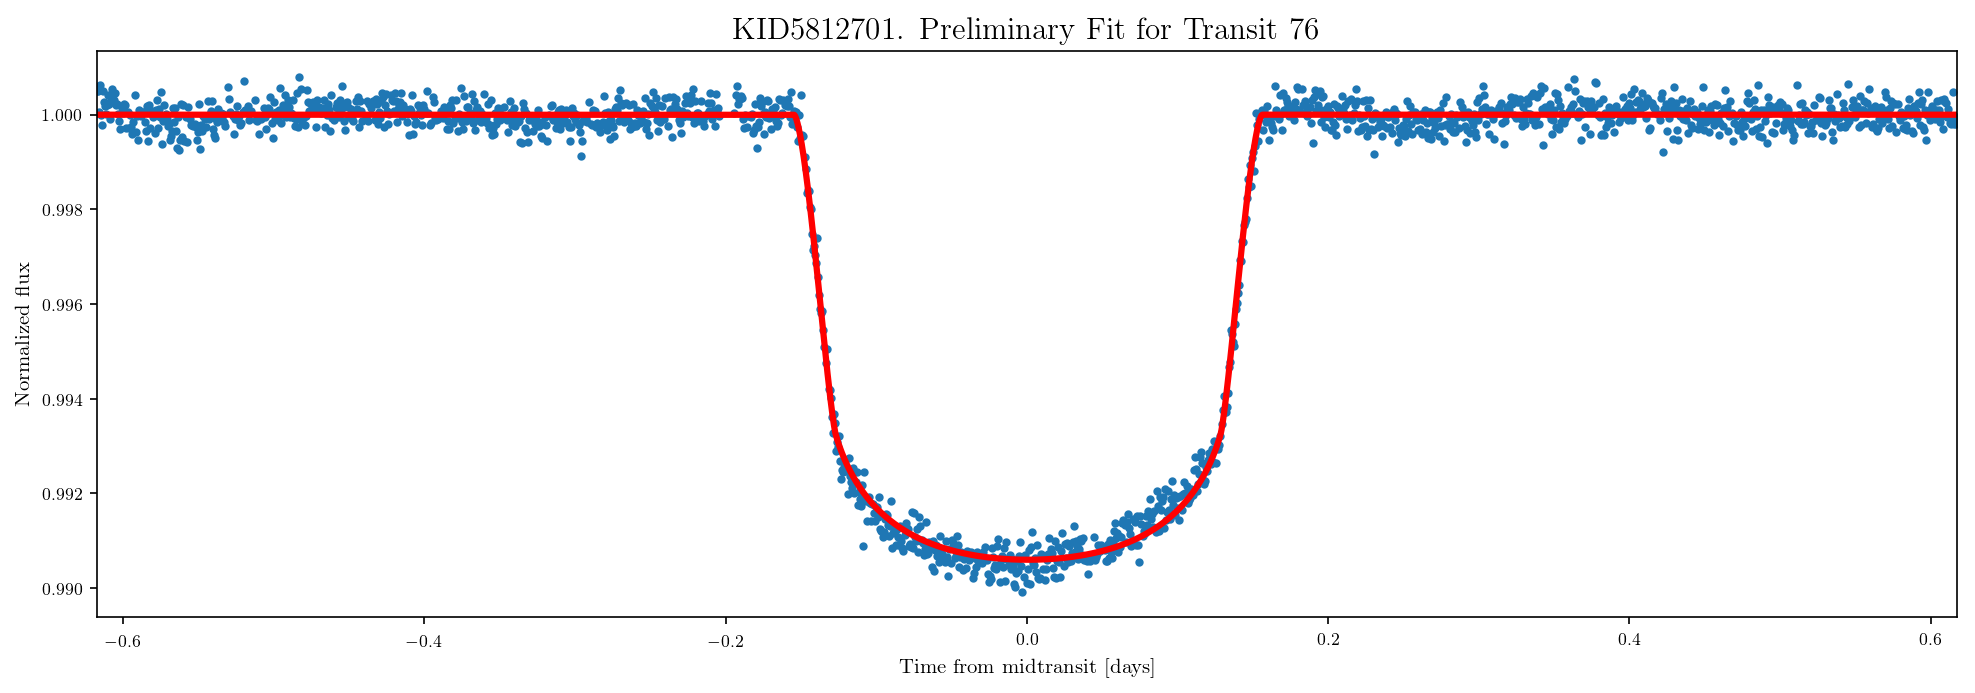

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.311	True=0.309
	Period [days]:	 Fit=16.88869373	True=17.85522168
	Impact Parameter:	 Fit=0.266814	True=0.075000
	Depth:	 Fit=0.008114	True=0.009065
	Stellar mass:	 Fit=1.382	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00026
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.26681
Guess of Rp [in Rsun]: 0.14492
Max. allowed b (1+rp_guess/rs): 1.08589


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [10:45<00:00, 15.67it/s]


Multiprocessing took 659.5 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.261 (+0.035,-0.043)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.518 (+0.429,-0.432)

Period [d]:
	True = 17.855
	MCMC Fit = 16.985 (+1.774,-1.607)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0545 (+0.0017,-0.0016)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.682 (+0.043,-0.044)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.386 (+0.068,-0.069)

Mean acceptance fraction: 0.35 (34.56 %) 

*TRANSIT 78
	Signal = 0.00799. Noise (rms) = 0.00025. SNR = 31.48918
	Out-of-transit error of the transit LC = 0.00025

Min flux Folded LC = 0.989510
Min flux individual transit = 0.989554
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13641.449833
         Iterations: 3574
         Function evaluations: 5218
Optimization terminated successfully.
         Current function value: -13641.449828
         Iterations: 335
         Function evaluations: 548


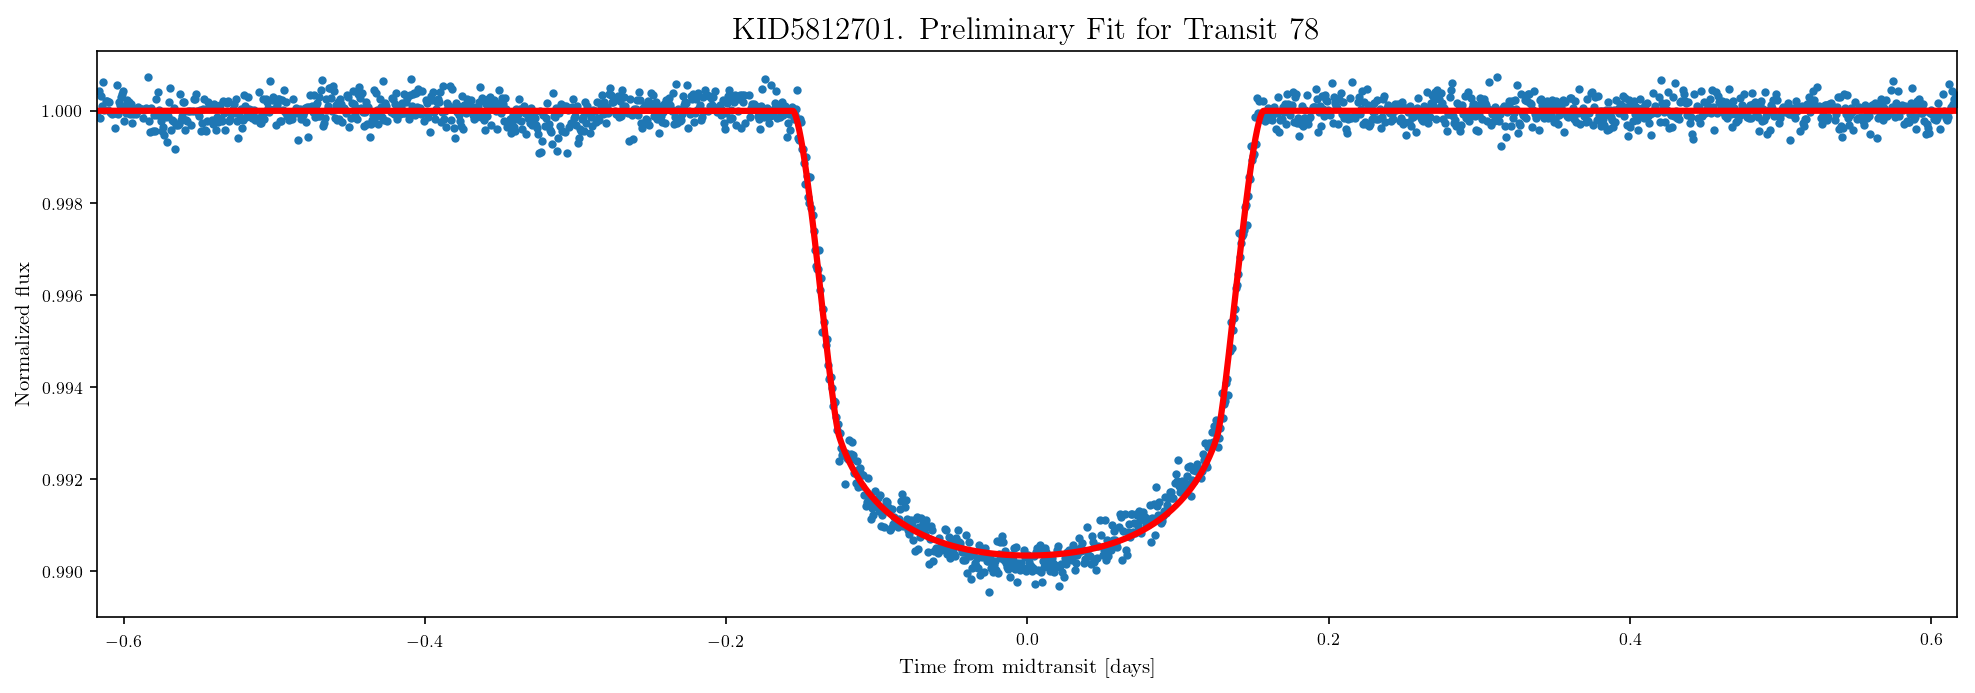

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.312	True=0.309
	Period [days]:	 Fit=18.89077625	True=17.85522168
	Impact Parameter:	 Fit=0.381071	True=0.075000
	Depth:	 Fit=0.008449	True=0.009065
	Stellar mass:	 Fit=1.382	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00026
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.38107
Guess of Rp [in Rsun]: 0.14789
Max. allowed b (1+rp_guess/rs): 1.08764


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [11:04<00:00, 14.84it/s]


Multiprocessing took 677.4 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.380 (+0.019,-0.021)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.877 (+0.438,-0.442)

Period [d]:
	True = 17.855
	MCMC Fit = 19.043 (+1.931,-1.764)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0506 (+0.0016,-0.0016)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.684 (+0.044,-0.044)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.386 (+0.069,-0.069)

Mean acceptance fraction: 0.38 (37.83 %) 

*TRANSIT 79
	Signal = 0.00759. Noise (rms) = 0.00026. SNR = 29.68100
	Out-of-transit error of the transit LC = 0.00026

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990467
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13783.766342
         Iterations: 2242
         Function evaluations: 3308
Optimization terminated successfully.
         Current function value: -13788.791588
         Iterations: 713
         Function evaluations: 1070


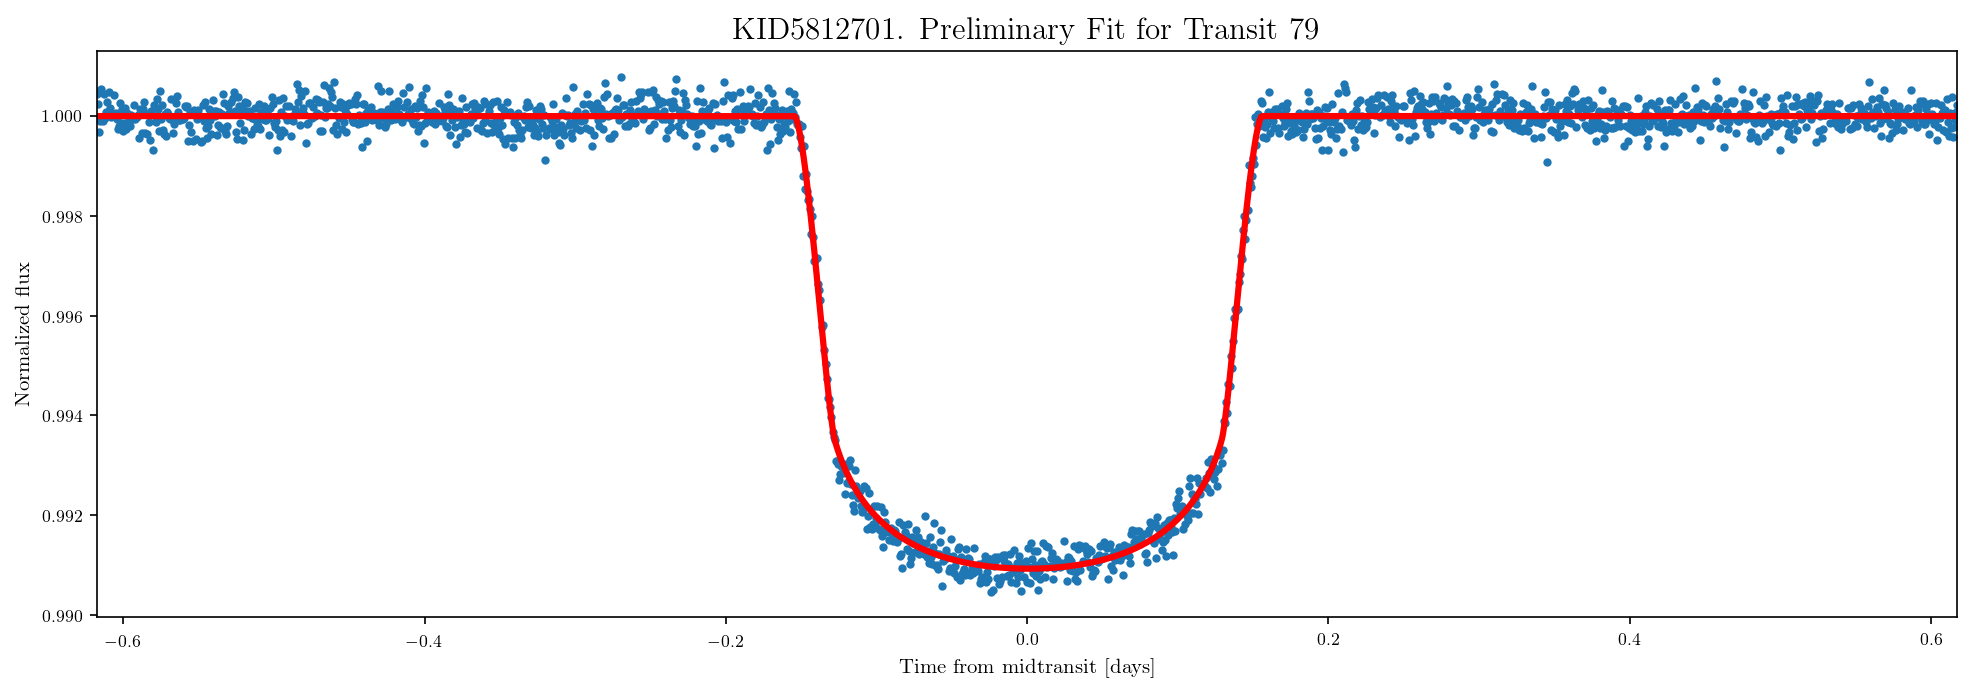

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.310	True=0.309
	Period [days]:	 Fit=16.37458976	True=17.85522168
	Impact Parameter:	 Fit=0.217277	True=0.075000
	Depth:	 Fit=0.007802	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00025
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.21728
Guess of Rp [in Rsun]: 0.14205
Max. allowed b (1+rp_guess/rs): 1.08422


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [10:00<00:00, 16.72it/s]


Multiprocessing took 612.7 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.206 (+0.044,-0.062)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.185 (+0.417,-0.431)

Period [d]:
	True = 17.855
	MCMC Fit = 16.441 (+1.701,-1.455)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0556 (+0.0017,-0.0017)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.681 (+0.043,-0.044)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.389 (+0.069,-0.068)

Mean acceptance fraction: 0.32 (32.00 %) 

*TRANSIT 80
	Signal = 0.00768. Noise (rms) = 0.00025. SNR = 30.63087
	Out-of-transit error of the transit LC = 0.00025

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990273
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13573.661359
         Iterations: 4132
         Function evaluations: 6000
Optimization terminated successfully.
         Current function value: -13573.661350
         Iterations: 344
         Function evaluations: 553


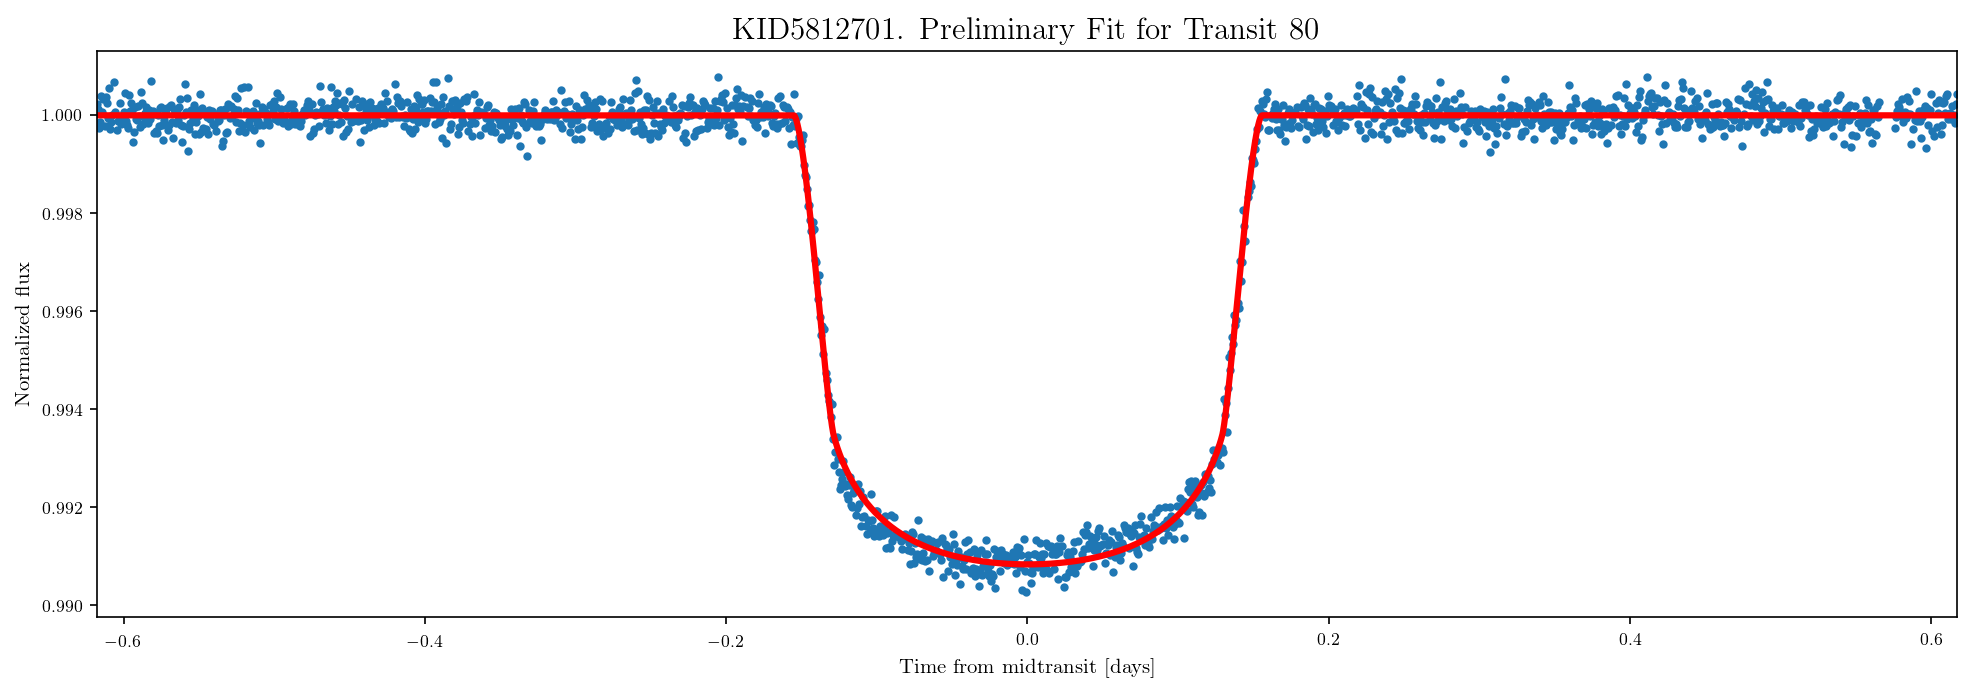

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.311	True=0.309
	Period [days]:	 Fit=16.15631836	True=17.85522168
	Impact Parameter:	 Fit=0.185793	True=0.075000
	Depth:	 Fit=0.007870	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.686	True=1.683
	Sigma (white noise):	 Fit=0.00026
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.18579
Guess of Rp [in Rsun]: 0.14264
Max. allowed b (1+rp_guess/rs): 1.08458


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [09:48<00:00, 16.94it/s]


Multiprocessing took 600.5 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.167 (+0.053,-0.080)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.252 (+0.404,-0.422)

Period [d]:
	True = 17.855
	MCMC Fit = 16.208 (+1.692,-1.413)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0561 (+0.0016,-0.0017)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.681 (+0.042,-0.044)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.390 (+0.068,-0.067)

Mean acceptance fraction: 0.30 (30.38 %) 

*TRANSIT 81
	Signal = 0.00725. Noise (rms) = 0.00025. SNR = 28.83642
	Out-of-transit error of the transit LC = 0.00025

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990640
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13466.486641
         Iterations: 2171
         Function evaluations: 3172
Optimization terminated successfully.
         Current function value: -13514.779510
         Iterations: 1695
         Function evaluations: 2479


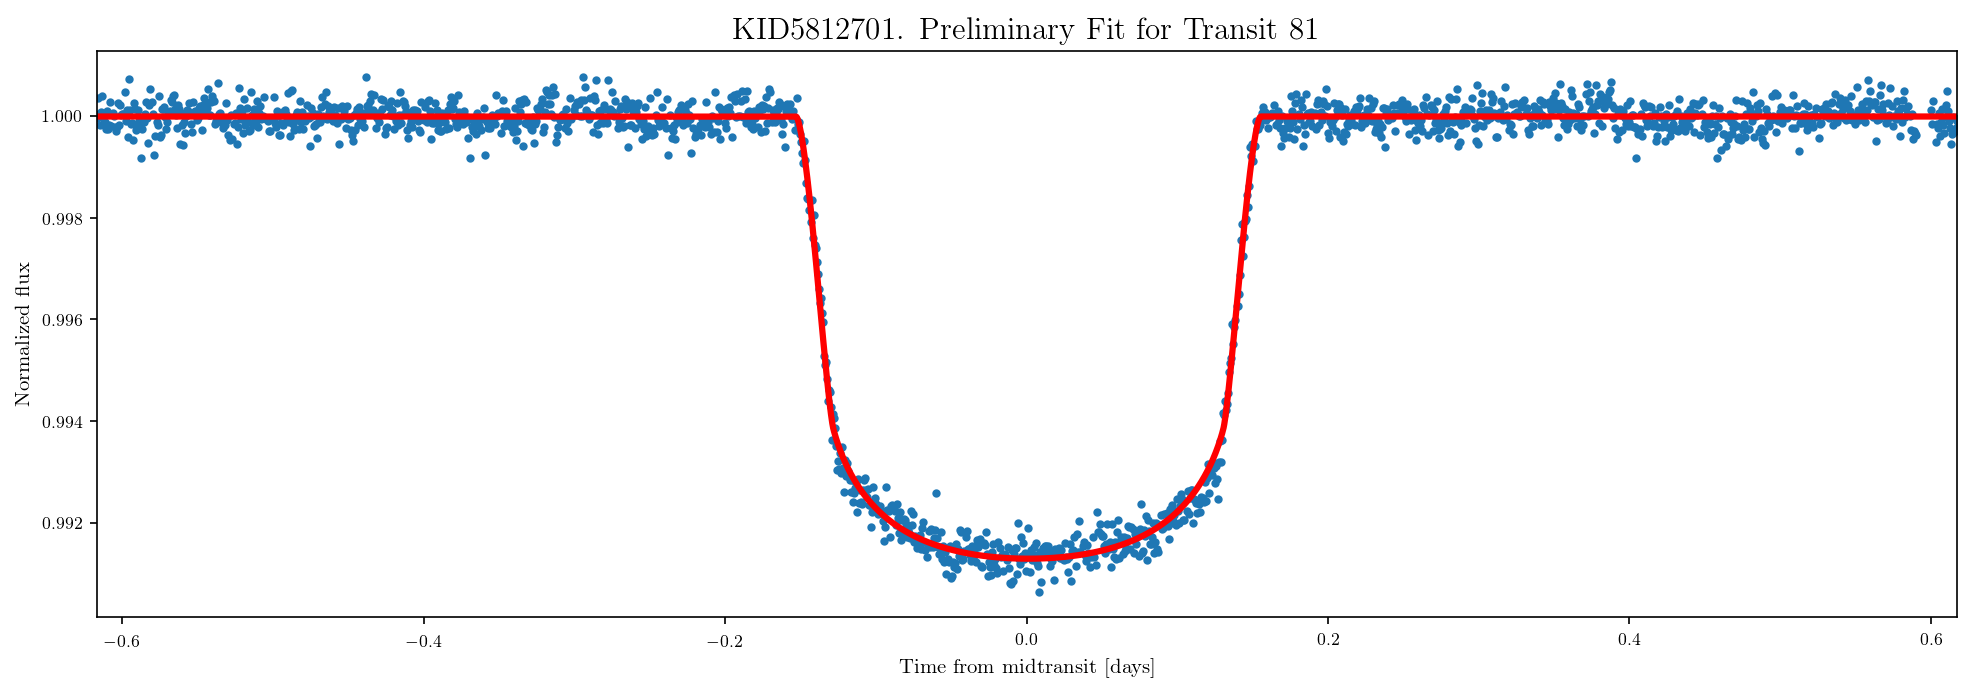

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.308	True=0.309
	Period [days]:	 Fit=15.19906242	True=17.85522168
	Impact Parameter:	 Fit=0.000058	True=0.075000
	Depth:	 Fit=0.007439	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.686	True=1.683
	Sigma (white noise):	 Fit=0.00025
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.00006
Guess of Rp [in Rsun]: 0.13867
Max. allowed b (1+rp_guess/rs): 1.08223


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [09:13<00:00, 18.29it/s]


Multiprocessing took 565.0 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.007 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.079 (+0.066,-0.054)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.790 (+0.380,-0.413)

Period [d]:
	True = 17.855
	MCMC Fit = 15.752 (+1.558,-1.278)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0583 (+0.0016,-0.0018)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.677 (+0.040,-0.044)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.393 (+0.067,-0.067)

Mean acceptance fraction: 0.33 (32.59 %) 

*TRANSIT 82
	Signal = 0.00766. Noise (rms) = 0.00024. SNR = 32.51509
	Out-of-transit error of the transit LC = 0.00024

Min flux Folded LC = 0.989510
Min flux individual transit = 0.990141
Max. allowed b (1+rp_guess/rs) = 1.102422
Depth guess = 0.010490. True depth = 0.009065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12825.457908
         Iterations: 2031
         Function evaluations: 3018
Optimization terminated successfully.
         Current function value: -12906.805782
         Iterations: 1716
         Function evaluations: 2514


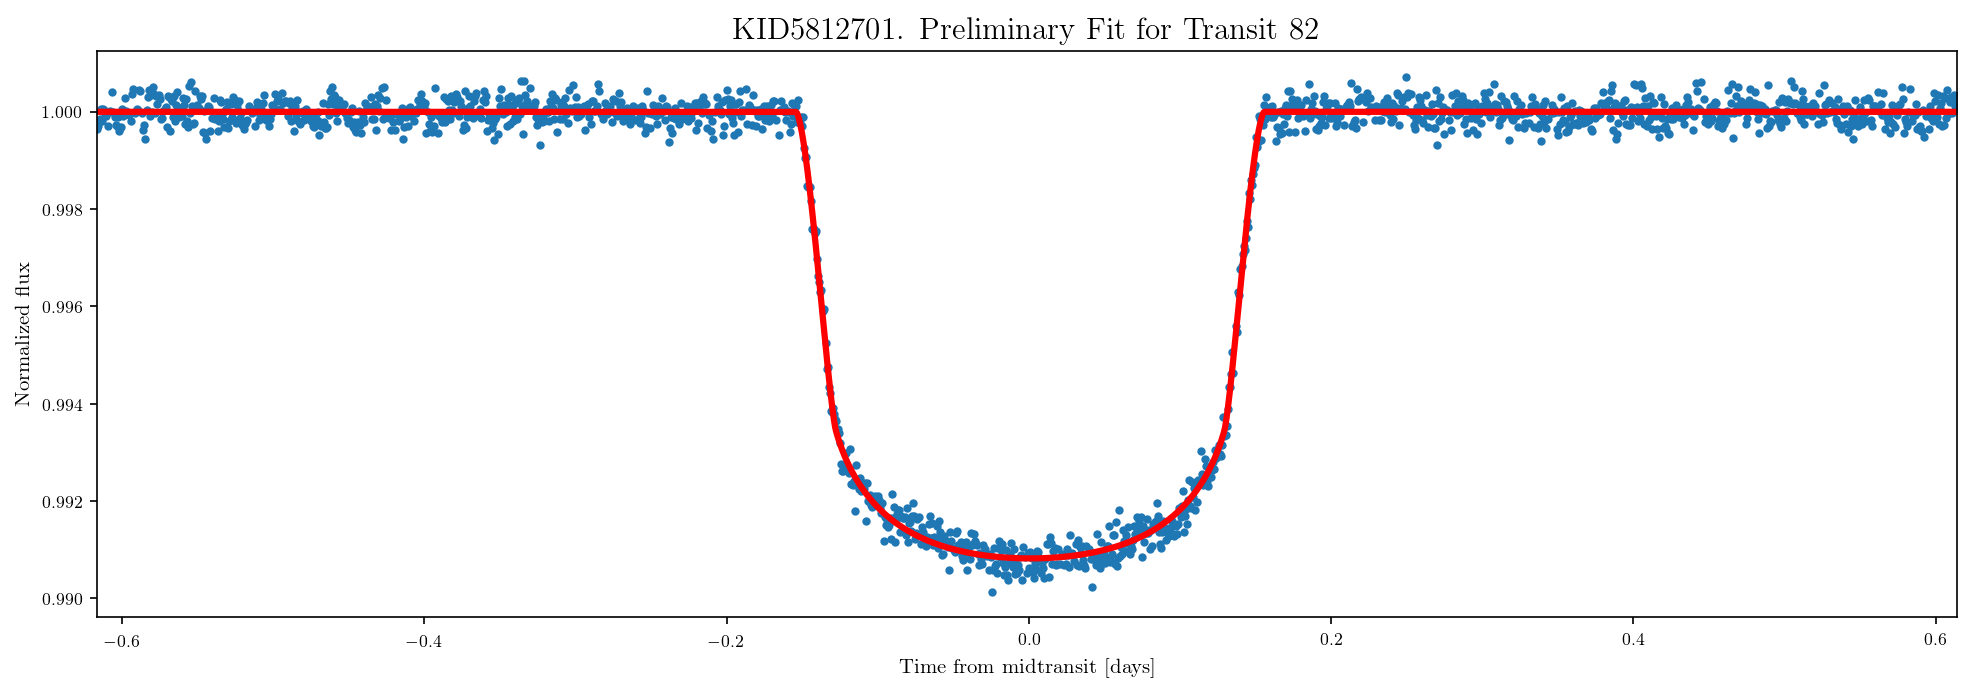

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.310	True=0.309
	Period [days]:	 Fit=16.06879401	True=17.85522168
	Impact Parameter:	 Fit=0.192774	True=0.075000
	Depth:	 Fit=0.007880	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.687	True=1.683
	Sigma (white noise):	 Fit=0.00024
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.19277
Guess of Rp [in Rsun]: 0.14278
Max. allowed b (1+rp_guess/rs): 1.08464


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [09:42<00:00, 17.11it/s]


Multiprocessing took 594.1 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.181 (+0.047,-0.066)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.262 (+0.417,-0.422)

Period [d]:
	True = 17.855
	MCMC Fit = 16.160 (+1.660,-1.409)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0563 (+0.0017,-0.0017)

Stellar radius [Rsun]:
	True = 1.683
	MCMC Fit = 1.681 (+0.043,-0.044)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.387 (+0.070,-0.066)

Mean acceptance fraction: 0.31 (31.21 %) 


In [47]:
#done = {, 5812701}

for target in targets:
    if target.kepid == 5812701:
        print("\n******************************** KID"+str(target.kepid)+" ********************************")
        key = target.kepid
        missed_trans = set(target.ind_missed_transits)
        
        for i in range(len(target.transit_times)): 
            if i not in missed_trans:
                print("\n*TRANSIT "+str(i+1))
                dt_i = target.ttrans[target.trans_id==i]-target.transit_times[i]
                f_trans_i = target.ftrans[target.trans_id==i]
                oot = np.abs(dt_i)>=(target.duration/2)
                iit = np.abs(dt_i)<(target.duration/2)
                d = 1-np.mean(f_trans_i[iit])
                error_trans_oot = np.std(f_trans_i[oot])
                snr = d/error_trans_oot
                print("\tSignal = {0:0.5f}. Noise (rms) = {1:0.5f}. SNR = {2:0.5f}".format(d, error_trans_oot, snr))
                print("\tOut-of-transit error of the transit LC = {0:0.5f}".format(error_trans_oot))

                if  snr > snr_limit:  
                    lc_fit = run_transit_routine(target, dt_i, f_trans_i, 0.1*error_trans_oot, i, True)
                    period_res, mcmc_res = run_mcmc(target, dt_i, f_trans_i, 0.1*error_trans_oot, i, lc_fit, True)
                    locs_P_trans = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/period_distributions/'
                    locs_MCMC = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/MCMC_results/'

                    fname_P_trans = str(target.kepid)+"_st"+str(steps)+"_Pdist_trans"+str(i+1)+"_"+str(period_guess)+"d.txt"
                    fname_MCMC = str(target.kepid)+"_st"+str(steps)+"_MCMCres_trans"+str(i+1)+"_"+str(period_guess)+"d.txt"

                    np.savetxt(locs_P_trans+fname_P_trans, np.transpose(period_res), fmt = "%0.15f")
                    np.savetxt(locs_MCMC+fname_MCMC, np.column_stack((id_mcmc, mcmc_res)), 
                                           header = header_mcmc, delimiter=" ", fmt="%s")

# Period Analysis

In [101]:
period_guess = 30

In [102]:
path_panalysis = "/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/period_charts/"+str(period_guess)+"d/"
path_resMCMC = "/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/MCMC_results/"+str(period_guess)+"d/"
path_pdistr = "/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/period_distributions/"+str(period_guess)+"d/"

print(path_panalysis)

/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/period_charts/30d/


In [115]:
#colors: https://matplotlib.org/examples/color/named_colors.html

def plot_periods(star):
    bin_num = 15
    fig = plt.figure(figsize=(15,20))
    ax = fig.add_subplot(311)
    for i in range(len(star.full_P_trans)):
        ax.hist(star.full_P_trans[i], density = True, bins=30, histtype='step', label='Transit '+str(i+1));
    ax.set_title('KID'+str(star.kepid)+' - Normalized Transit Period distribution', fontsize = 20)
    ax.axvline(x = star.P, color = 'r', linewidth = 4, label = 'True Period' )
    ax.set_xlabel(r'$P$ [d]')
    ax.set_ylabel('Frequency')
    
    ax2 = fig.add_subplot(312)
    ax2.set_title('KID'+str(star.kepid)+' - Normalized Full Period Distribution', fontsize = 20)
    ax2.hist(star.full_P, bins=bin_num*3, density = True, color='lavender', alpha = 0.5) 
    ax2.set_xlabel(r'$P$ [d]')
    ax2.set_ylabel('Frequency')
    ax2.axvline(x = star.P, color = 'r', linewidth = 4, label = "True Period = {0:0.2f} d".format(star.P))
    ax2.axvline(x = star.full_stats['mode'], color = 'b', ls = 'dashed', lw = 3, label = "Mode = {0:0.2f} d".format(star.full_stats['mode']))
    ax2.axvline(x = star.full_stats['mean'], color = 'k', ls = 'dashed', lw = 3, label = "Mean = {0:0.2f} d".format(star.full_stats['mean']))
    ax2.axvline(x = star.full_stats['median'], color = 'r',  ls = 'dashed', lw = 3, label = "Median = {0:0.2f} d".format(star.full_stats['median']))
    ax2.axvline(x = star.full_stats['16%'], color = 'c', ls = ':', lw = 3, label = r"16$\%$ = {0:0.2f} d".format(star.full_stats['16%']))
    ax2.axvline(x = star.full_stats['50%'], color = 'm', ls = ':', lw = 3, label = r"50$\%$ = {0:0.2f} d".format(star.full_stats['50%']))
    ax2.axvline(x = star.full_stats['84%'], color = 'g', ls = ':', lw = 3, label = r"84$\%$ = {0:0.2f} d".format(star.full_stats['84%']))
    ax2.legend(loc = 'best', fontsize = 12)
    
    ax3 = fig.add_subplot(313)
    lower_bound = star.full_stats['mean']-star.full_stats['std']
    upper_bound = star.full_stats['mean']+star.full_stats['std']
    print(lower_bound, upper_bound, star.full_stats['mean'])
    ax3.axvspan(lower_bound, upper_bound, facecolor='papayawhip', alpha=.25, label=r"1$\sigma$ interval")
    ax3.axvline(x = star.full_stats['mean'], color = 'k', ls = 'dashed', lw = 3, label = "Mean = {0:0.2f} d".format(star.full_stats['mean']))
    ax3.hist(star.full_P, bins=bin_num*3, density = True, histtype='step') 
    ax3.legend(loc = 'best', fontsize = 12)
    
    plt.show()
    plt.tight_layout()
    fig.savefig(path_panalysis+"hist"+str(star.kepid)+"_P"+str(period_guess)+".png")
    plt.close(fig)

In [116]:
def get_mode(x):
    values, counts = np.unique(x, return_counts=True)
    m = counts.argmax()
    return values[m], counts[m]

def get_statistics(array):
    full_statistics = pd.Series({'mean': np.mean(array), 'median': np.median(array),'mode': get_mode(array)[0],
                        'std': np.std(array), 'min': min(array), 'max': max(array), 
                   '16%': np.percentile(array,16), '50%': np.percentile(array, 50), '84%': np.percentile(array,84)})
    return full_statistics

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def closest_statistic(df, P):
    cols = ['mean', 'median', 'mode']
    stats = [df['mean'], df['median'], df['mode']]
    res = find_nearest(stats, P)
    idx_res = np.where(stats == res)[0][0]
    return cols[idx_res]

def show_best_stats(star):
    df = pd.DataFrame({'Statistics': star.best_stats})
    freq = df['Statistics'].value_counts().to_dict()
    color_by_label = {'median': 'lightcoral', 'mode': 'lightskyblue', 'mean': 'lightgreen'}
    colors = []
    for label in freq.keys():
        colors.append(color_by_label[label])
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(111)
    ax.pie(freq.values(), colors = colors, autopct='%1.2f%%', shadow = False, startangle = 90)
    plt.legend(loc ='best', labels = ['%s: %d%%' % (l, s) for l, s in zip(freq.keys(), freq.values())],shadow=True)
    ax.axis('equal')  
    ax.set_title("KID"+str(star.kepid), fontsize = 15)
    left, bottom, width, height = [0.15, 0.5, 0.2, 0.2] # These are in unitless percentages of the figure size. (0,0 is bottom left)
    axins = fig.add_axes([left, bottom, width, height])
    missed_trans = set(star.ind_missed_transits)
    for i in range(len(target.transit_times)): 
        if i not in missed_trans:
            axins.plot(star.ttrans[star.trans_id==i]-star.transit_times[i],star.ftrans[star.trans_id==i],'.', 
                       color = 'royalblue', ms = 0.3)
    axins.set_xlabel('Time [d]',fontsize = 8)
    axins.set_ylabel('Flux', fontsize = 8)
    axins.set_title('Folded Light Curve', fontsize = 10)
    plt.tight_layout()
    plt.show()
    fig.savefig(path_panalysis+"pie"+str(star.kepid)+"_P"+str(period_guess)+".png")
    plt.close(fig)

In [ ]:
os.chdir(path_pdistr)
count = 0
save_best_stats = []

for target in targets:
    period_distribution = []
    P_trans_stats = []
    best_statistics = []
    search_files = glob.glob(path_pdistr+str(target.kepid)+"*[!_BAD].txt")

    if len(search_files) != 0:
        for i in range(len(search_files)):
            filename = search_files[i]
            df = np.loadtxt(filename)
            p_mcmc = df.reshape((1,-1))[0]
            period_distribution.append(p_mcmc)
            trans_stats = get_statistics(p_mcmc)
            #print("\nStatistics for "+filename+":\n")
            #print(trans_stats)
            P_trans_stats.append(trans_stats)
            best_statistics.append(closest_statistic(trans_stats, target.P))

        target.full_P_trans = period_distribution #not used in the end
        target.full_P = np.concatenate(period_distribution)
        target.best_stats = best_statistics
        save_best_stats.append(best_statistics)

        #Calculate statistical properties 
        target.full_P_trans_stats = P_trans_stats
        target.full_stats = get_statistics(target.full_P)
        #print("Stats for the *FULL* period distribution:", target.full_stats)
        plot_periods(target)
        show_best_stats(target)
        count += 1

In [ ]:
print(count)
save_best_stats = list(itertools.chain.from_iterable(save_best_stats))

In [ ]:
import seaborn as sns

count_median, count_mean, count_mode = 0, 0, 0

for target in targets:
    getmc = glob.glob(path_resMCMC+str(target.kepid)+"*[!_BAD].txt")
    num_trans = 0
    
    if len(getmc) != 0:
        print("\n--------------------------------KID{0:d}--------------------------------".format(target.kepid))
        
        xtrans = []
        oc, oc_err = [], []
        est_p, est_p_up, est_p_down, est_p_err = [], [], [], []
        
        best_measure = closest_statistic(target.full_stats, target.P)
        best_value = target.full_stats[str(best_measure)].values[0]
        if (best_measure == 'median'): count_median+=1
        elif (best_measure == 'mode'): count_mode+=1
        elif (best_measure == 'mean'): count_mean+=1
        
        for i in range(len(getmc)): 
            filename = getmc[i]
            num_trans += 1
            data = {}
            for line in open(filename):
                if line.startswith("#"):
                    continue
                field_name, values = line.split(":")
                data[field_name] = values.split(" ")
            
            df = pd.DataFrame(data)
            
            #Extract Period information and its +-1 sigma error
            est_p = float(df['Orbital Period (P, [days])'][1]) #this is the median result for each transit
            est_p_up = float(df['Orbital Period (P, [days])'][2]) 
            est_p_down = float(df['Orbital Period (P, [days])'][3]) 
            est_p_err = np.sqrt(est_p_up**2 + est_p_down**2)
            xtrans.append(i+1)
            oc.append(est_p-target.P)
            oc_err.append(est_p_err)
        
        print("True Period: {0:0.3f} [d]".format(target.P))
        print("- Individual Transits:")
        print("\t* Mean Estimated Period (using the median for each transit): {0:0.3f} [d]".format(np.mean(est_p)))
        print("\t* Error of the Mean Estimated Period: {0:0.3f}".format(np.mean(est_p_err)))
        print("\t* std OCs: {0:0.5f} [d]".format(np.std(oc)))
        print("\t* |Mean| OCs: {0:0.3f} [d]".format(np.abs(np.mean(oc))))
        print("- All Transits Considered:")
        print("\t* Best Statistical Measure: {0:s}".format(best_measure))
        print("\t* Best Estimated Period using {: {0:0.3f} [d]".format(best_value))
        print("\t* Relative difference b/w True and Calc period: {0:0.3f}".format(target.P-best_value))
        
        textstr = 'Mean OC = {0:.2f} d\nstd OC= {1:.5f} d\nEstimated Period = {2:.2f} d\nTrue Period = {3:0.2f} d'.format(np.mean(oc),
                                                                                                np.std(oc), 
                                                                                            np.mean(est_p), target.P)
        
        fig = plt.figure(figsize=(12,5))
        ax = fig.add_subplot(111)
        ax.axhline(y = 0, c = 'r', ls= 'dotted', lw=3, label = 'True Period ({0:.2f} d)'.format(target.P))
        ax.errorbar(xtrans, oc, yerr = oc_err, fmt='o')
        
        ax.set_xlabel('Transit number')
        ax.set_ylabel('O-C')
        ax.set_title('Residuals Distribution')
        ax.annotate(textstr, xy=(0.225, 0.73), xycoords='axes fraction',
                    horizontalalignment='right', verticalalignment='bottom', backgroundcolor='wheat', fontsize = 12, alpha=.6)
        plt.legend()
        plt.savefig(path_panalysis+'OC'+str(target.kepid)+"_"+str(period_guess)+".png")
        plt.show()
        
        
        np.savetxt(path_panalysis+"oc_"+str(target.kepid)+"_P"+str(period_guess)+".txt", 
                   np.column_stack((xtrans, oc, oc_err)), 
                   delimiter=" ", fmt="%s")

In [ ]:
print("Nº of medians: {0:d}\nNº of modes: {1:d}\nNº of means: {2:d}".format(count_median, count_mode, count_mean))

PLanet radius vs. orbital period (fig 7 scatter plot http://iopscience.iop.org/article/10.3847/0004-637X/822/2/86/pdf)